In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow import keras
import os
os.chdir("/content/drive/My Drive")
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
!ls

In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from keras.initializers import glorot_uniform

In [ ]:
# load image path
train_images = glob.glob('./Colab Notebooks/data2/train_del_black/images/*.png')
train_images.sort()
print(len(train_images))
# load masks path
train_masks = glob.glob('./Colab Notebooks/data2/train_del_black/labels/*.png')
train_masks.sort()
print(len(train_masks))
np.random.seed(2021)
index = np.random.permutation(len(train_images))
train_images = np.array(train_images)[index]
train_masks = np.array(train_masks)[index]
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_masks))

810
810


In [ ]:
# load image path
val_images = glob.glob('./Colab Notebooks/data2/val_del_black/images/*.png')
val_images.sort()
print(len(val_images))
# load masks path
val_masks = glob.glob('./Colab Notebooks/data2/val_del_black/labels/*.png')
val_masks.sort()
print(len(val_masks))
np.random.seed(2021)
index = np.random.permutation(len(val_images))
val_images = np.array(val_images)[index]
val_masks = np.array(val_masks)[index]
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_masks))

200
200


In [ ]:
def read_png(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=3)
    return img

def read_mask_png(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=1)
    return img

In [ ]:
def normalise_image(input_img, input_mask):
    input_img = tf.cast(input_img, tf.float32)
    input_mask = tf.cast(input_mask, tf.float32)
    input_img = input_img / 255
    mask = input_mask / 255
    # mask[mask > 0.5] = 1
    # mask[mask <= 0.5] = 0
    return input_img, mask


def augment(input_image, input_mask):
  image = tf.image.resize_with_crop_or_pad(input_image, 34,34)
  image = tf.image.rot90(image)
  image = tf.image.random_brightness(image, max_delta=0.5) 
  mask = tf.image.resize_with_crop_or_pad(input_mask, 34,34)
  mask = tf.image.rot90(mask)
  mask = tf.image.random_brightness(mask, max_delta=0.5) 
  return image, mask


In [ ]:
def load_images(image_path, mask_path):
    input_images = read_png(image_path)
    input_masks = read_mask_png(mask_path)
    input_images = tf.image.resize(input_images, (256, 256))
    input_masks = tf.image.resize(input_masks, (256, 256))
    return normalise_image(input_images, input_masks)

In [ ]:
train_dataset = train_dataset.map(load_images)
val_dataset = val_dataset.map(load_images)
BATCH_SIZE = 10
train_dataset = train_dataset.repeat().shuffle(100).batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)

In [ ]:
# Unet network:
inputs = tf.keras.layers.Input(shape=(256, 256, 3))
conv1 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
conv1 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
conv2 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
conv3 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
conv4 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
pool4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv4)

conv5 = tf.keras.layers.Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
conv5 = tf.keras.layers.Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)

conv6 = tf.keras.layers.Conv2DTranspose(512, 2, strides=2, padding='same', activation='relu',
                                        kernel_initializer='he_normal')(conv5)
conv6 = tf.keras.layers.concatenate([conv6, conv4], axis=3)
conv6 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
conv6 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
conv7 = tf.keras.layers.Conv2DTranspose(256, 2, strides=2, padding='same', activation='relu',
                                        kernel_initializer='he_normal')(conv6)
conv7 = tf.keras.layers.concatenate([conv7, conv3], axis=3)
conv7 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)
conv7 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)
conv8 = tf.keras.layers.Conv2DTranspose(128, 2, strides=2, padding='same', activation='relu',
                                        kernel_initializer='he_normal')(conv7)
conv8 = tf.keras.layers.concatenate([conv8, conv2], axis=3)
conv8 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)
conv8 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)
conv9 = tf.keras.layers.Conv2DTranspose(64, 2, strides=2, padding='same', activation='relu',
                                        kernel_initializer='he_normal')(conv8)
conv9 = tf.keras.layers.concatenate([conv9, conv1], axis=3)
conv9 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
conv9 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
conv10 = tf.keras.layers.Conv2D(1, 1, activation='sigmoid')(conv9)

model = tf.keras.models.Model(inputs=inputs, outputs=conv10)

model.compile(
    optimizer=Adam(learning_rate=1e-3),
    # optimizer='adam',
    loss='binary_crossentropy',
    # loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
modelckpt = tf.keras.callbacks.ModelCheckpoint('./Colab Notebooks/ckpt/UNET50_{epoch:02d}-{accuracy:.4f}.h5',
                                               monitor='accuracy',
                                               save_weights_only=True,
                                               save_best_only=True,
                                               mode='auto')

model.fit(train_dataset,
          epochs=50,
          steps_per_epoch=810 // BATCH_SIZE,
          validation_data=val_dataset,
          validation_steps=200 / BATCH_SIZE,
          callbacks=[modelckpt],
          verbose=1)

Epoch 1/50
81/81 [==============================] - 266s 3s/step - loss: 0.0107 - accuracy: 0.9955 - val_loss: 0.0116 - val_accuracy: 0.9953
Epoch 2/50
81/81 [==============================] - 27s 339ms/step - loss: 0.0083 - accuracy: 0.9962 - val_loss: 0.0117 - val_accuracy: 0.9954
Epoch 3/50
81/81 [==============================] - 27s 337ms/step - loss: 0.0090 - accuracy: 0.9959 - val_loss: 0.0105 - val_accuracy: 0.9958
Epoch 4/50
81/81 [==============================] - 27s 336ms/step - loss: 0.0074 - accuracy: 0.9966 - val_loss: 0.0108 - val_accuracy: 0.9960
Epoch 5/50
81/81 [==============================] - 27s 339ms/step - loss: 0.0067 - accuracy: 0.9967 - val_loss: 0.0099 - val_accuracy: 0.9961
Epoch 6/50
81/81 [==============================] - 27s 339ms/step - loss: 0.0080 - accuracy: 0.9963 - val_loss: 0.0170 - val_accuracy: 0.9948
Epoch 7/50
81/81 [==============================] - 27s 337ms/step - loss: 0.0088 - accuracy: 0.9960 - val_loss: 0.0110 - val_accuracy: 0.9954
E

In [ ]:
model.load_weights('./Colab Notebooks/ckpt/UNET50_49-0.9987.h5')

In [ ]:
import tensorflow.keras.backend as K
smooth = 1. 
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true) 
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f * y_true_f) + K.sum(y_pred_f * y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1. - dice_coef(y_true, y_pred)

In [ ]:
# calculate dice cofficient
sum_dice = 0
for image, mask in val_dataset:
  pred_mask = model.predict(image)
  pred_mask[pred_mask > 0.5] = 1
  pred_mask[pred_mask <= 0.5] = 0
  dice_num = dice_coef(mask, pred_mask)
  # print(dice_num)
  sum_dice += dice_num

dice = sum_dice / 20
print('dice:', dice)

In [ ]:
# load image path
test_image = glob.glob('./Colab Notebooks/data2/test_del_black/images/*.jpg')
test_image.sort()

In [ ]:
def read_jpg(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  return img

def normalise_test_image(input_img):
    input_img = tf.cast(input_img, tf.float32)
    input_img = input_img / 255
    return input_img

def load_test_images(image_path):
    input_images = read_jpg(image_path)
    input_images = tf.image.resize(input_images, (256, 256))
    return normalise_test_image(input_images)

In [ ]:
test_image = np.array(test_image)
test_dataset = tf.data.Dataset.from_tensor_slices(test_image)
test_dataset = test_dataset.map(load_test_images)
test_dataset = test_dataset.batch(BATCH_SIZE)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if sys.path[0] == '':


CPU times: user 28.5 s, sys: 413 ms, total: 28.9 s
Wall time: 41 s


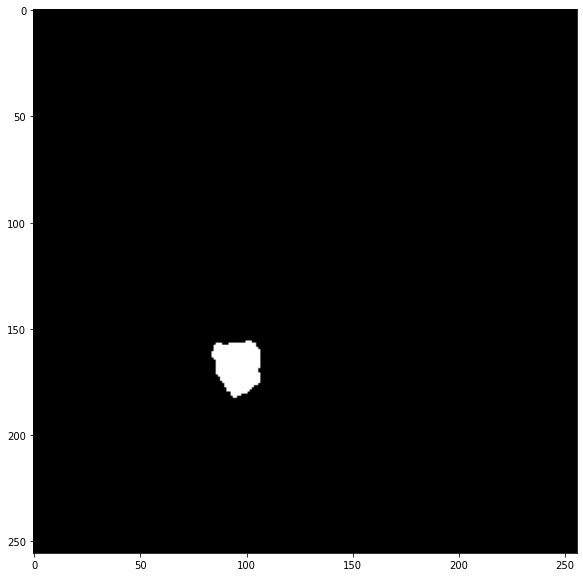

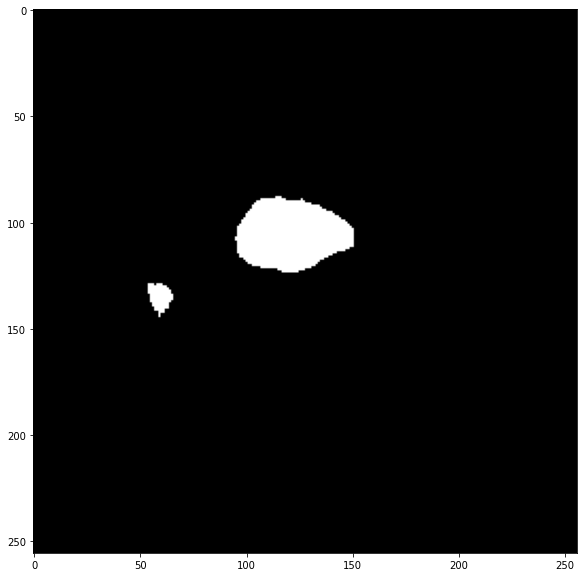

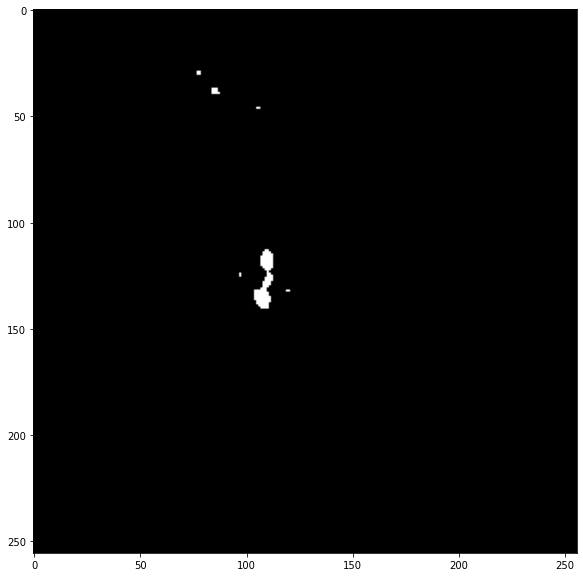

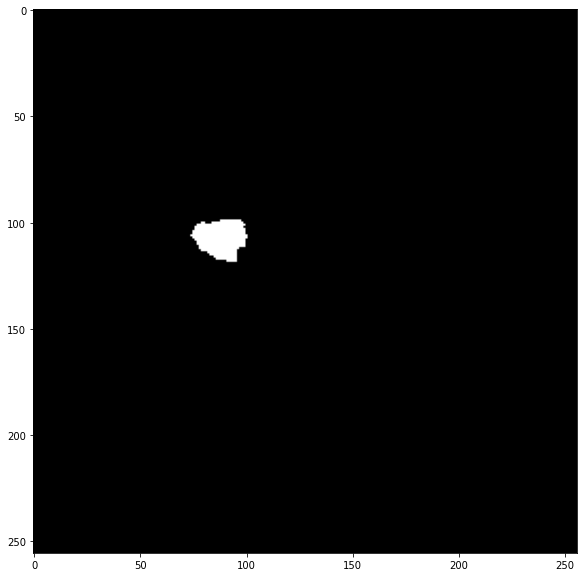

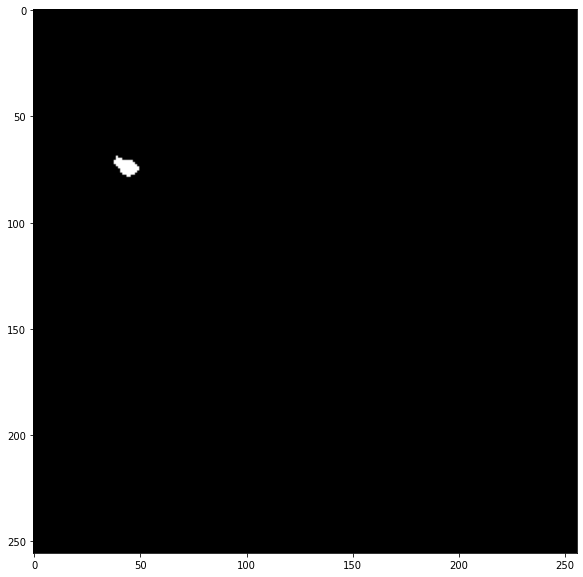

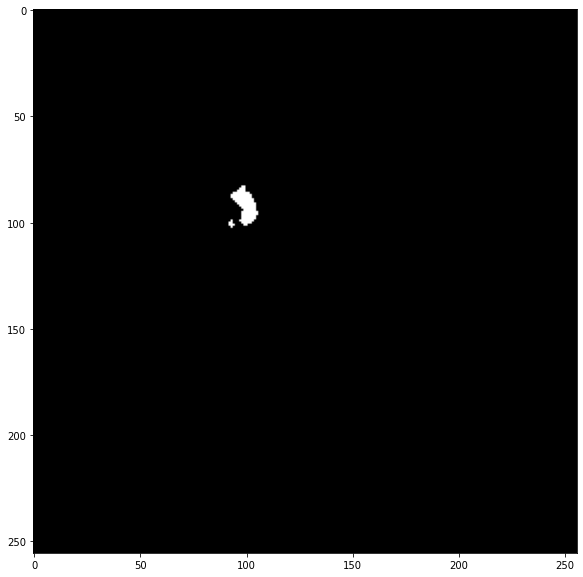

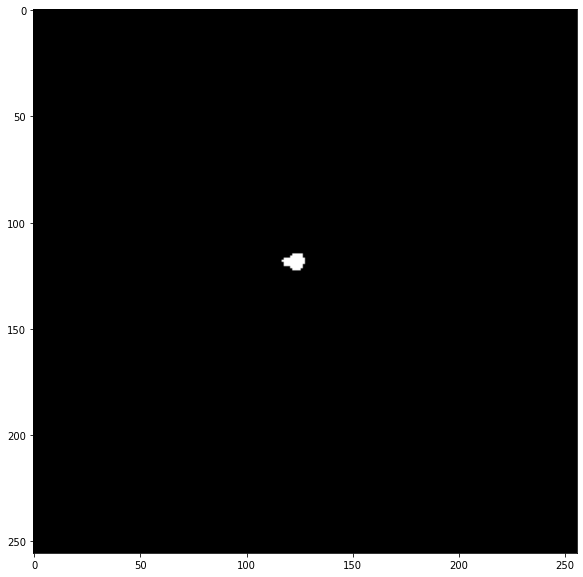

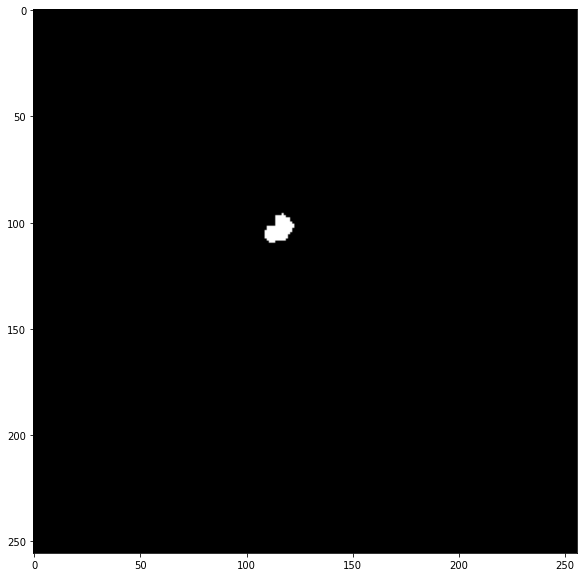

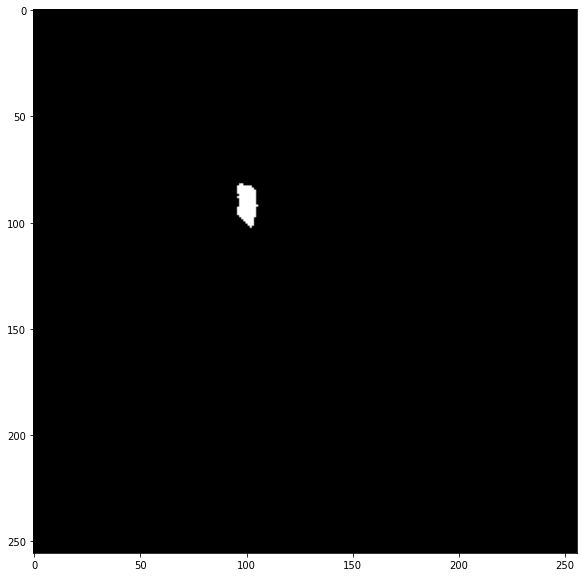

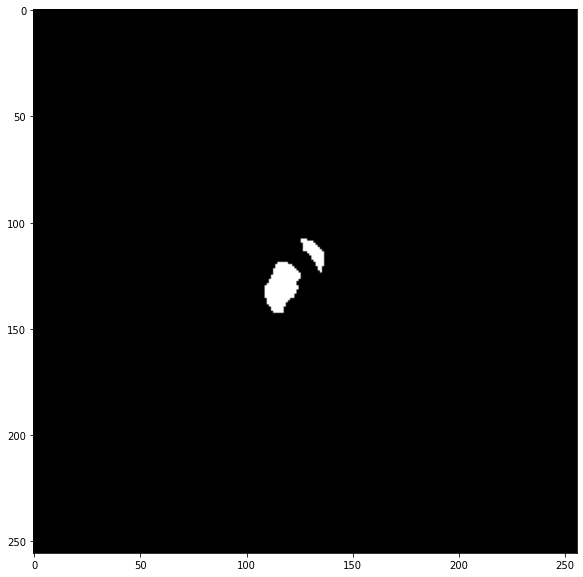

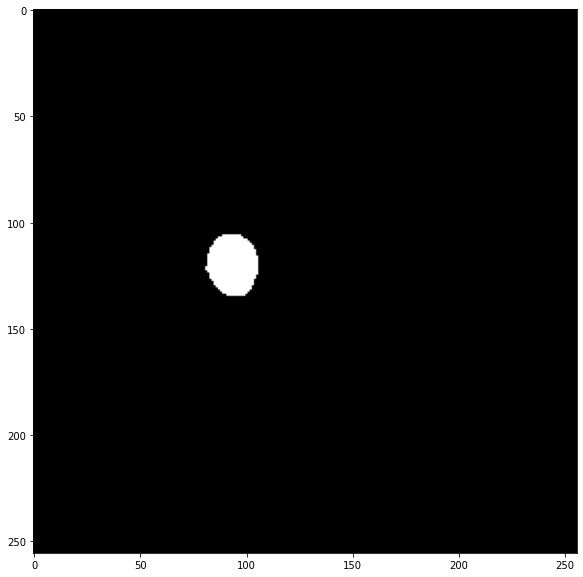

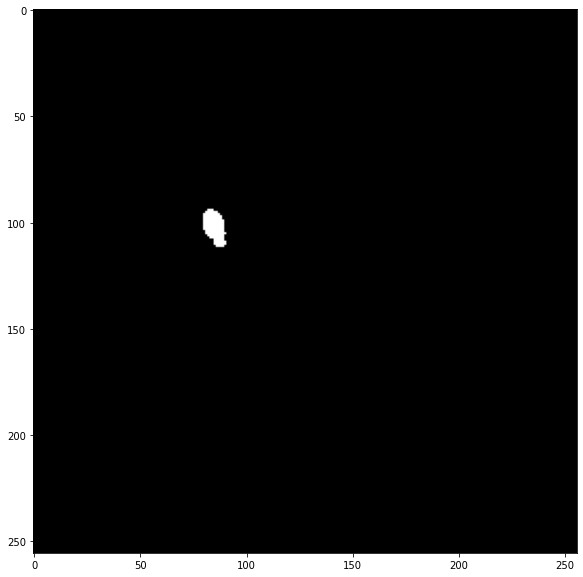

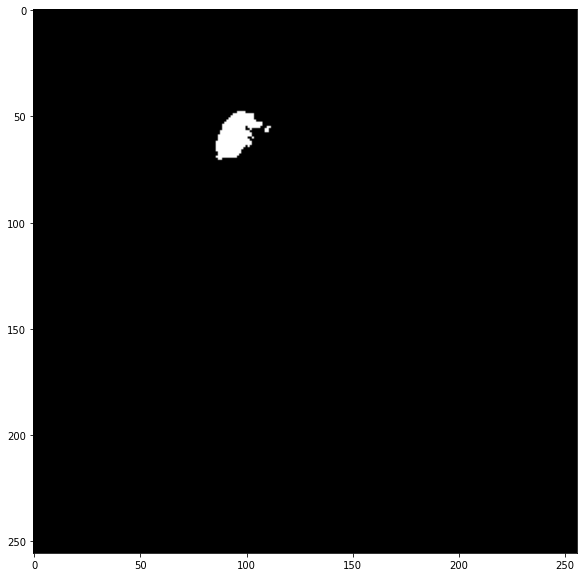

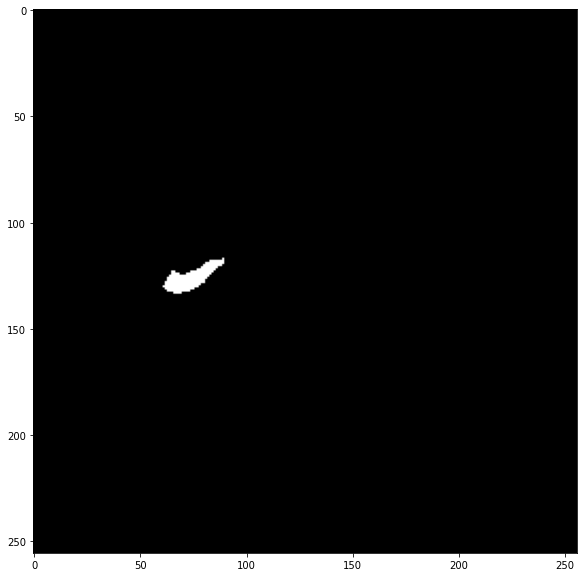

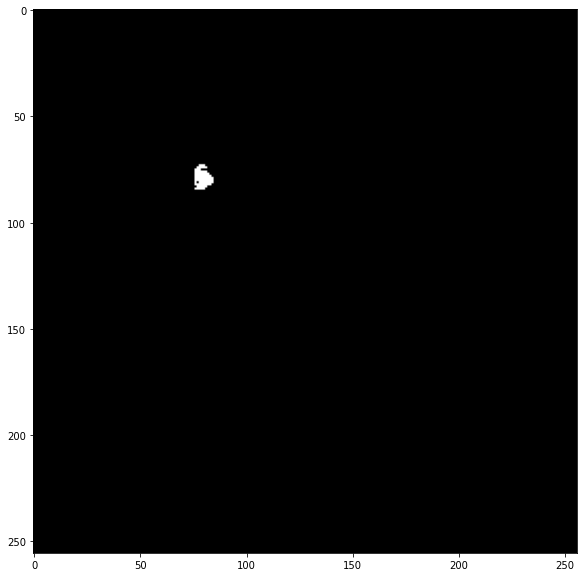

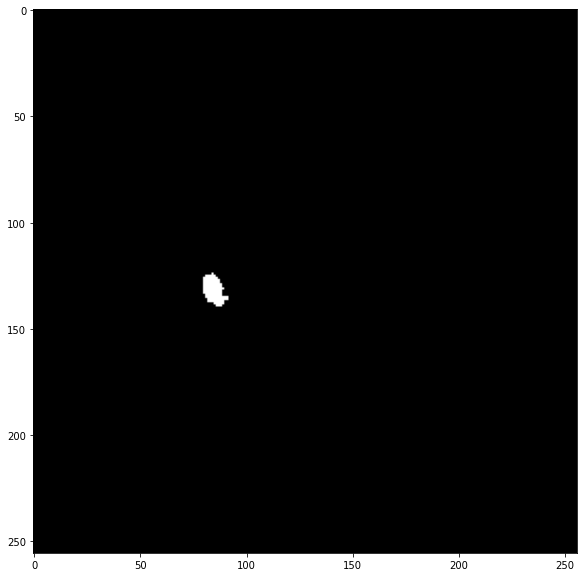

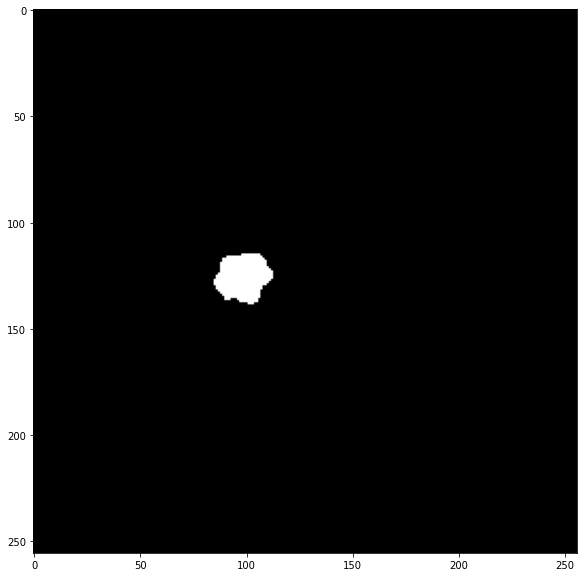

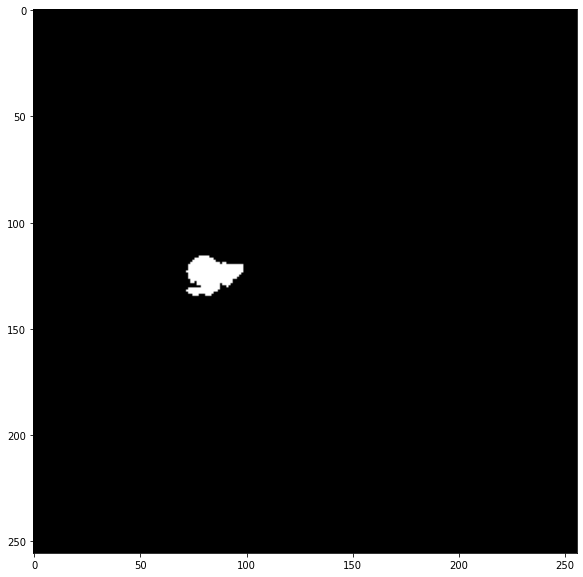

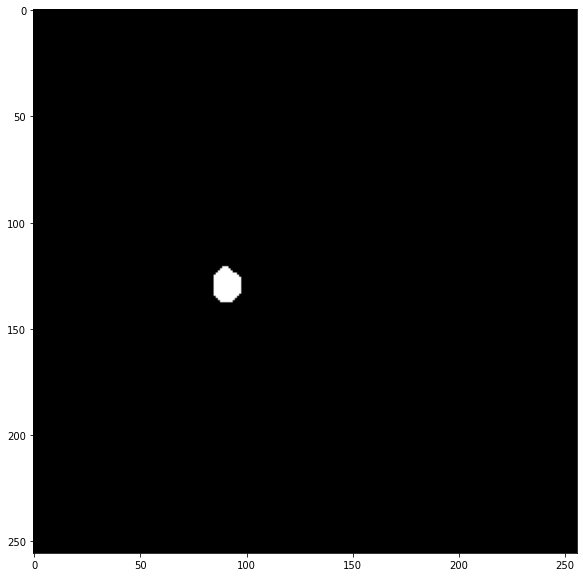

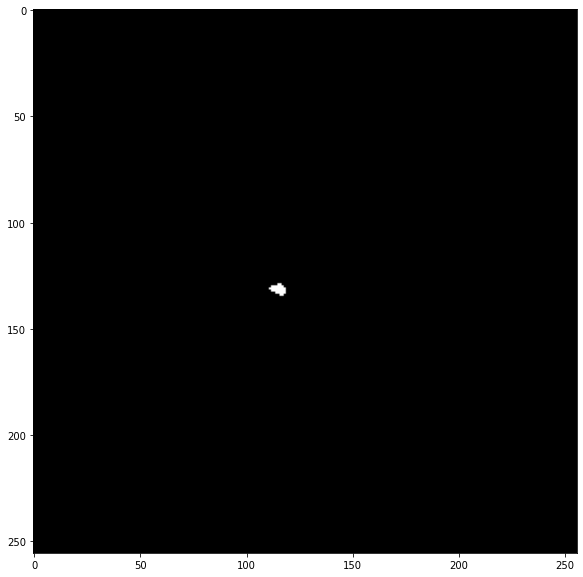

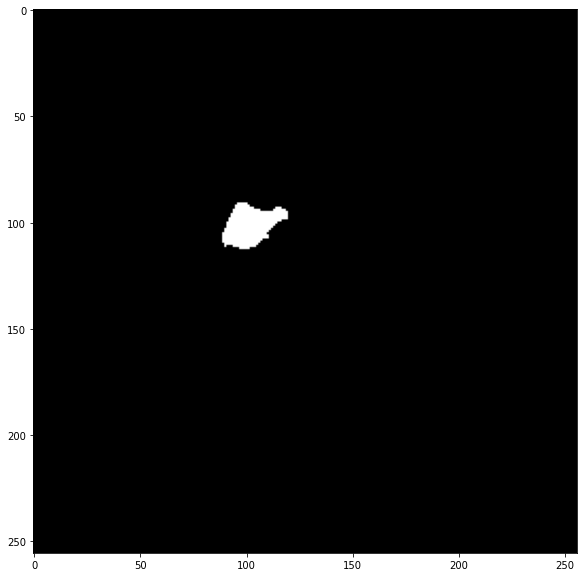

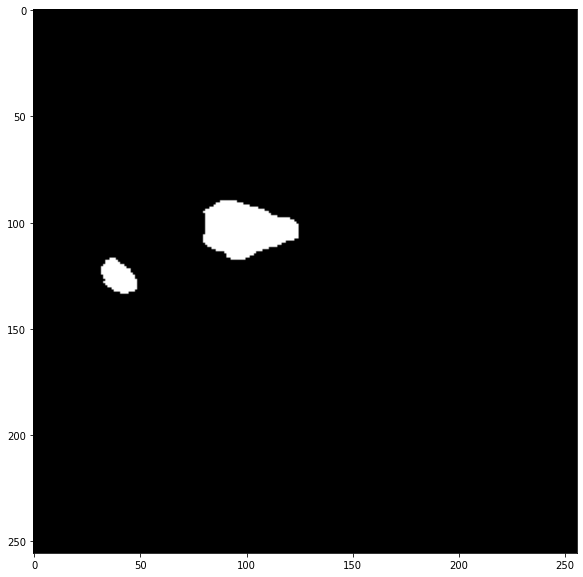

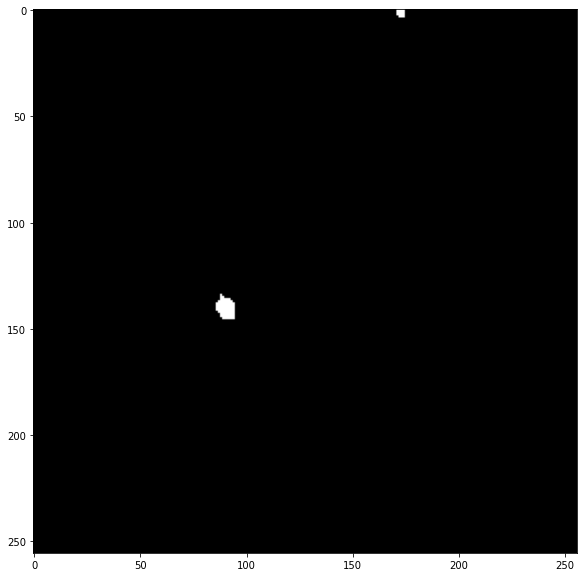

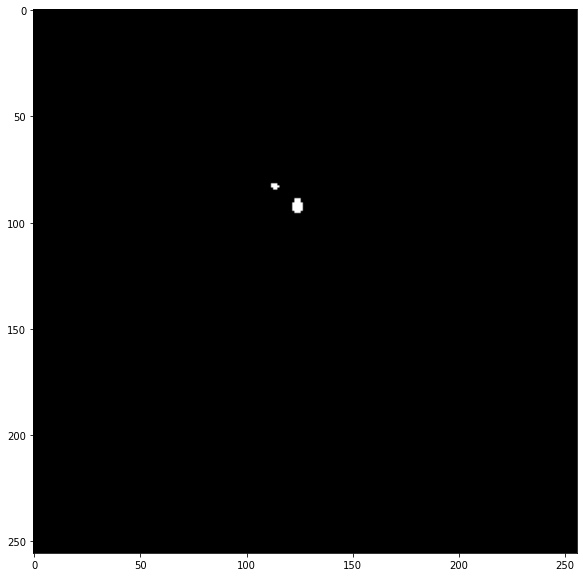

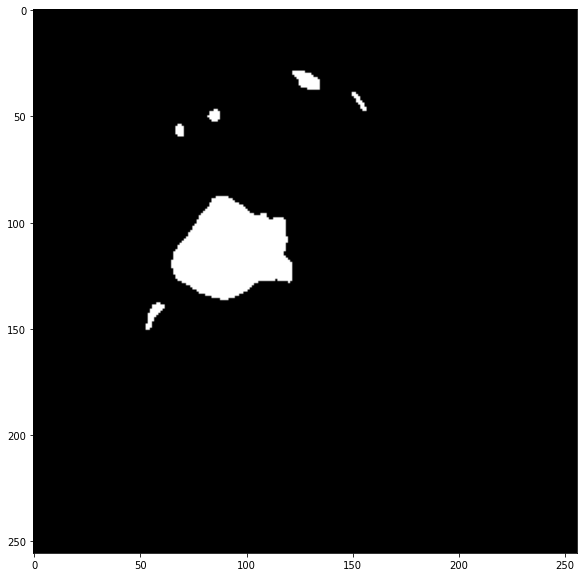

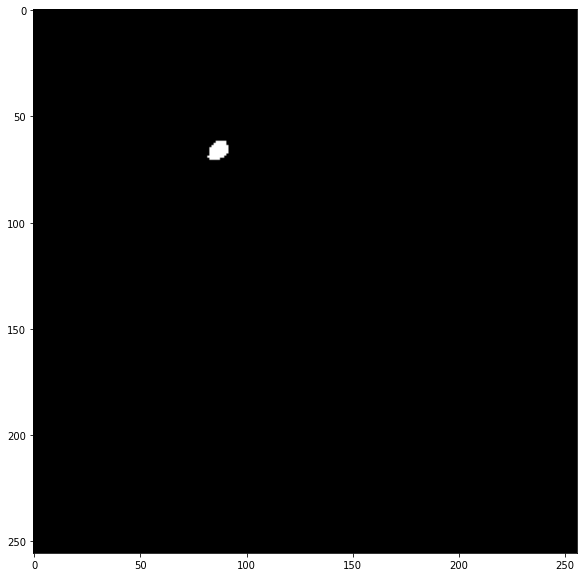

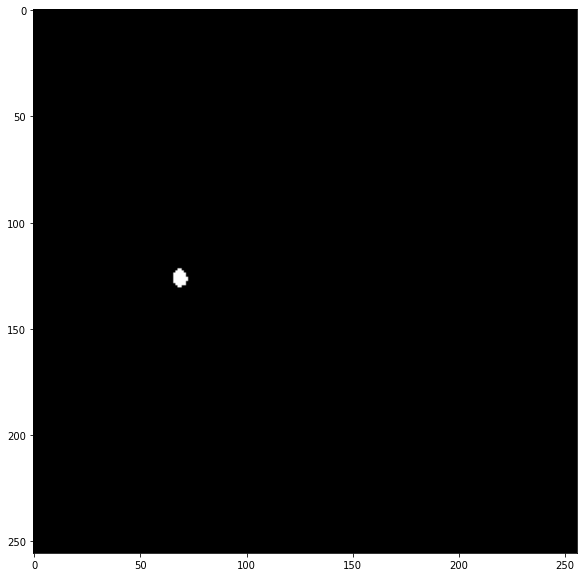

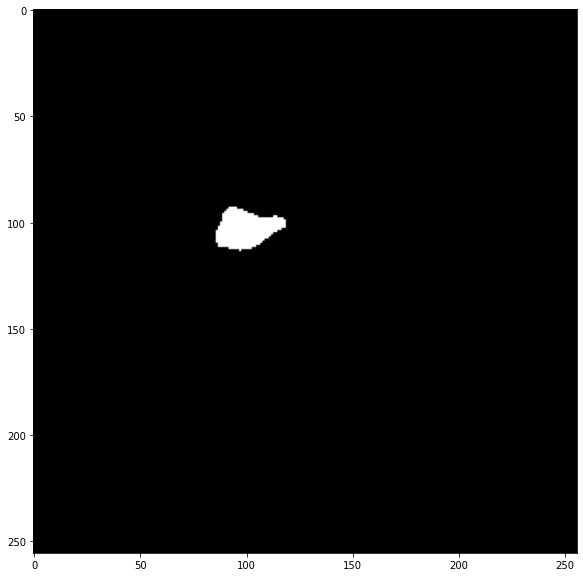

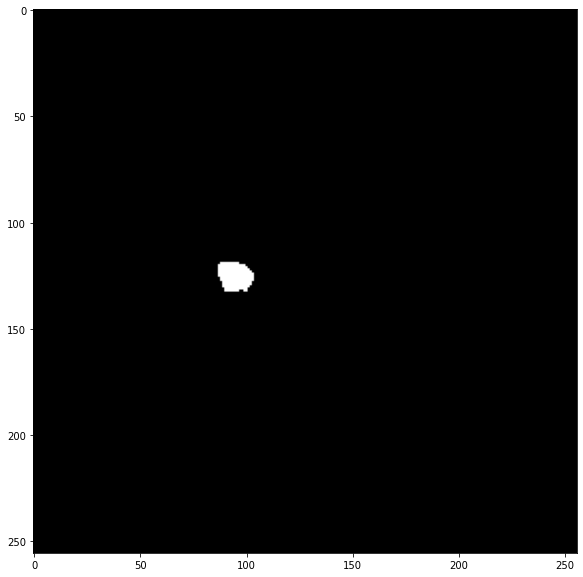

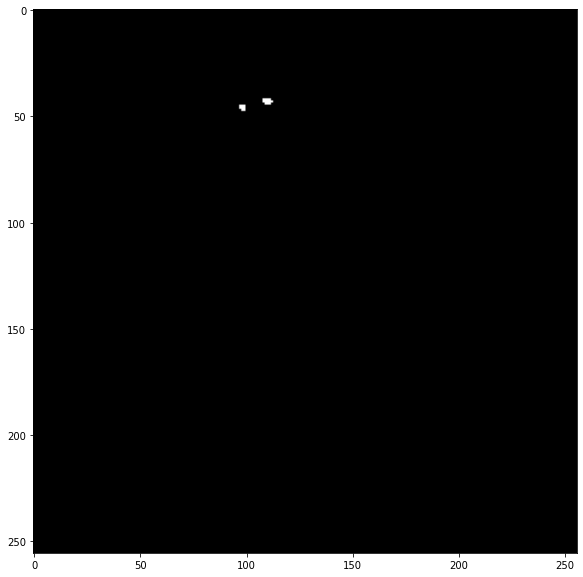

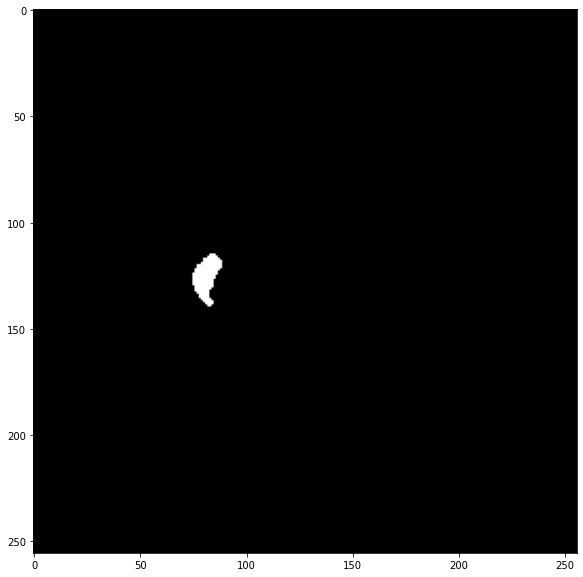

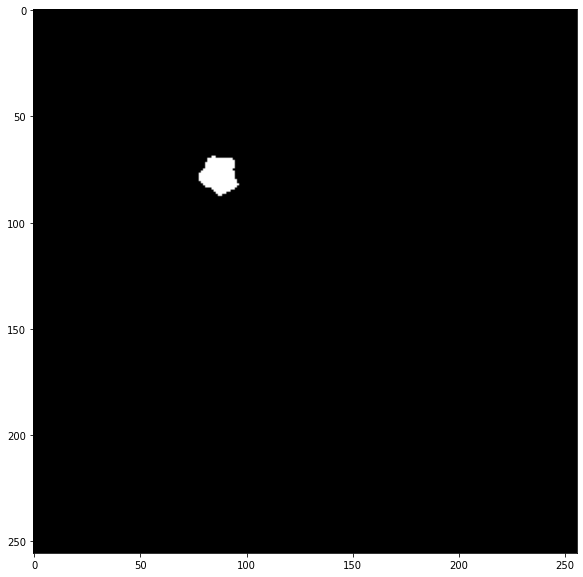

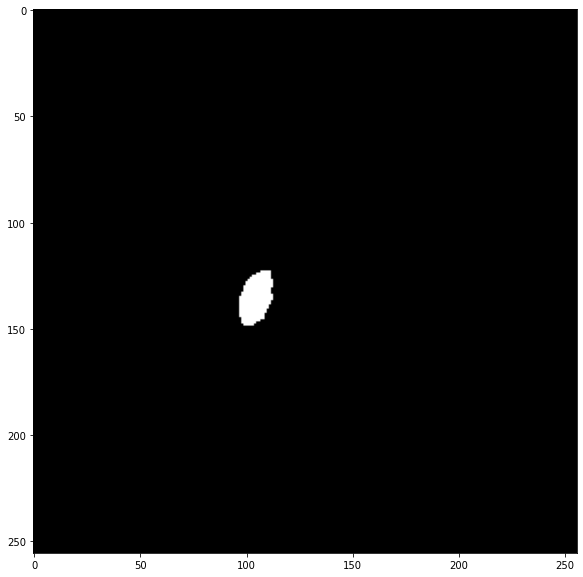

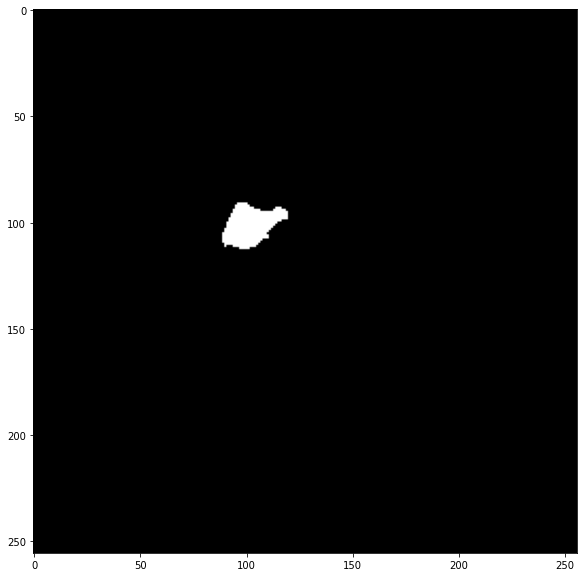

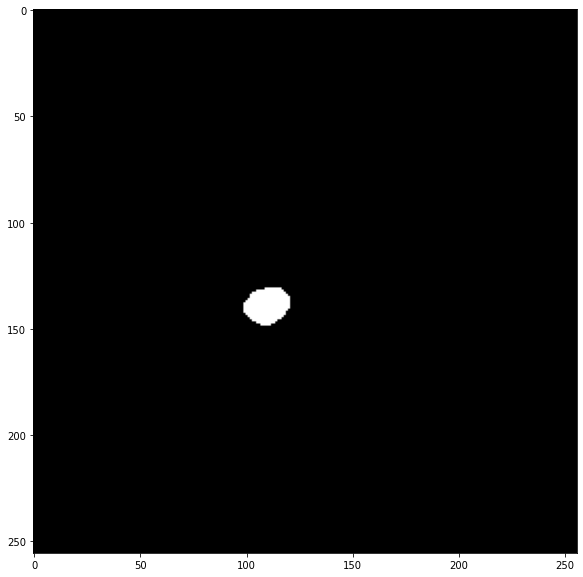

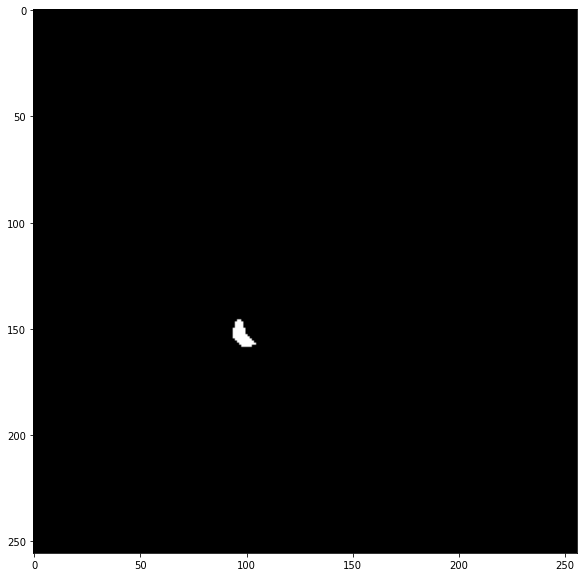

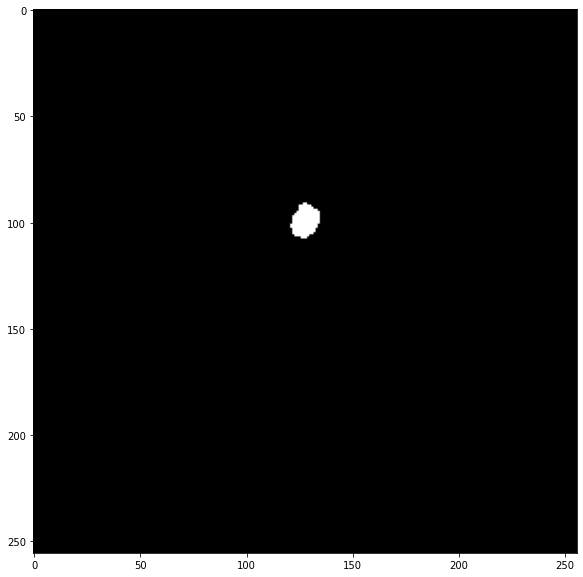

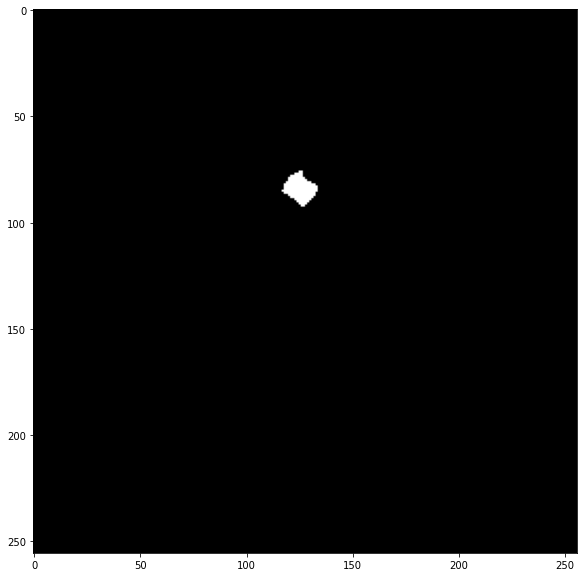

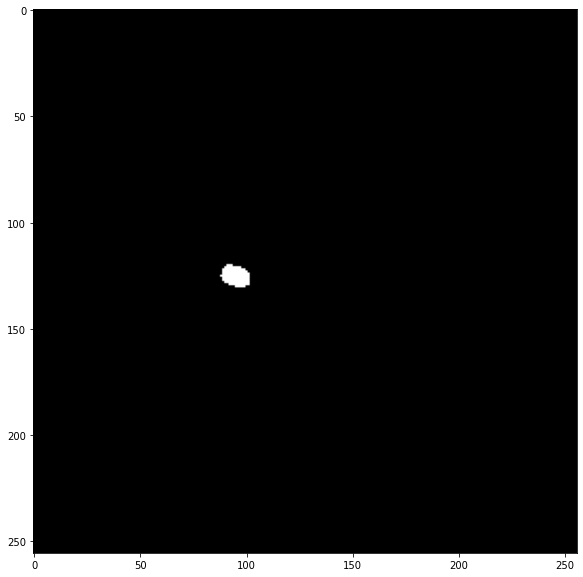

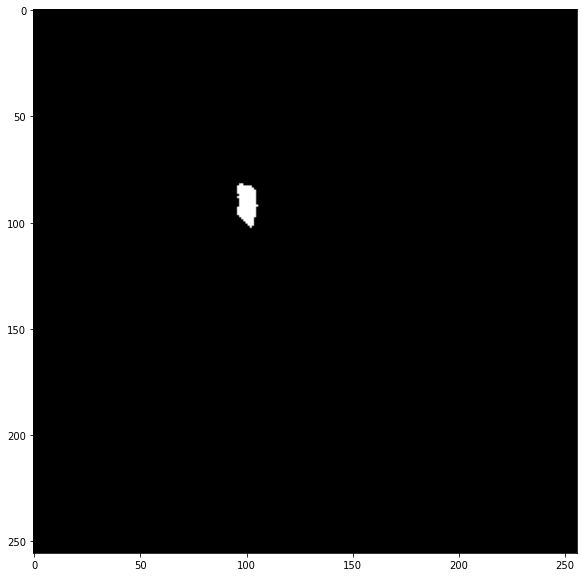

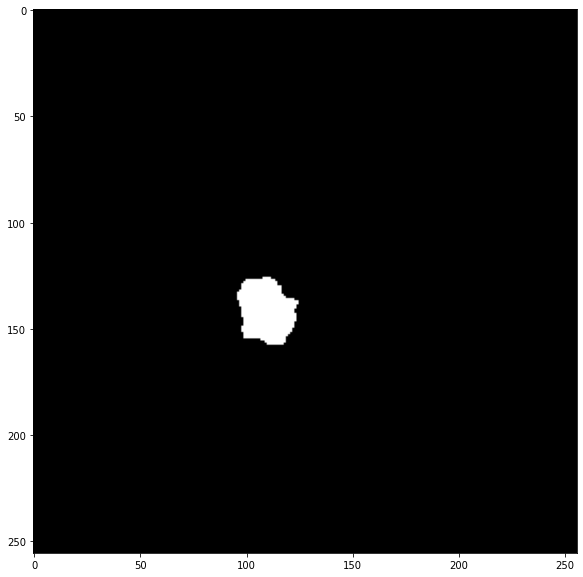

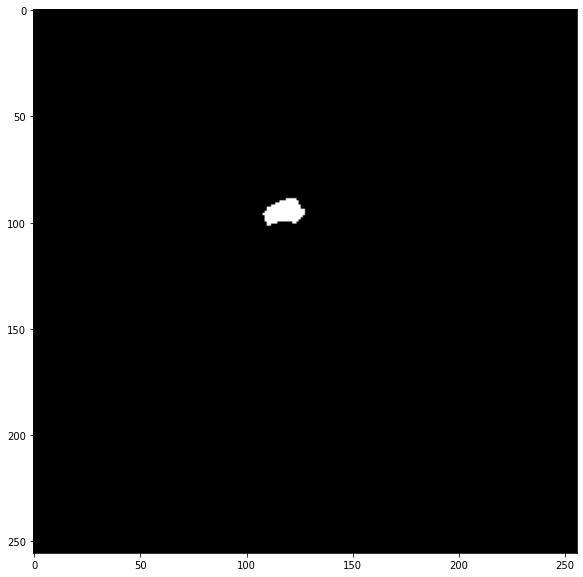

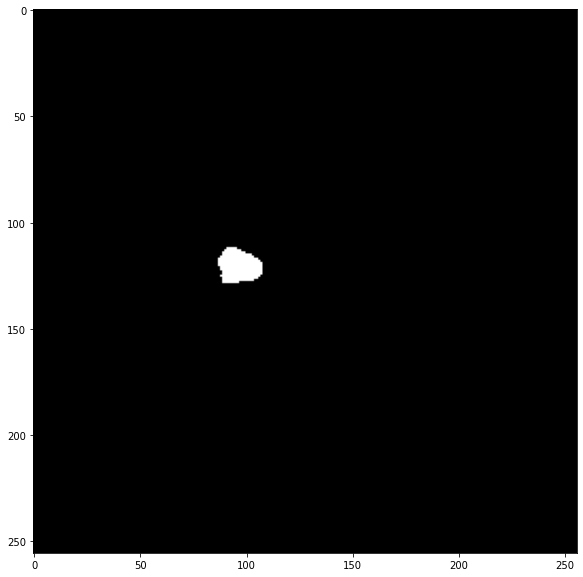

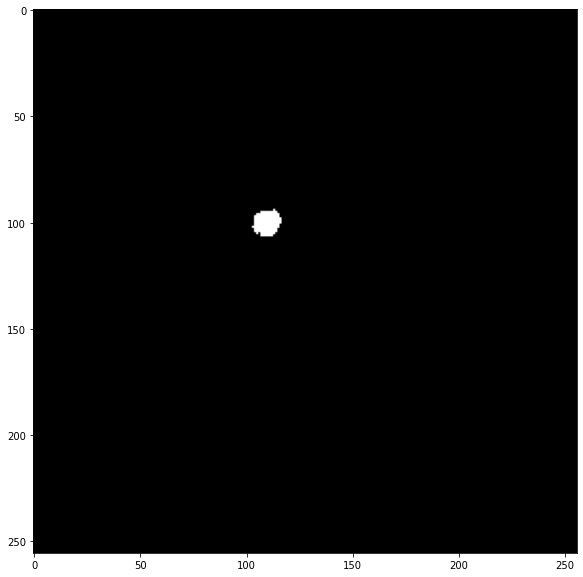

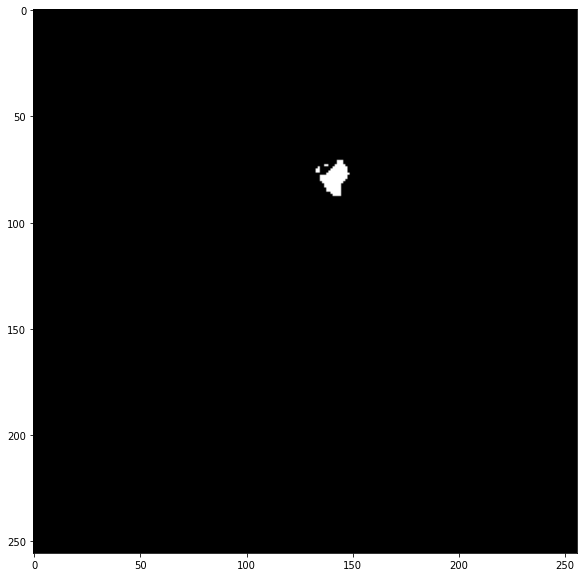

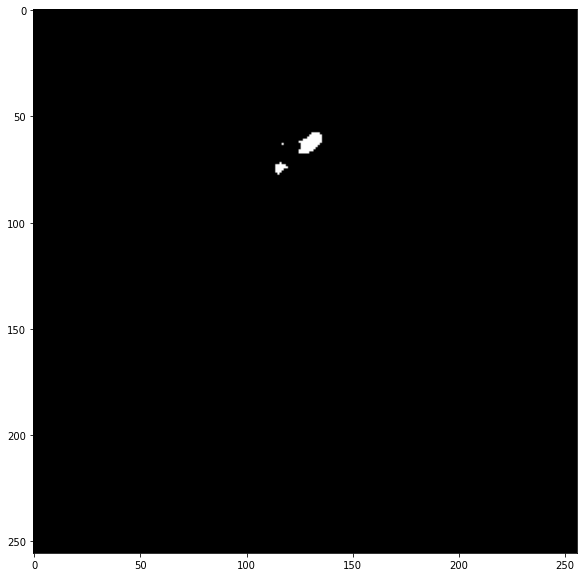

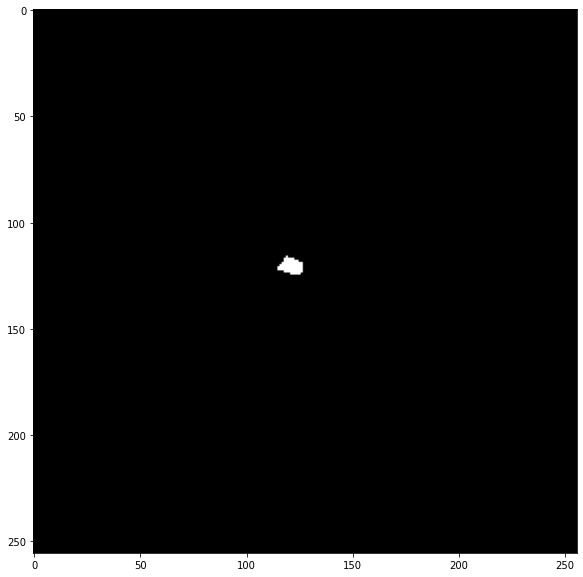

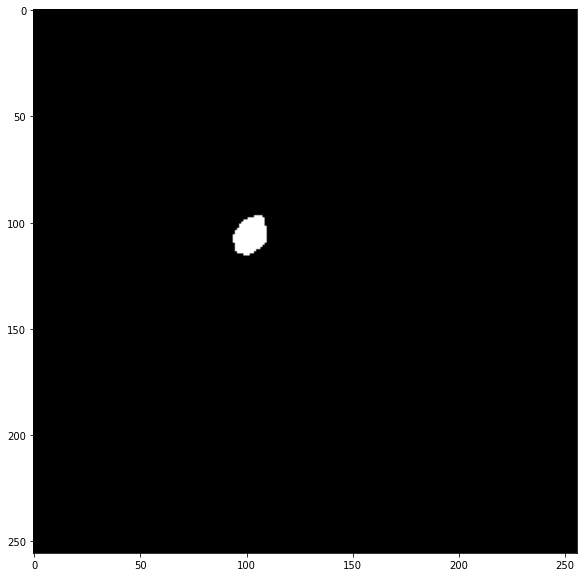

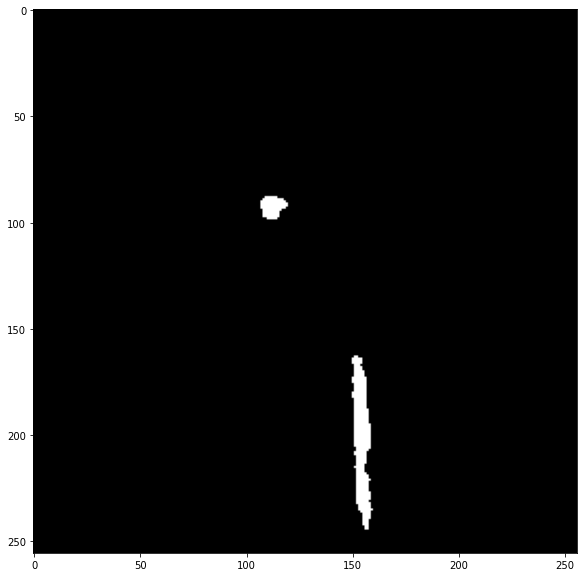

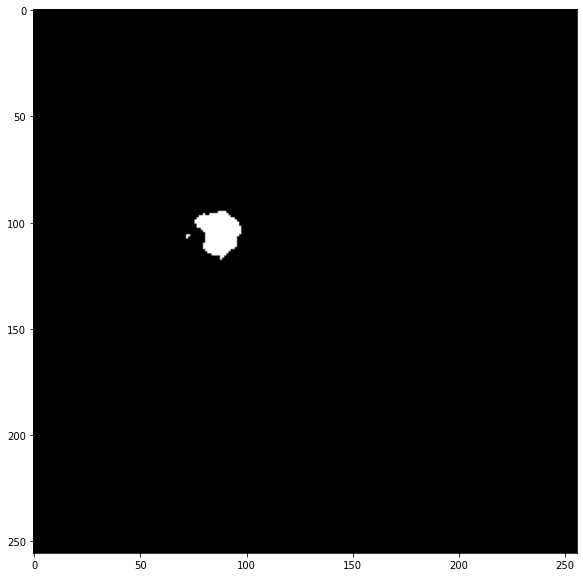

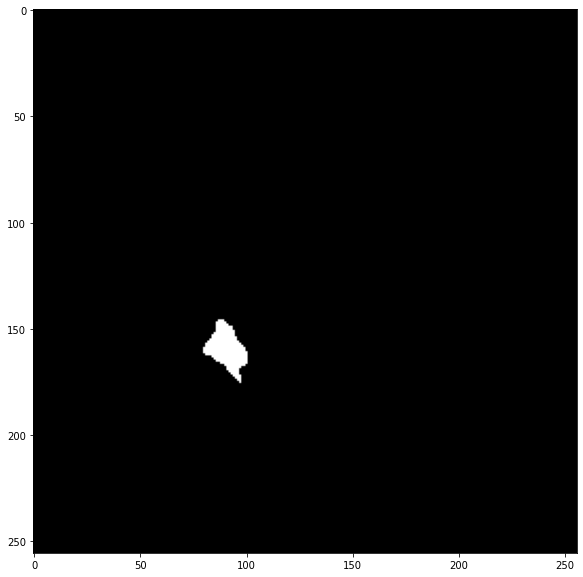

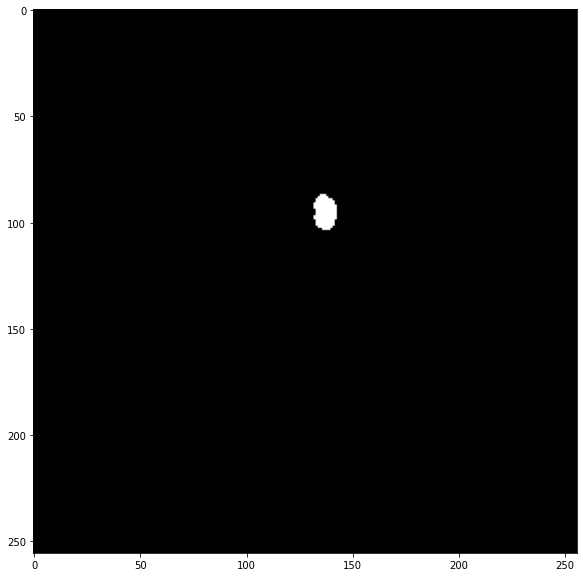

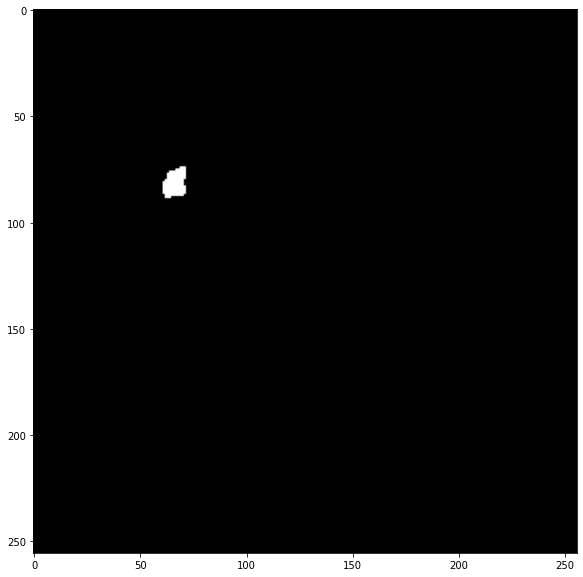

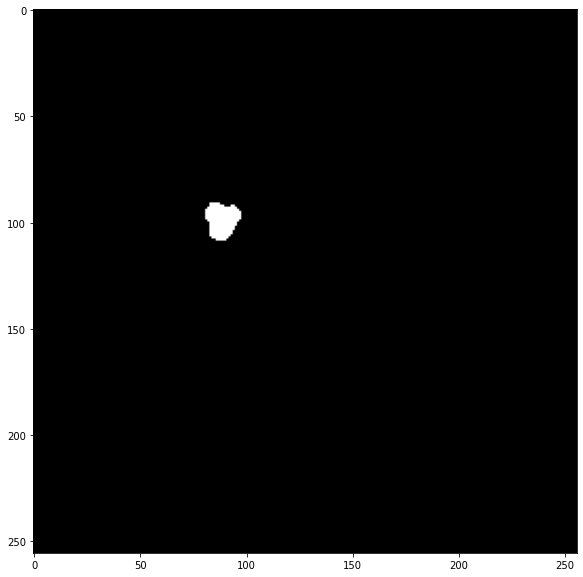

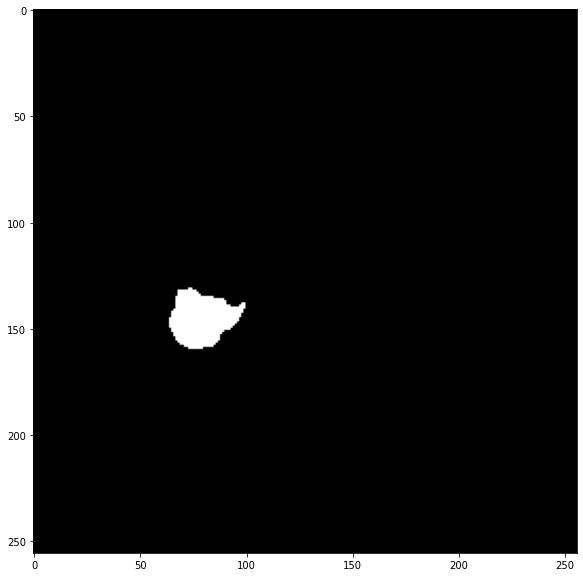

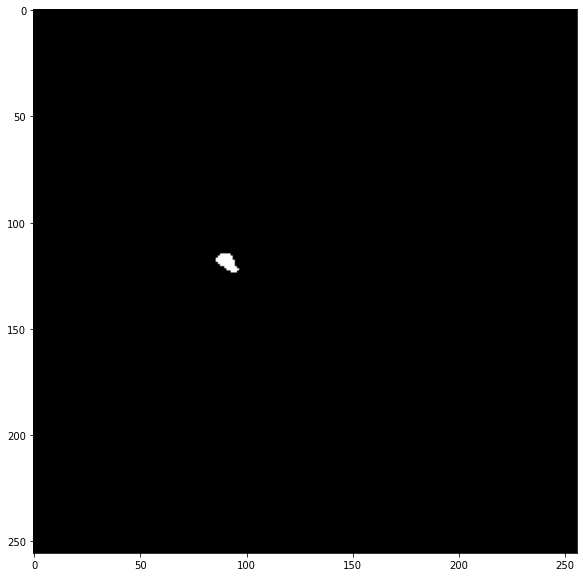

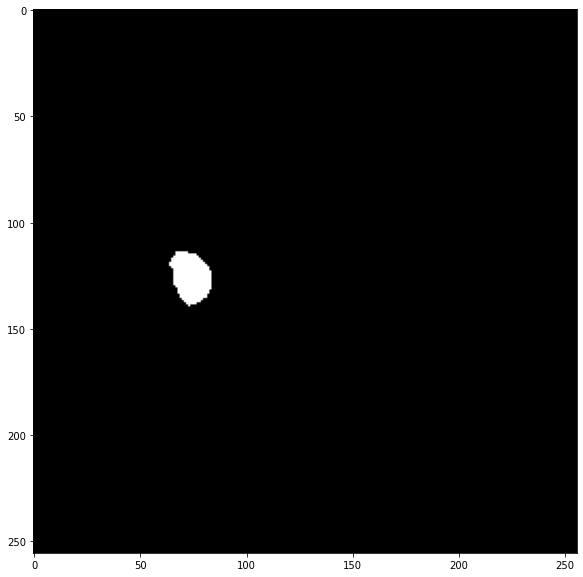

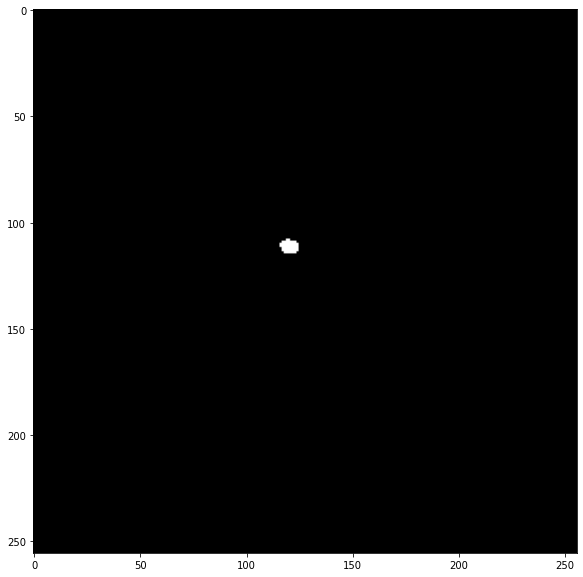

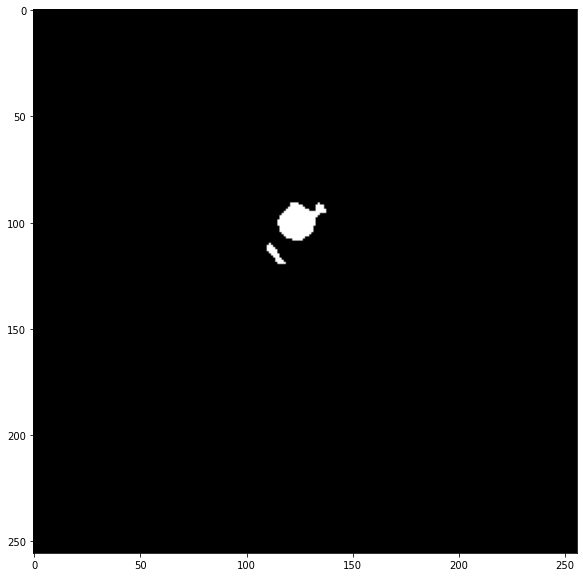

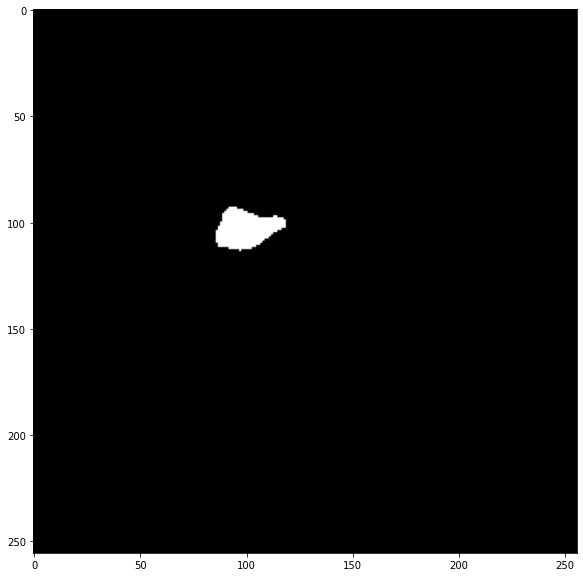

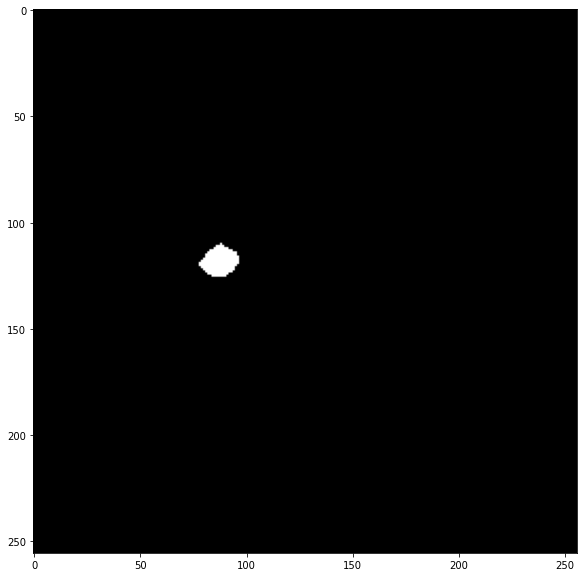

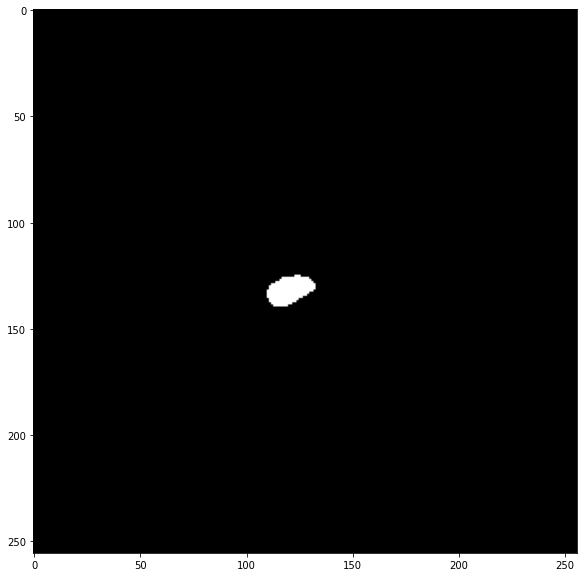

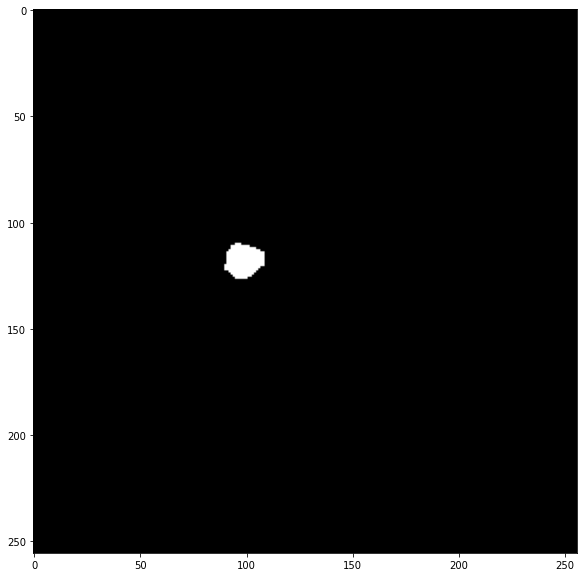

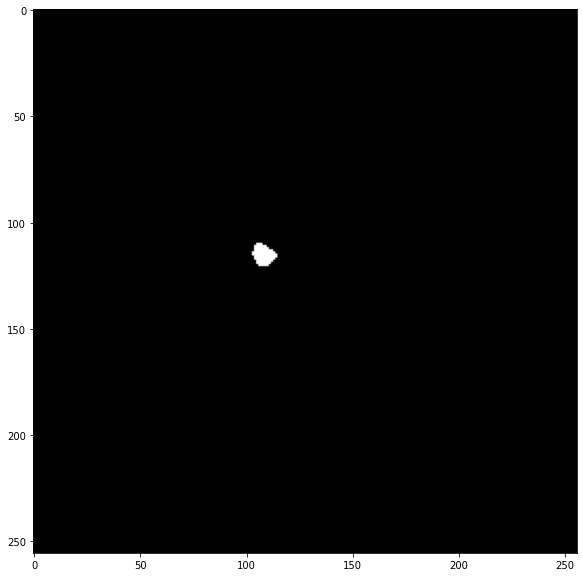

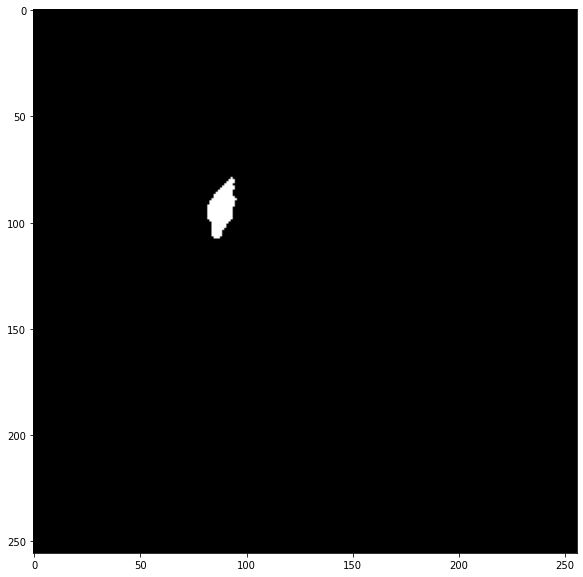

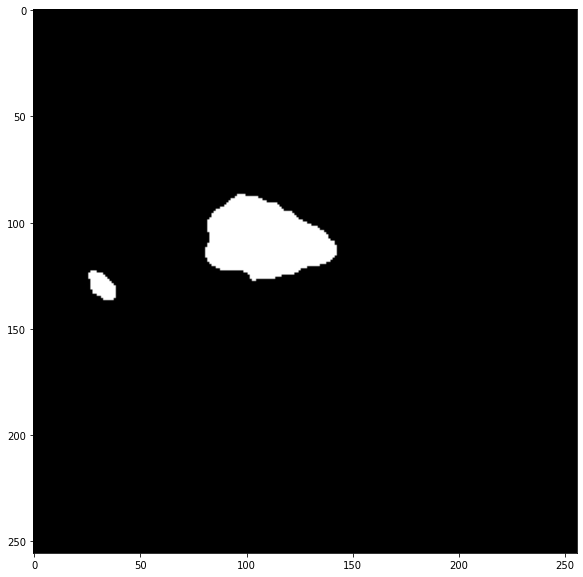

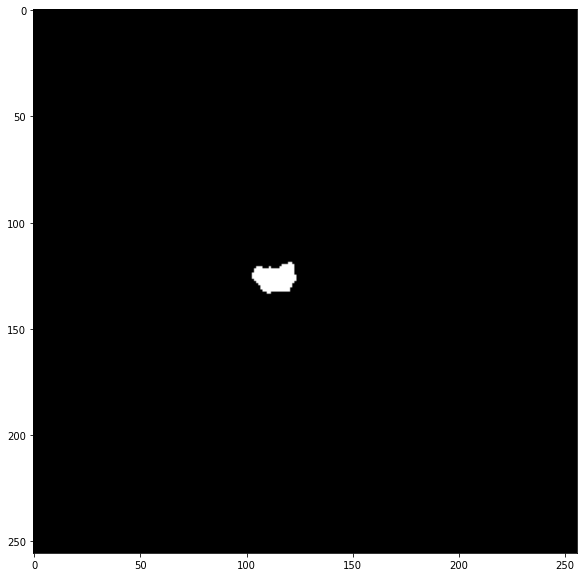

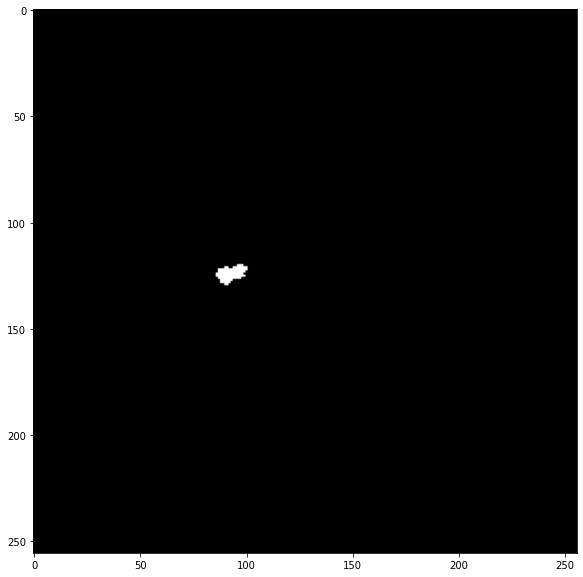

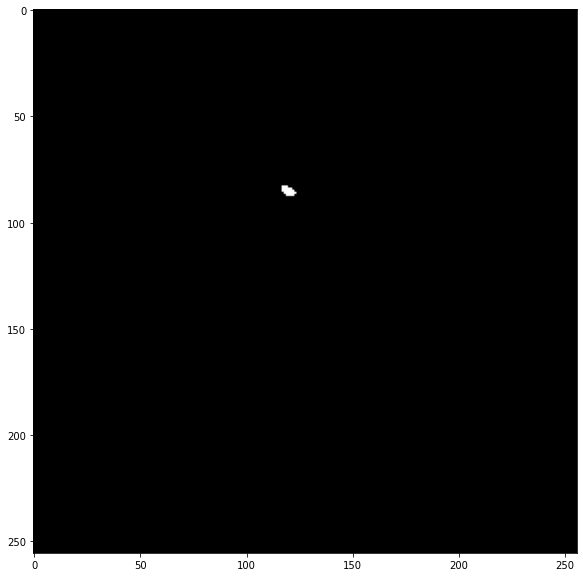

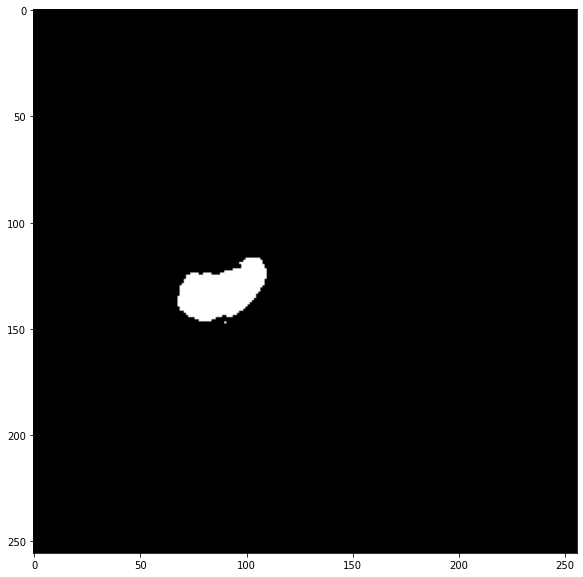

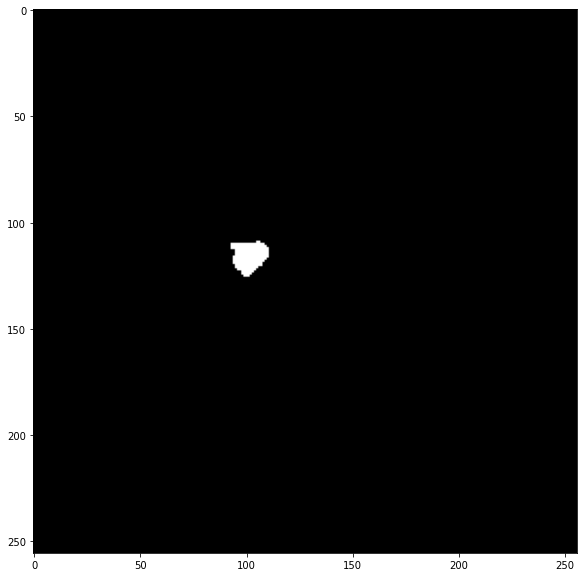

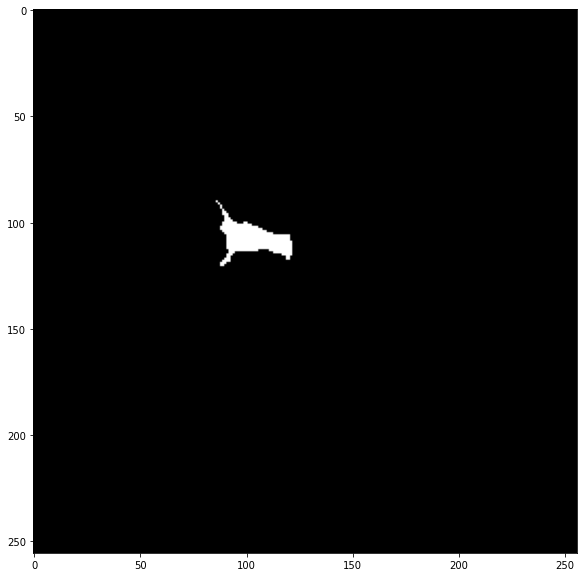

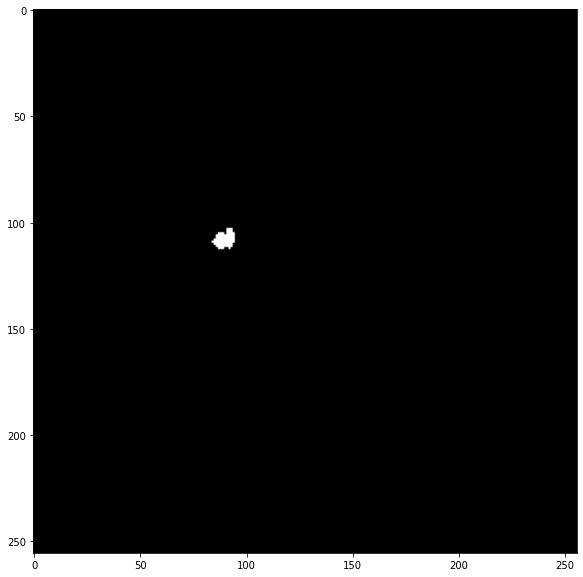

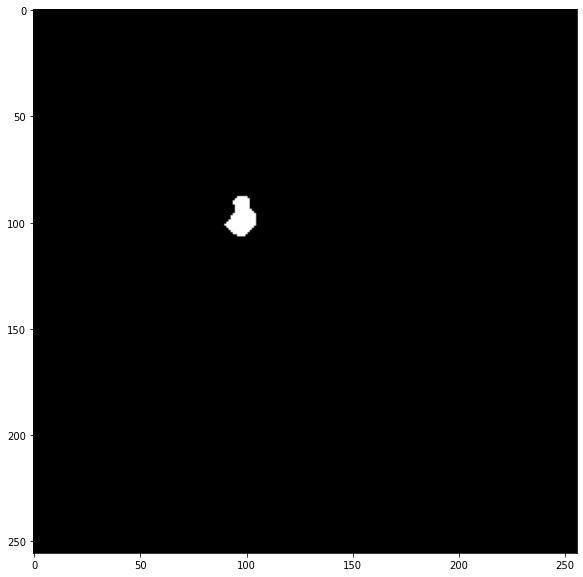

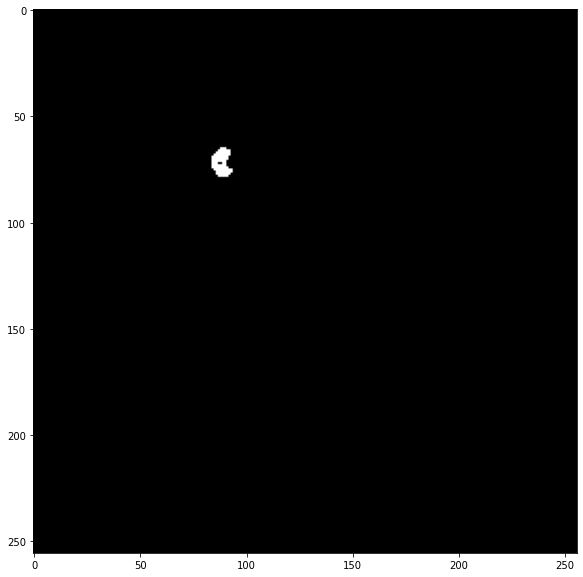

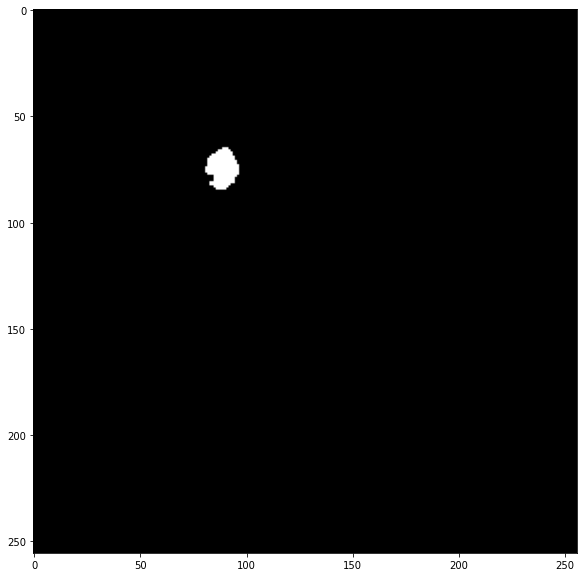

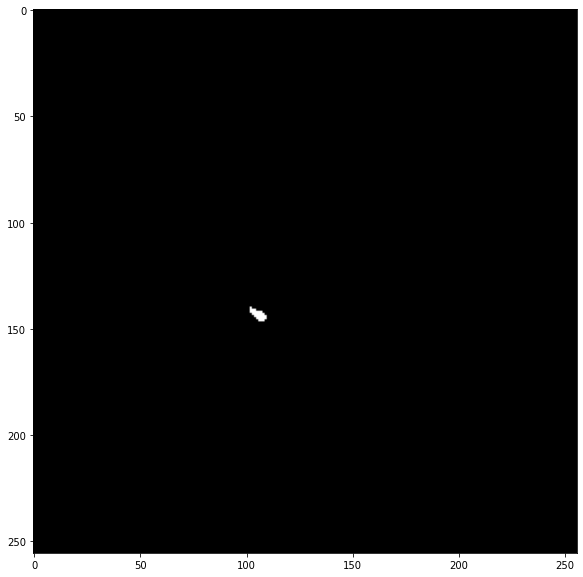

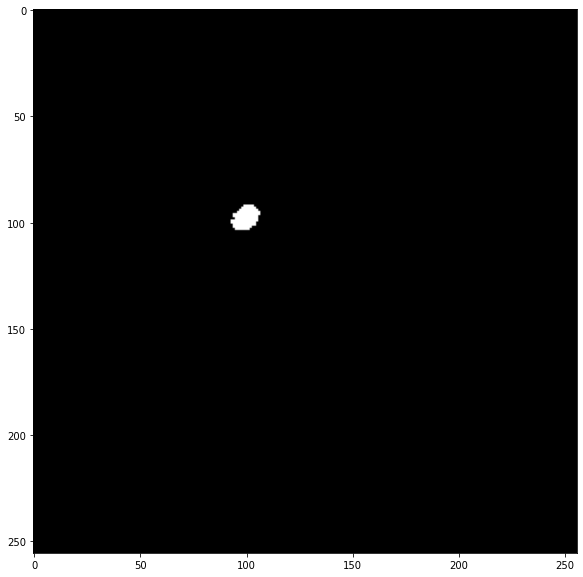

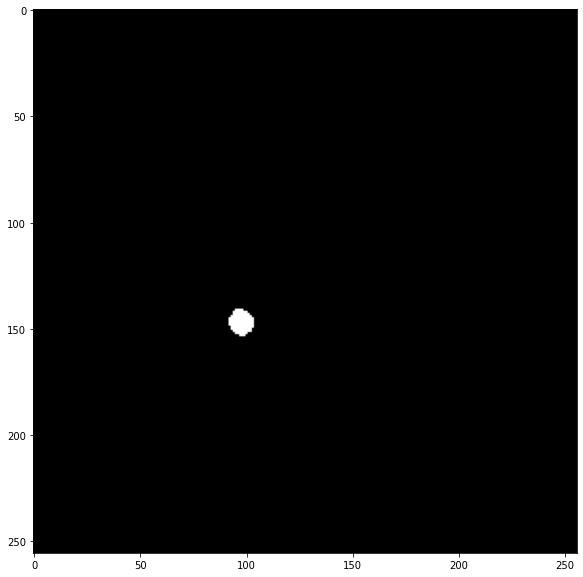

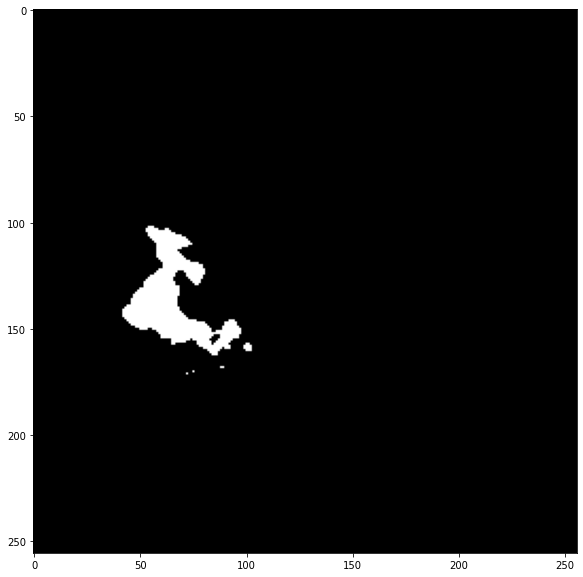

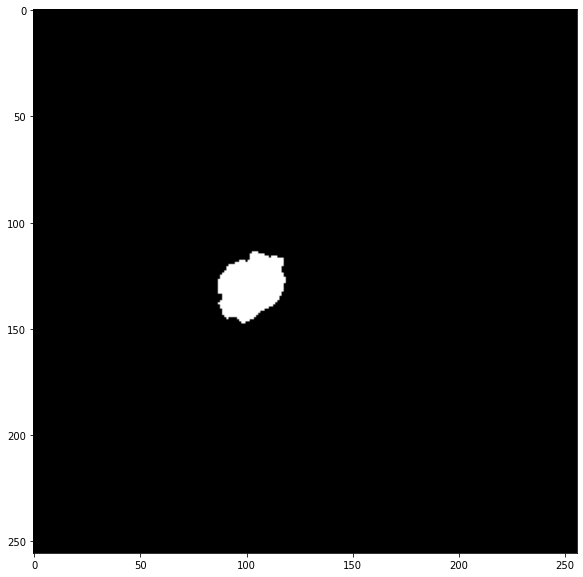

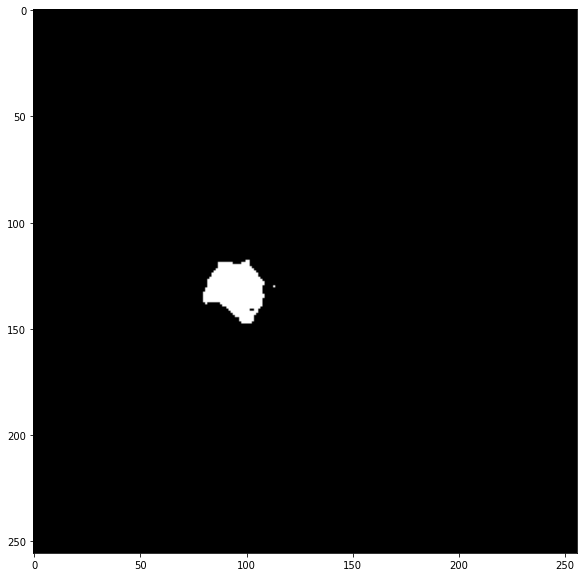

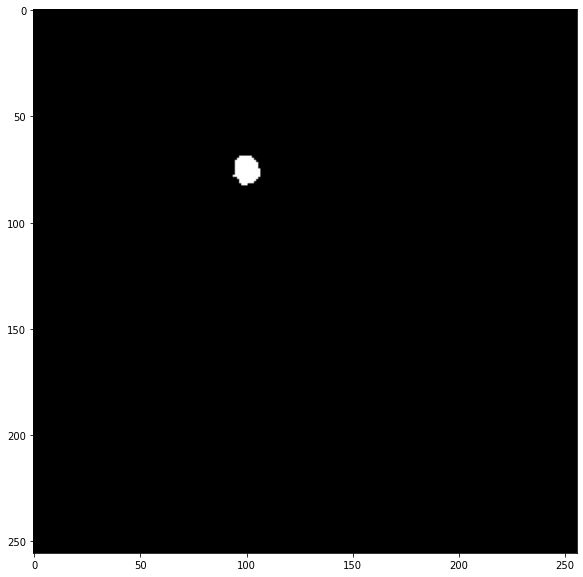

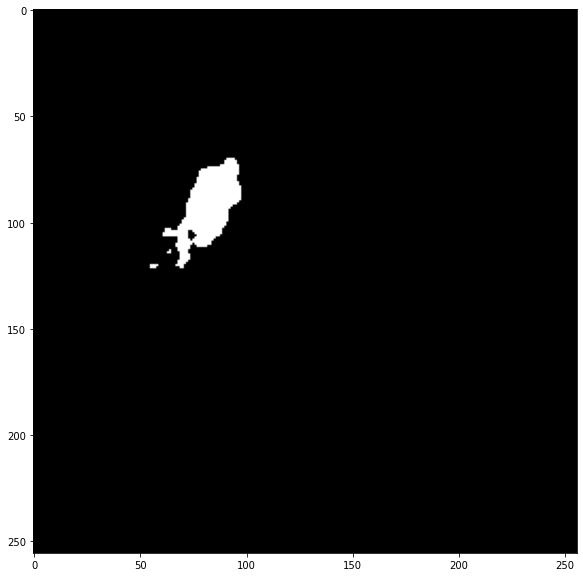

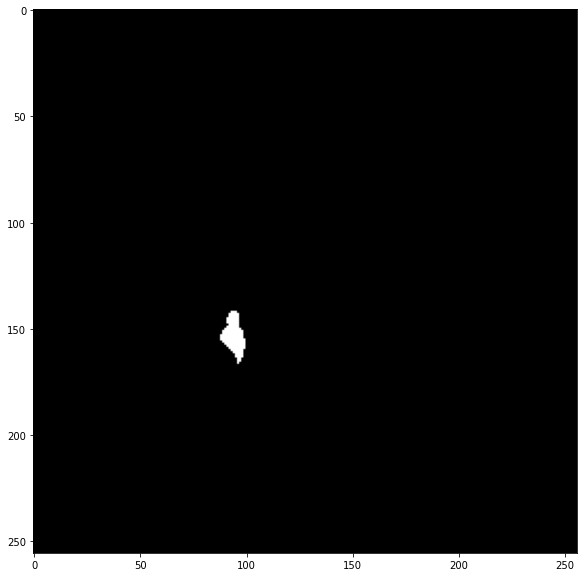

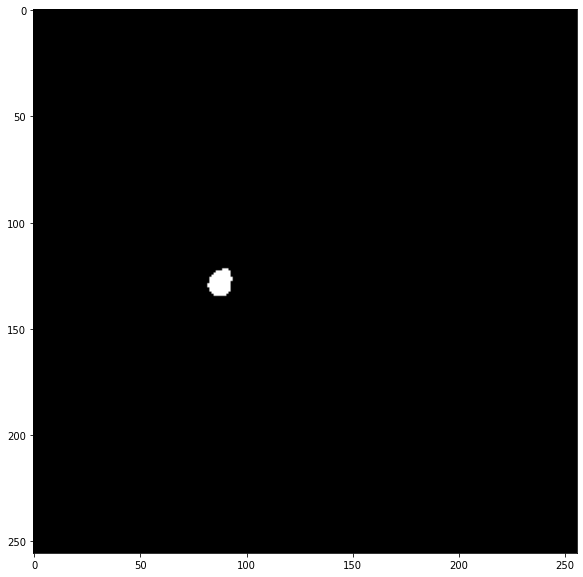

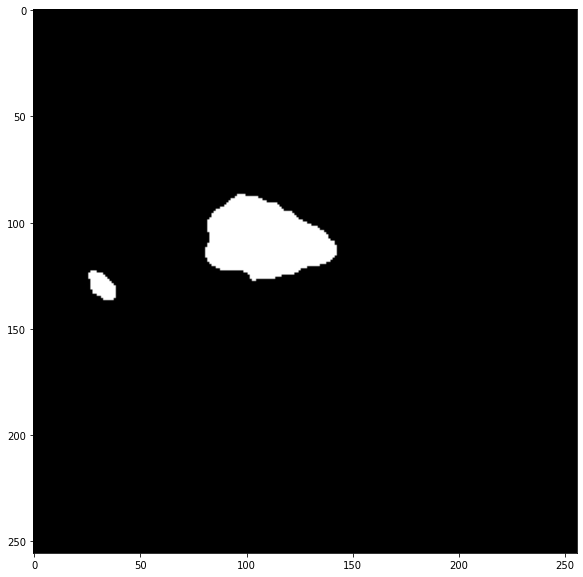

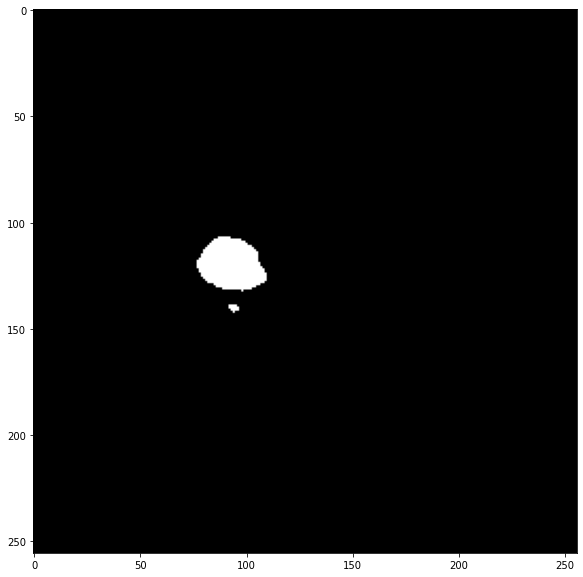

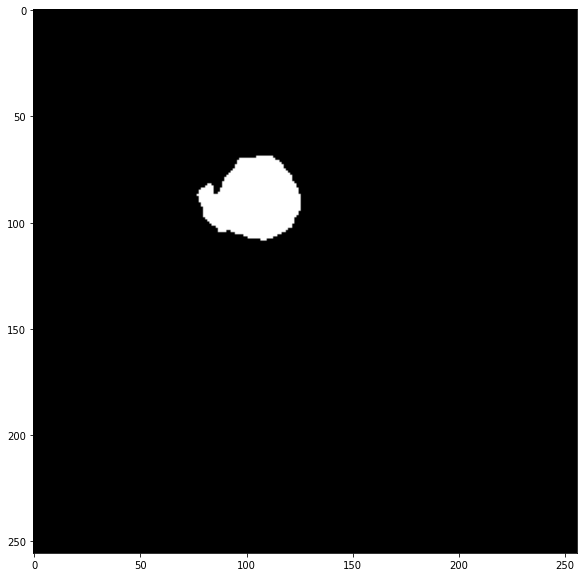

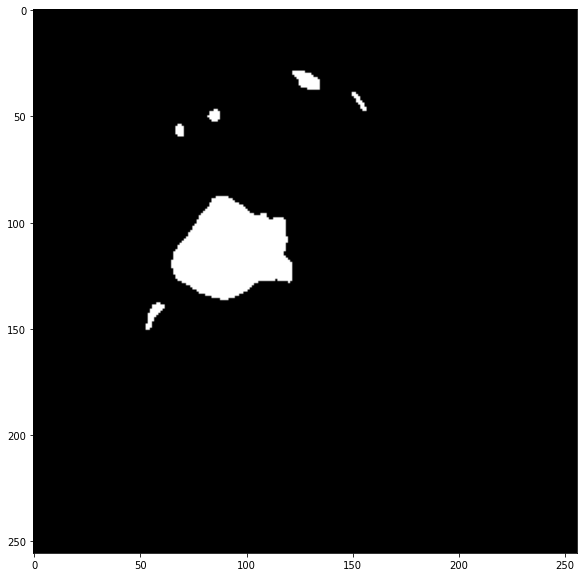

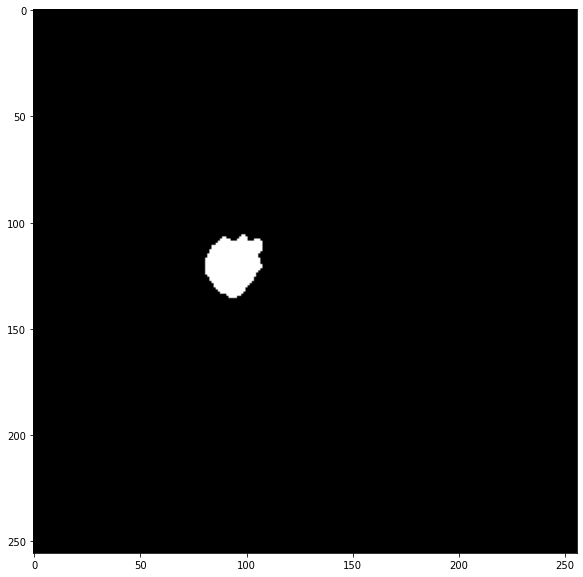

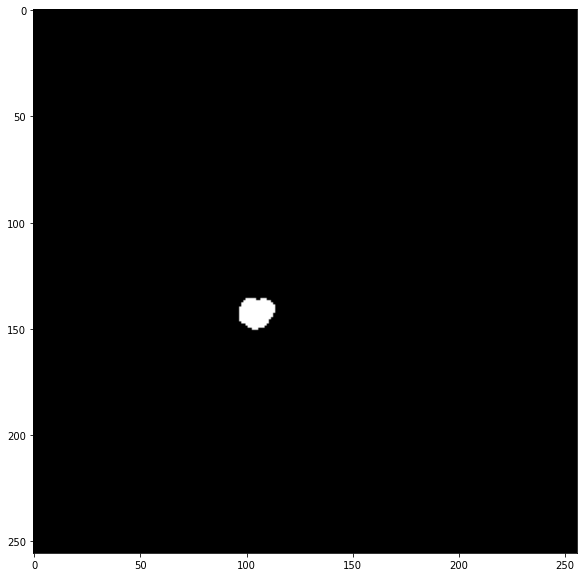

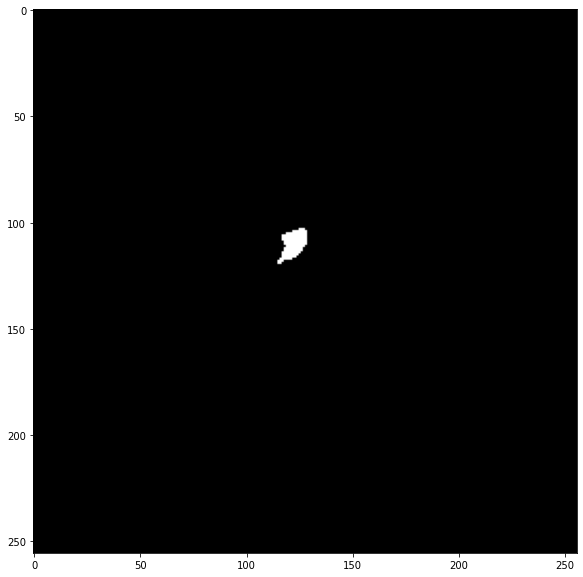

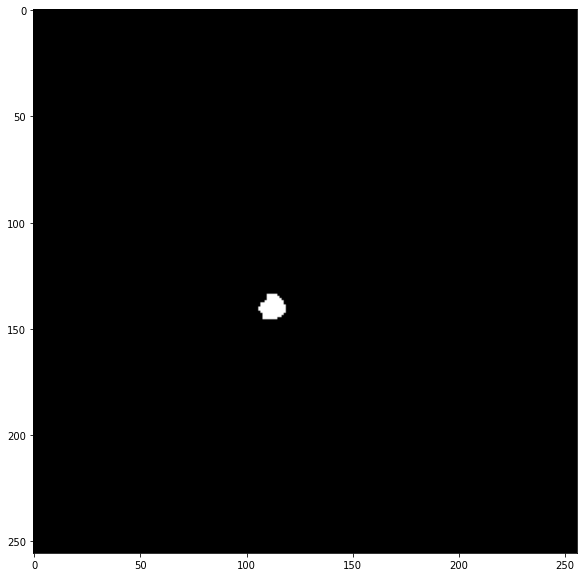

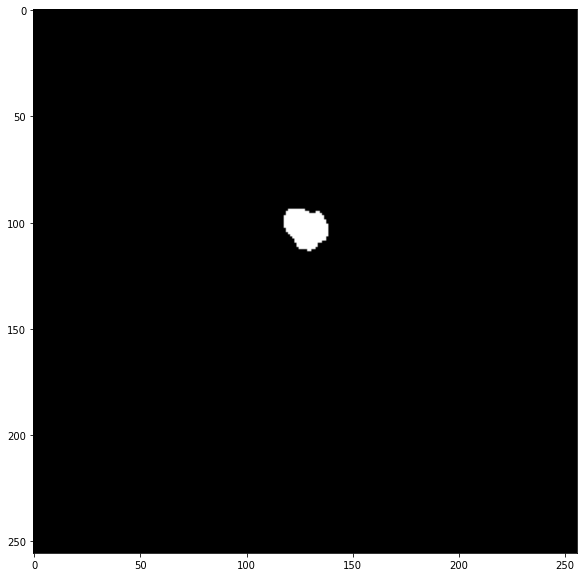

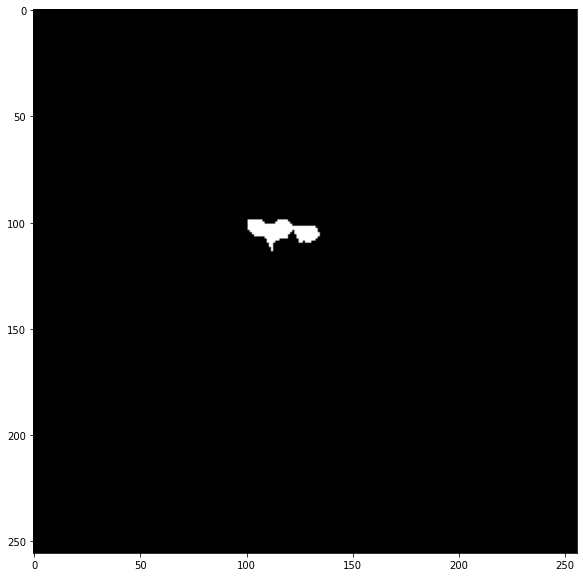

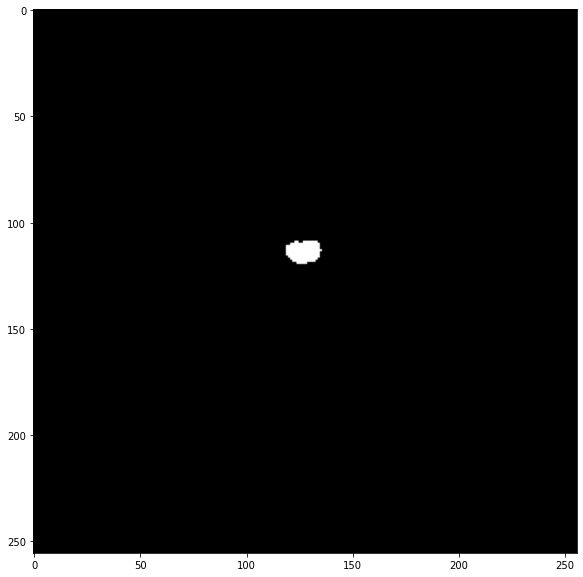

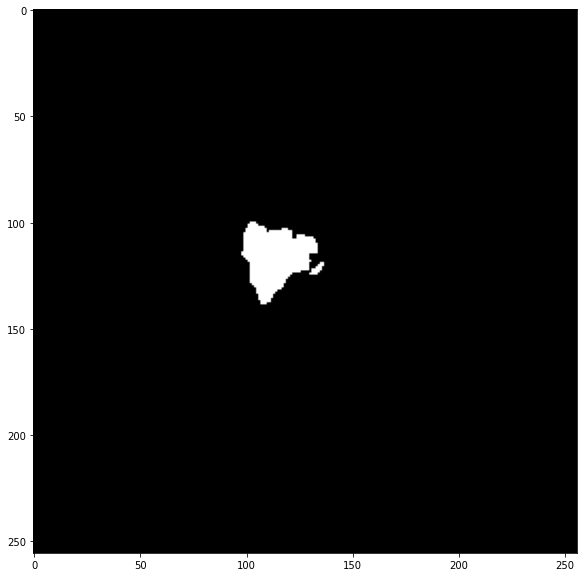

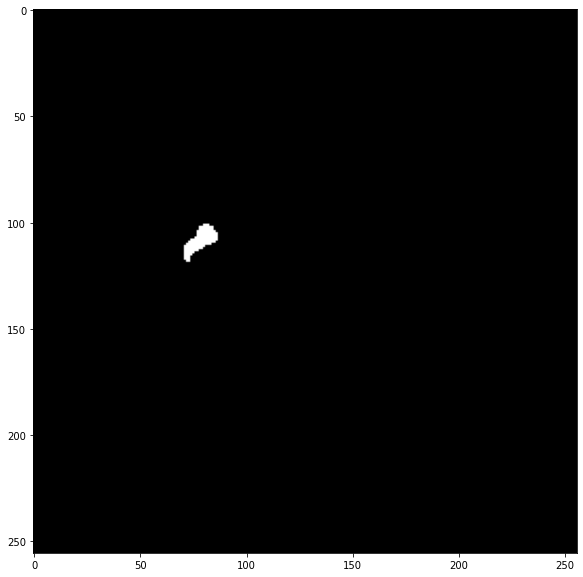

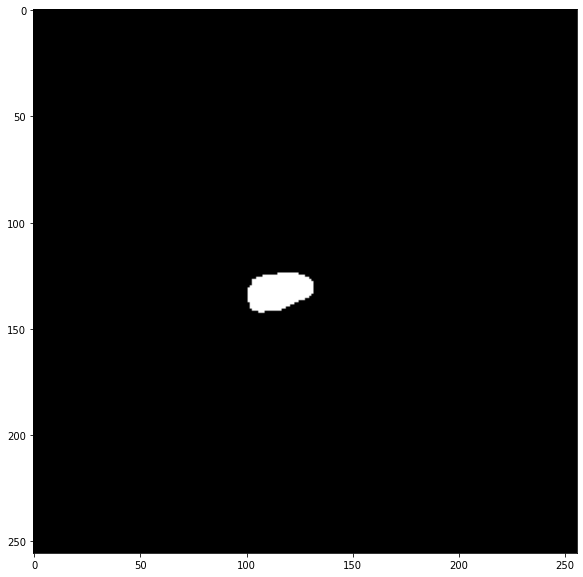

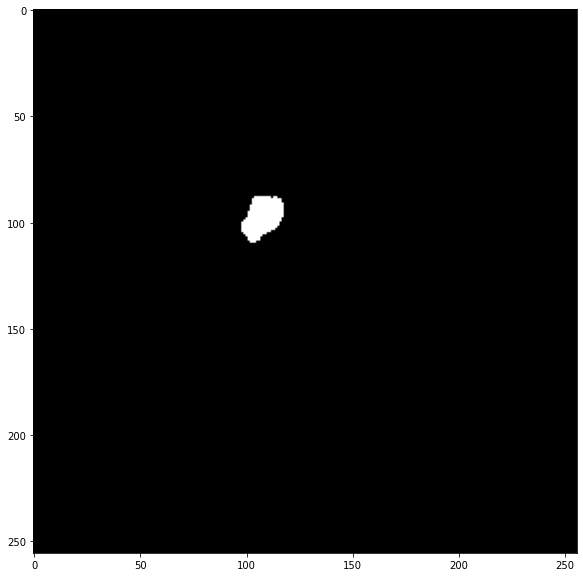

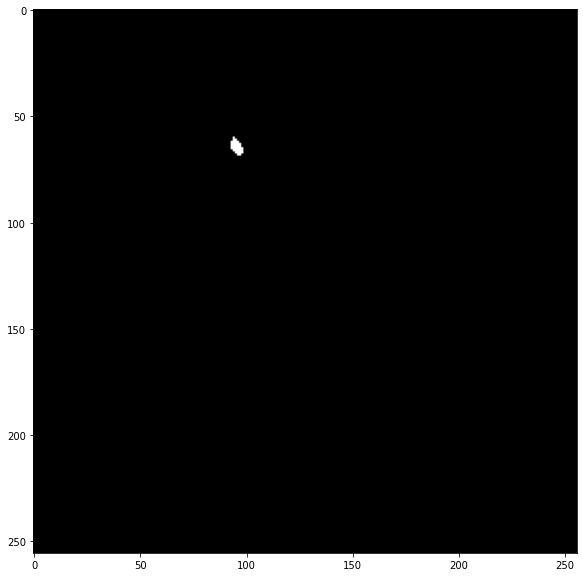

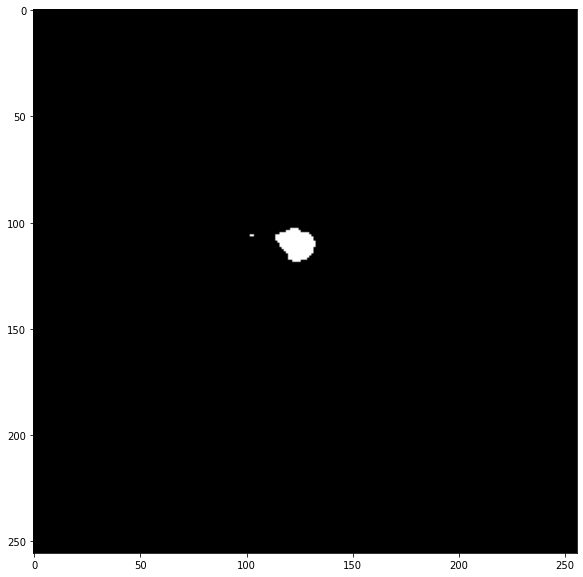

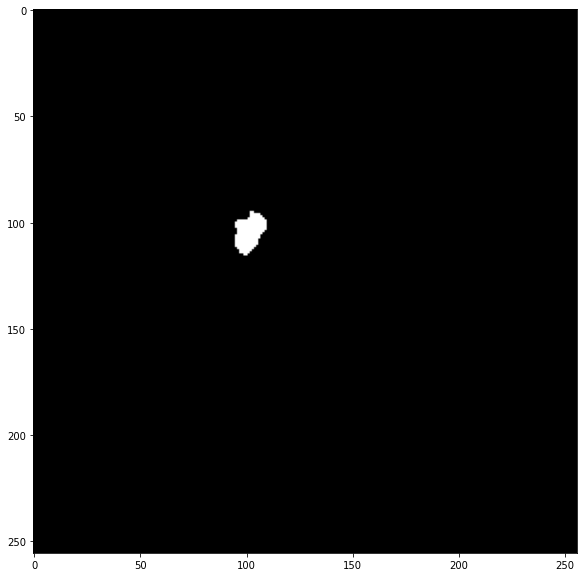

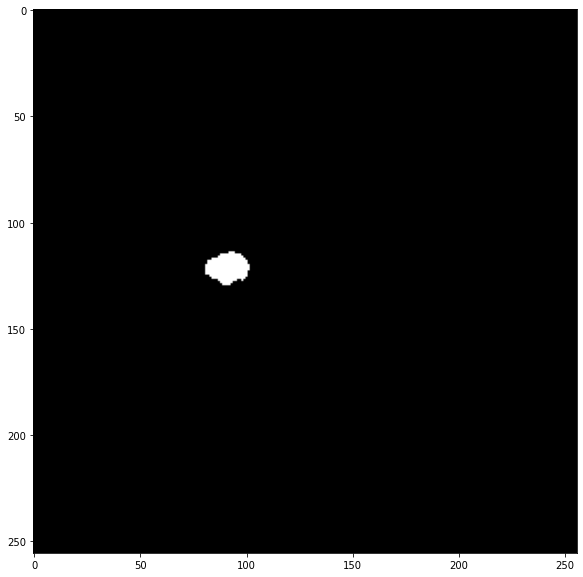

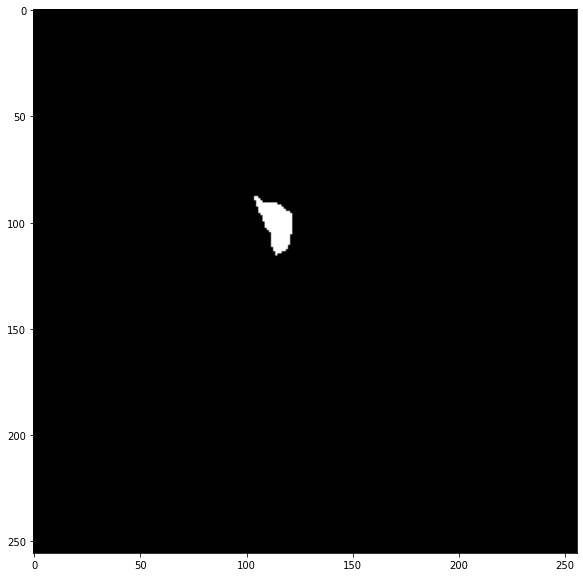

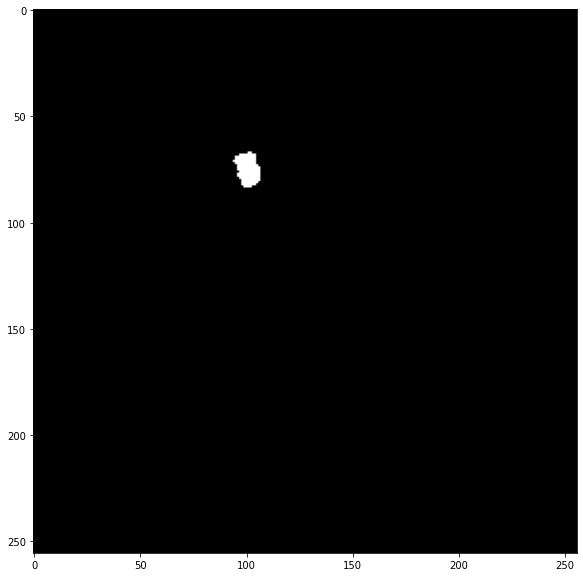

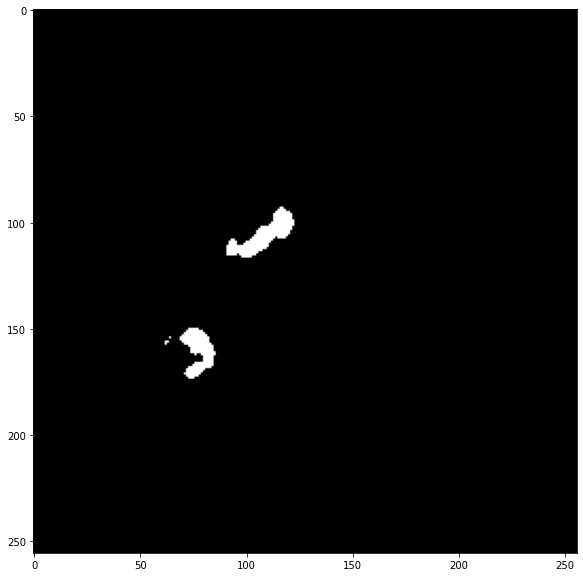

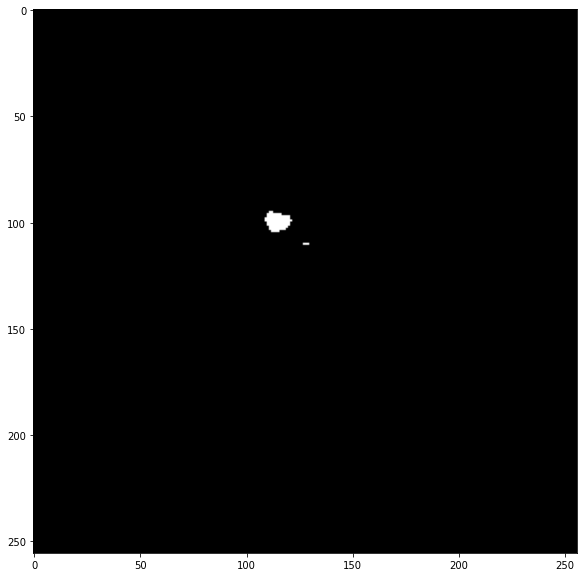

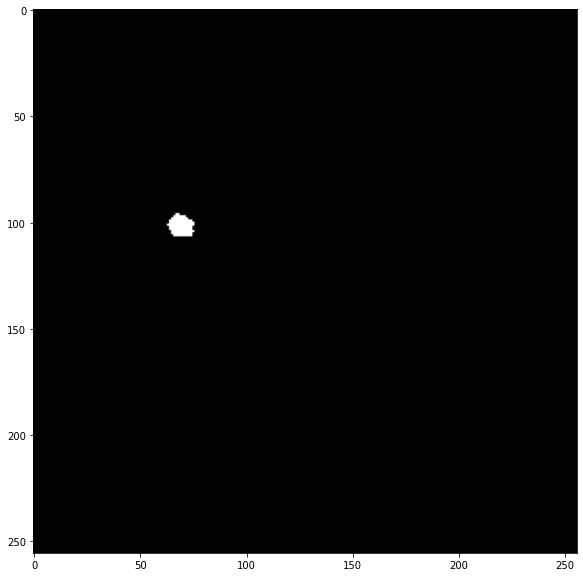

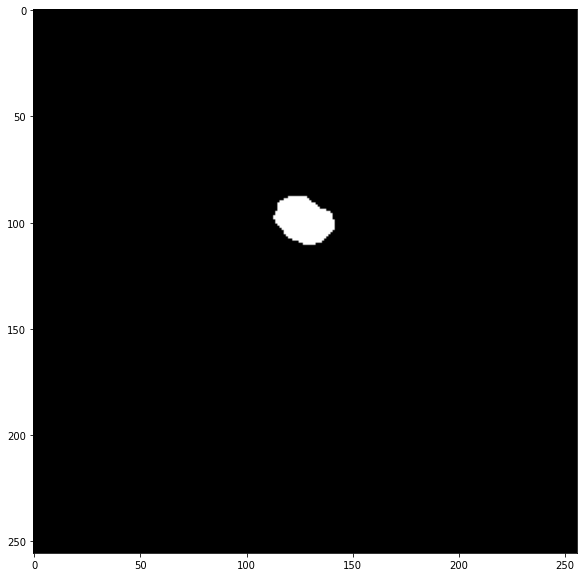

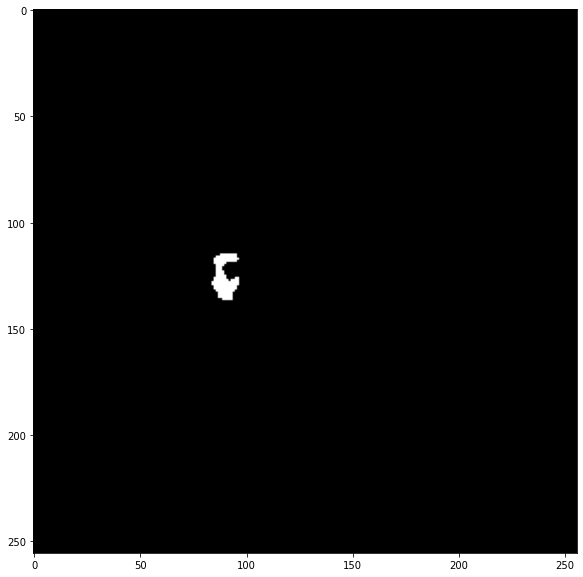

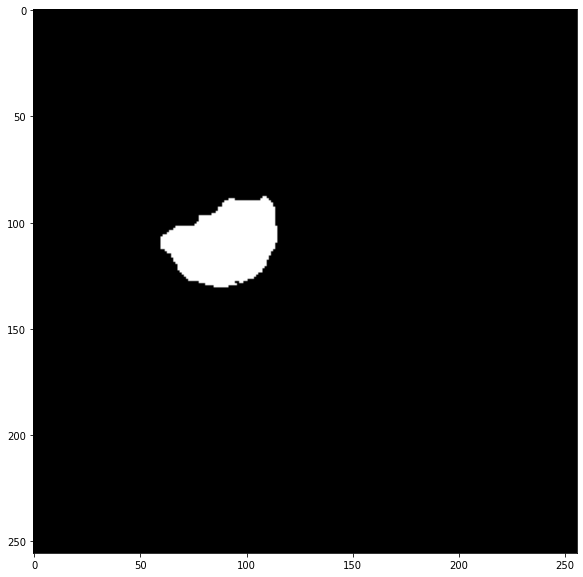

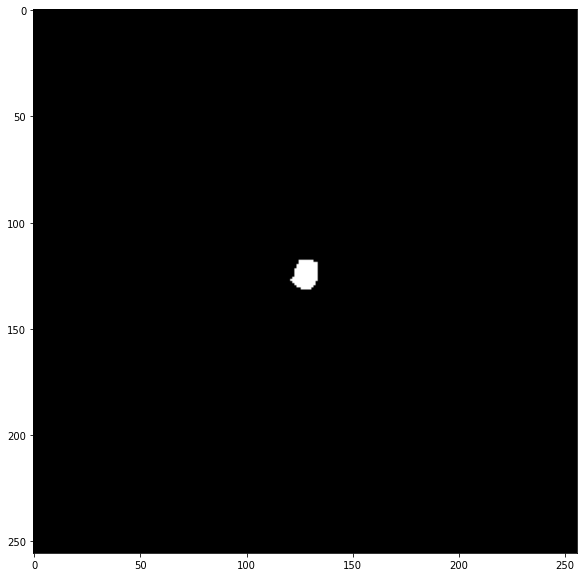

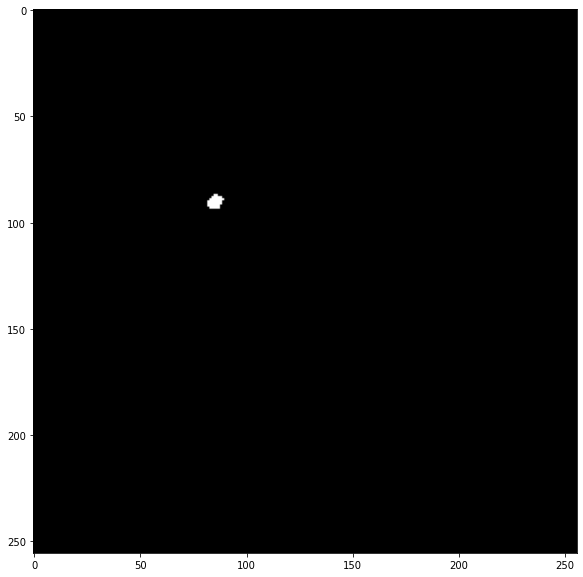

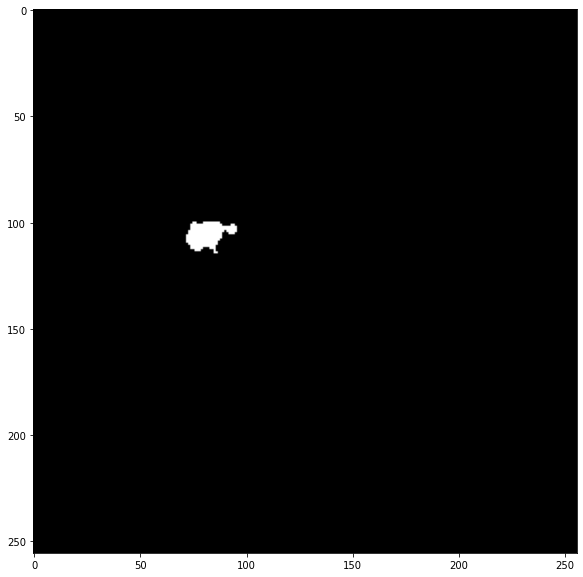

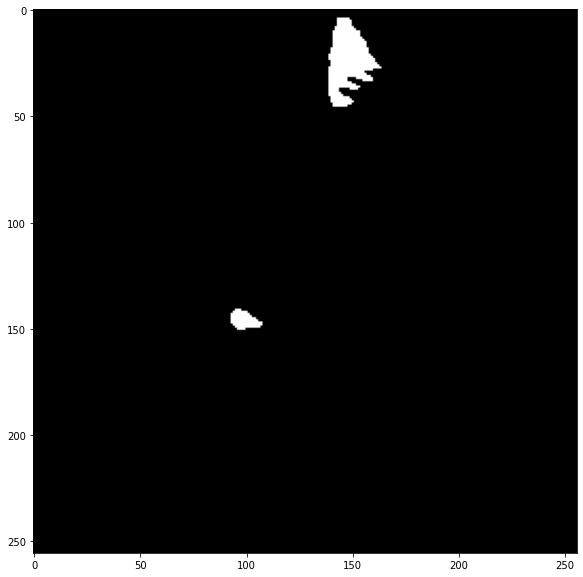

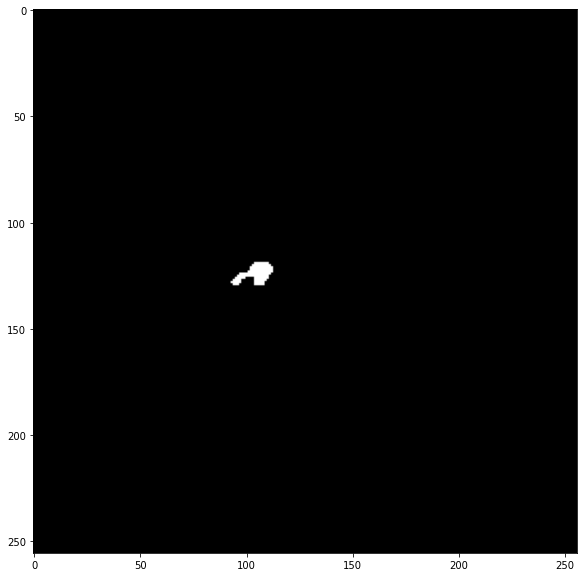

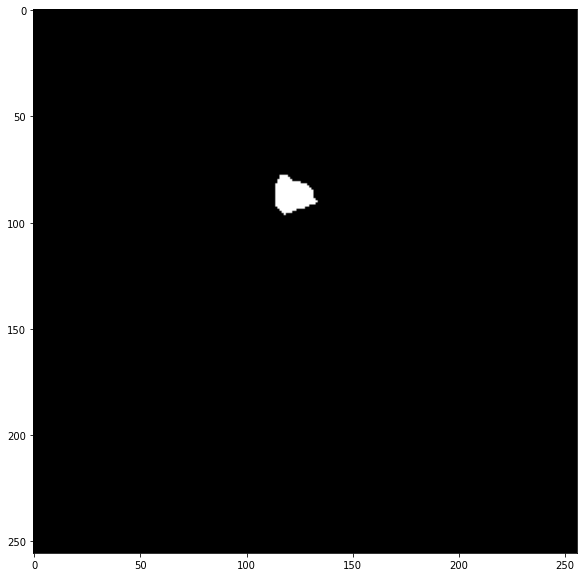

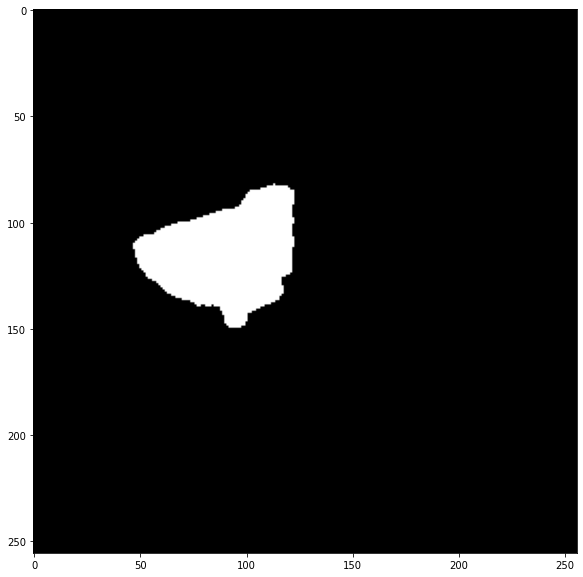

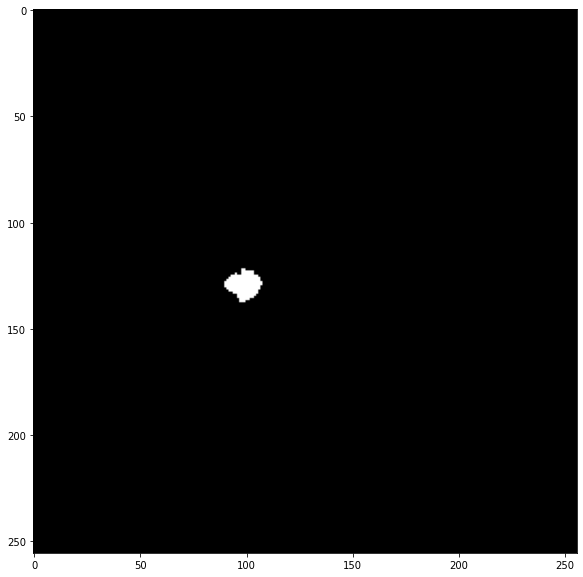

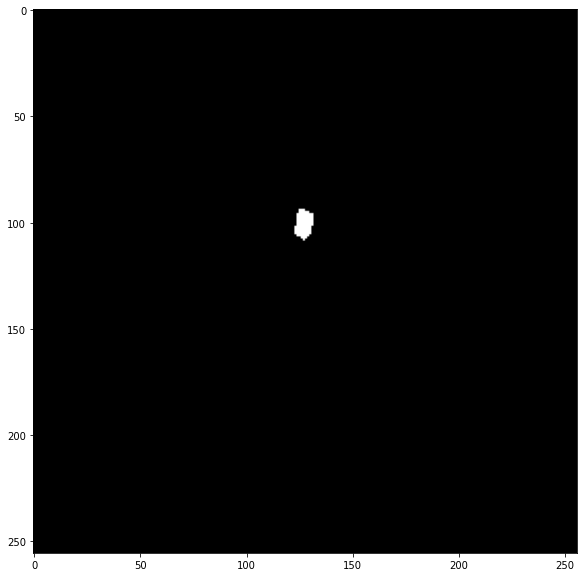

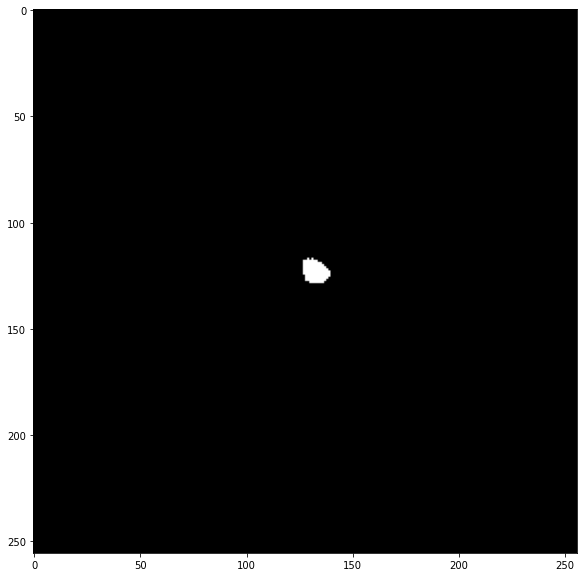

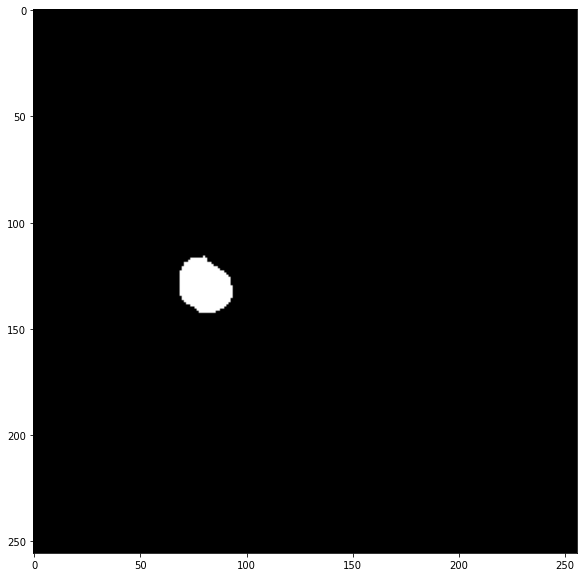

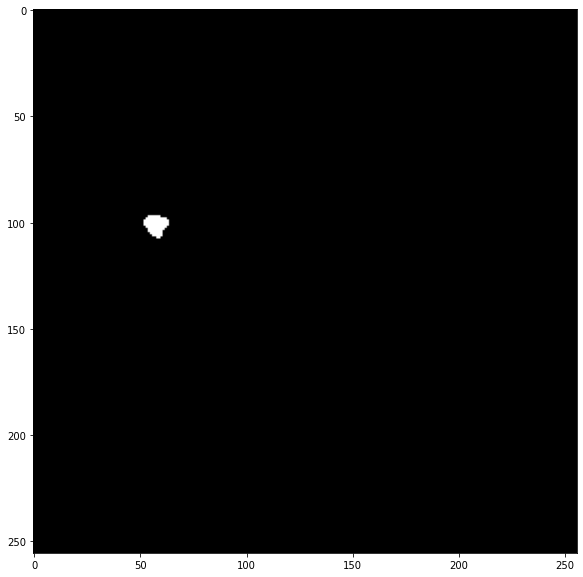

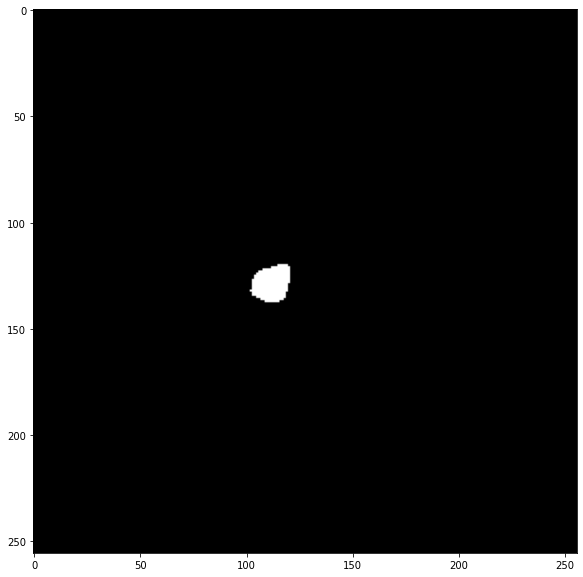

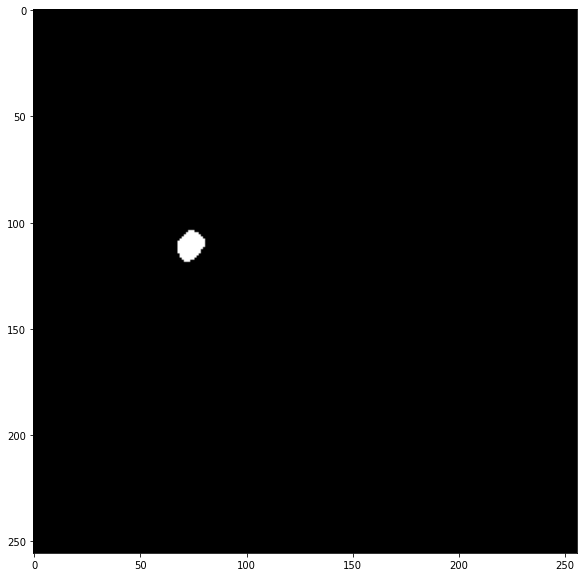

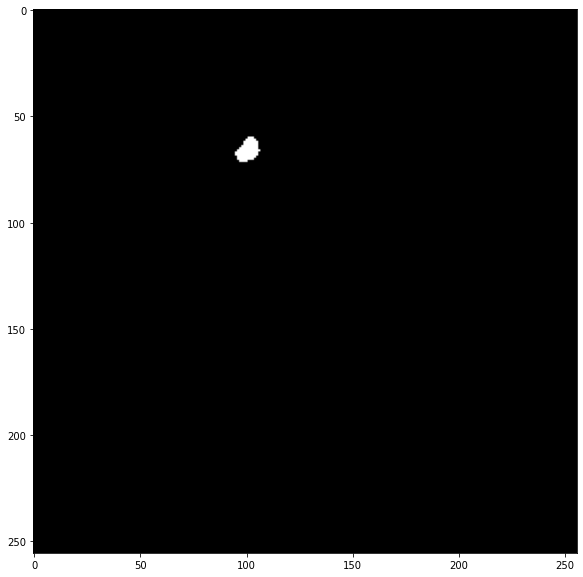

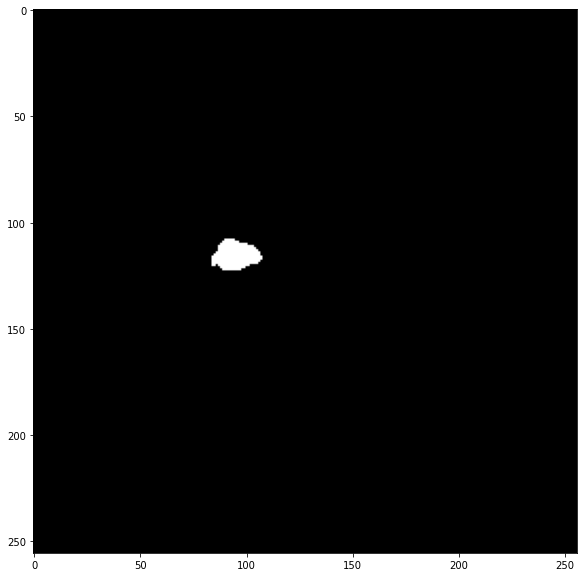

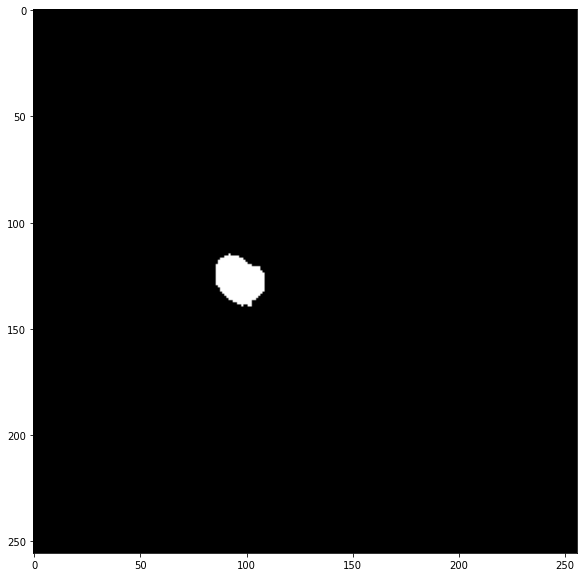

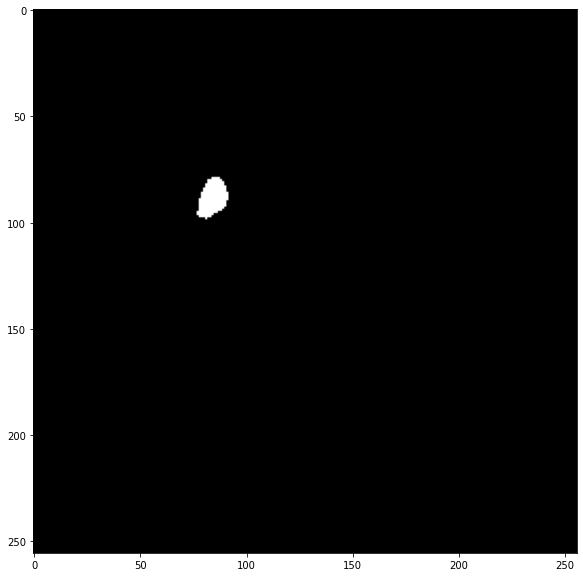

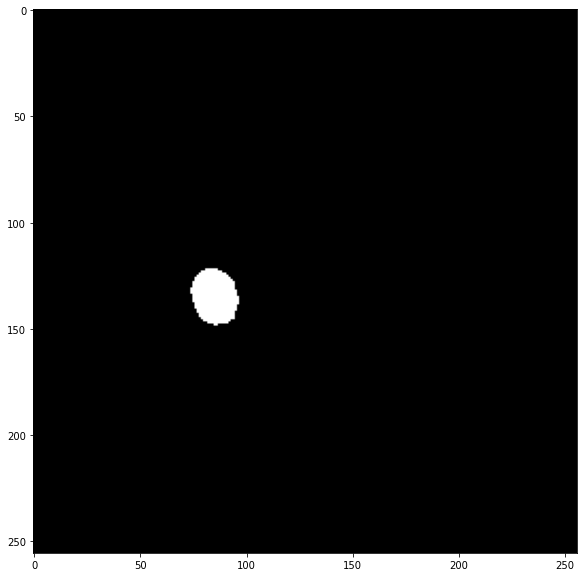

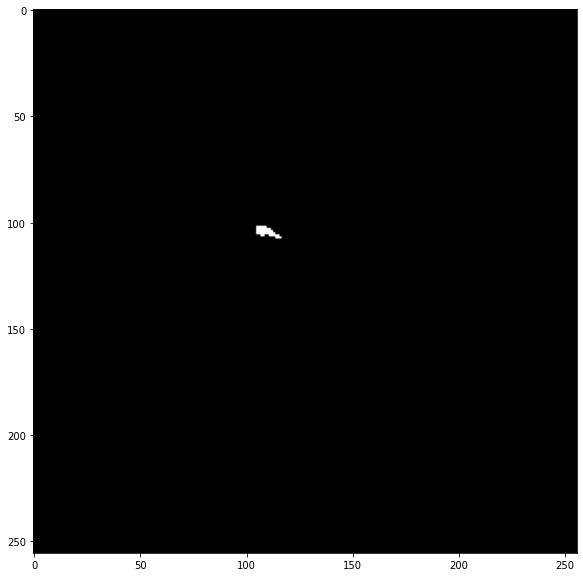

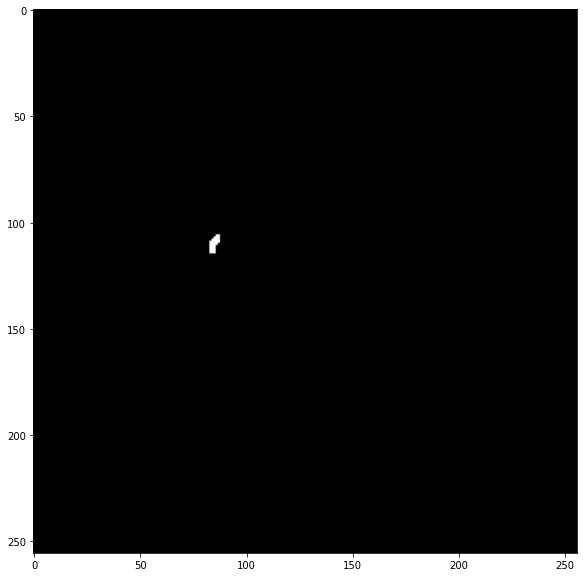

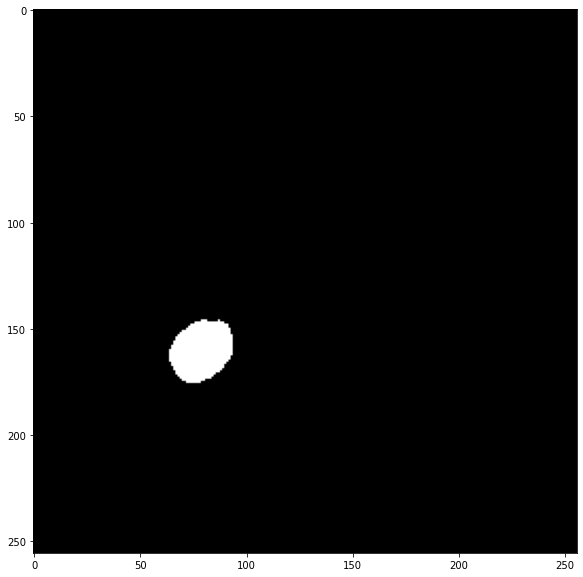

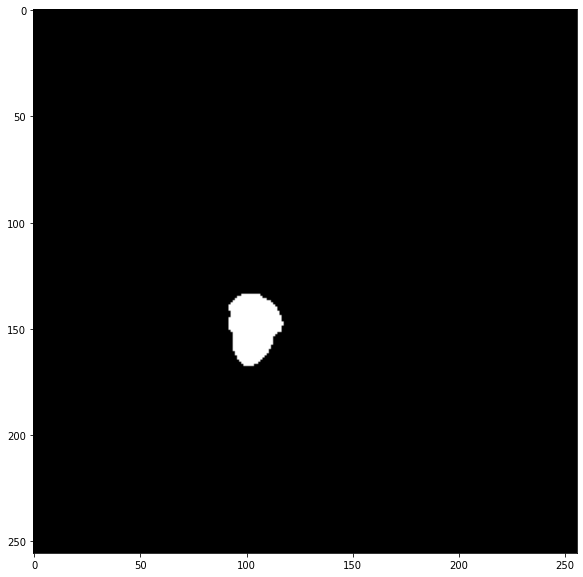

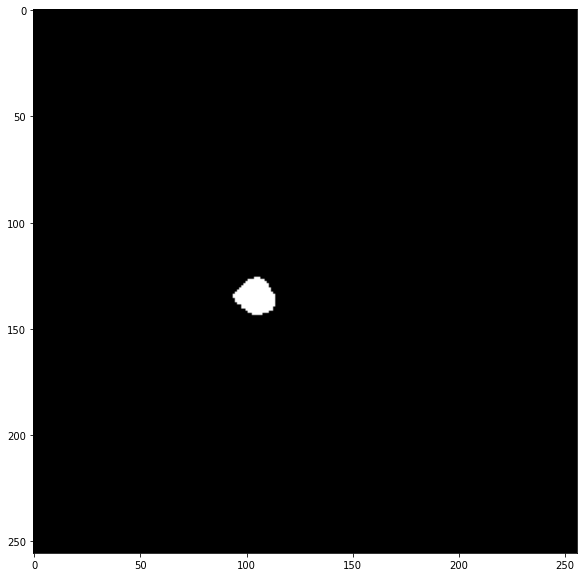

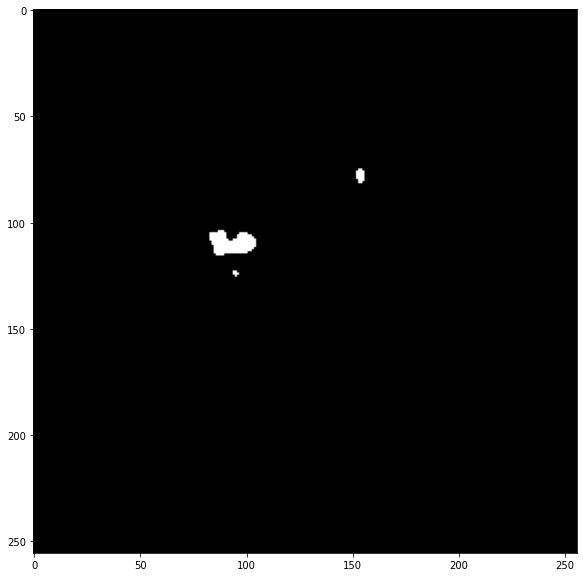

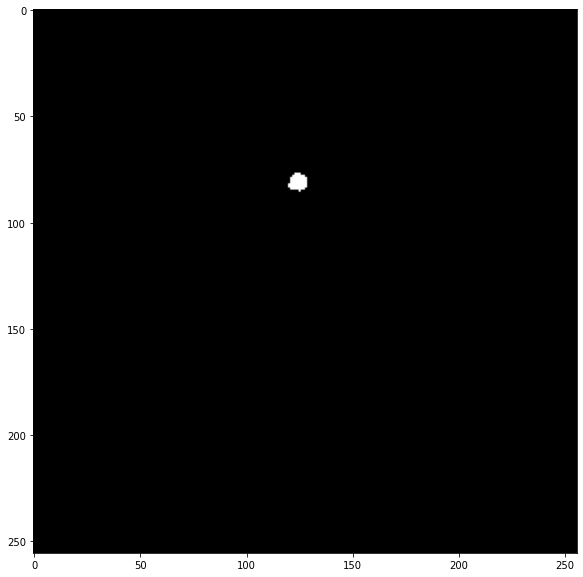

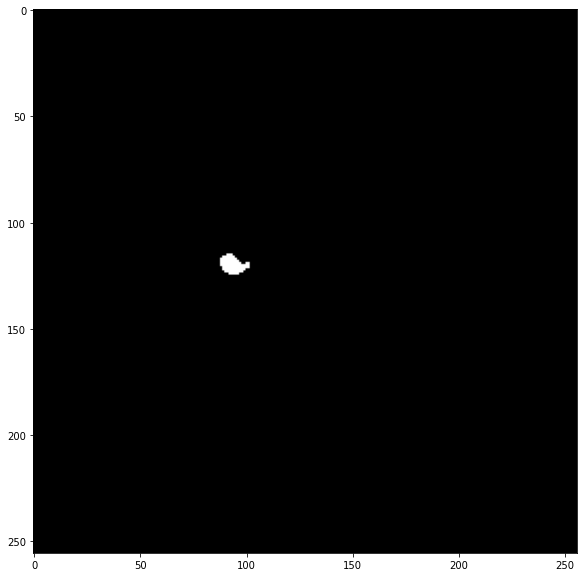

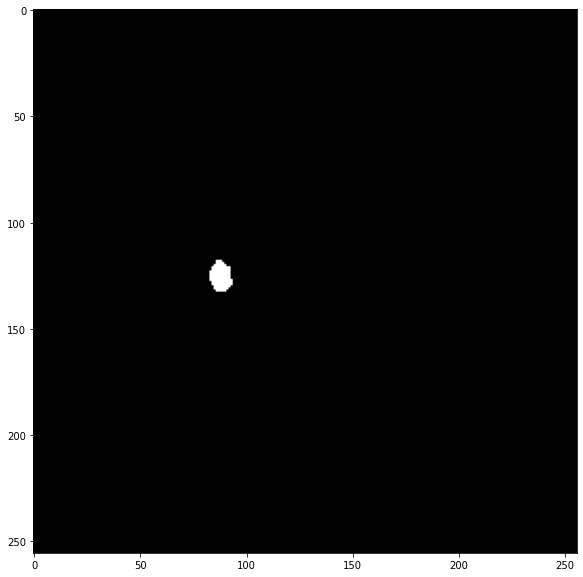

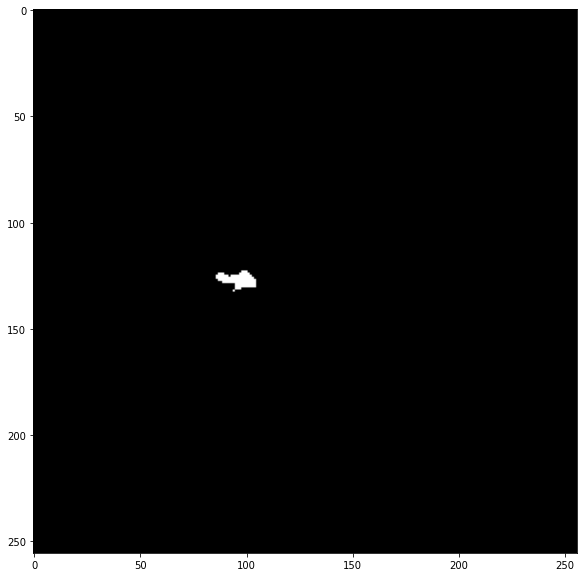

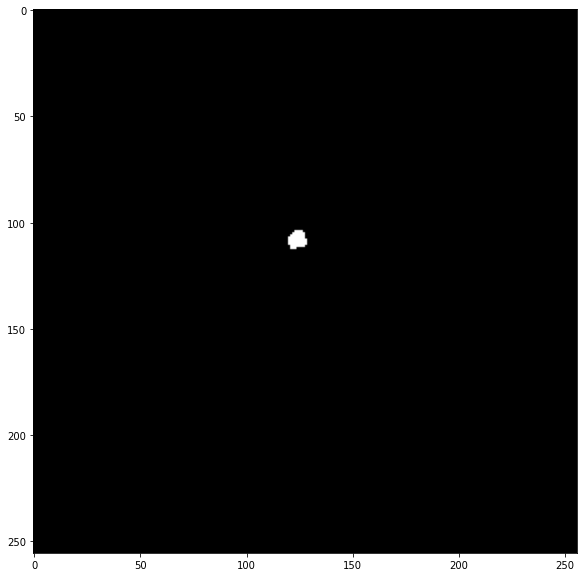

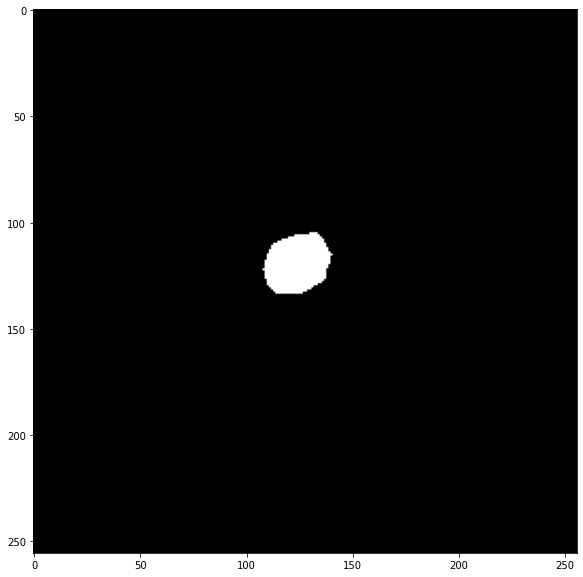

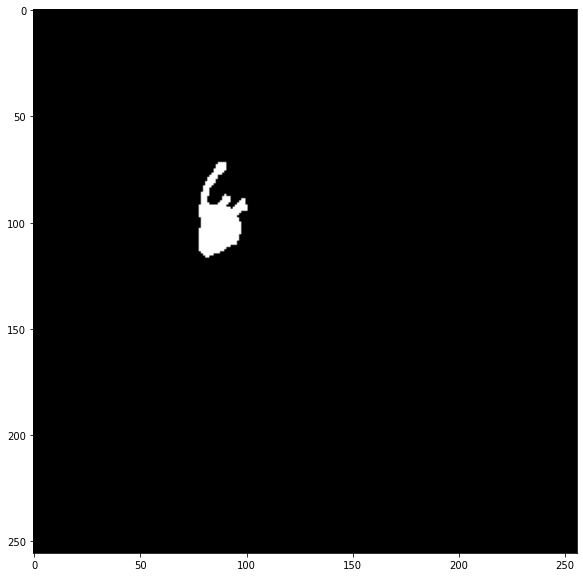

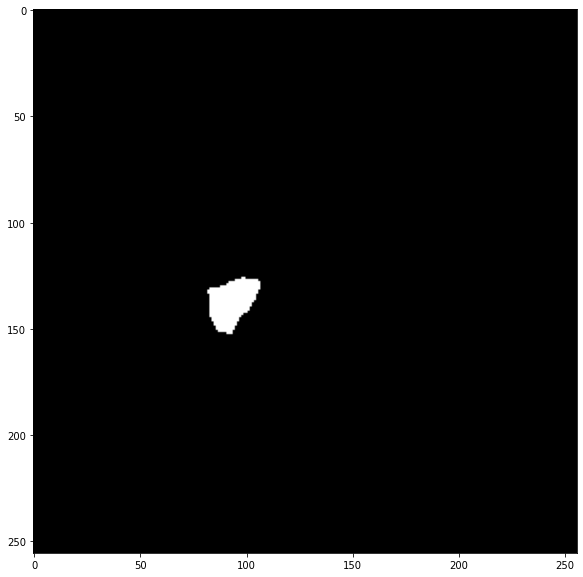

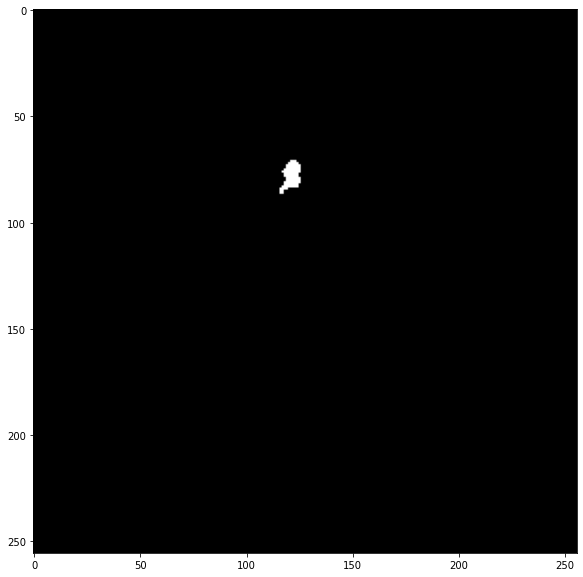

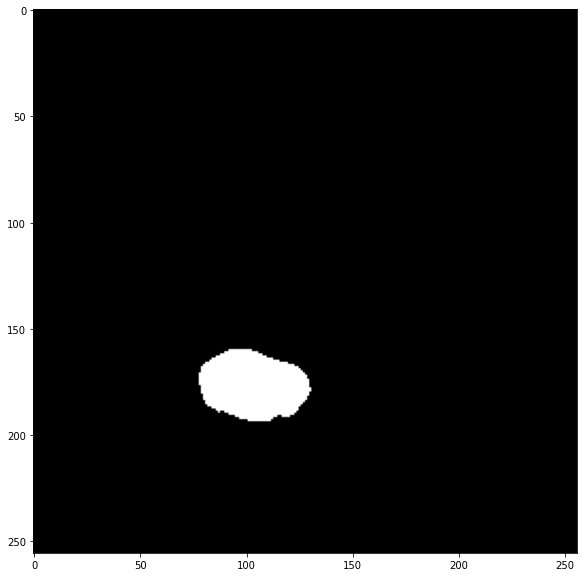

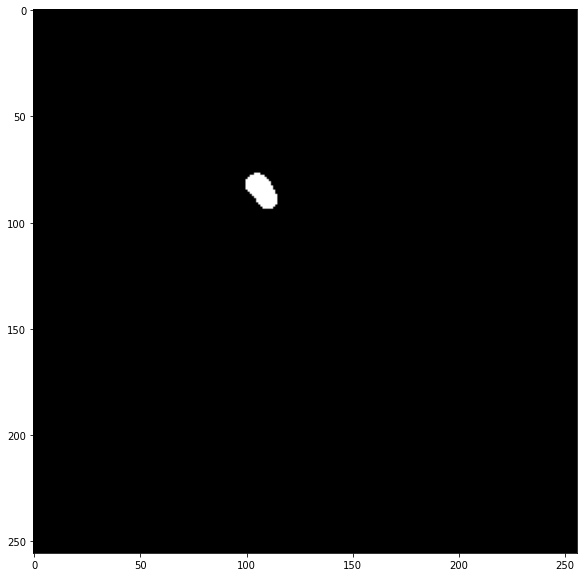

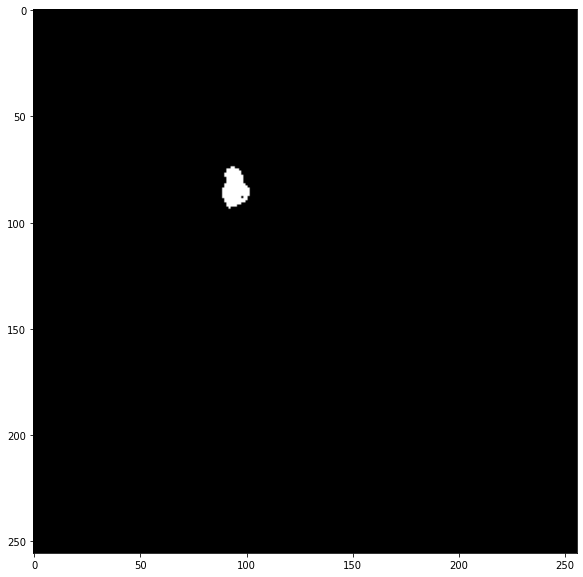

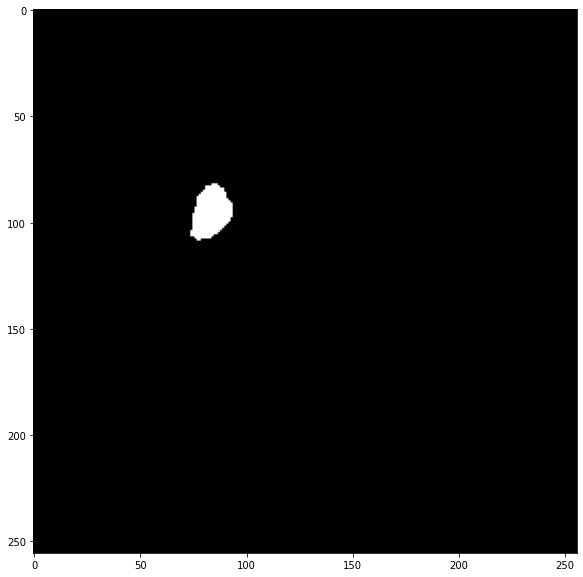

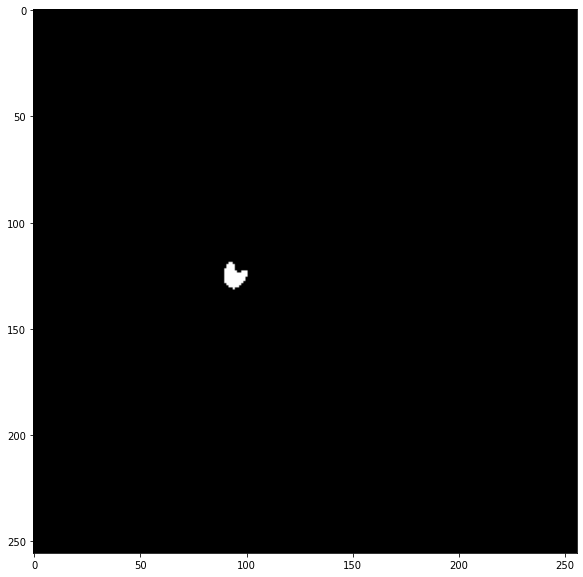

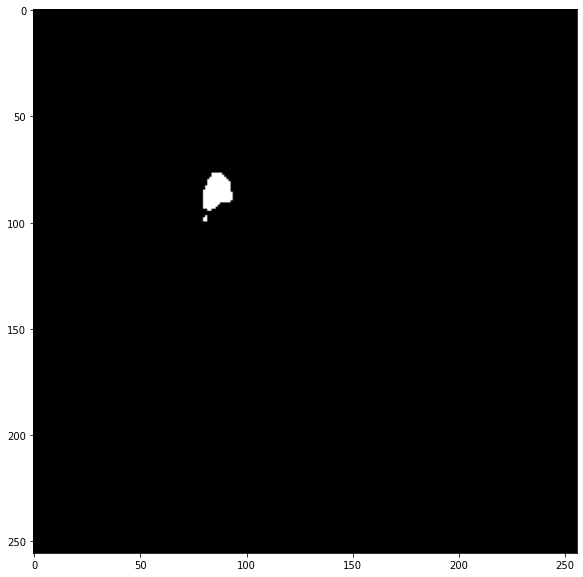

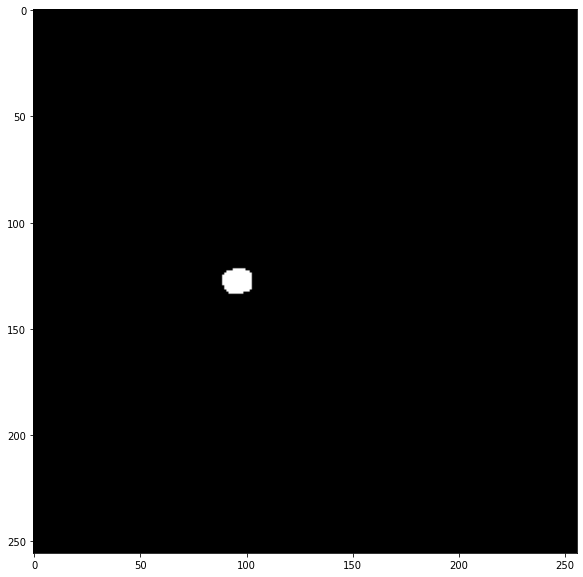

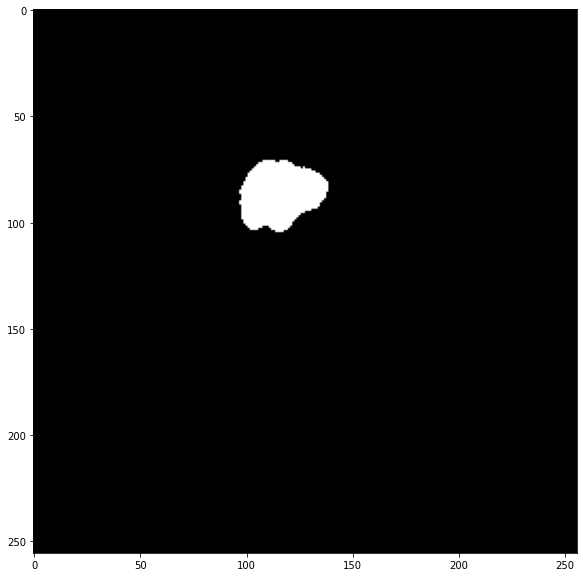

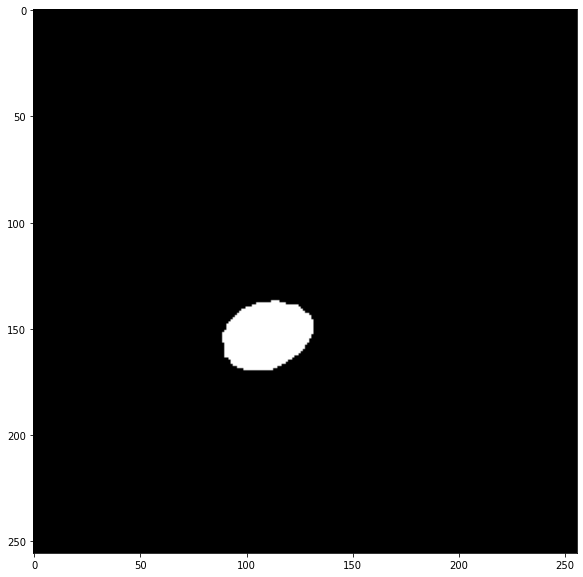

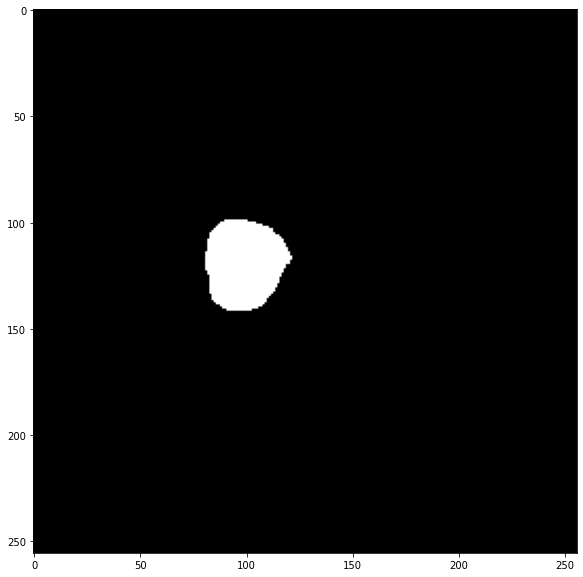

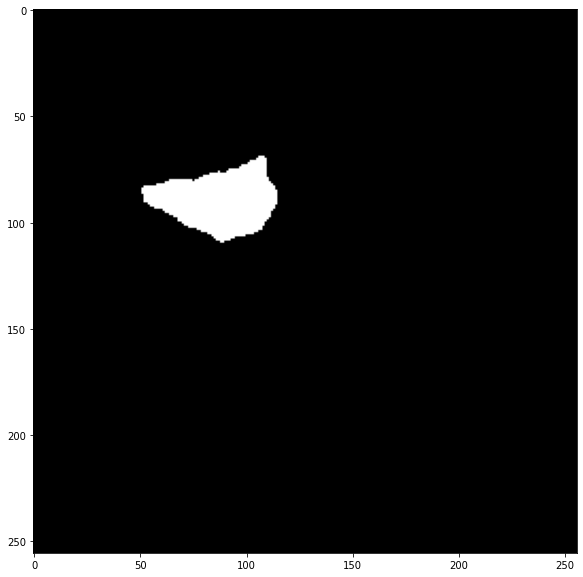

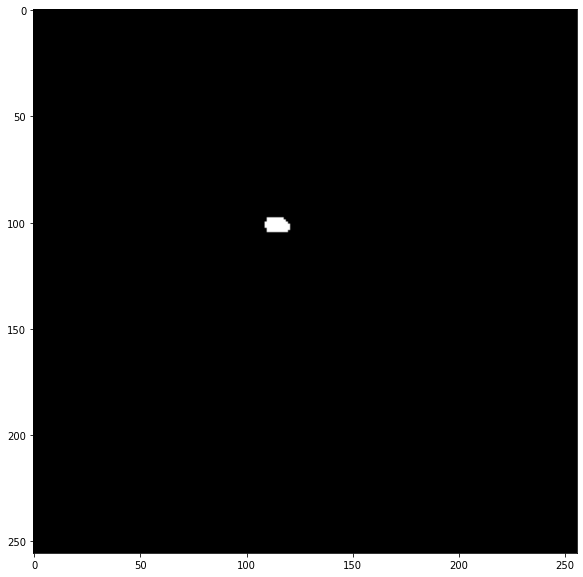

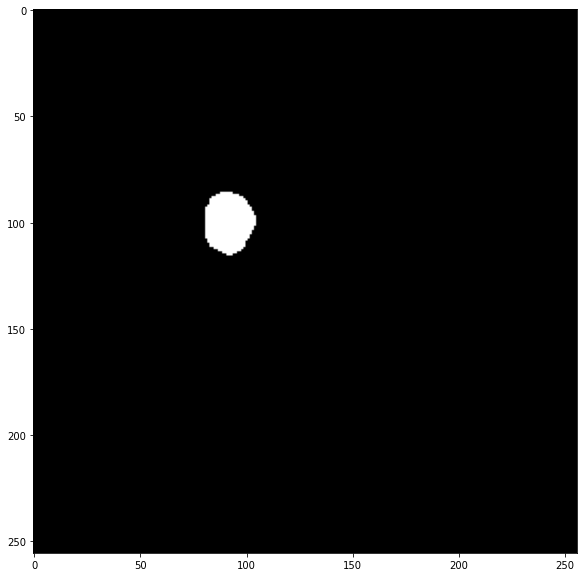

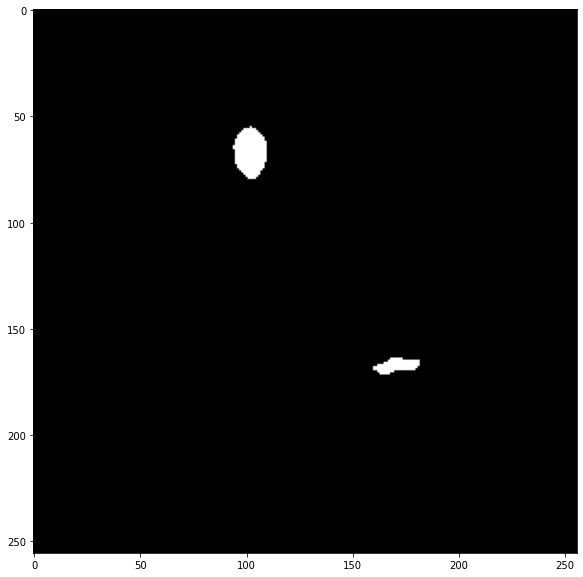

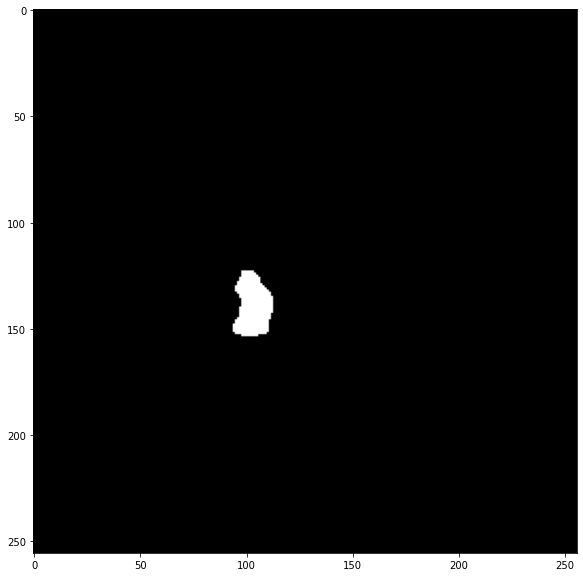

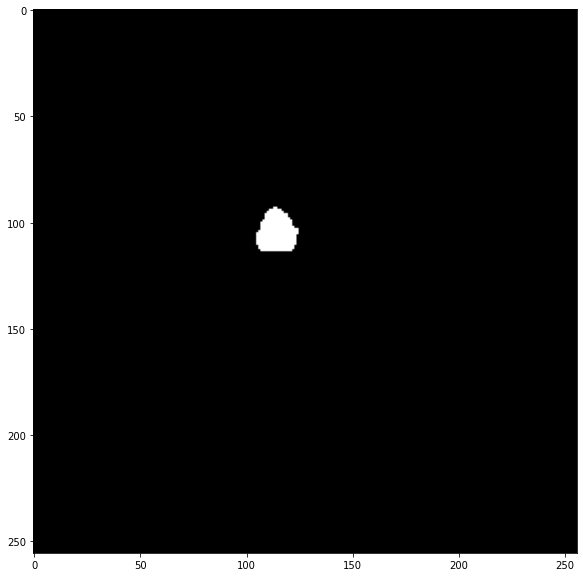

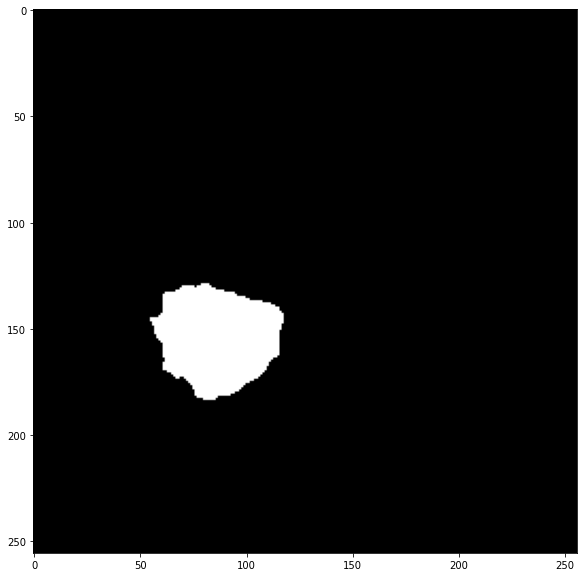

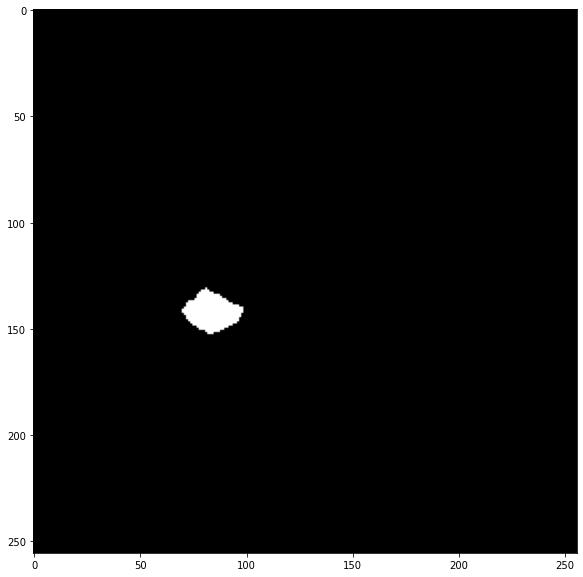

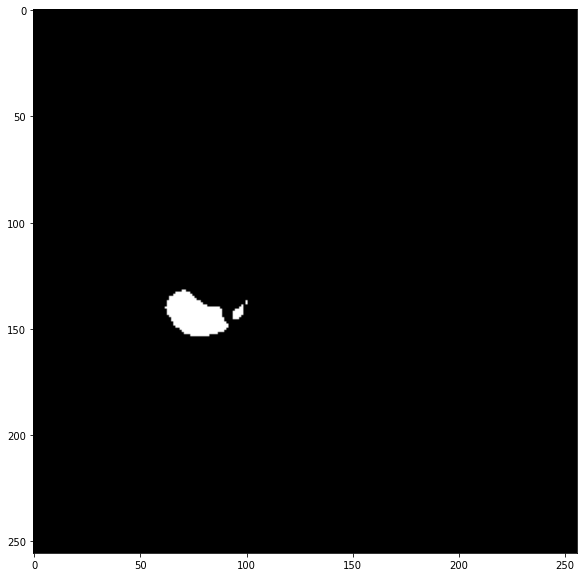

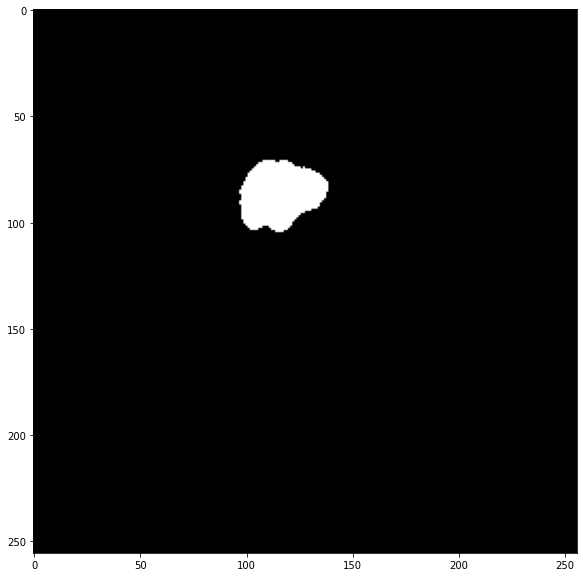

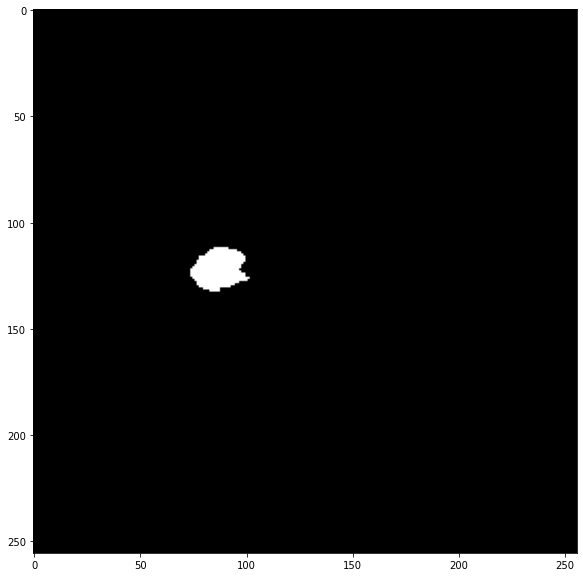

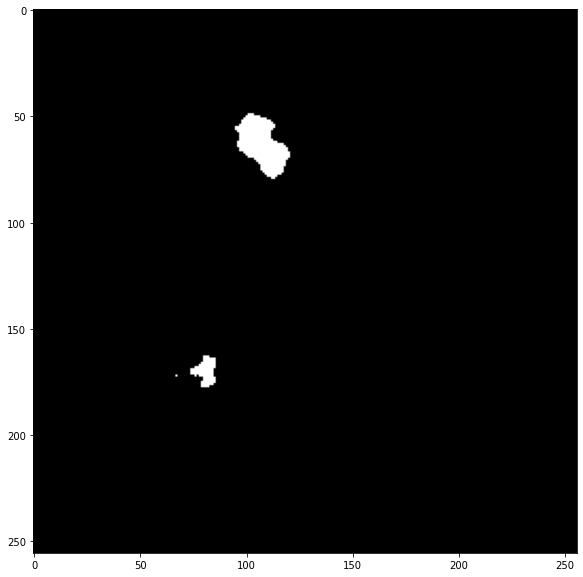

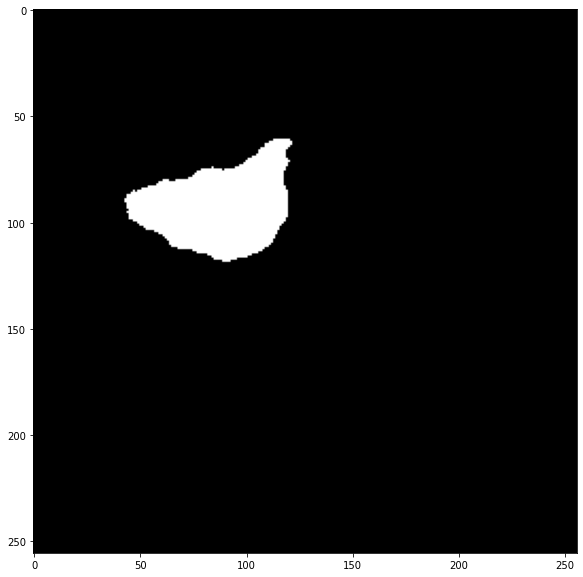

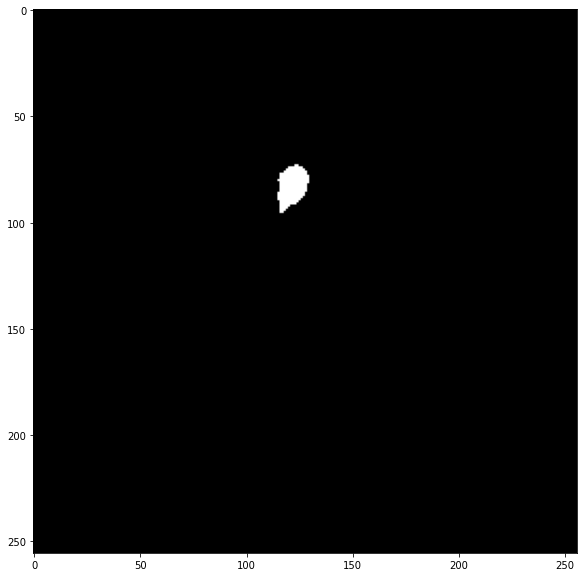

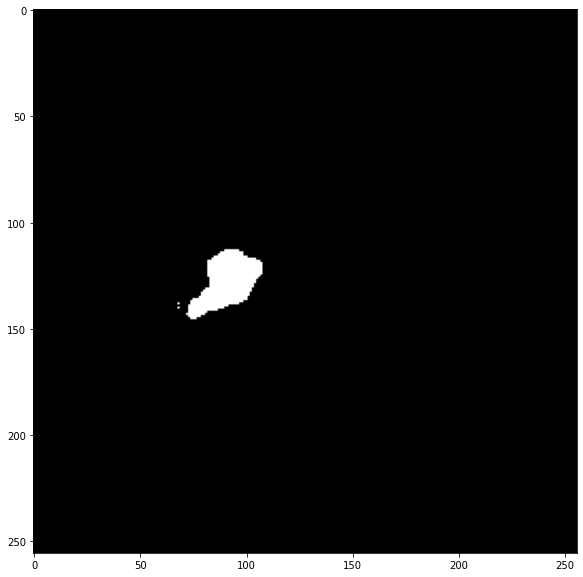

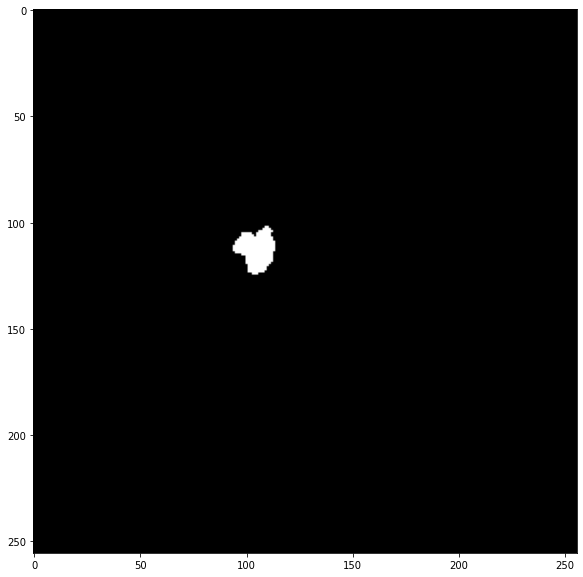

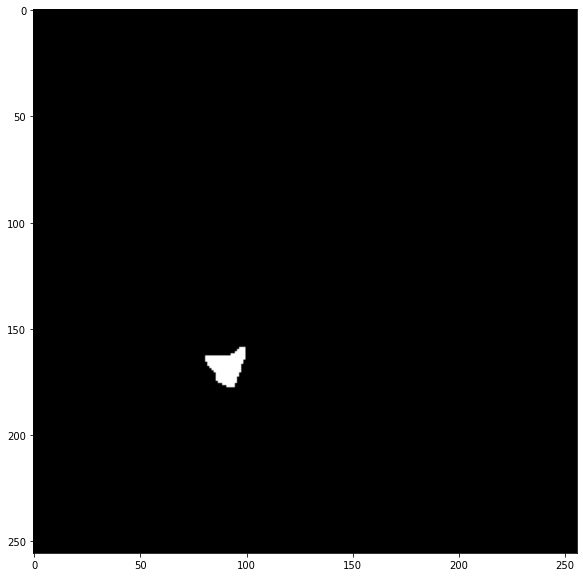

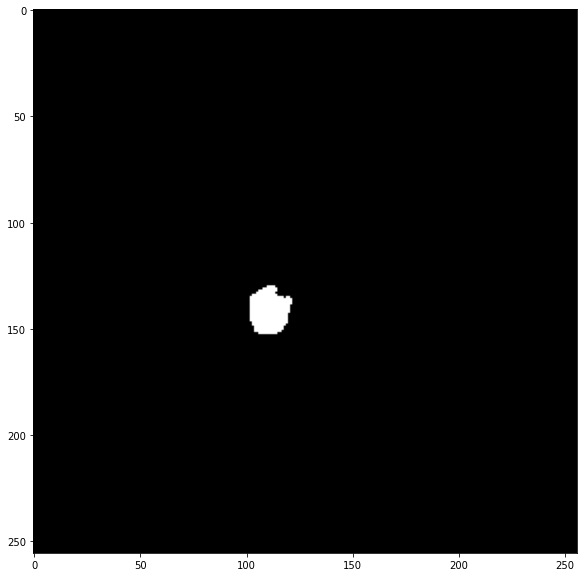

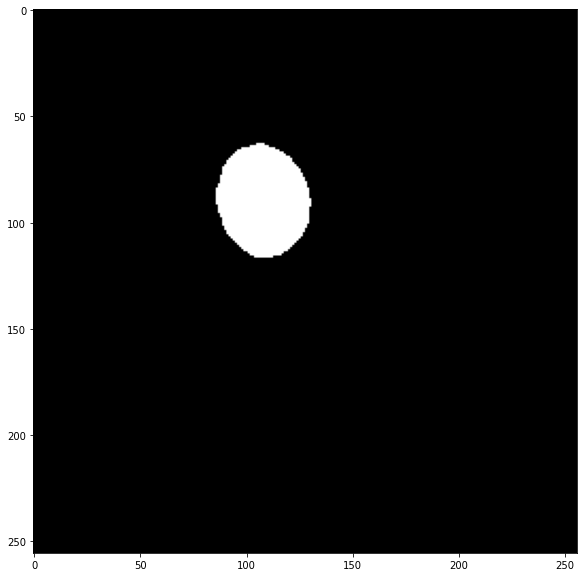

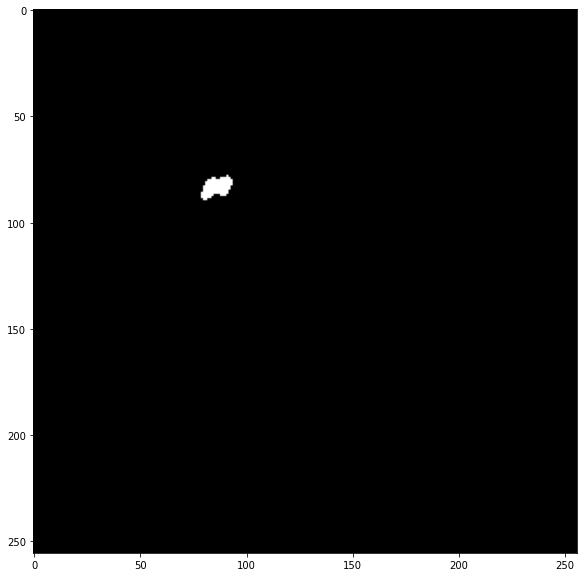

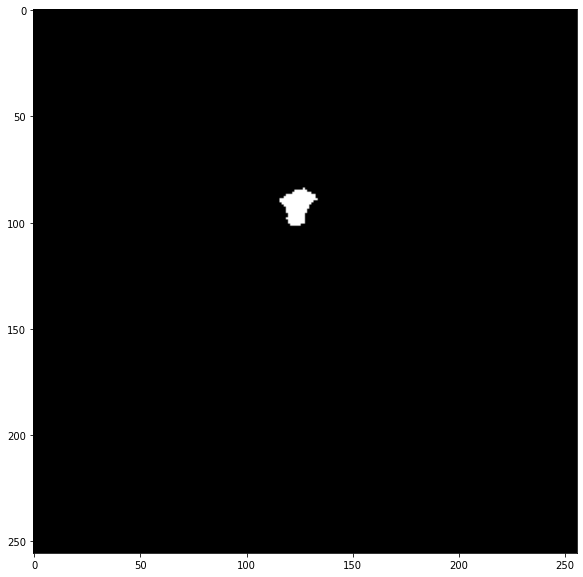

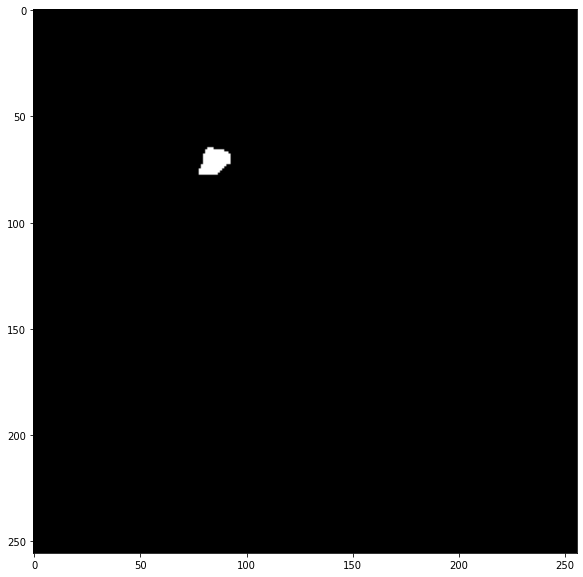

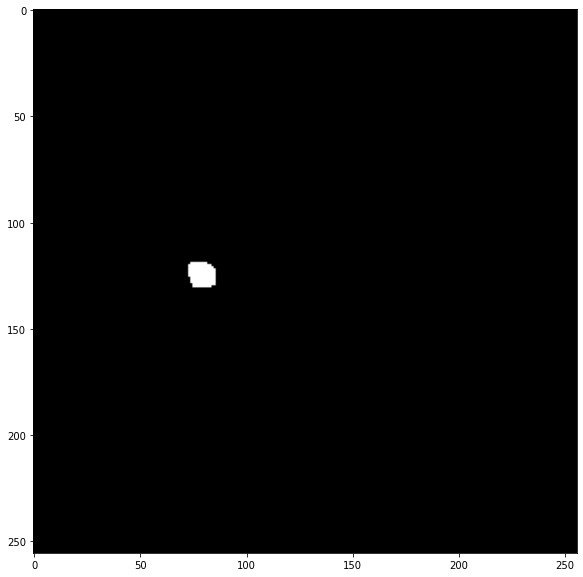

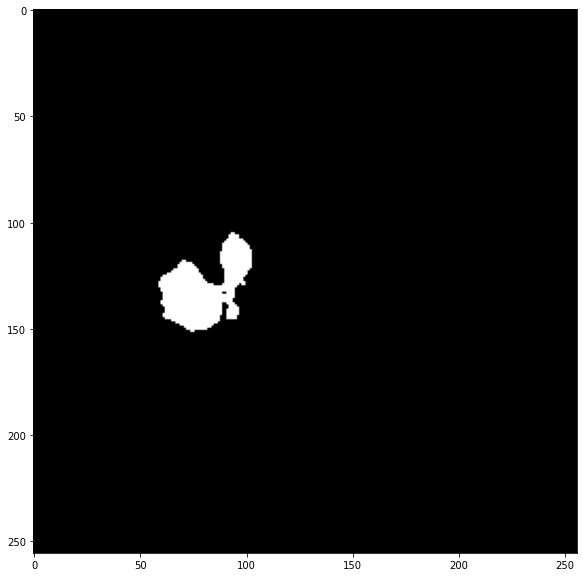

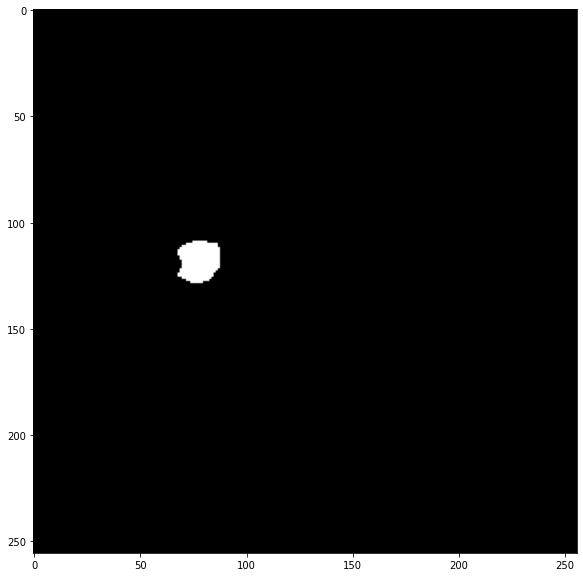

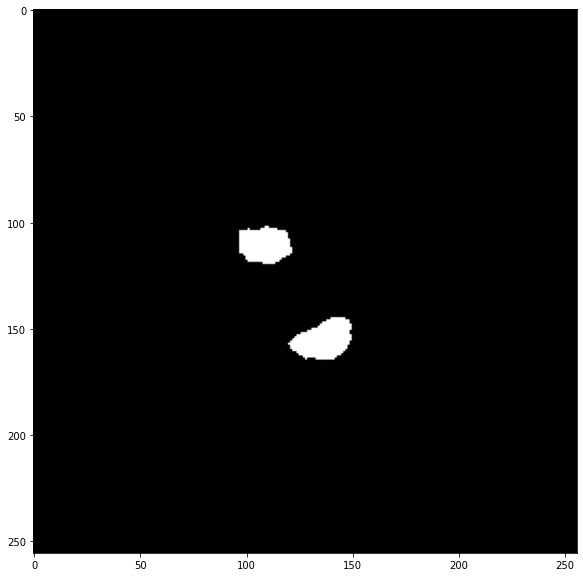

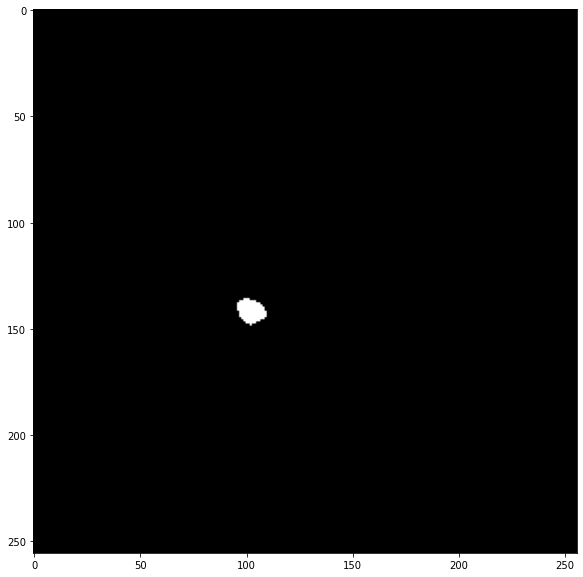

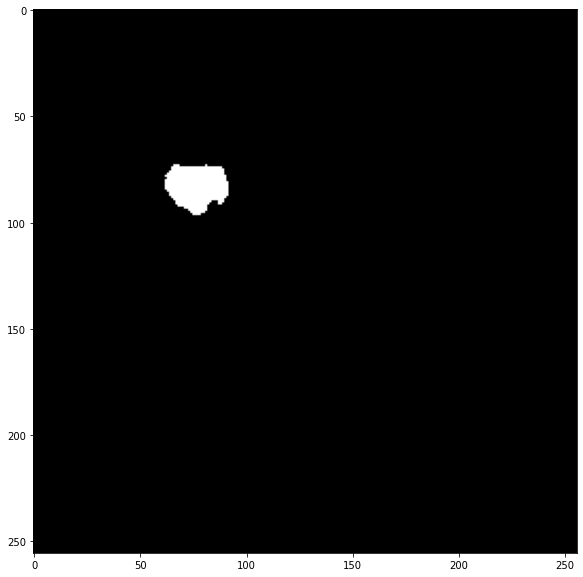

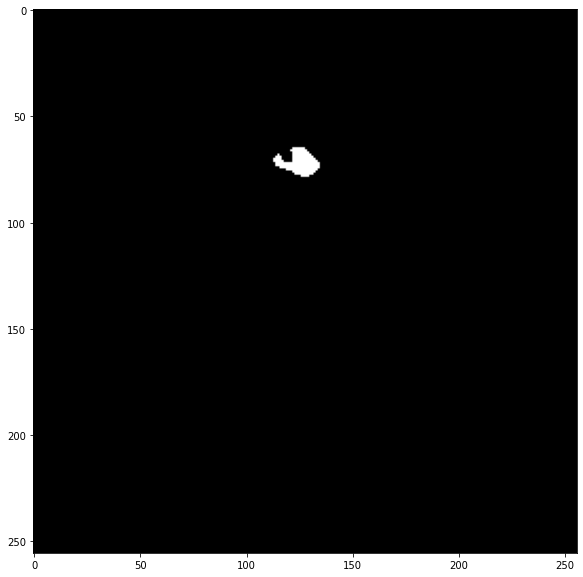

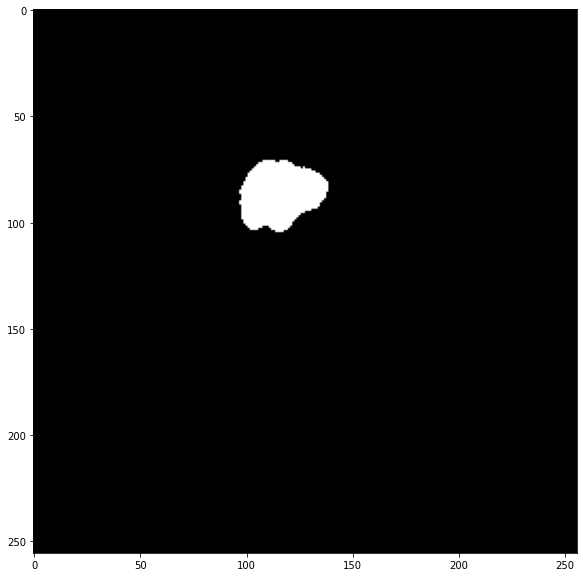

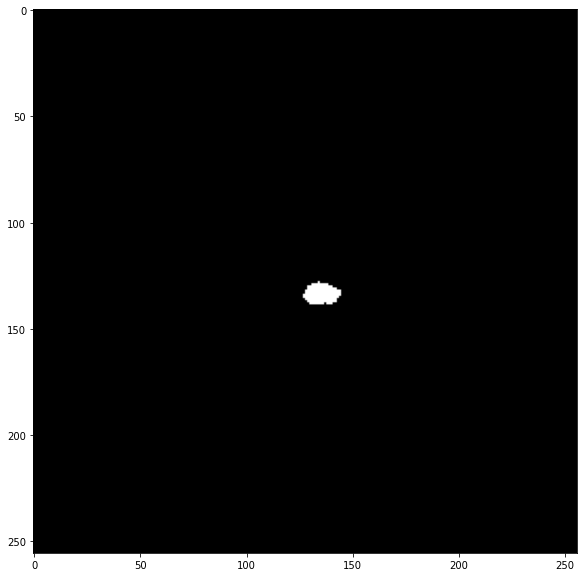

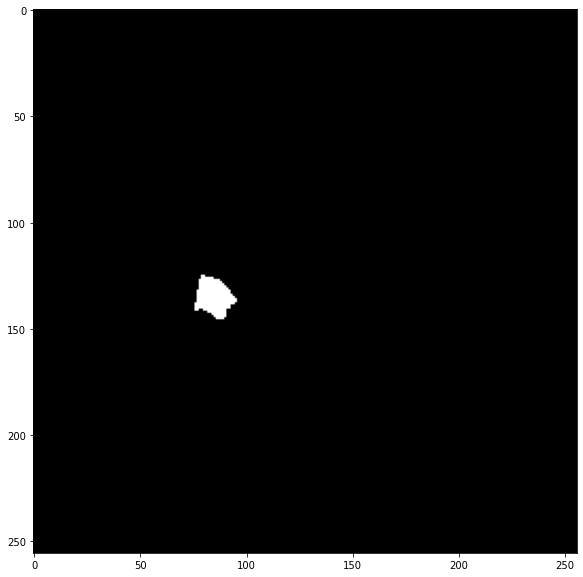

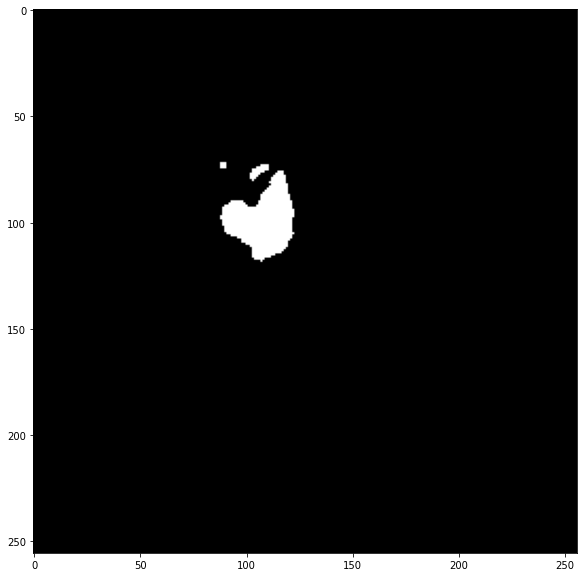

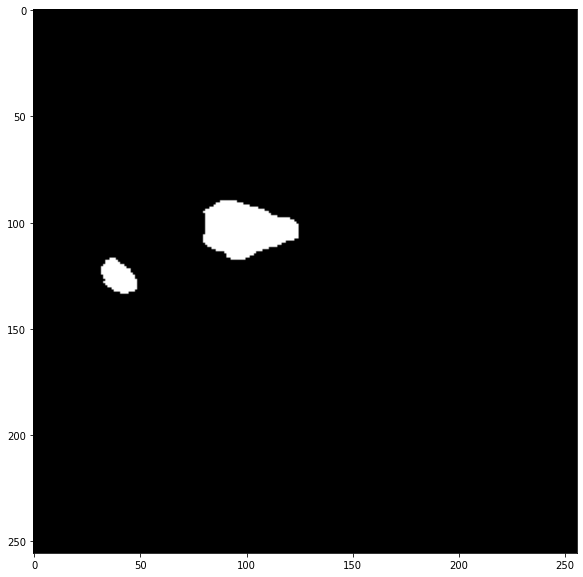

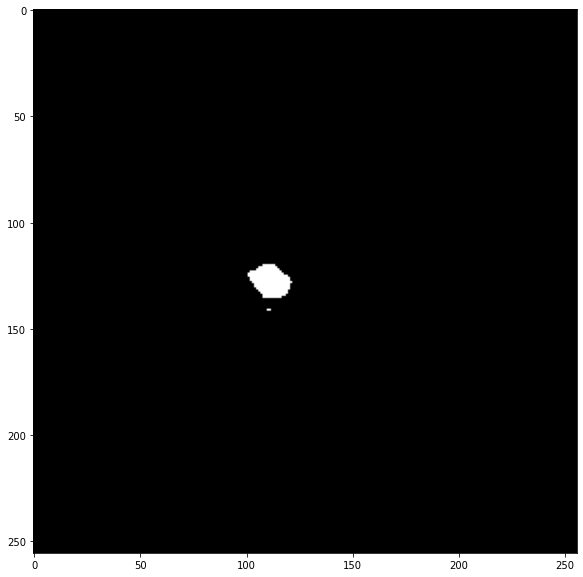

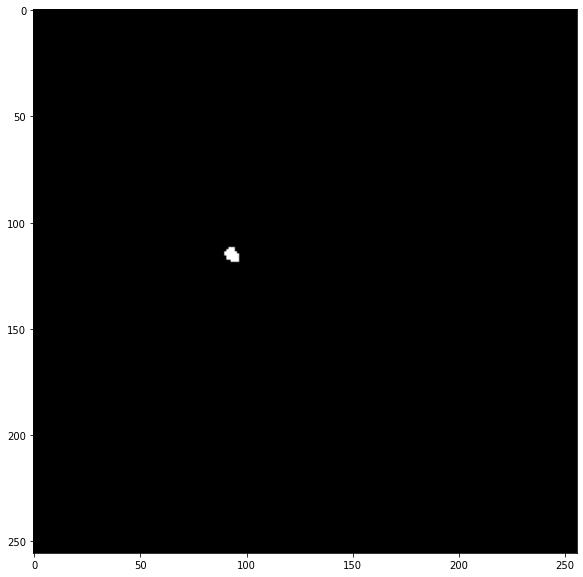

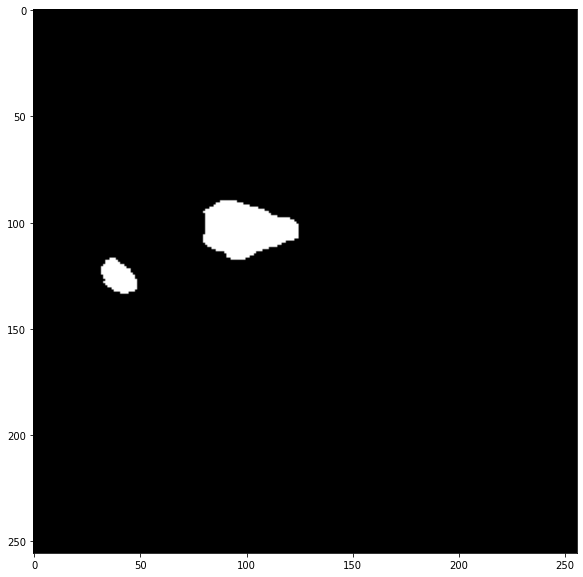

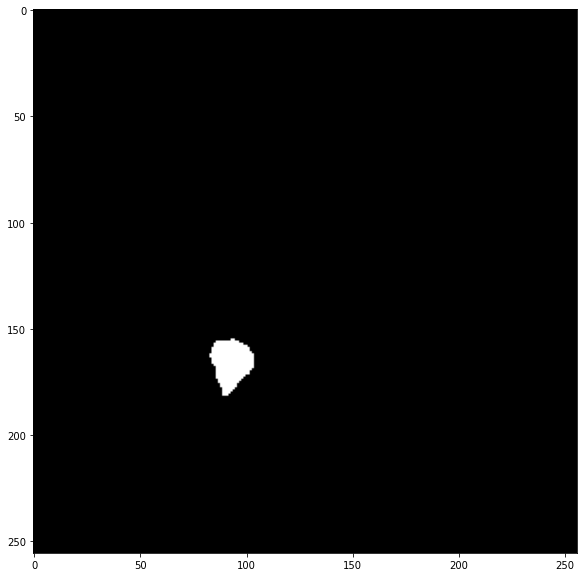

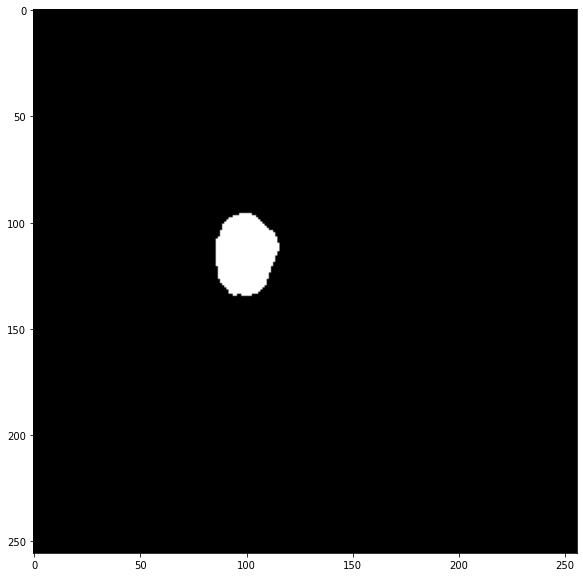

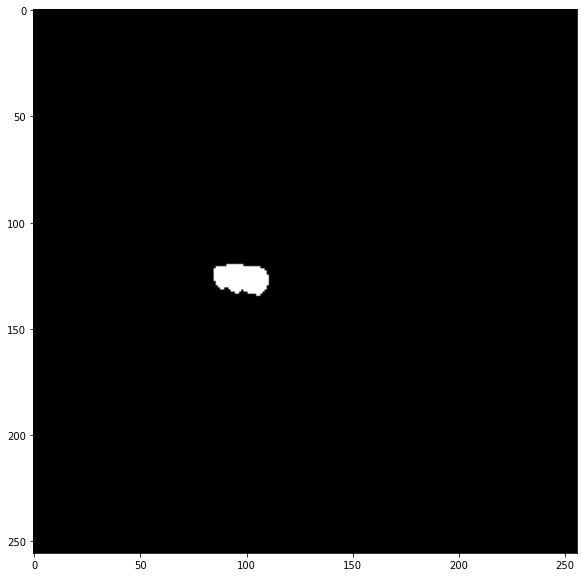

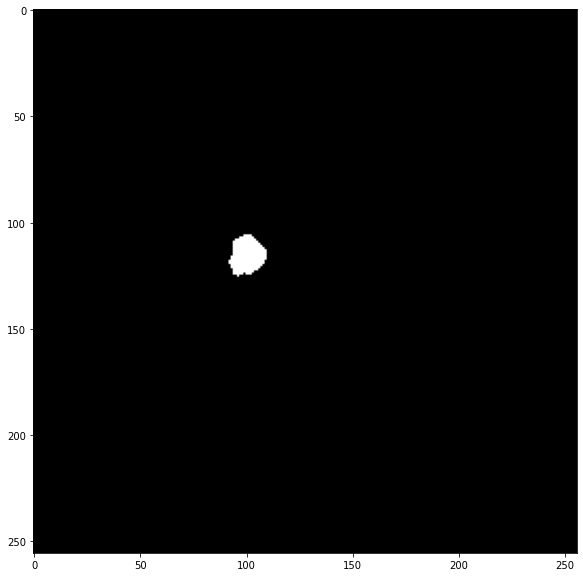

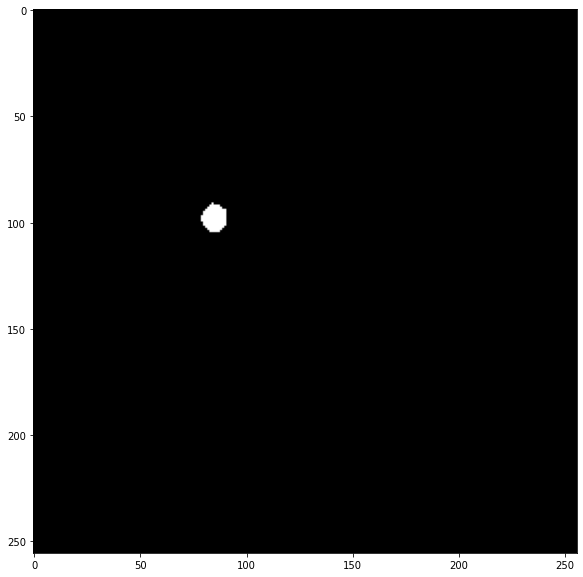

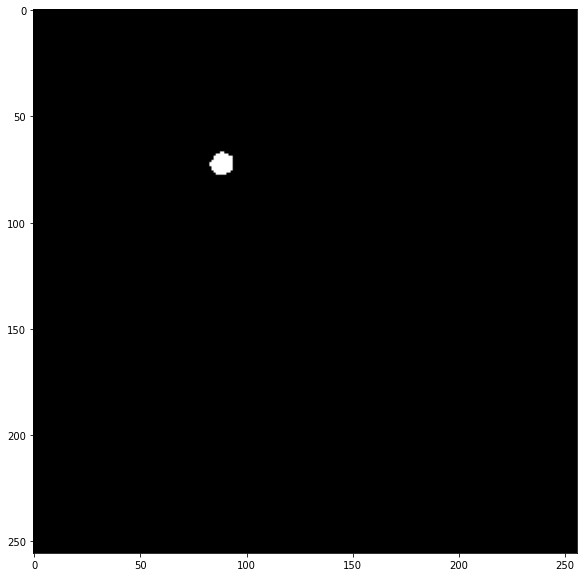

In [ ]:
# prediction of Unet
%%time
aa = 0
for image in test_dataset:
  pred_mask = model.predict(image)
  # print(pred_mask.shape)
  pred_mask[pred_mask > 0.5] = 1
  pred_mask[pred_mask <= 0.5] = 0
  pred_mask = pred_mask.squeeze()
  pred_mask = pred_mask[..., tf.newaxis]
  for i in range(10):
    # print(i)
    # print(test_image[aa][35:])
    plt.figure(figsize=(10, 10))
    plt.imshow(tf.keras.preprocessing.image.array_to_img(tf.image.grayscale_to_rgb(tf.convert_to_tensor(pred_mask[i]))))
    plt.savefig('./Colab Notebooks/data/test/labels_UNET3/'+test_image[aa][35:])
    aa += 1

In [ ]:
# FCN
inputs = tf.keras.layers.Input(shape=(256, 256, 3))
conv1 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
conv1 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
pool1 = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(conv1)

conv2 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
conv2 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
pool2 = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(conv2)

conv3 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
conv3 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
pool3 = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(conv3)

conv4 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
conv4 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
pool4 = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(conv4)

conv5 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
conv5 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
pool5 = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(conv5)

conv6 = tf.keras.layers.Conv2DTranspose(512, 2, strides=2, padding='same', activation='relu',
                                        kernel_initializer='he_normal')(pool5)
conv6 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

conv7 = tf.add(conv6, conv5)
conv7 = tf.keras.layers.Conv2DTranspose(512, 2, strides=2, padding='same', activation='relu',
                                        kernel_initializer='he_normal')(conv7)
conv7 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

conv8 = tf.add(conv7, conv4)
conv8 = tf.keras.layers.Conv2DTranspose(256, 2, strides=2, padding='same', activation='relu',
                                        kernel_initializer='he_normal')(conv8)
conv8 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)
conv9 = tf.add(conv8, conv3)
conv9 = tf.keras.layers.Conv2DTranspose(128, 2, strides=2, padding='same', activation='relu',
                                        kernel_initializer='he_normal')(conv9)
conv9 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
conv10 = tf.keras.layers.Conv2DTranspose(64, 2, strides=2, padding='same', activation='relu',
                                        kernel_initializer='he_normal')(conv9)
predictions = tf.keras.layers.Conv2D(1, 1, activation='sigmoid')(conv10)

model_fcn = tf.keras.models.Model(inputs=inputs, outputs=predictions)
# model_fcn.summary()

model_fcn.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [ ]:
modelckpt = tf.keras.callbacks.ModelCheckpoint('./Colab Notebooks/ckpt/FCN50_{epoch:02d}-{accuracy:.4f}.h5',
                                               monitor='accuracy',
                                               save_weights_only=True,
                                               save_best_only=True,
                                               mode='auto')

model_fcn.fit(train_dataset,
          epochs=50,
          steps_per_epoch=810 // BATCH_SIZE,
          validation_data=val_dataset,
          validation_steps=200 / BATCH_SIZE,
          callbacks=[modelckpt],
          verbose=1)

Epoch 1/50
81/81 [==============================] - 21s 234ms/step - loss: 0.1653 - accuracy: 0.9812 - val_loss: 0.0439 - val_accuracy: 0.9872
Epoch 2/50
81/81 [==============================] - 19s 235ms/step - loss: 0.0410 - accuracy: 0.9865 - val_loss: 0.0335 - val_accuracy: 0.9872
Epoch 3/50
81/81 [==============================] - 19s 236ms/step - loss: 0.0310 - accuracy: 0.9869 - val_loss: 0.0265 - val_accuracy: 0.9902
Epoch 4/50
81/81 [==============================] - 19s 236ms/step - loss: 0.0299 - accuracy: 0.9895 - val_loss: 0.0311 - val_accuracy: 0.9887
Epoch 5/50
81/81 [==============================] - 19s 234ms/step - loss: 0.0280 - accuracy: 0.9898 - val_loss: 0.0259 - val_accuracy: 0.9910
Epoch 6/50
81/81 [==============================] - 19s 238ms/step - loss: 0.0235 - accuracy: 0.9911 - val_loss: 0.0264 - val_accuracy: 0.9908
Epoch 7/50
81/81 [==============================] - 19s 235ms/step - loss: 0.0247 - accuracy: 0.9907 - val_loss: 0.0203 - val_accuracy: 0.9918

In [ ]:
model_fcn.load_weights('./Colab Notebooks/ckpt/FCN50_50-0.9986.h5')

In [ ]:
# calculate dice coefficient
sum_dice = 0
for image, mask in val_dataset:
  pred_mask = model_fcn.predict(image)
  pred_mask[pred_mask > 0.5] = 1
  pred_mask[pred_mask <= 0.5] = 0
  dice_num = dice_coef(mask, pred_mask)
  # print(dice_num)
  sum_dice += dice_num

dice = sum_dice / 20
print('dice:', dice)

1011.jpg
1014.jpg
1016.jpg
1018.jpg
1020.jpg
1021.jpg
1022.jpg
1024.jpg
1028.jpg
1029.jpg
1034.jpg
1036.jpg
1037.jpg
1038.jpg
1039.jpg
1042.jpg
1046.jpg
1047.jpg
1048.jpg
1050.jpg
1054.jpg
1055.jpg


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if sys.path[0] == '':


1058.jpg
1059.jpg
1060.jpg
1061.jpg
1064.jpg
1065.jpg
1066.jpg
1071.jpg
1073.jpg
1074.jpg
1075.jpg
1078.jpg
1083.jpg
1086.jpg
1089.jpg
1098.jpg
1101.jpg
1105.jpg
1108.jpg
1109.jpg
1110.jpg
1112.jpg
1114.jpg
1115.jpg
1118.jpg
1119.jpg
1121.jpg
1123.jpg
1130.jpg
1131.jpg
1135.jpg
1136.jpg
1137.jpg
1139.jpg
1140.jpg
1143.jpg
1144.jpg
1152.jpg
1156.jpg
1157.jpg
1158.jpg
1159.jpg
1160.jpg
1163.jpg
1165.jpg
1168.jpg
1171.jpg
1173.jpg
1174.jpg
1176.jpg
1177.jpg
1183.jpg
1190.jpg
1194.jpg
1196.jpg
1198.jpg
1199.jpg
1204.jpg
1205.jpg
1206.jpg
1211.jpg
1212.jpg
1213.jpg
1216.jpg
1217.jpg
1220.jpg
1221.jpg
1222.jpg
1232.jpg
1233.jpg
1235.jpg
1237.jpg
1238.jpg
1239.jpg
1240.jpg
1242.jpg
1246.jpg
1253.jpg
1254.jpg
1259.jpg
1260.jpg
1266.jpg
1267.jpg
1269.jpg
1271.jpg
1276.jpg
1277.jpg
1278.jpg
1279.jpg
1281.jpg
1282.jpg
1283.jpg
1284.jpg
1285.jpg
1287.jpg
1288.jpg
1291.jpg
1296.jpg
1298.jpg
1299.jpg
1300.jpg
1303.jpg
1305.jpg
1306.jpg
1307.jpg
1310.jpg
1312.jpg
1313.jpg
1316.jpg
1318.jpg
1319.jpg
1

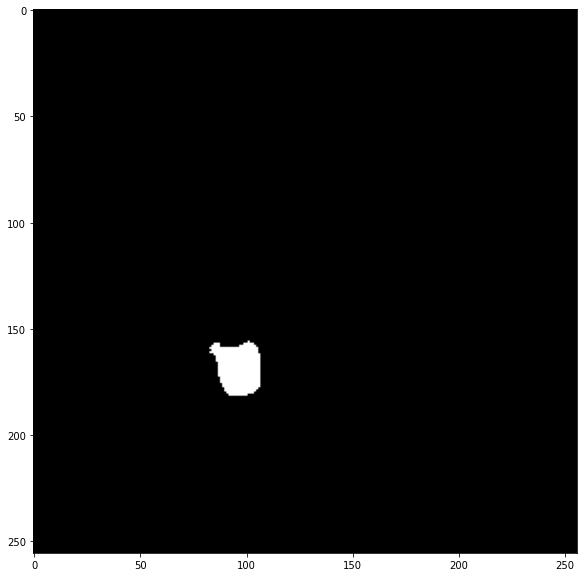

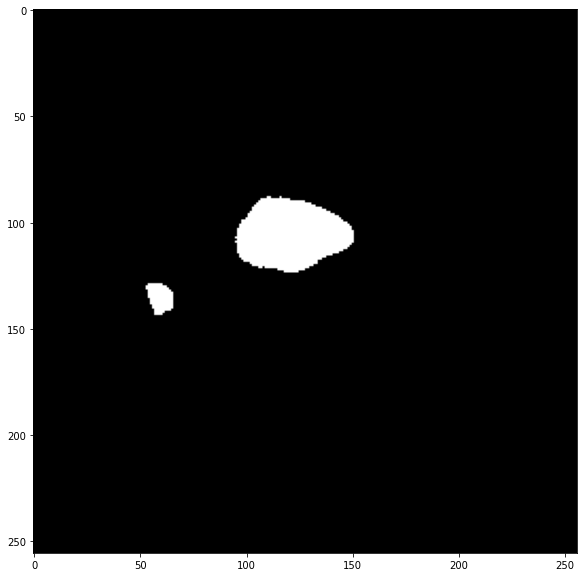

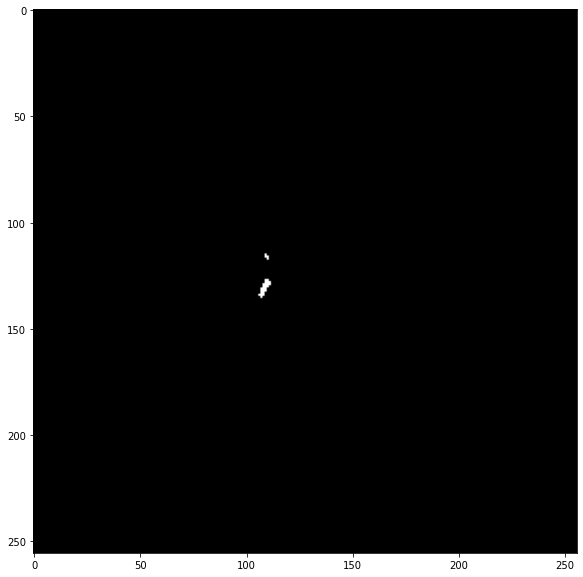

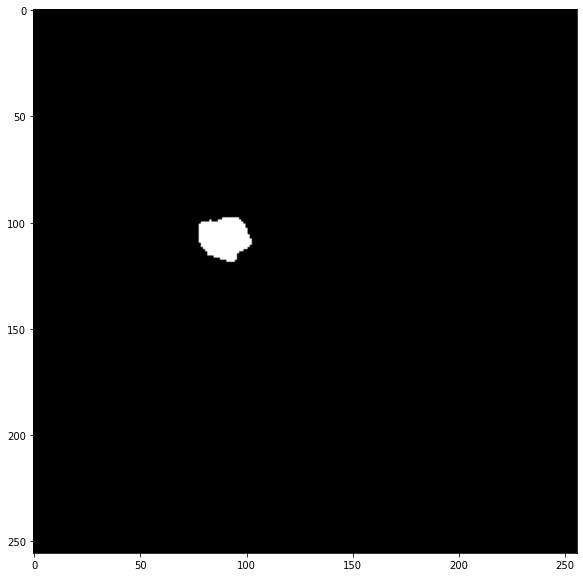

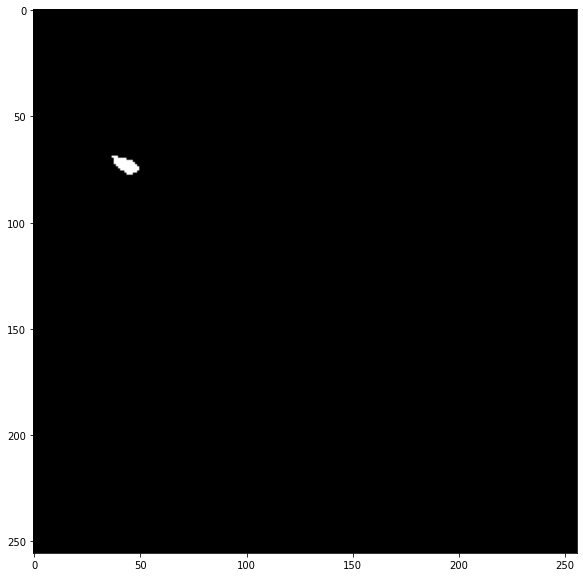

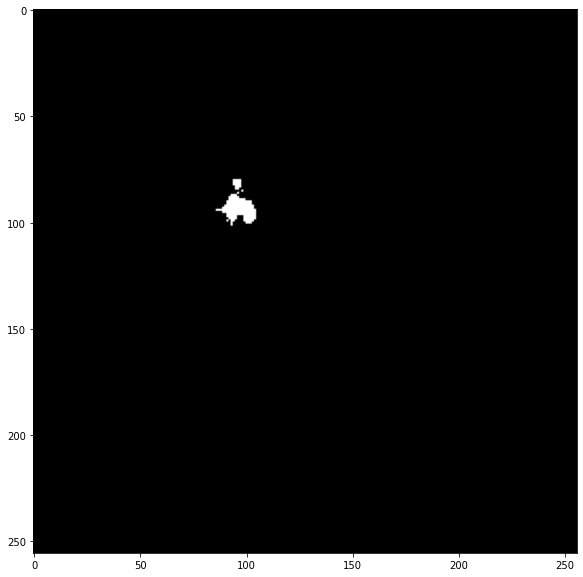

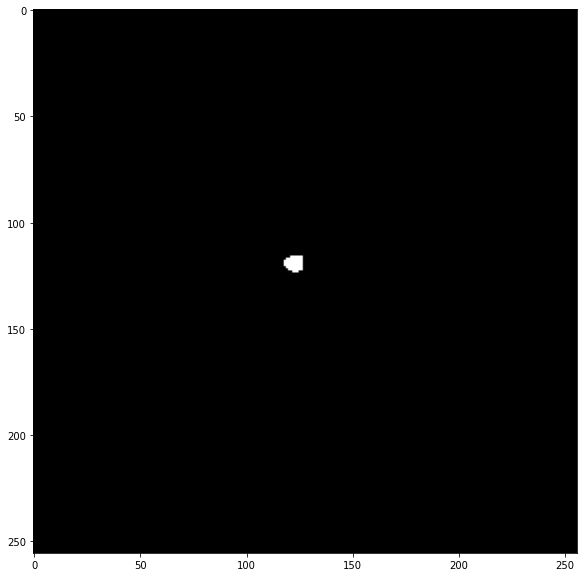

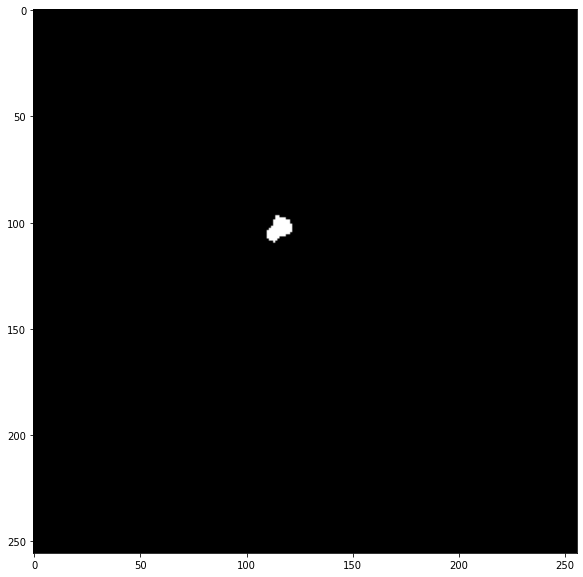

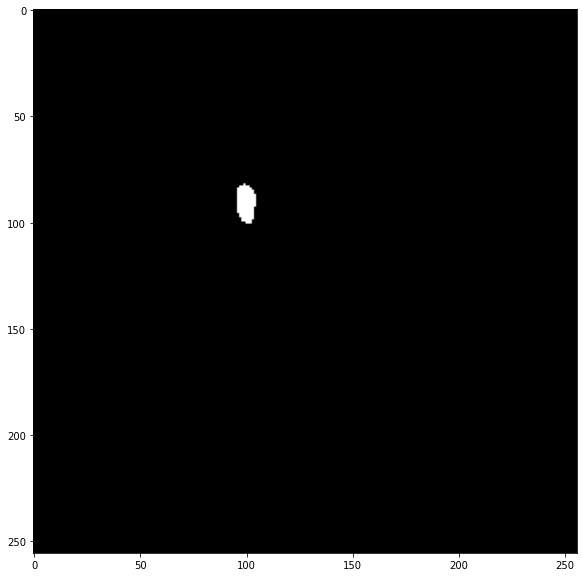

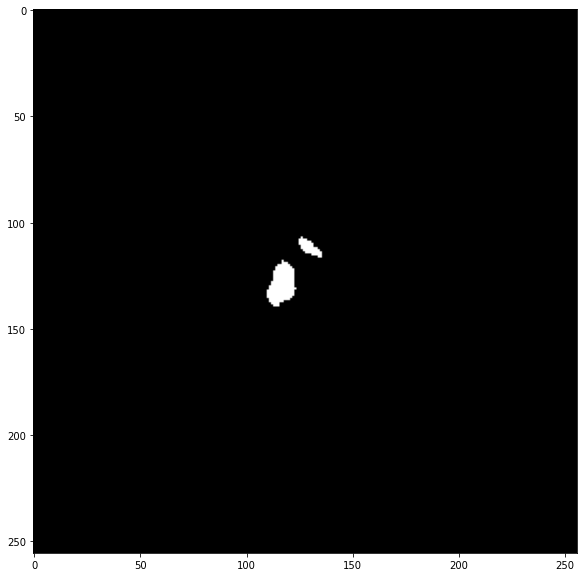

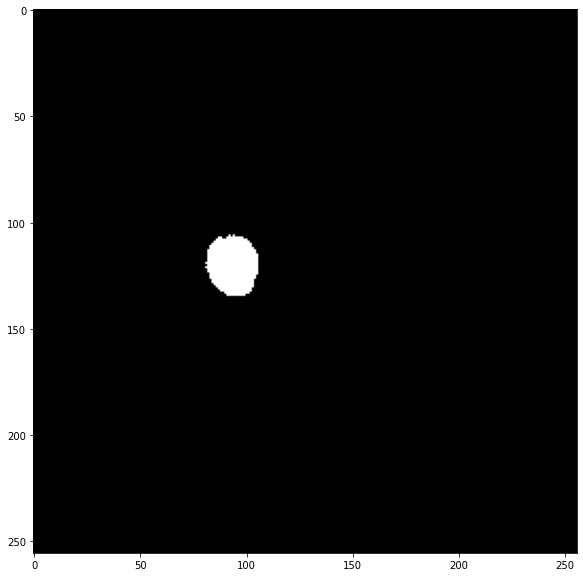

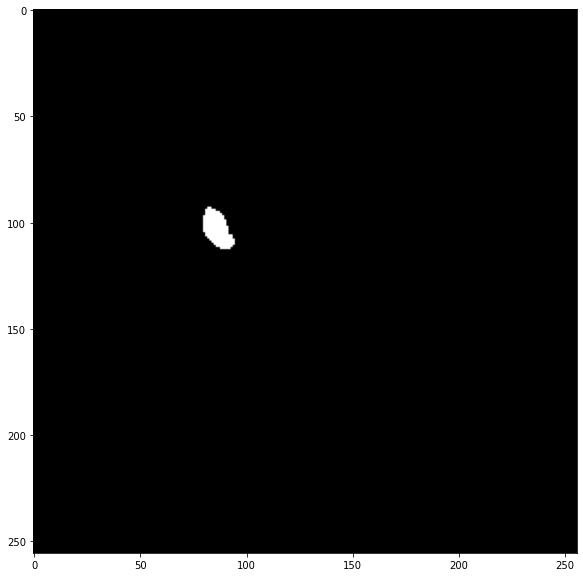

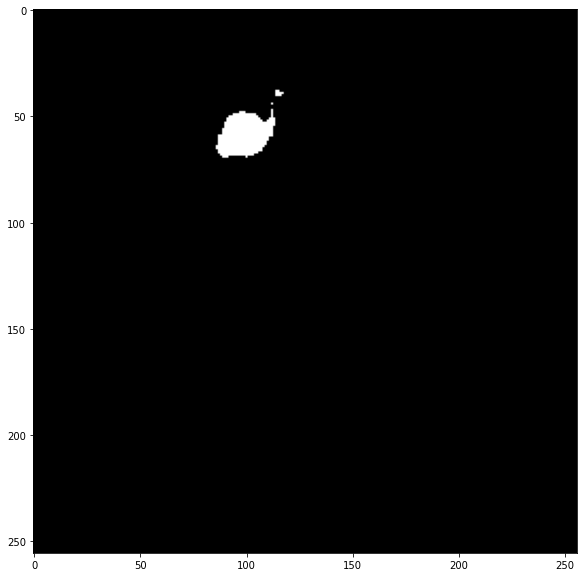

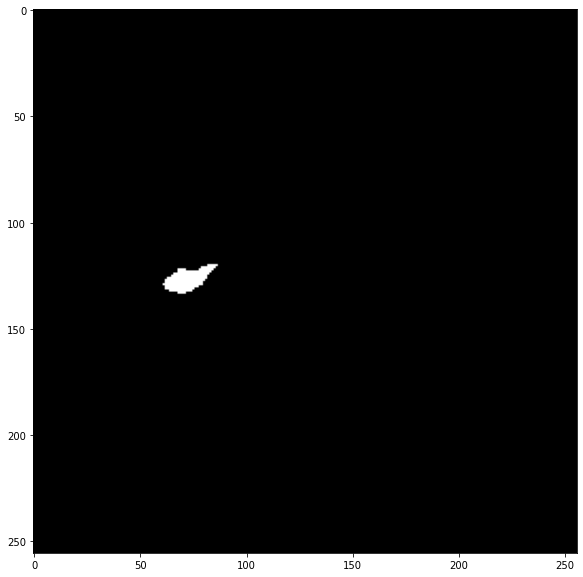

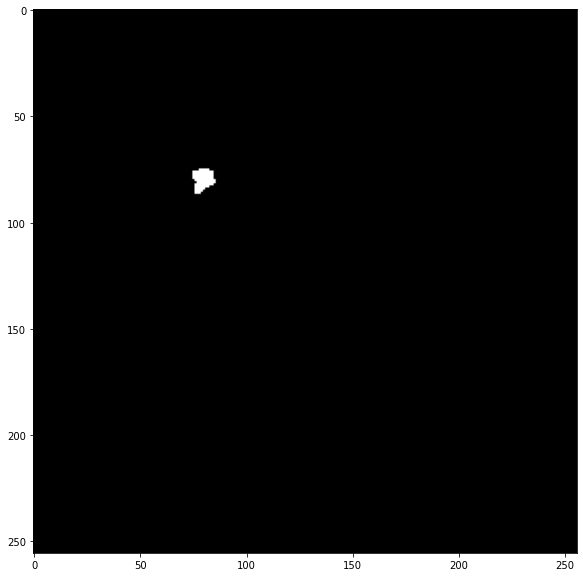

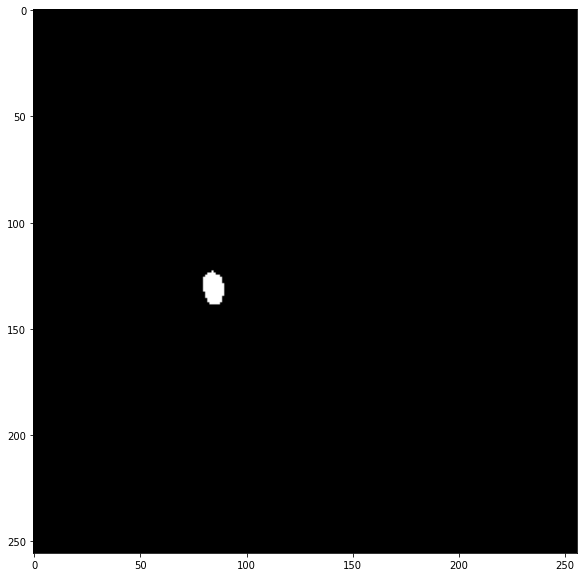

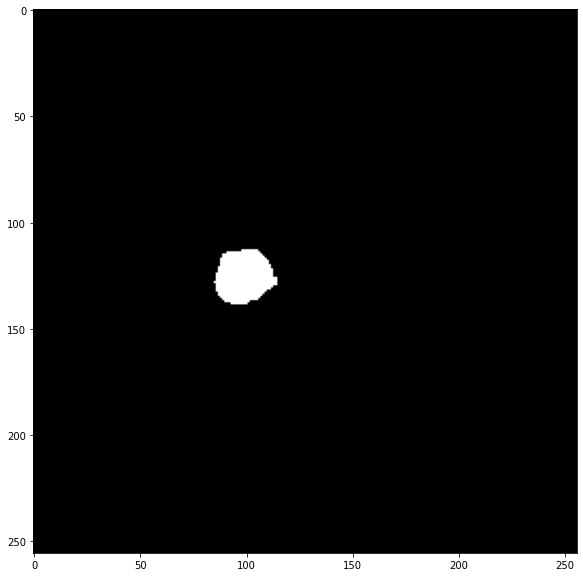

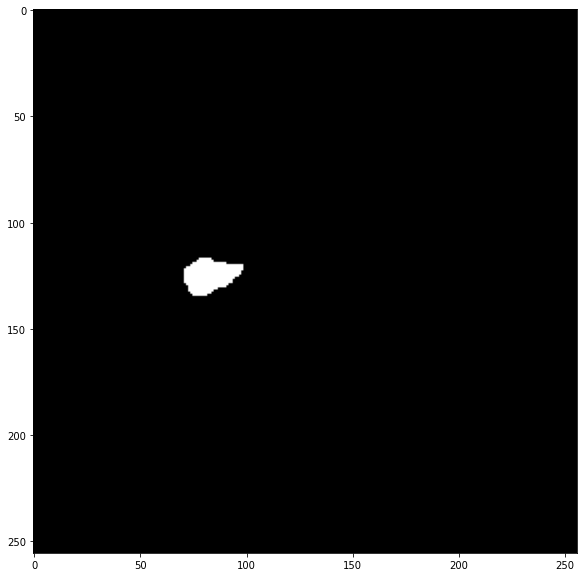

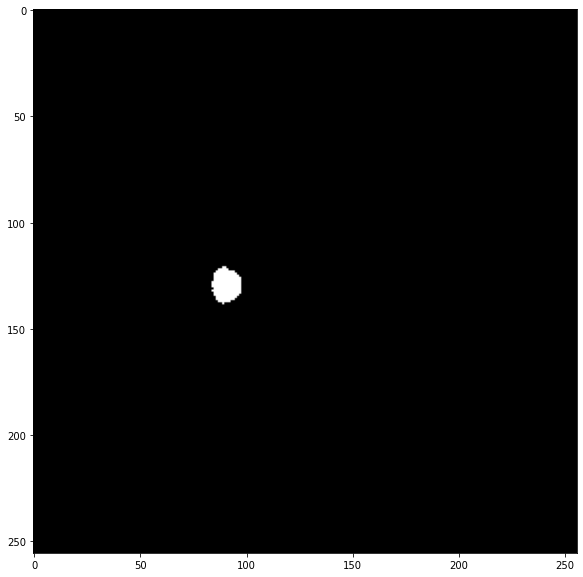

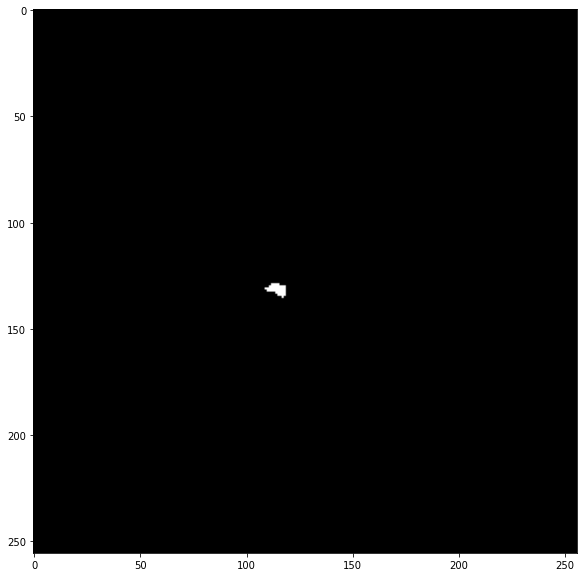

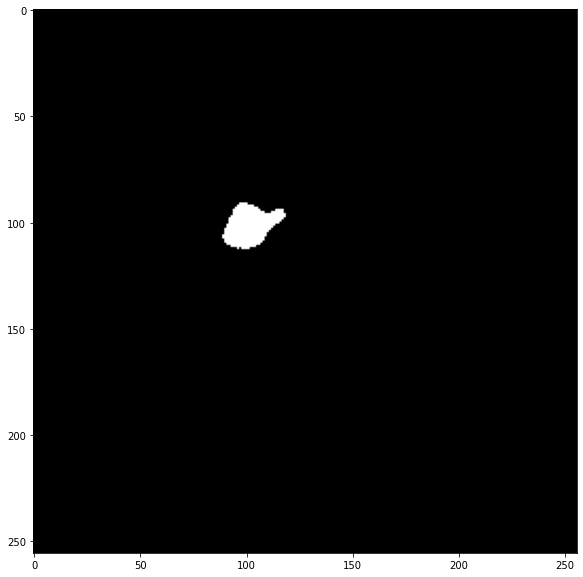

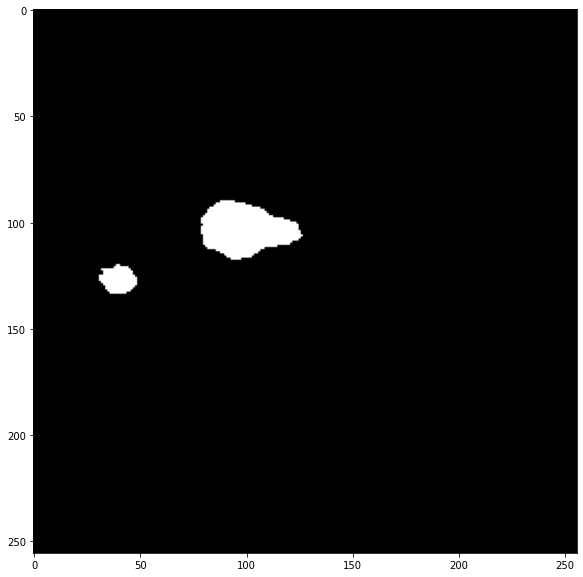

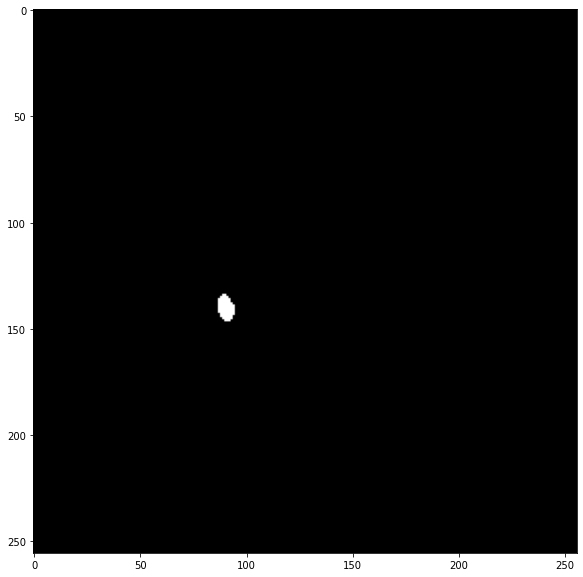

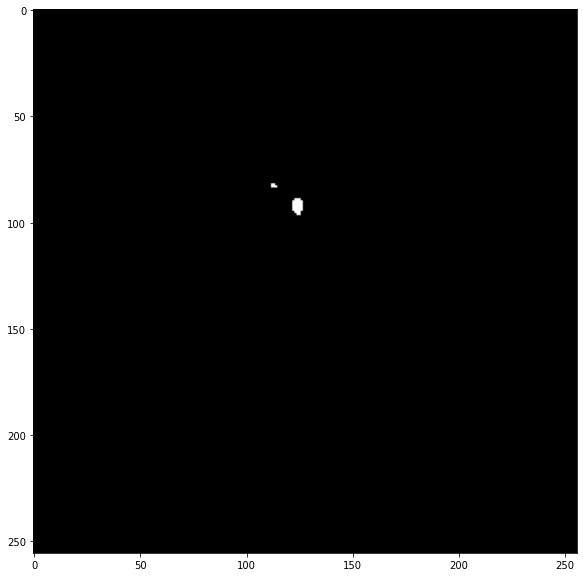

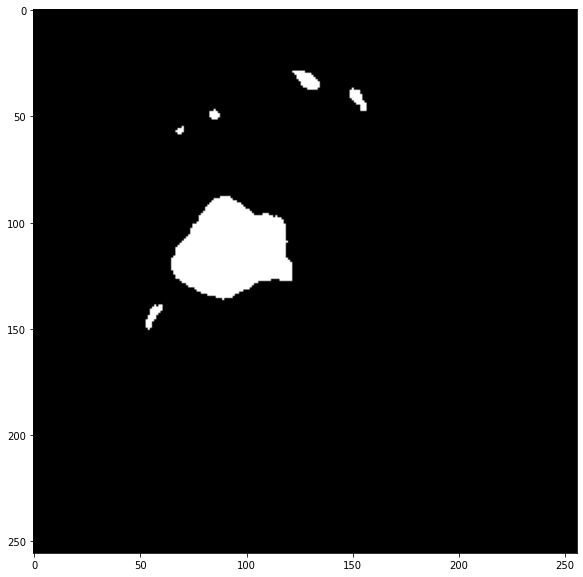

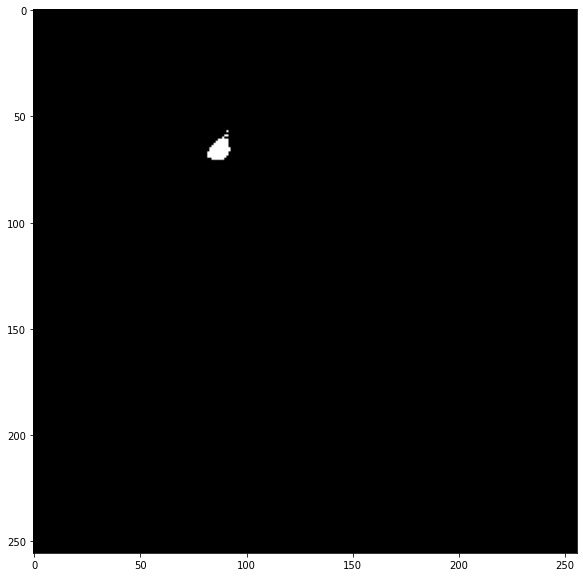

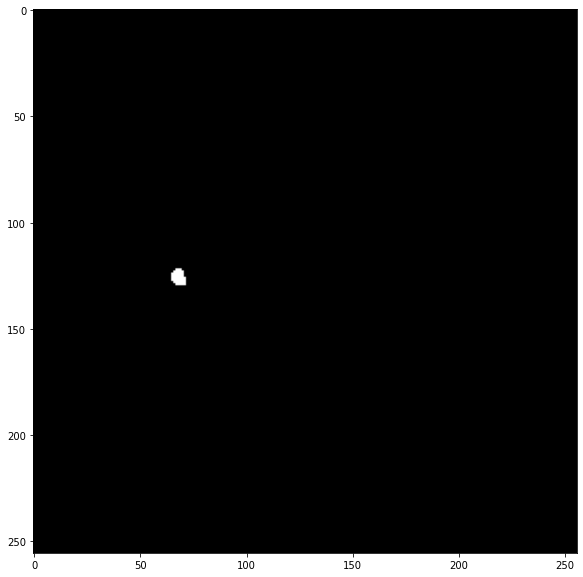

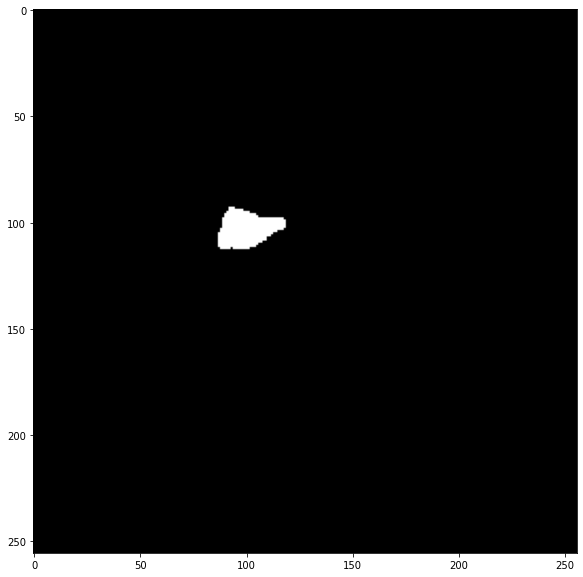

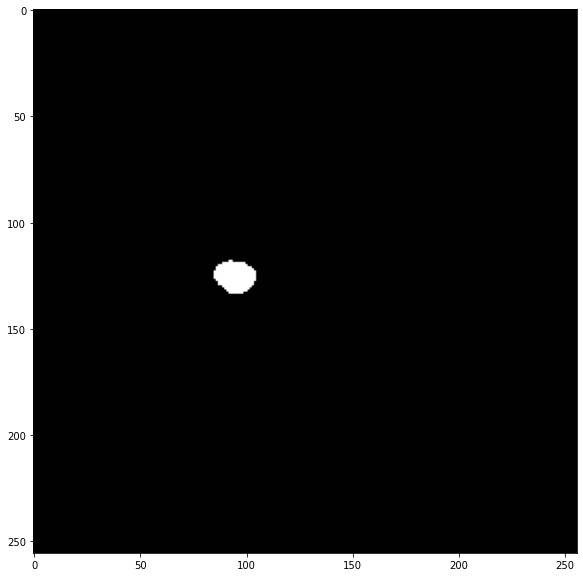

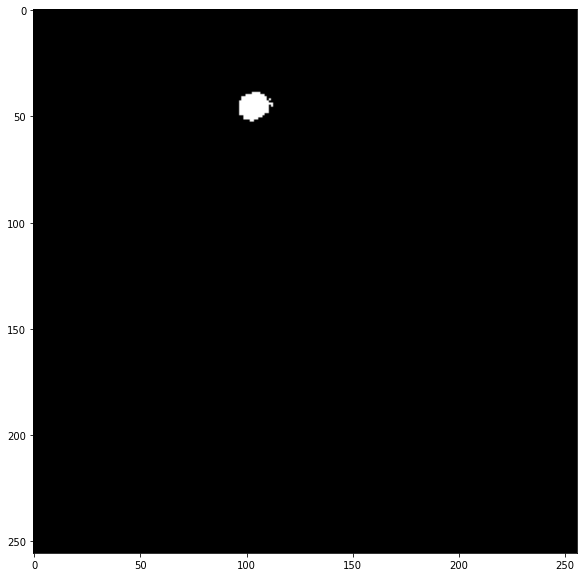

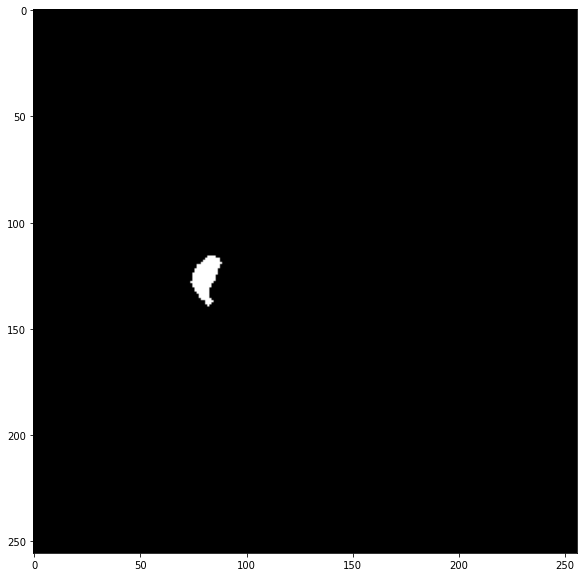

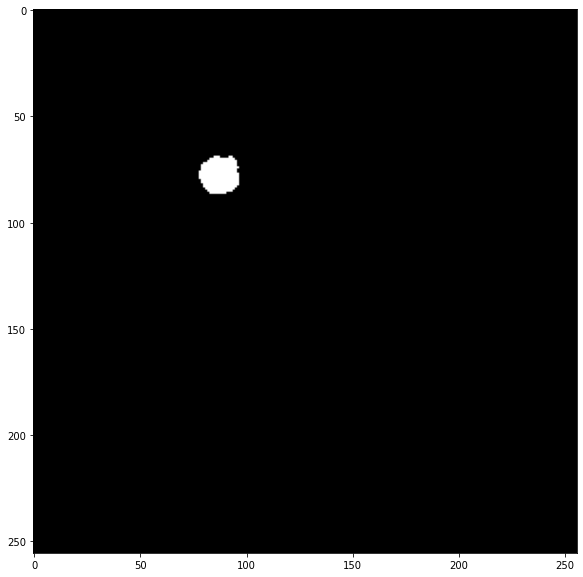

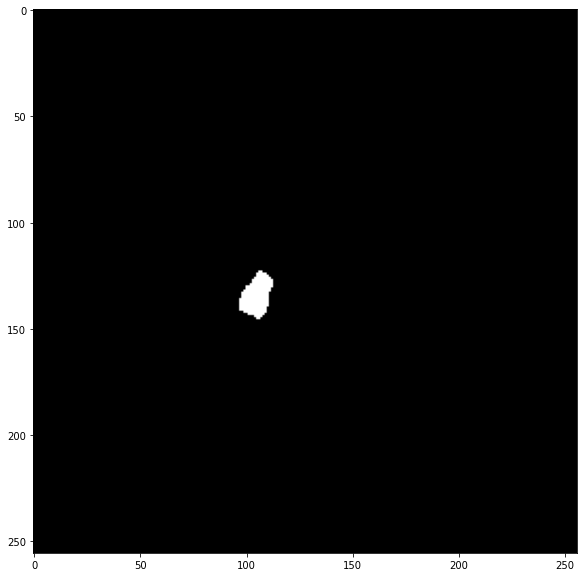

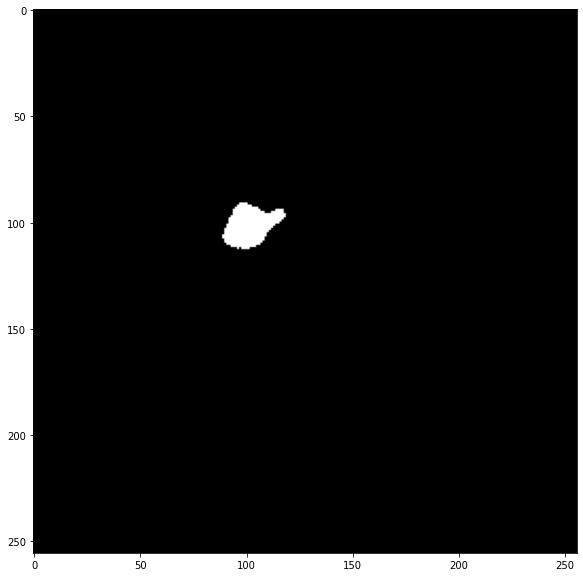

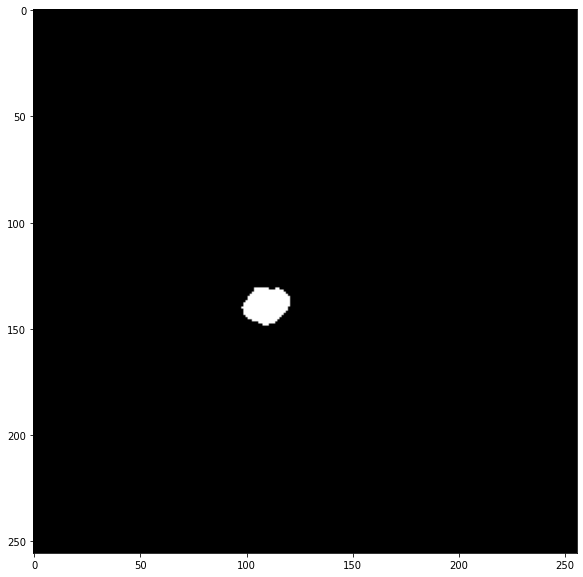

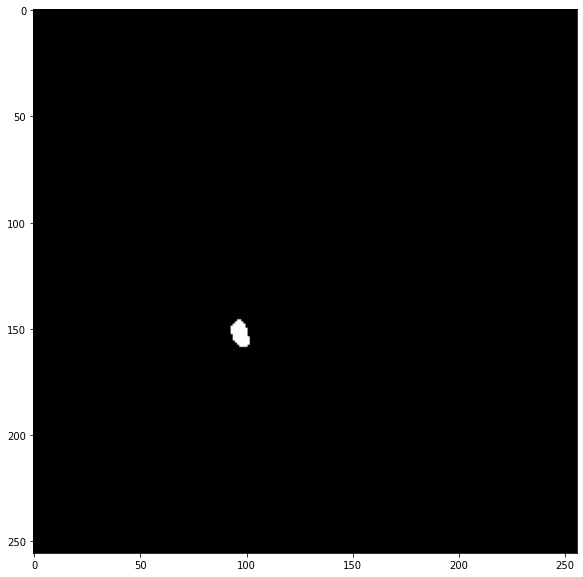

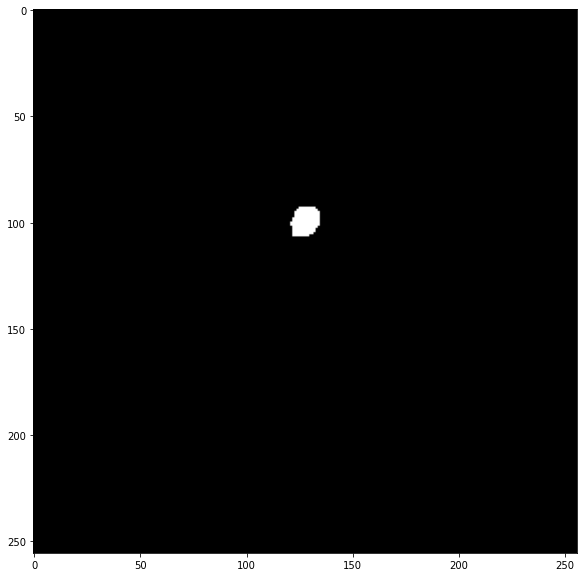

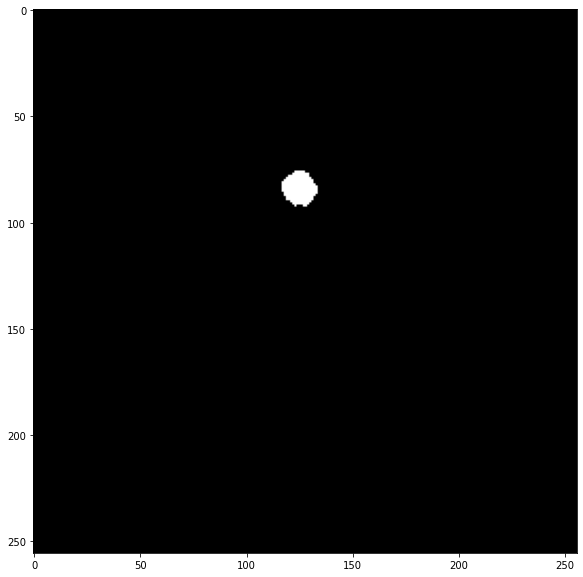

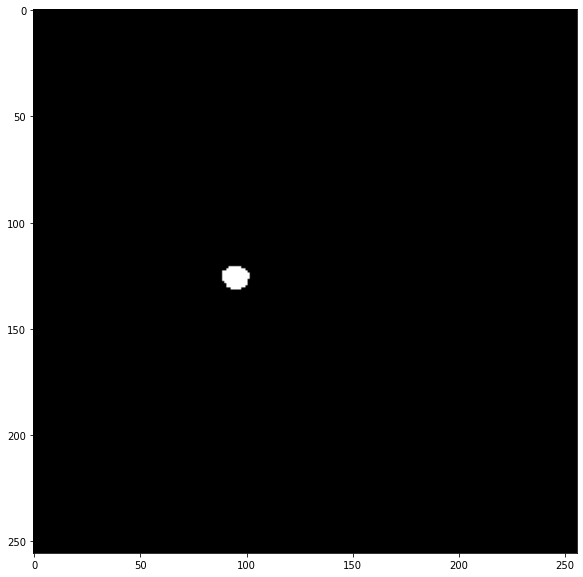

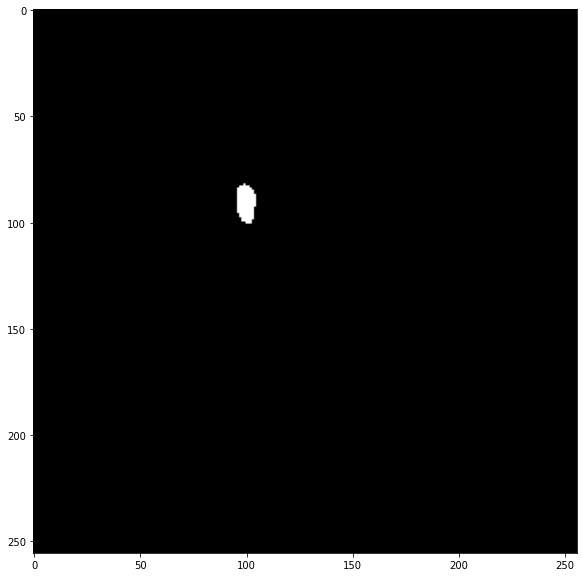

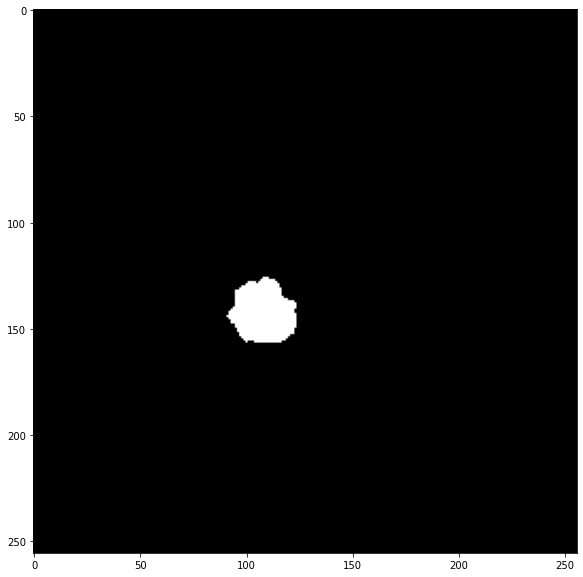

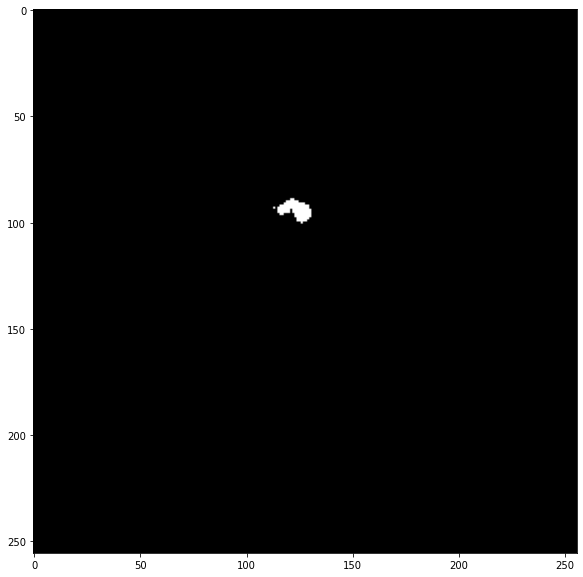

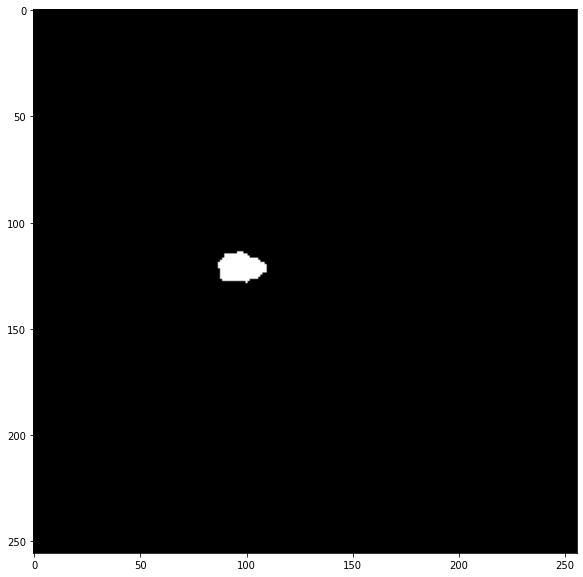

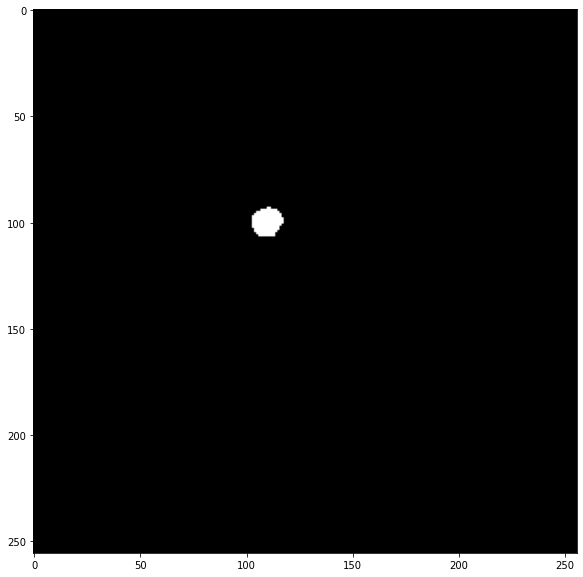

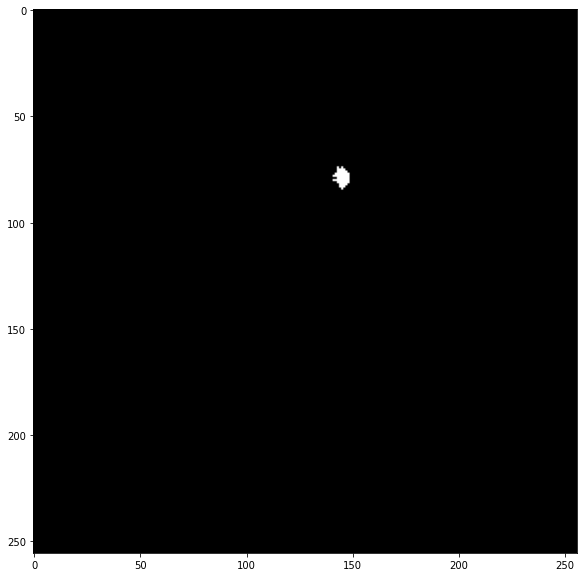

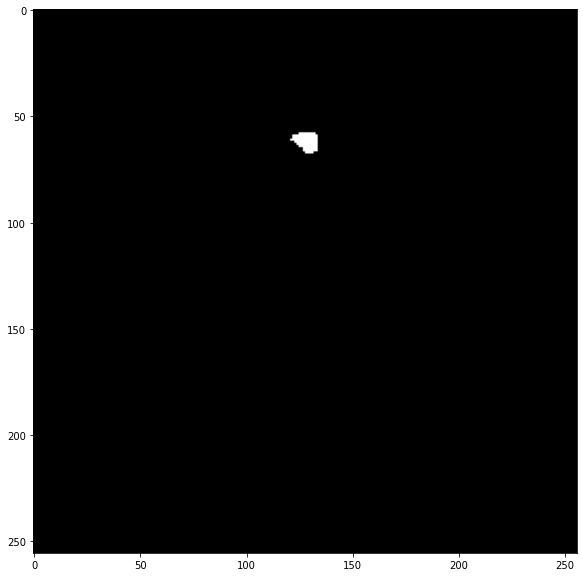

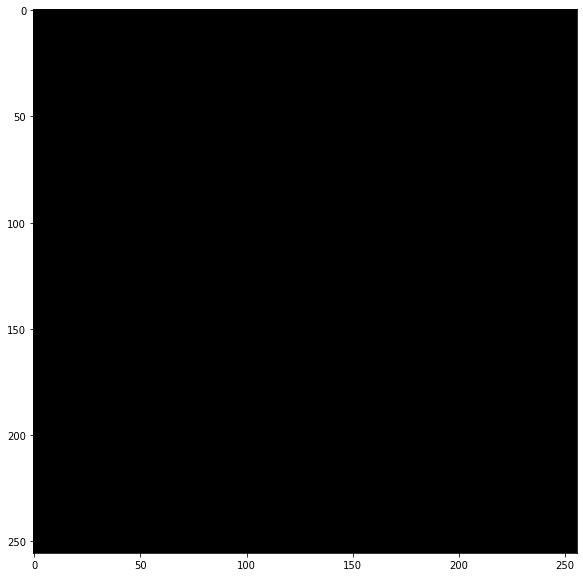

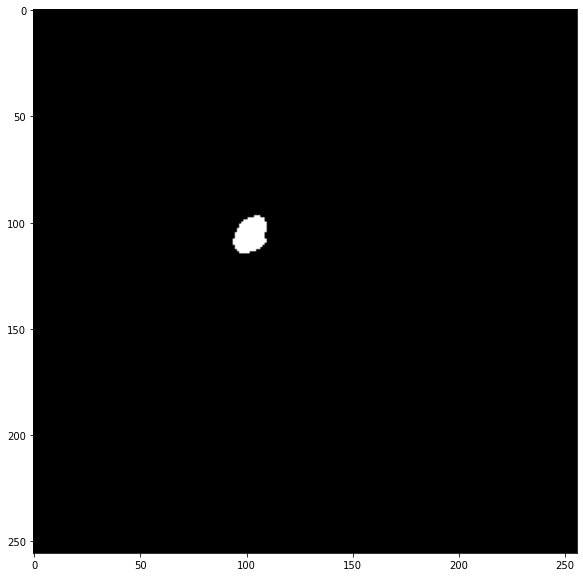

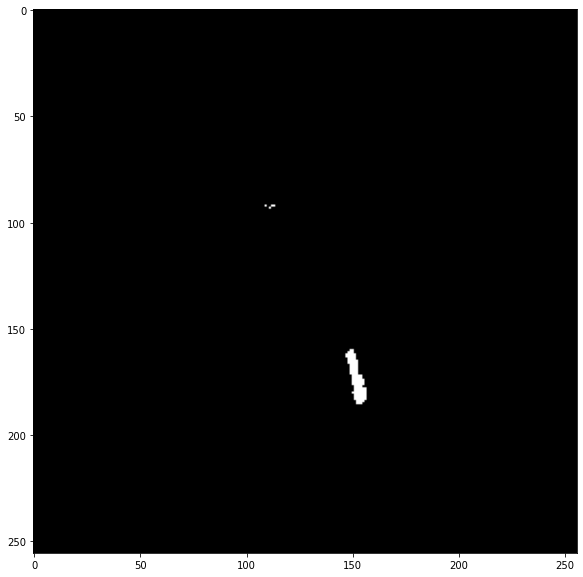

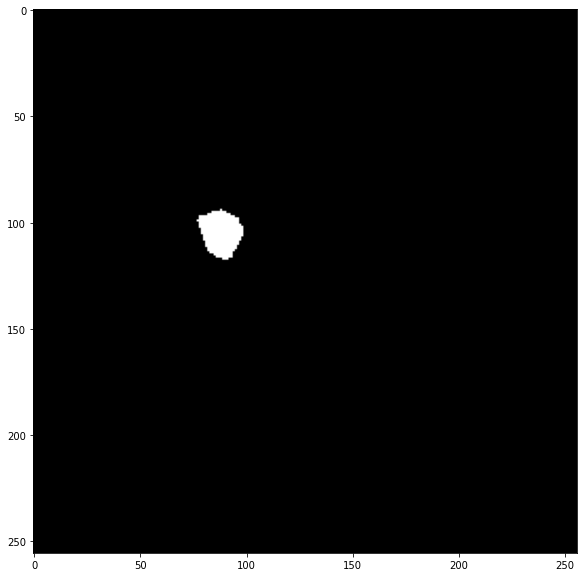

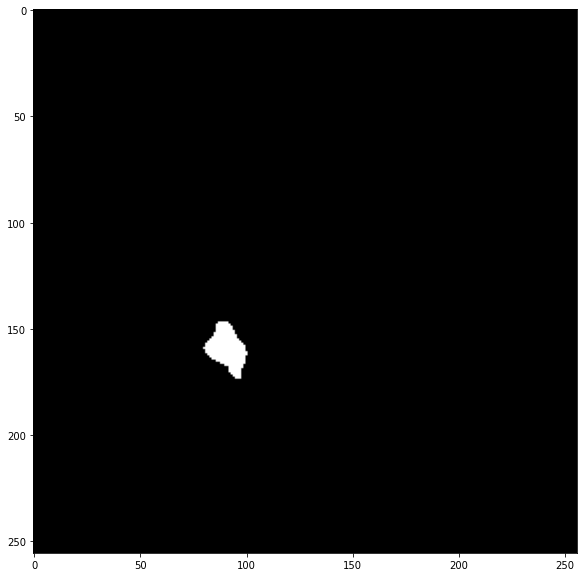

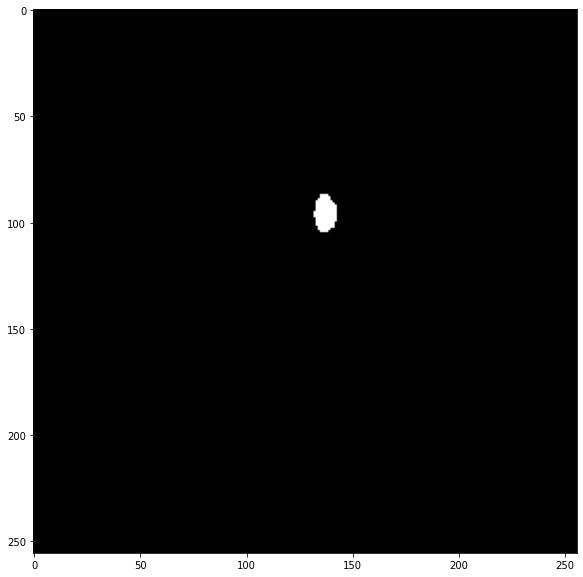

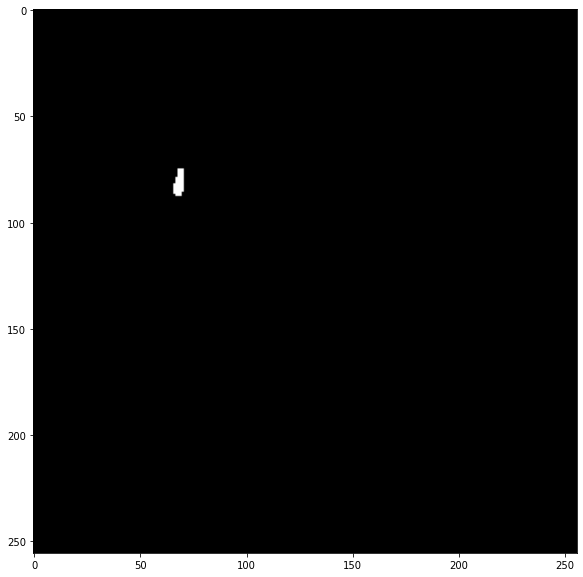

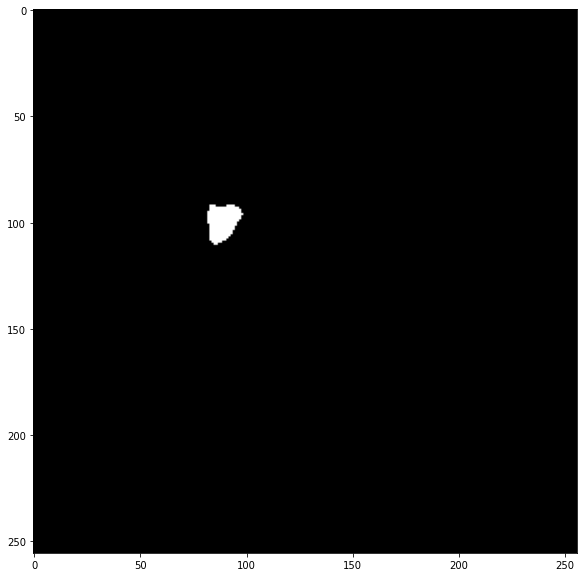

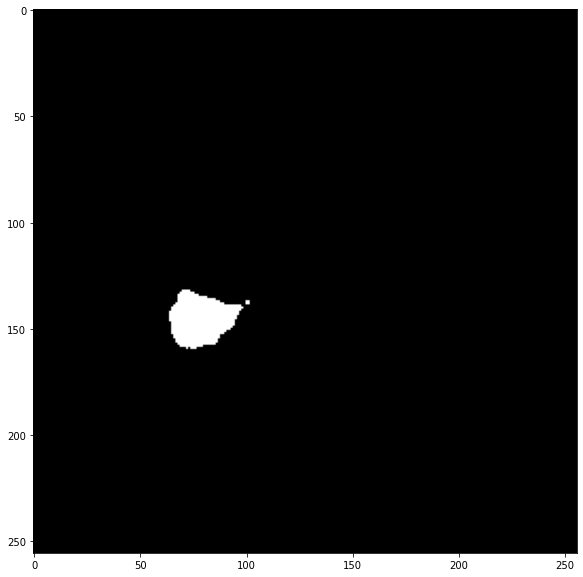

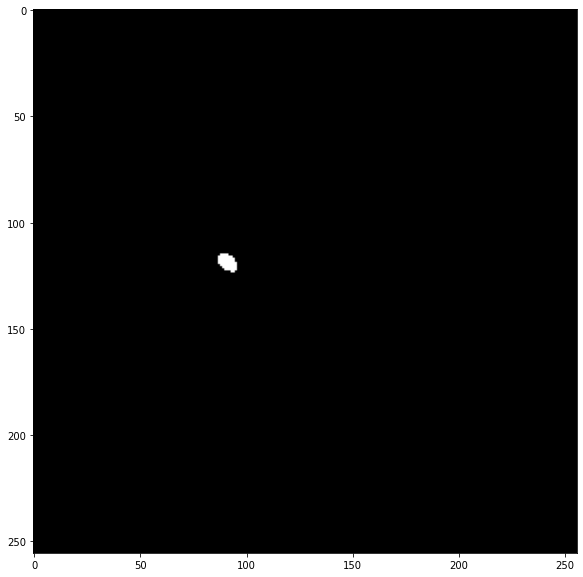

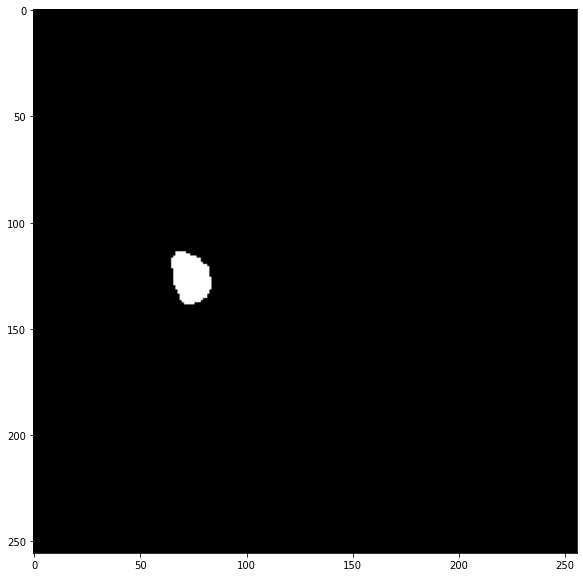

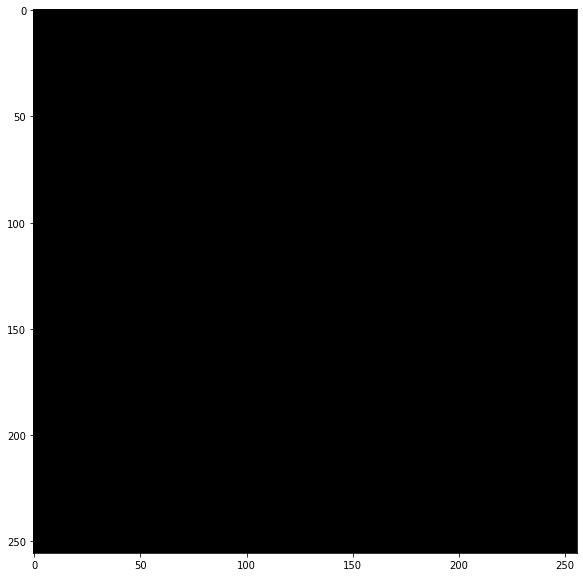

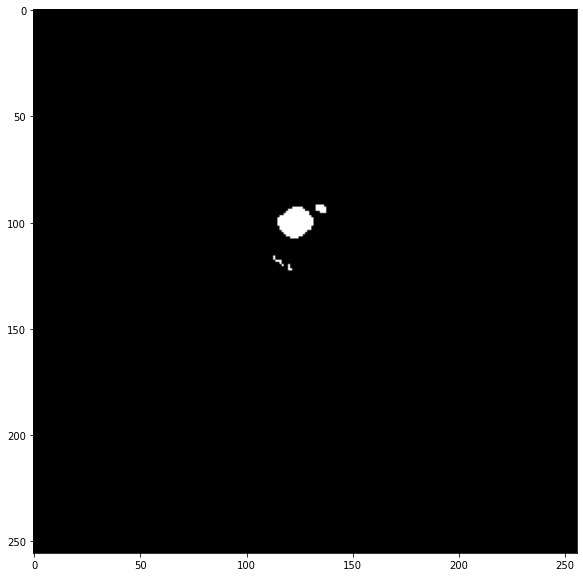

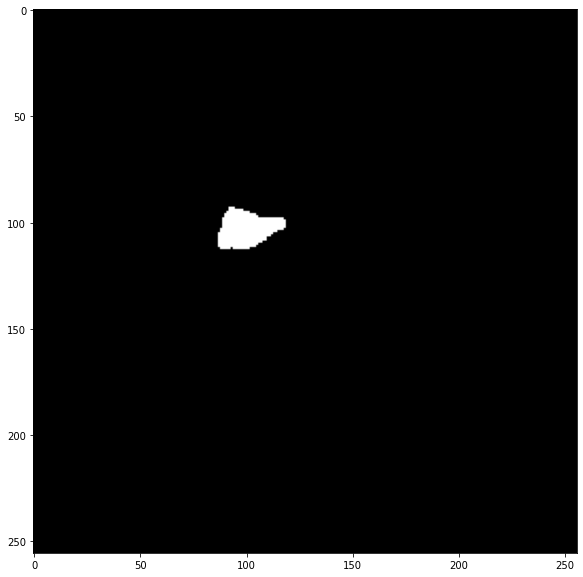

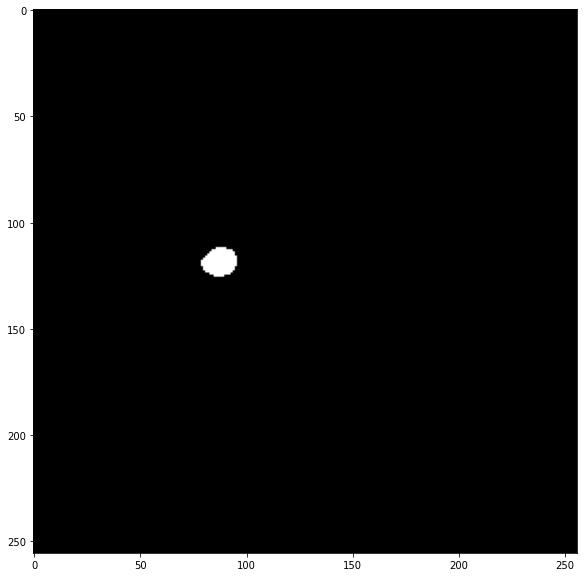

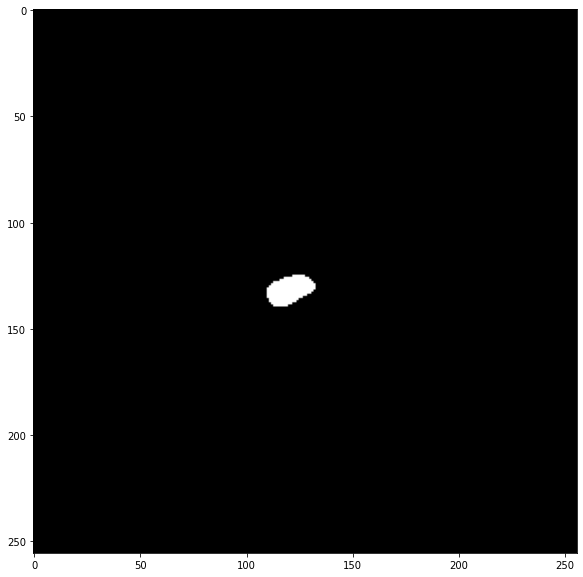

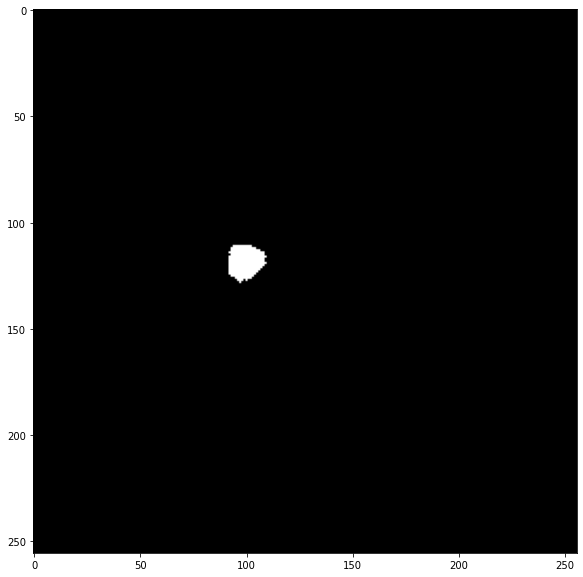

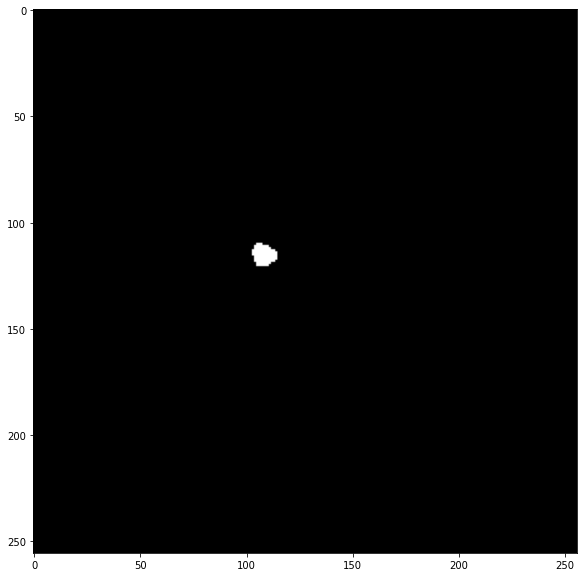

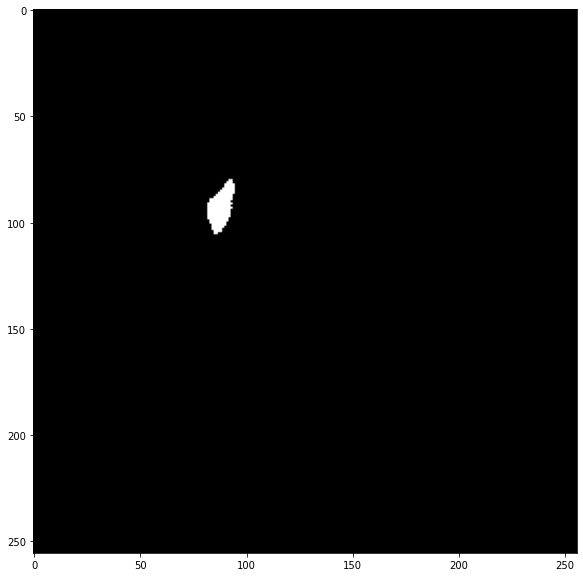

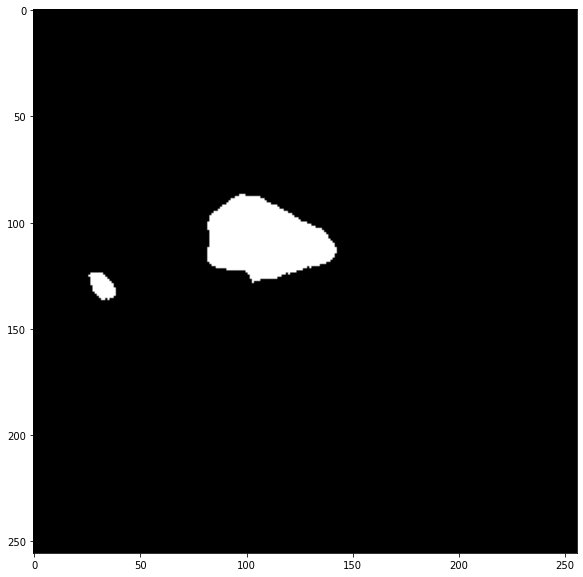

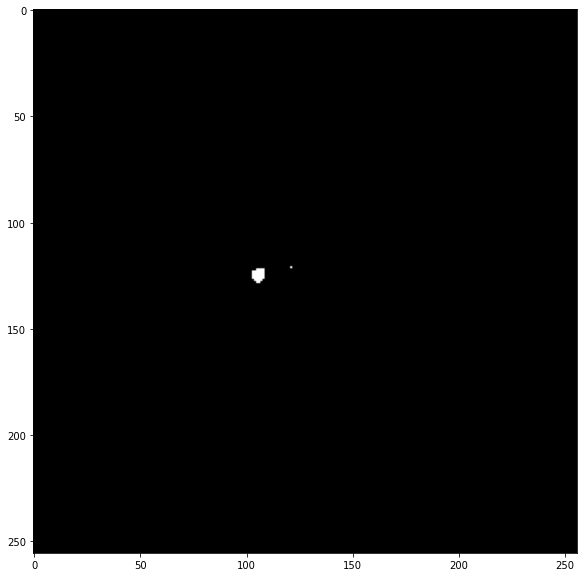

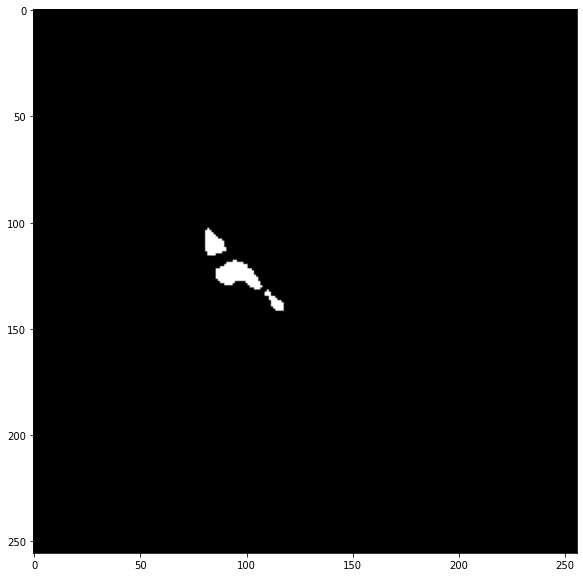

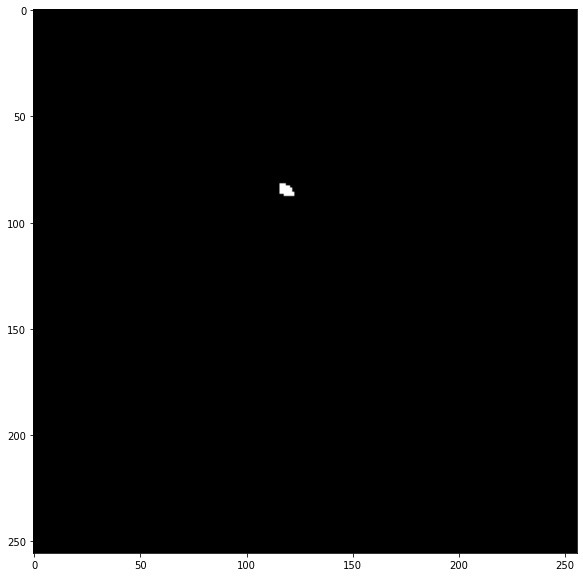

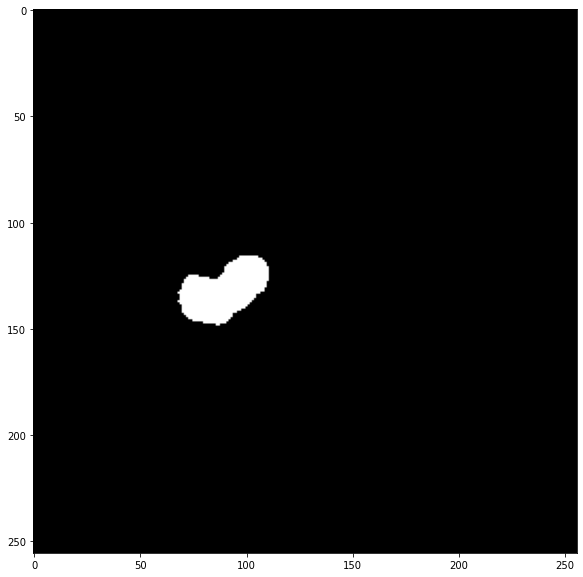

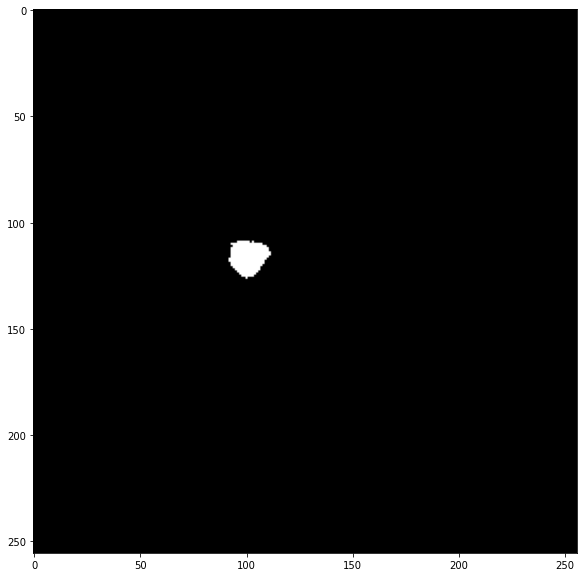

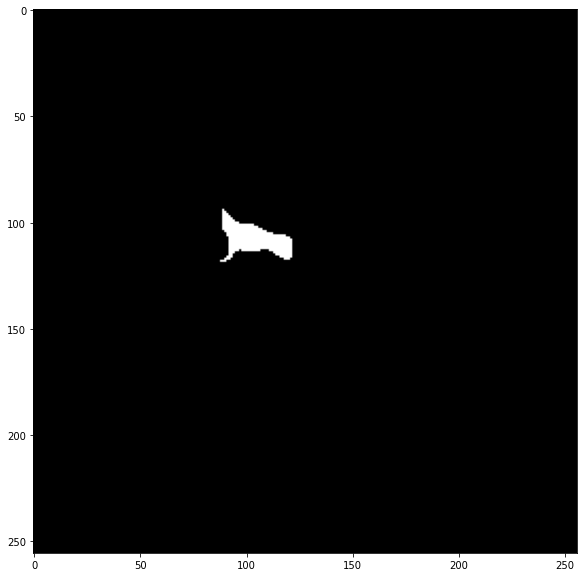

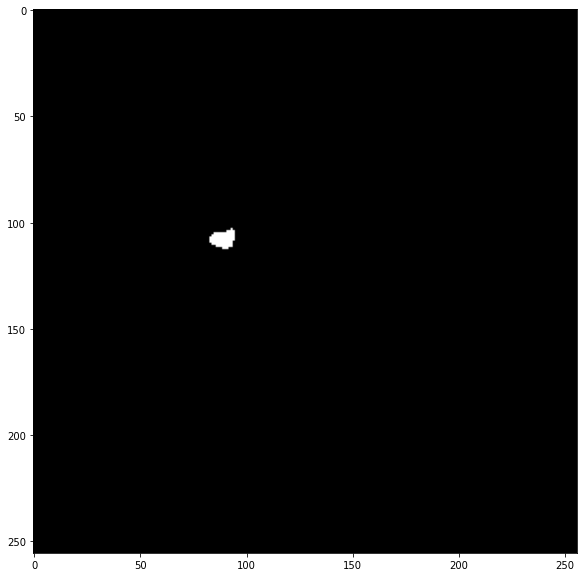

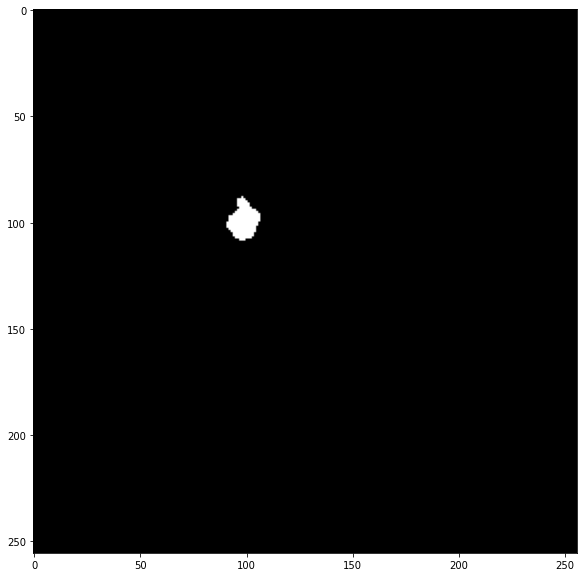

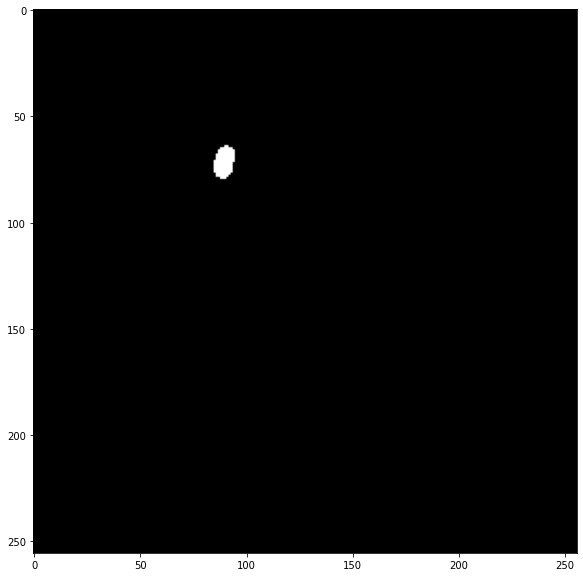

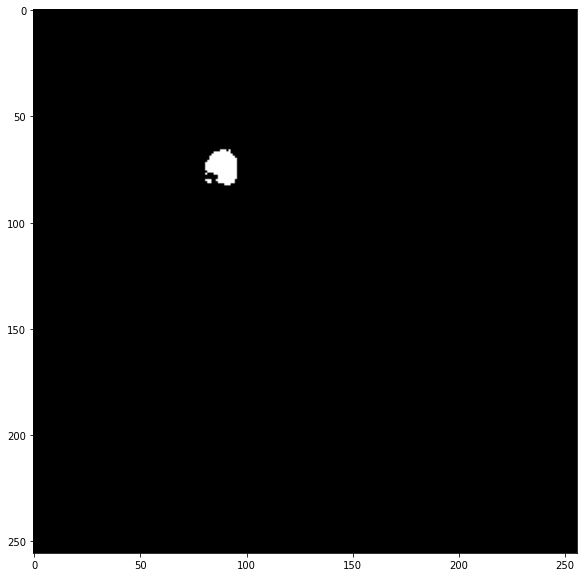

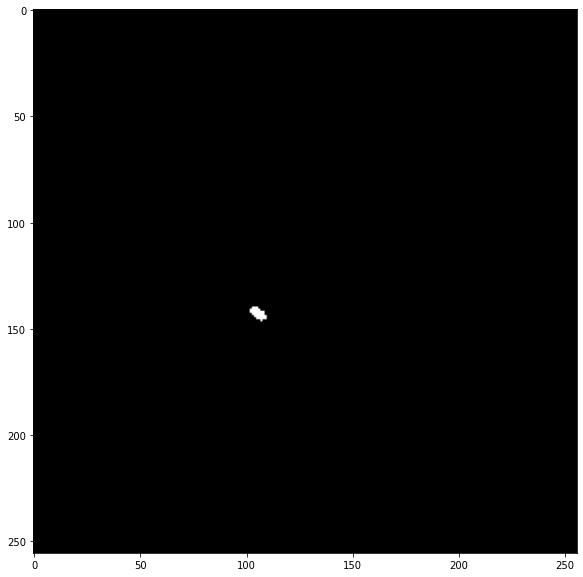

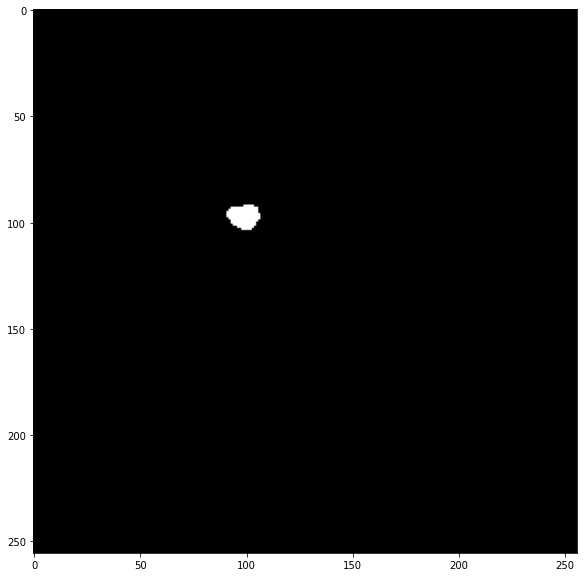

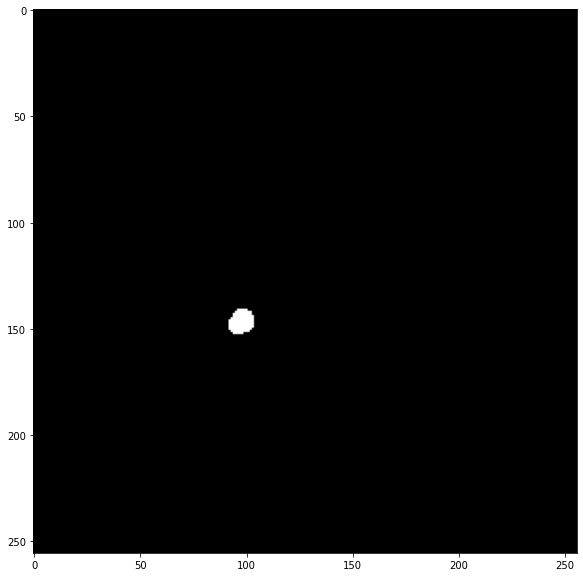

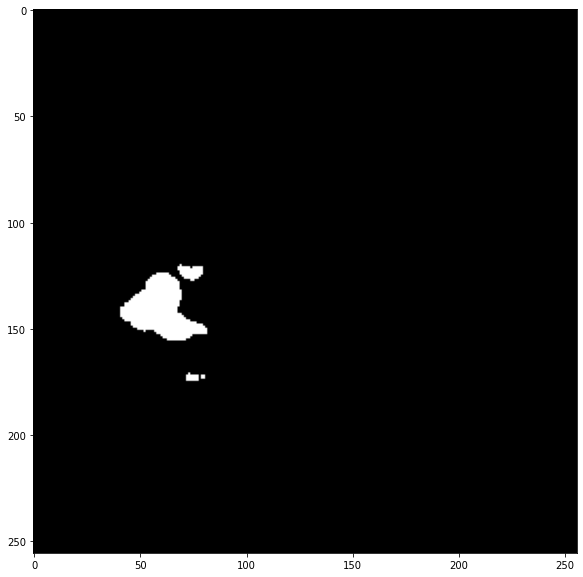

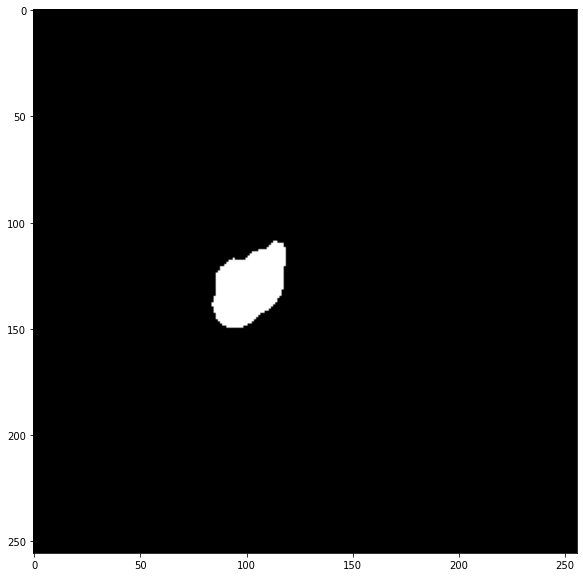

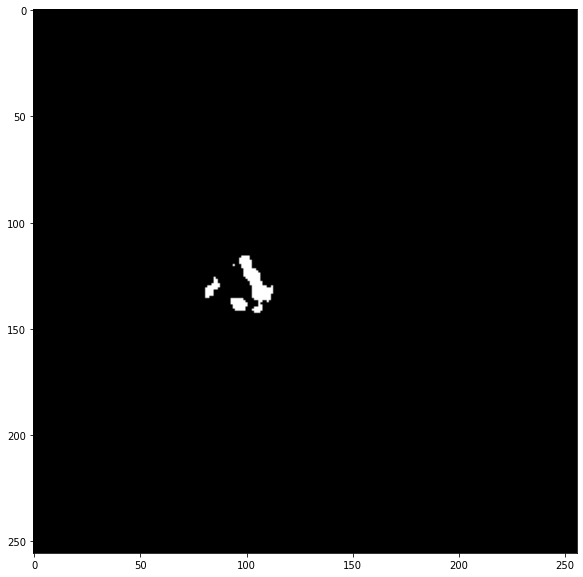

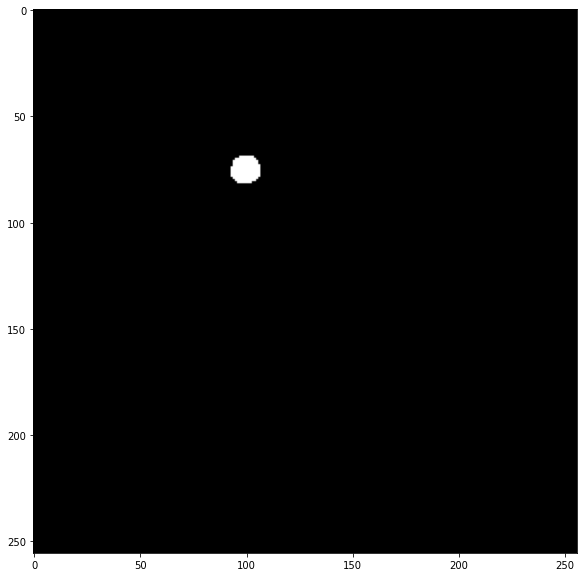

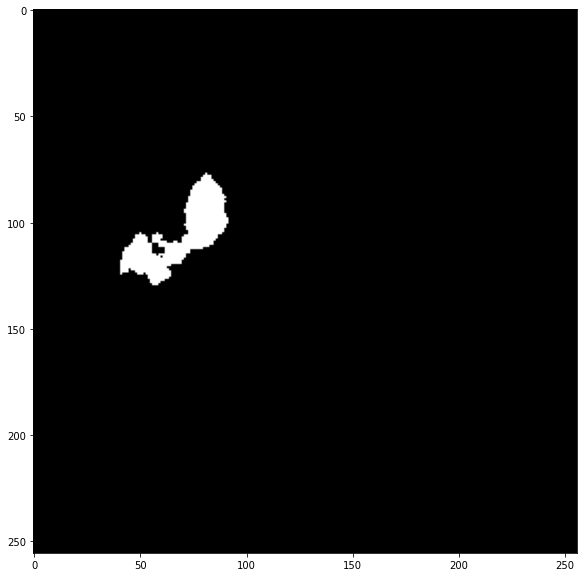

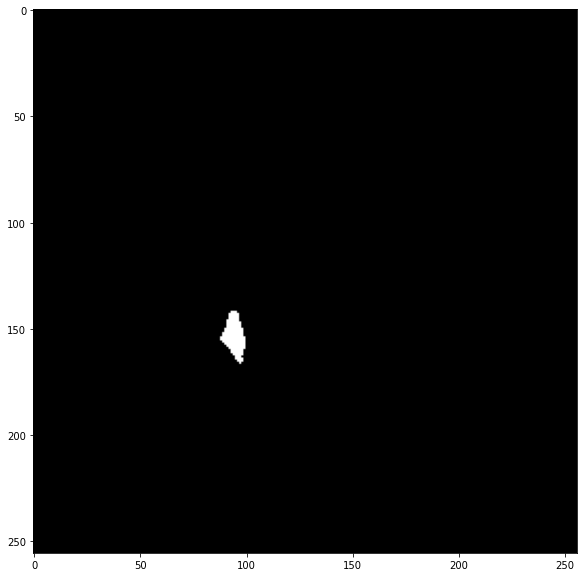

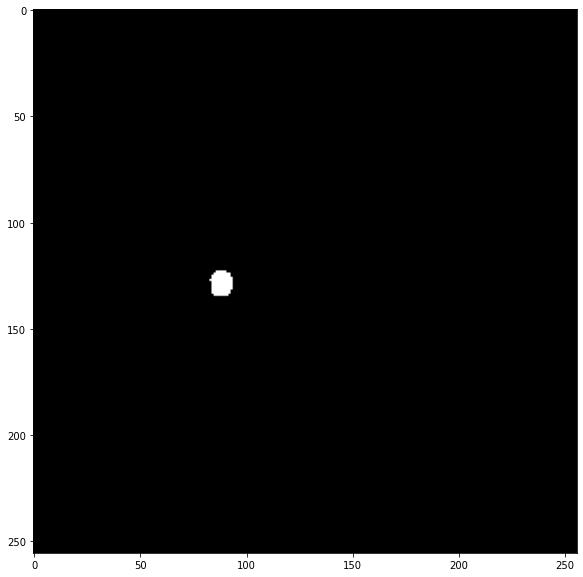

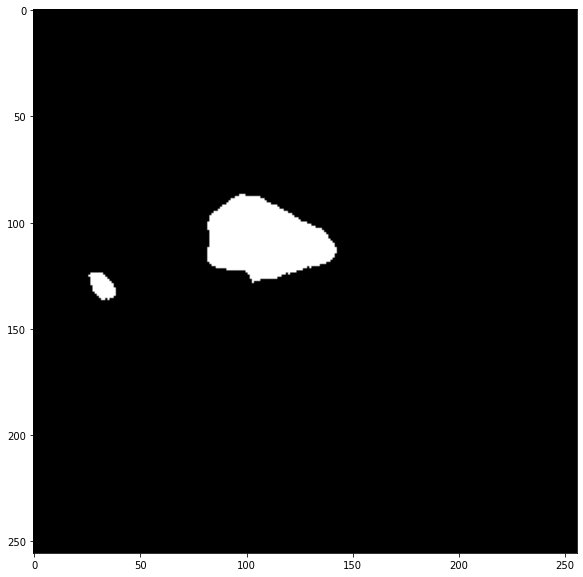

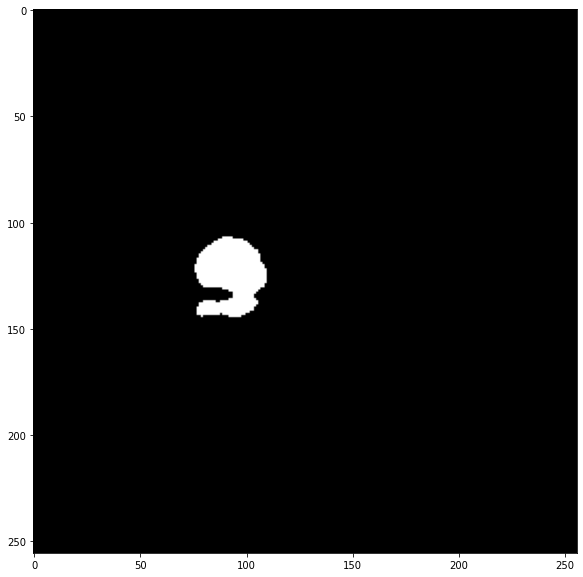

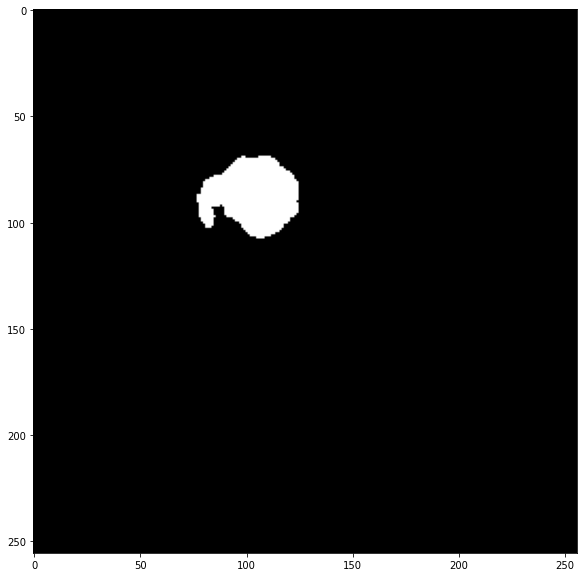

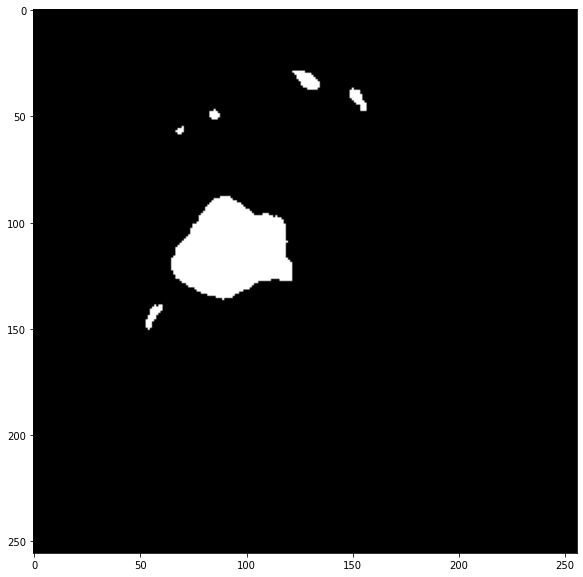

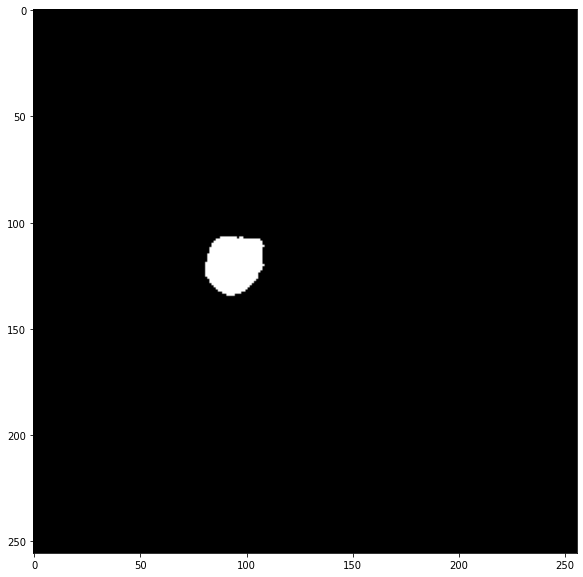

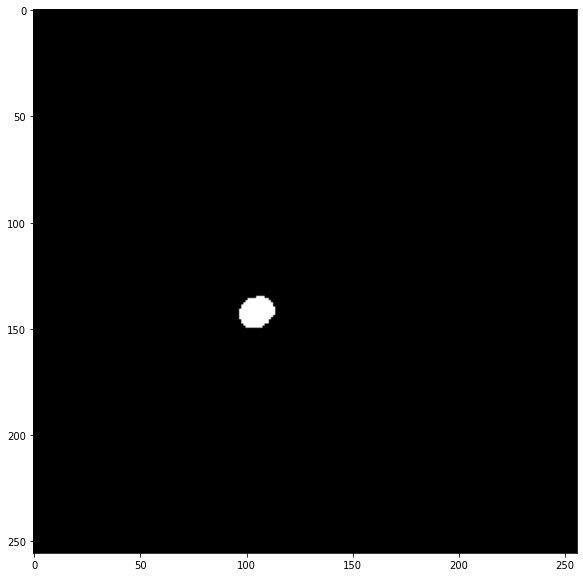

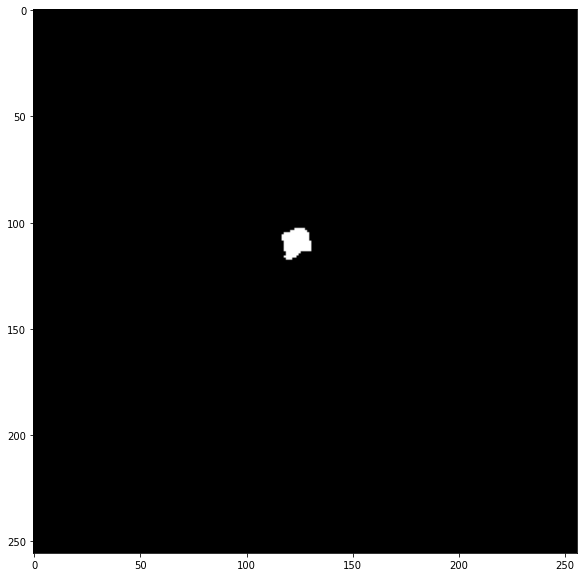

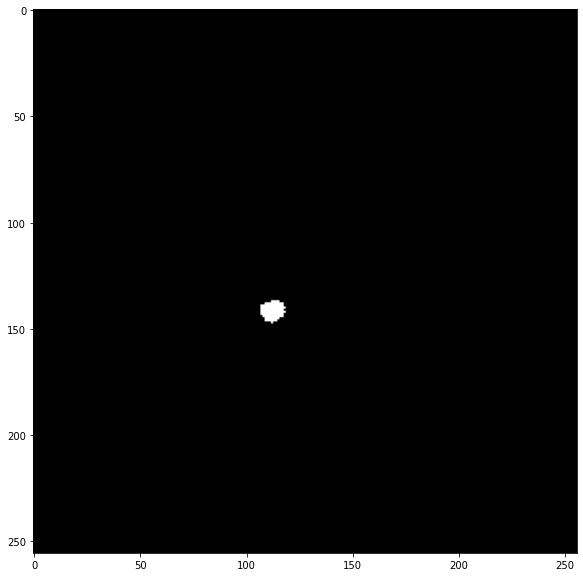

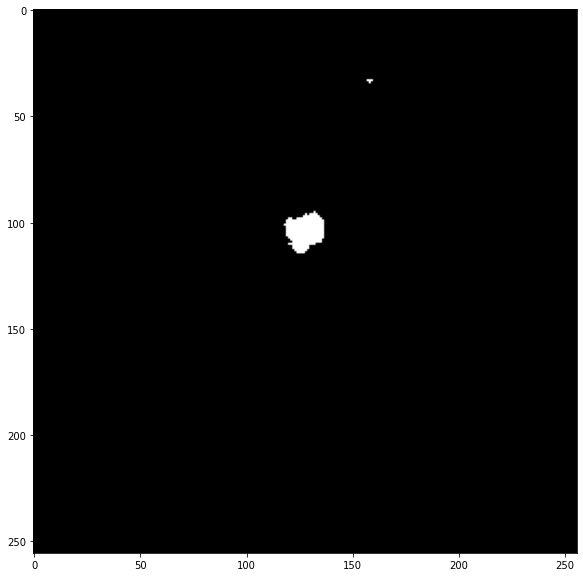

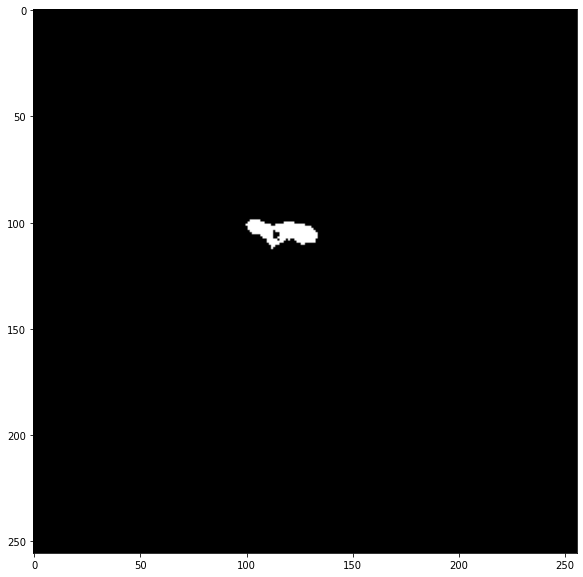

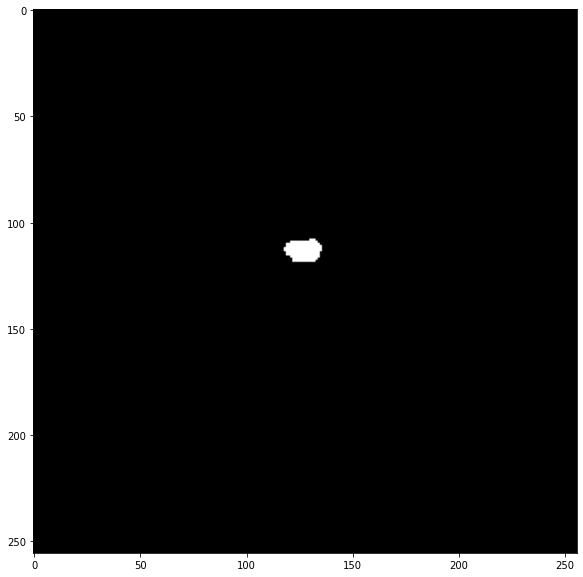

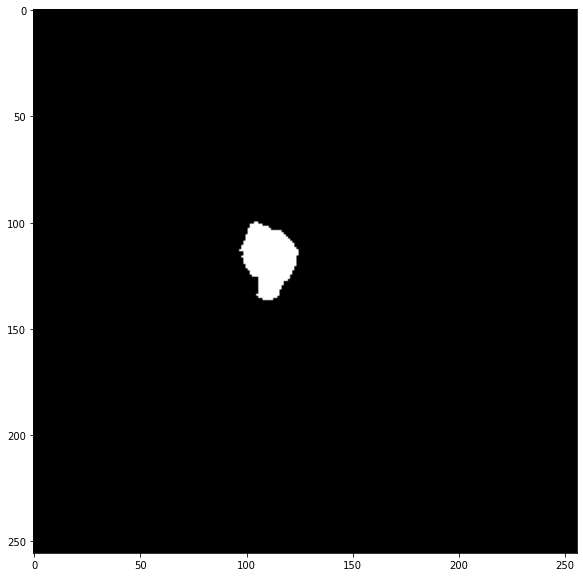

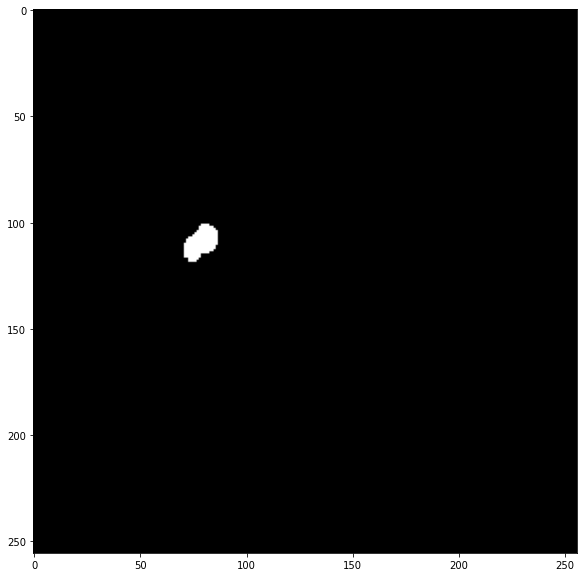

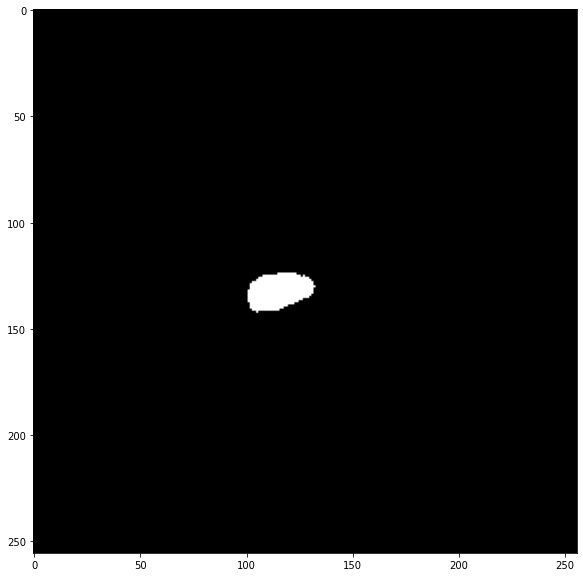

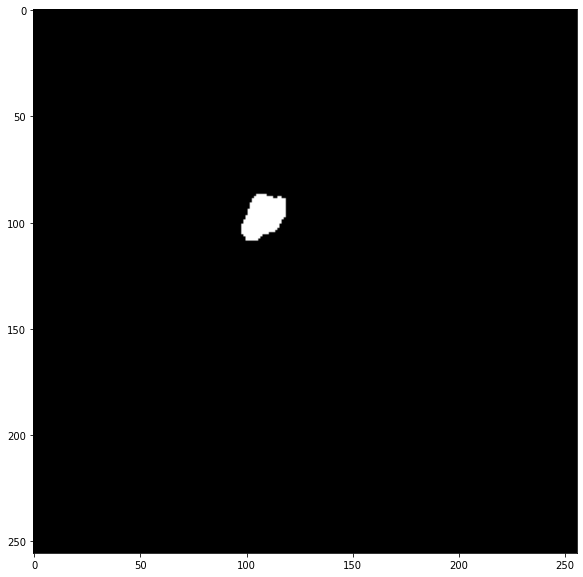

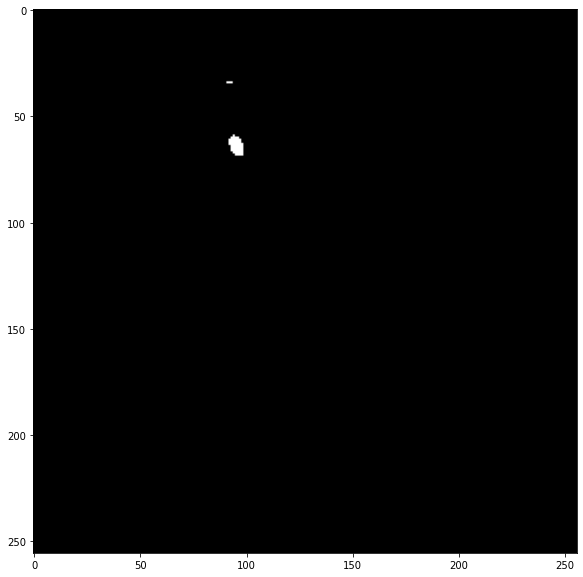

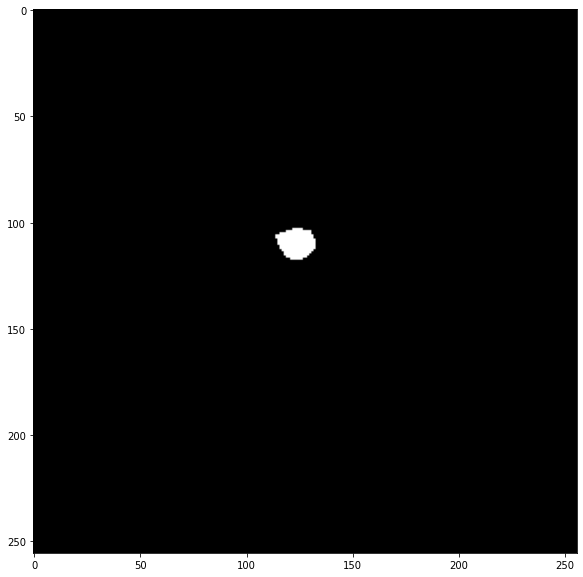

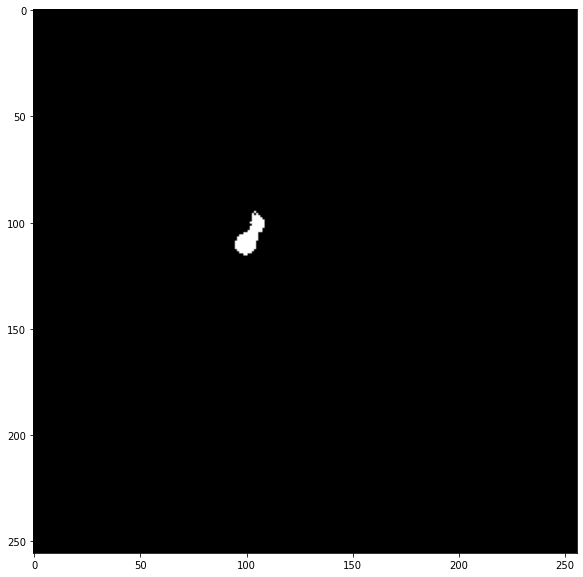

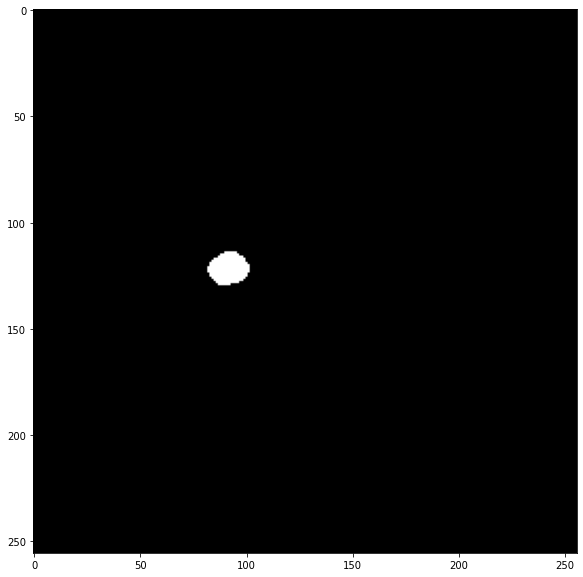

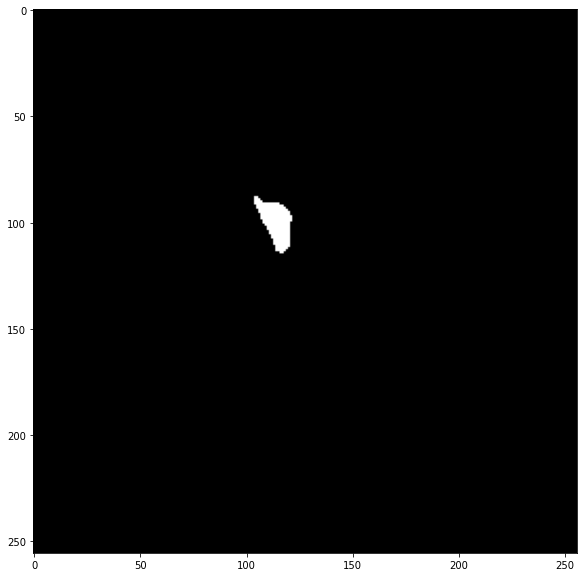

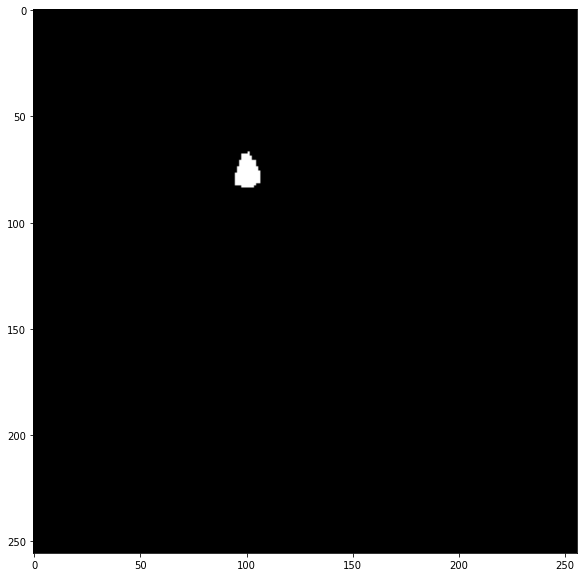

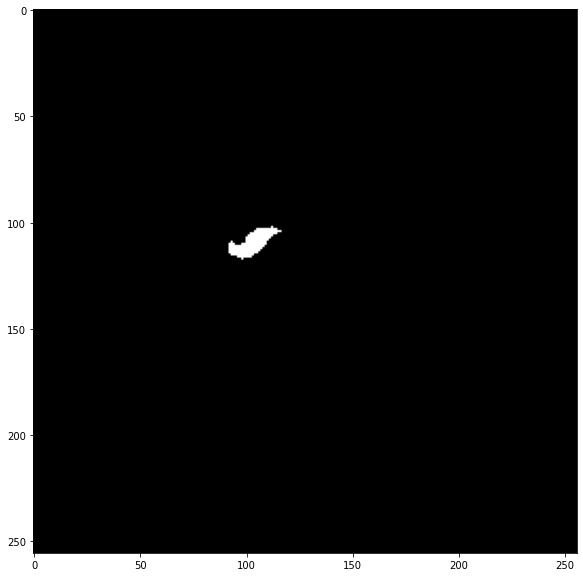

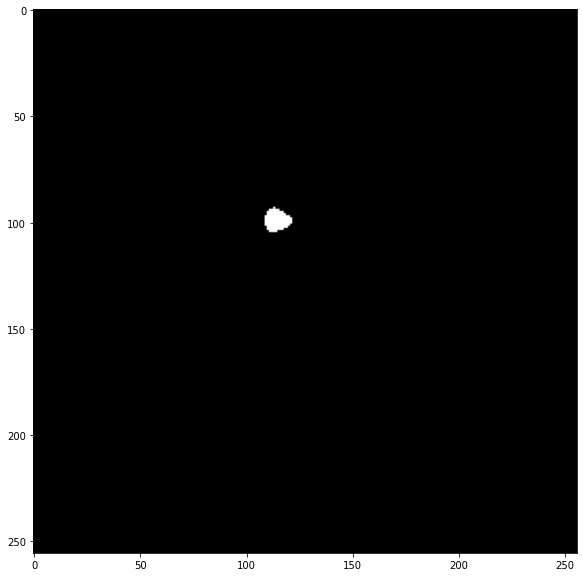

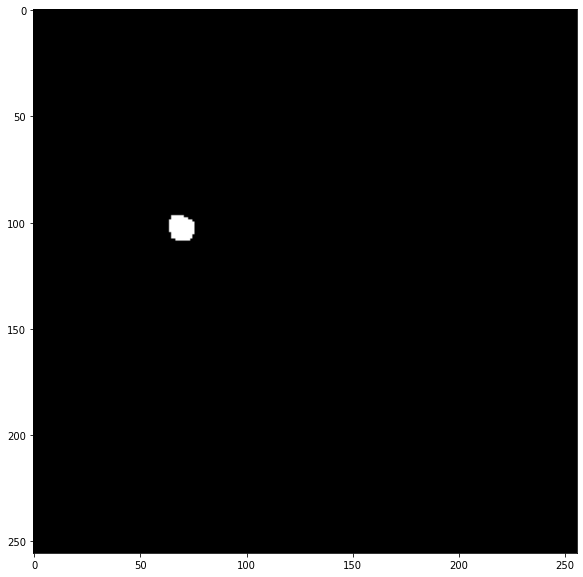

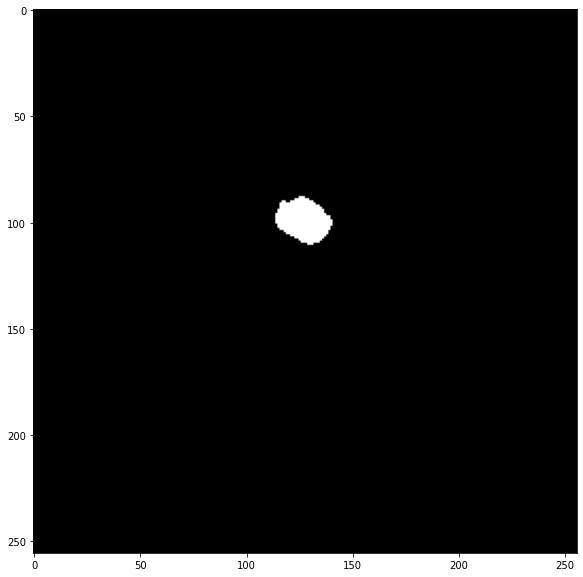

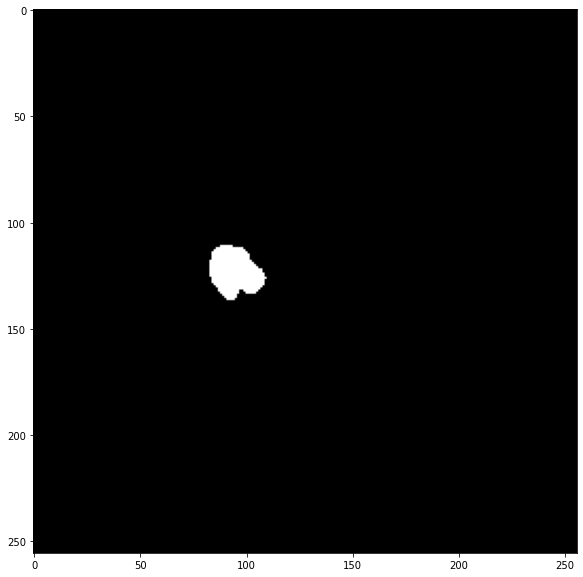

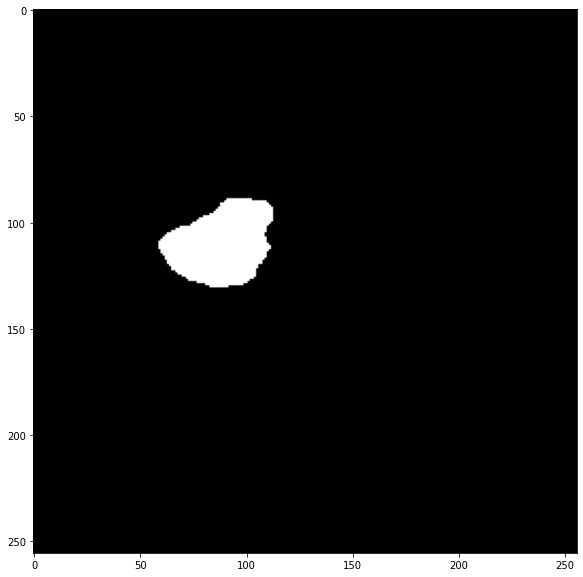

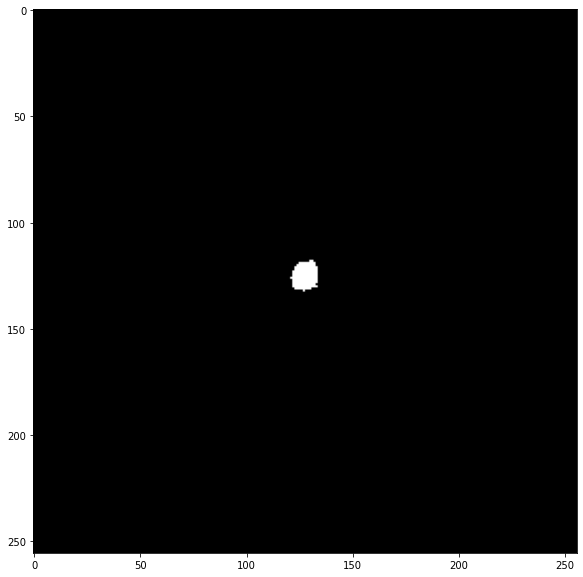

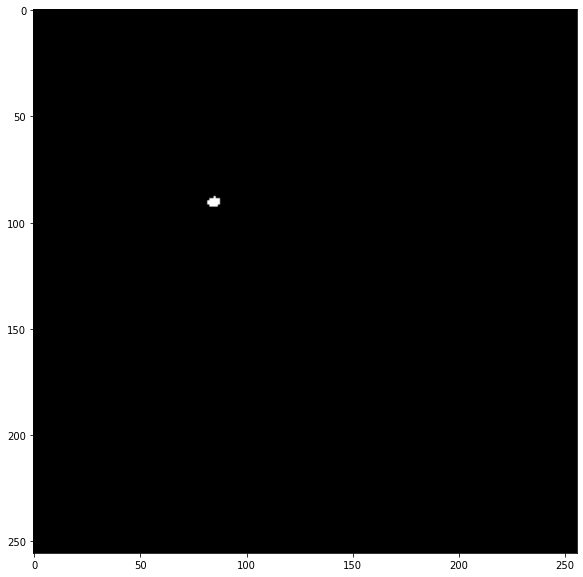

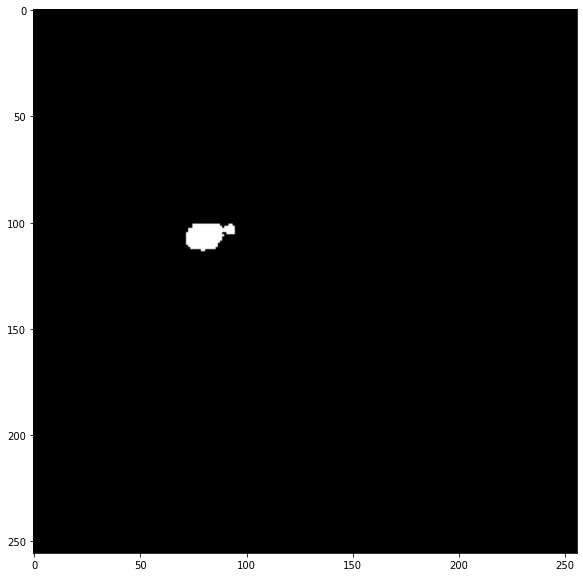

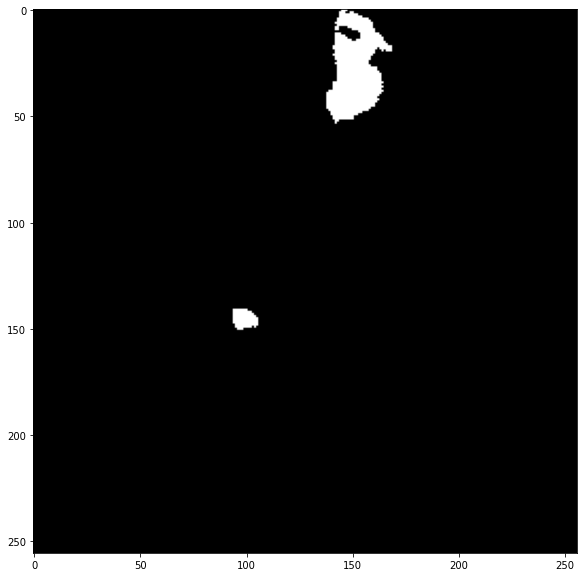

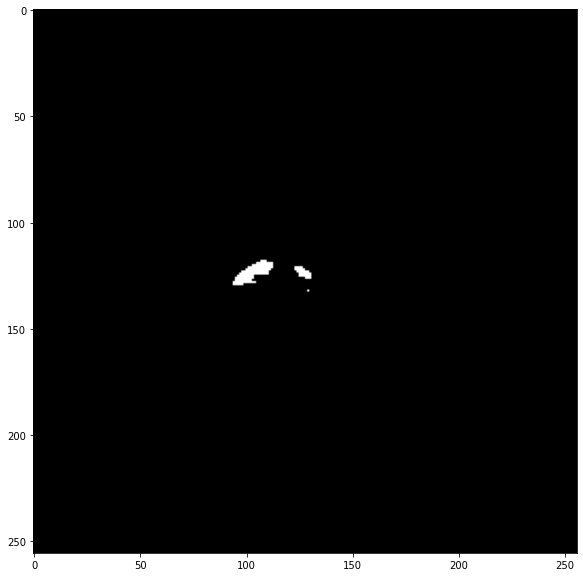

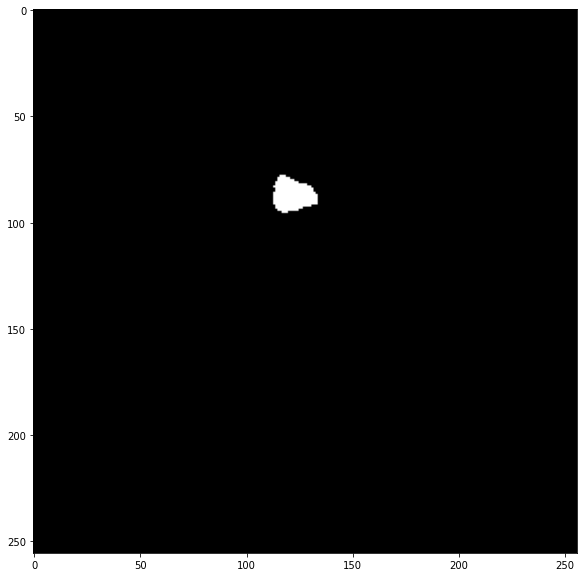

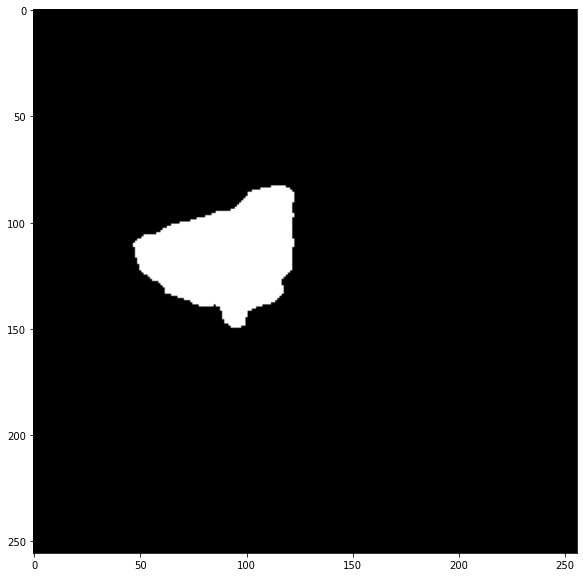

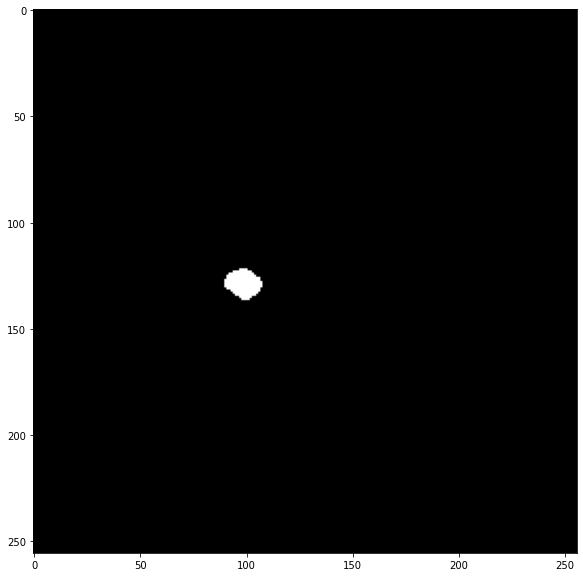

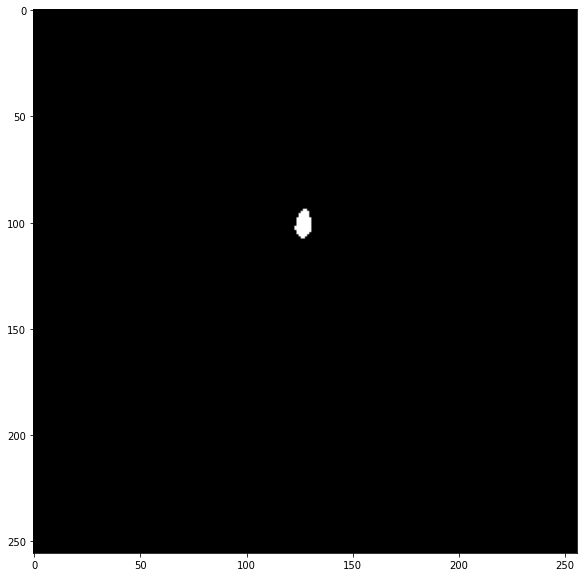

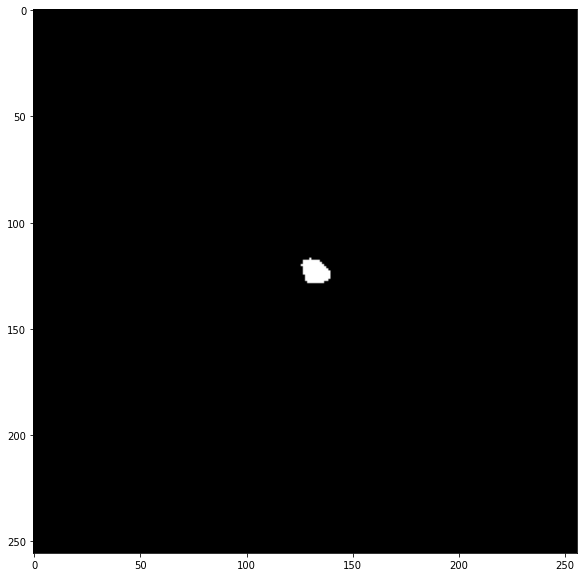

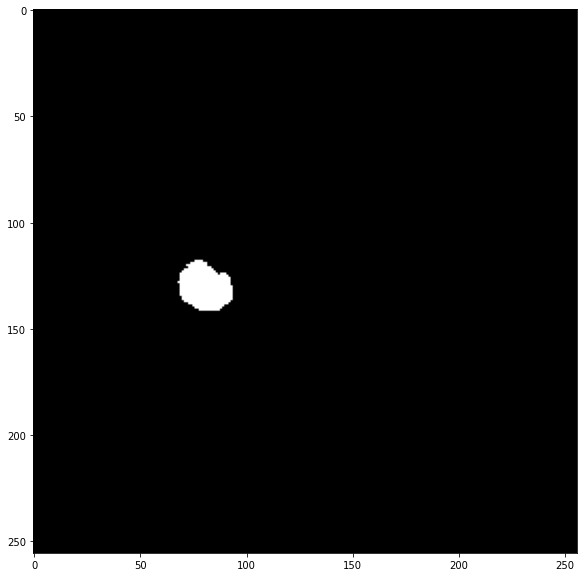

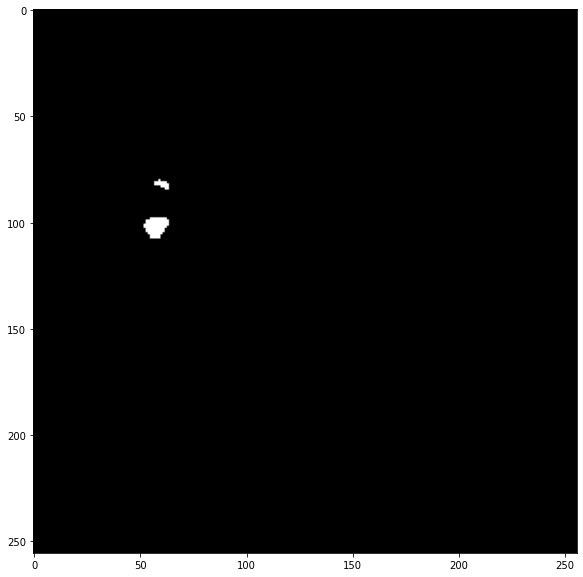

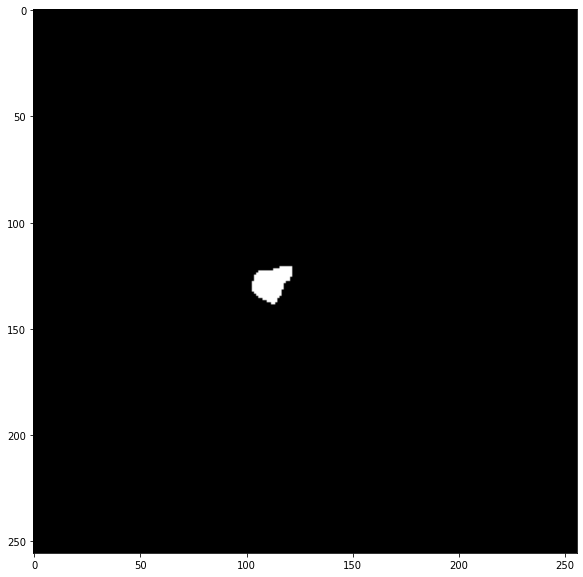

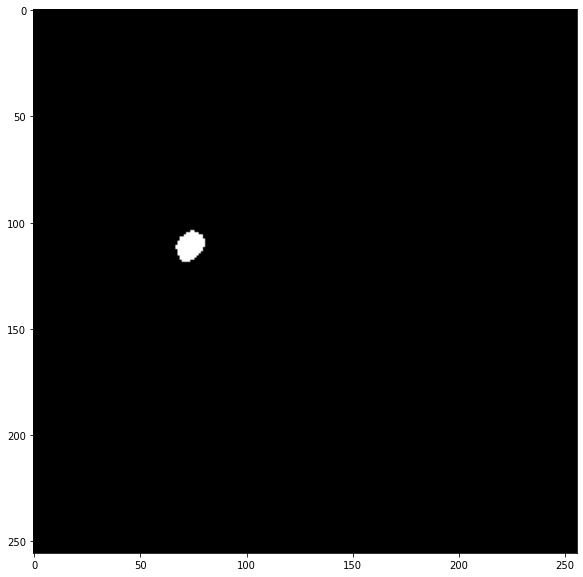

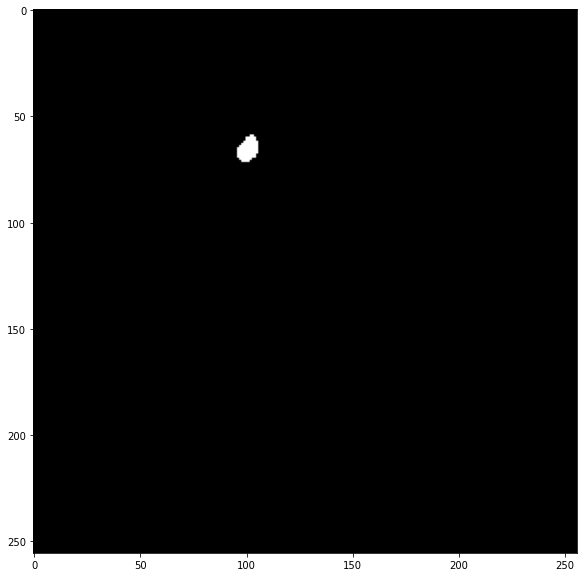

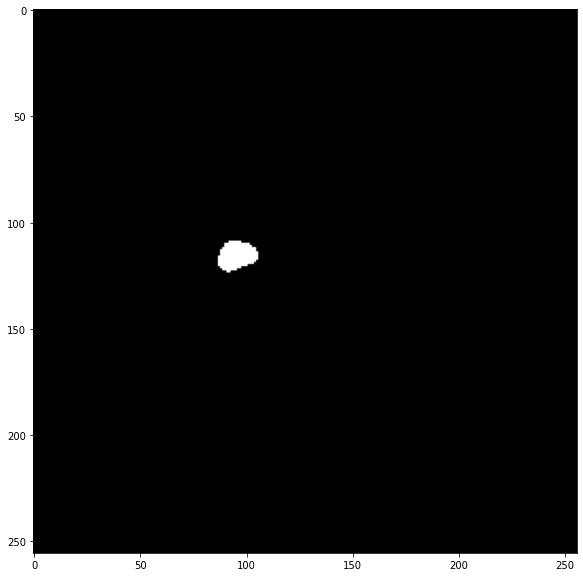

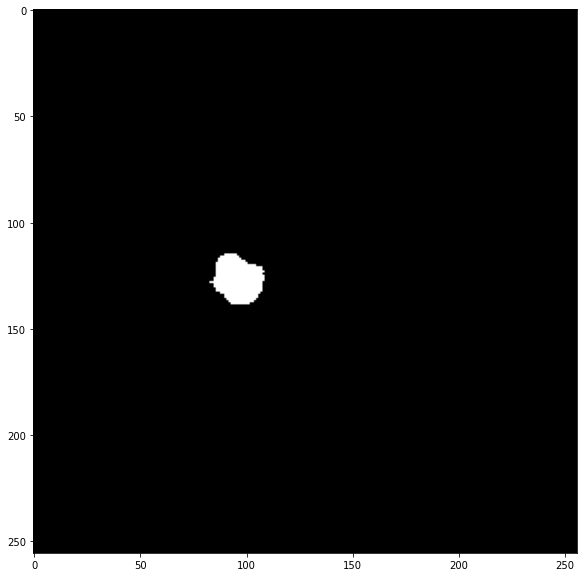

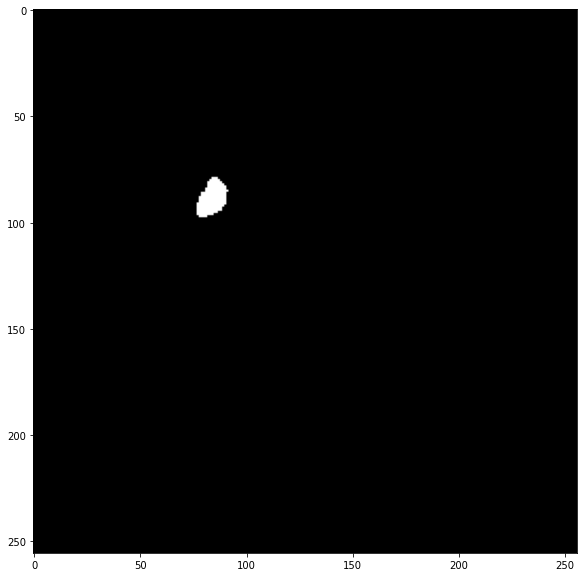

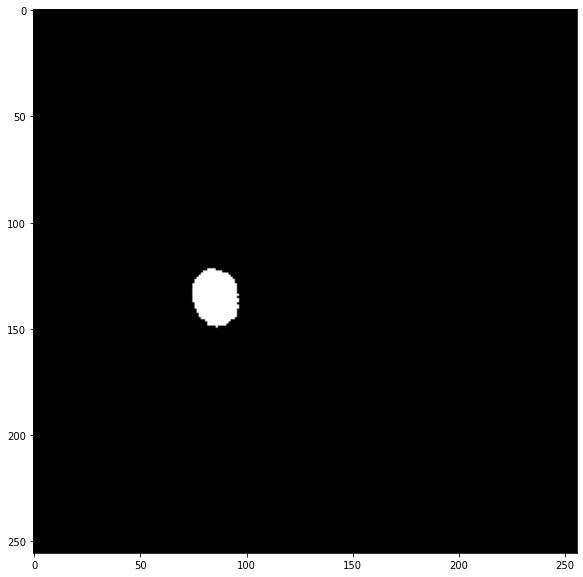

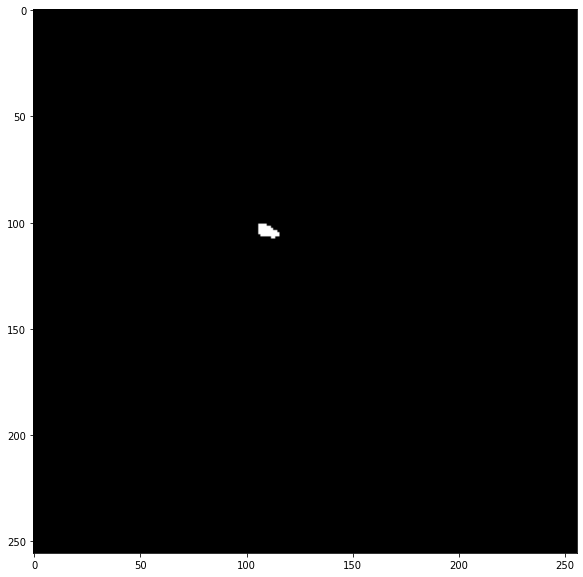

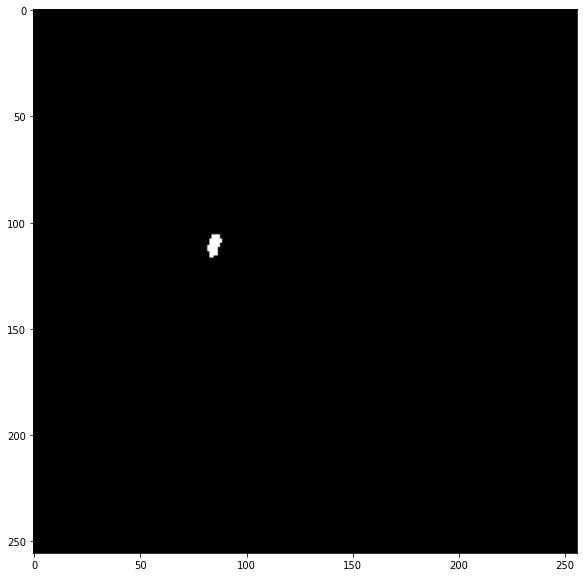

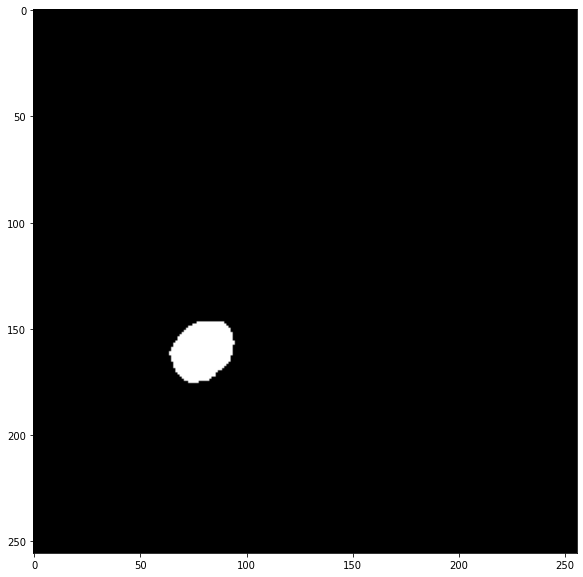

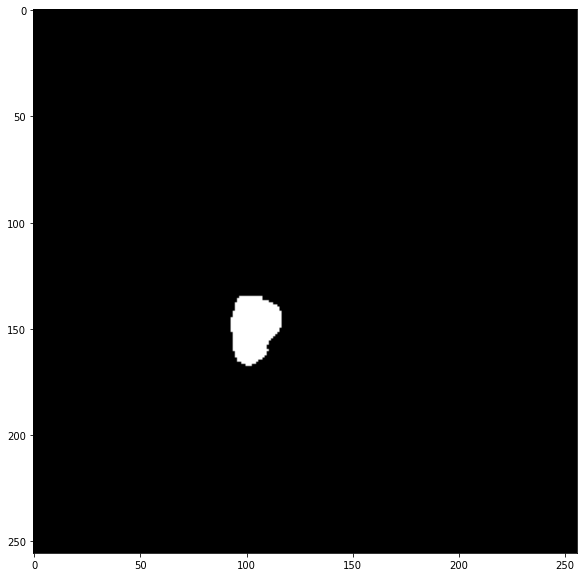

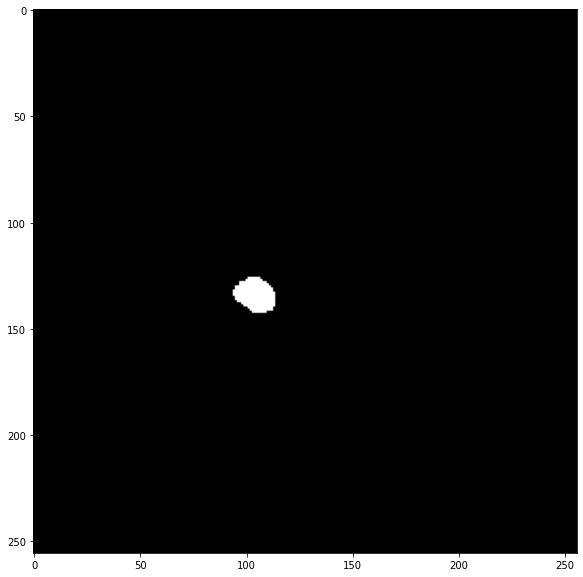

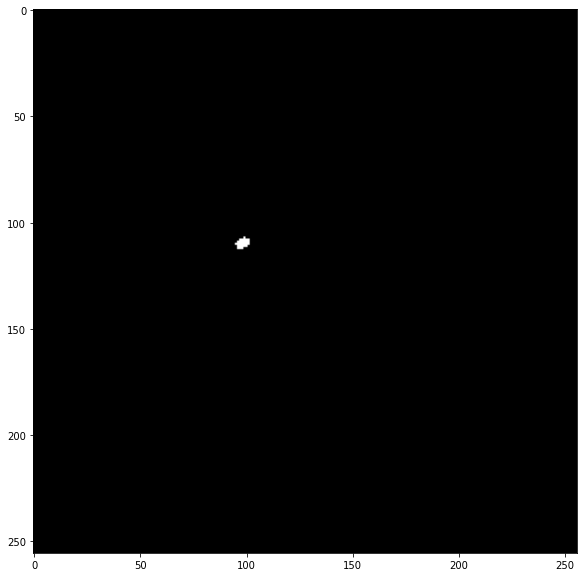

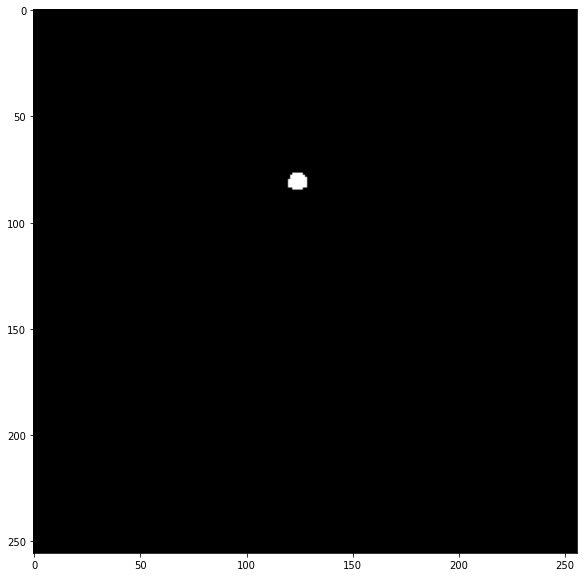

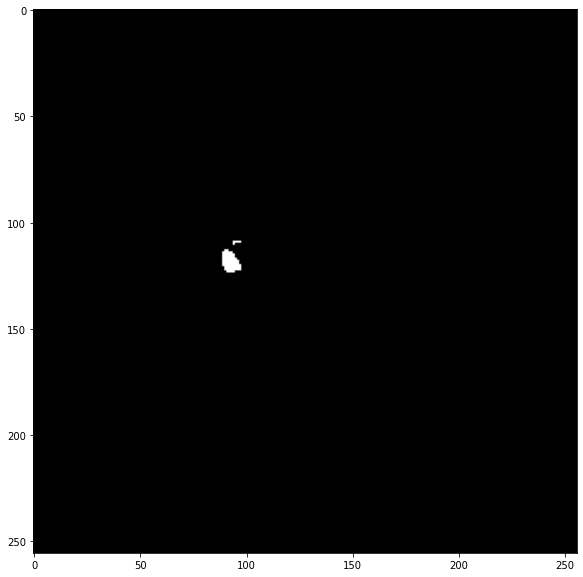

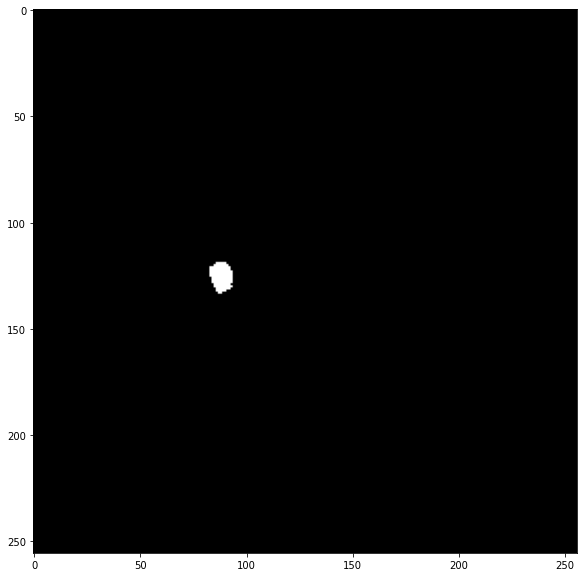

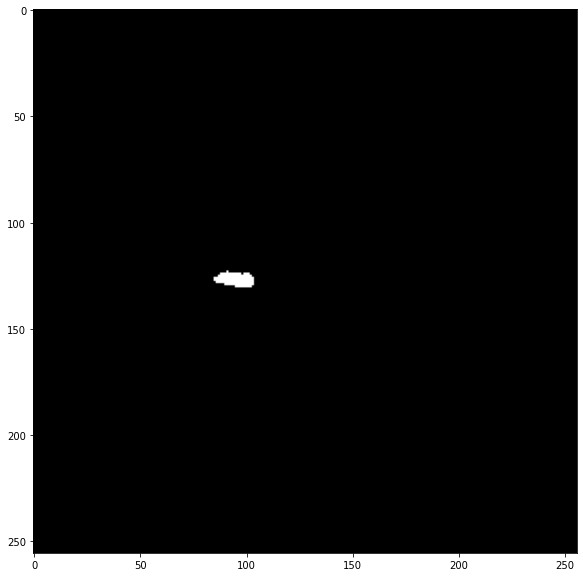

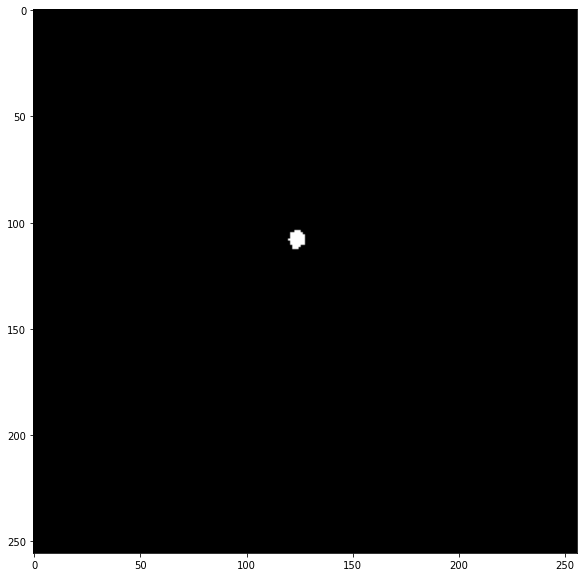

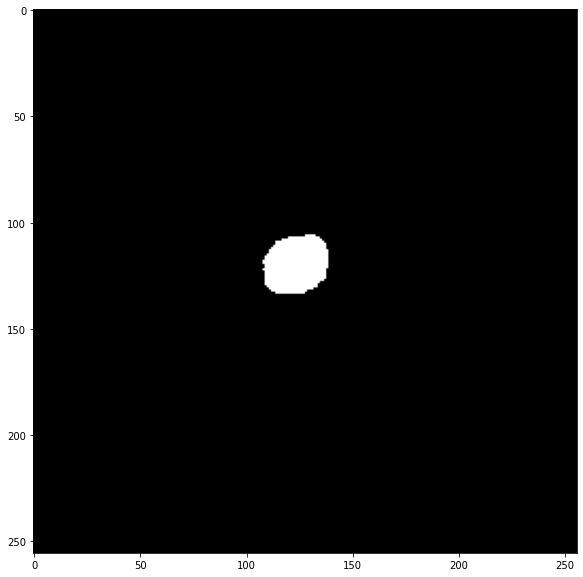

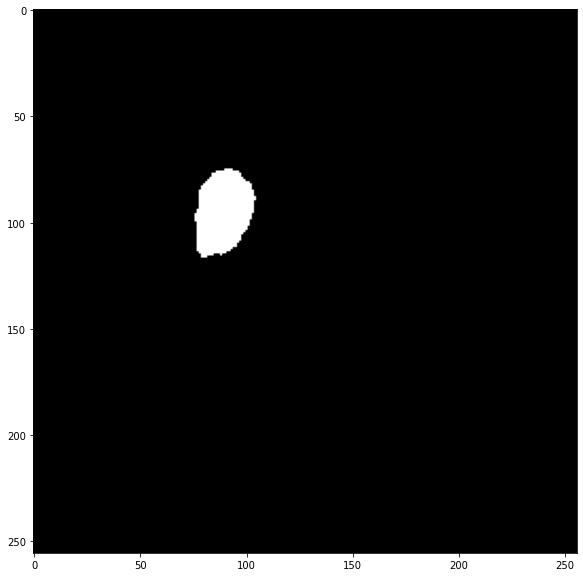

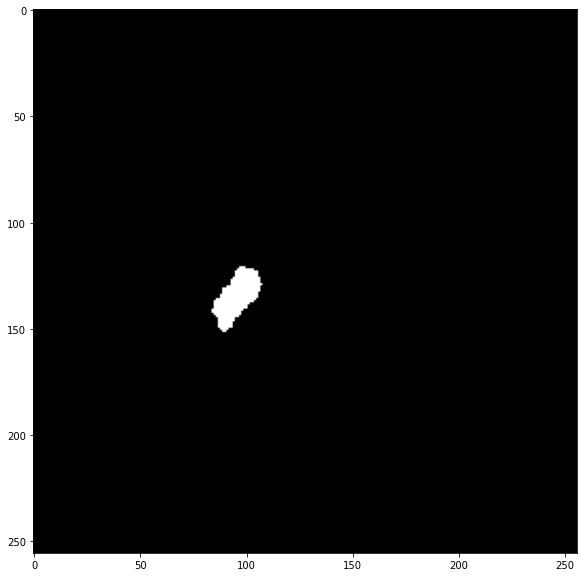

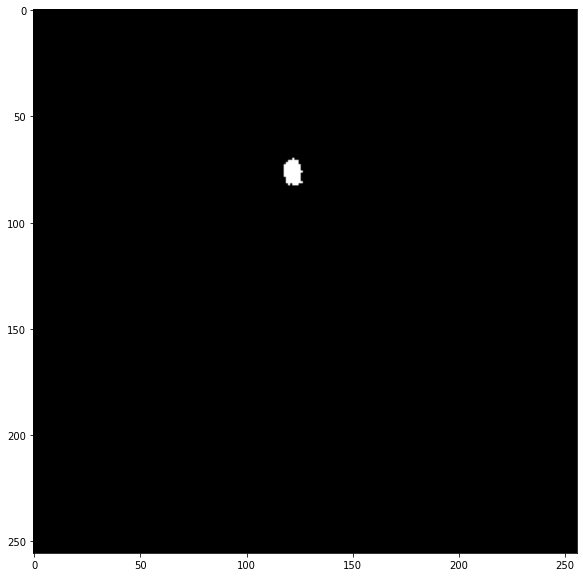

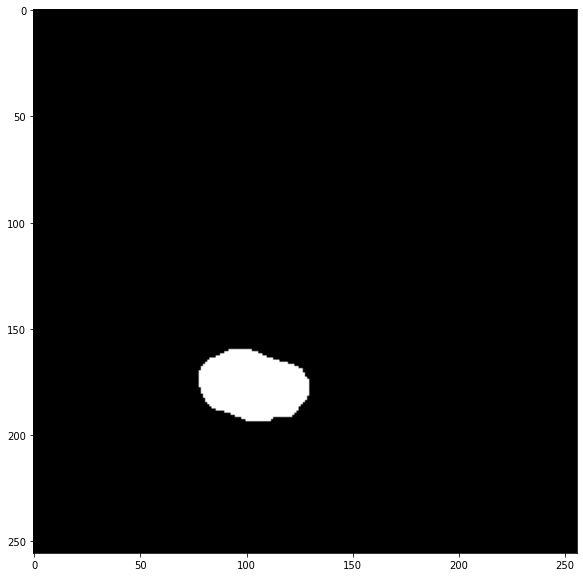

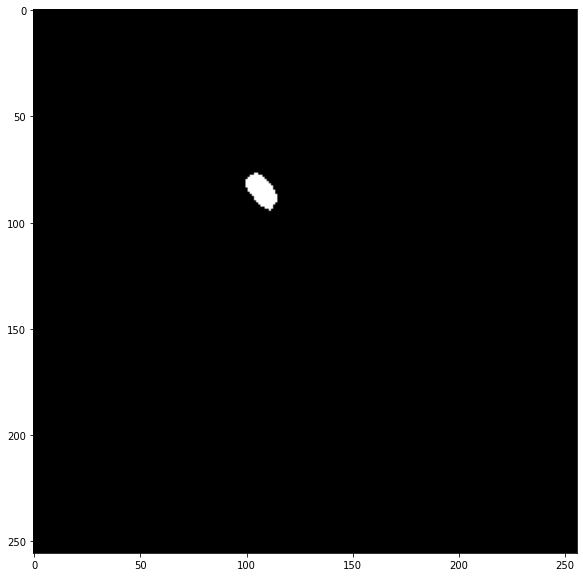

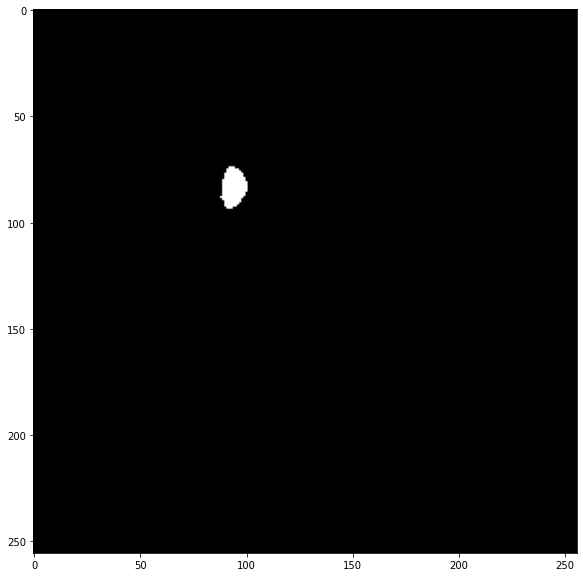

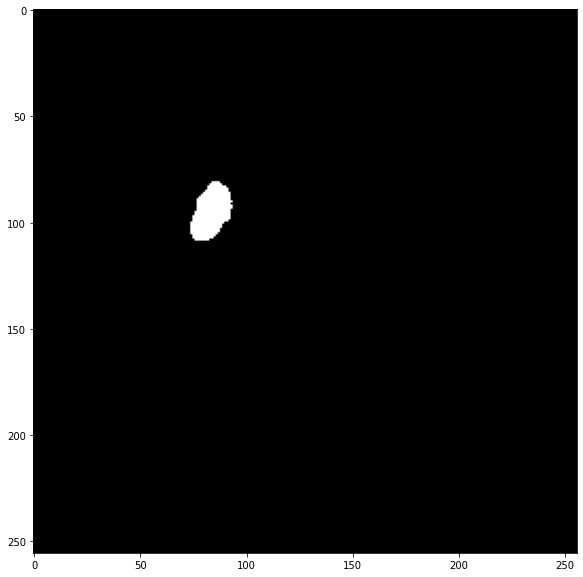

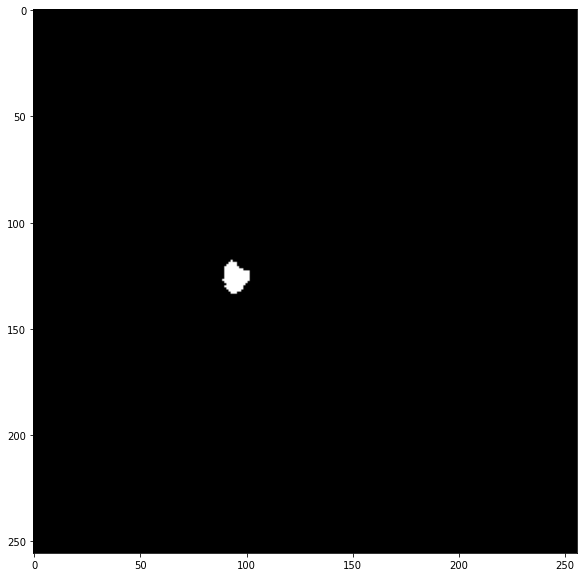

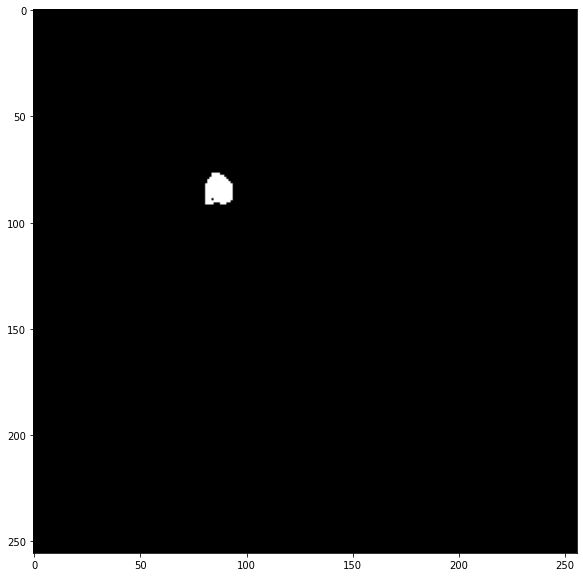

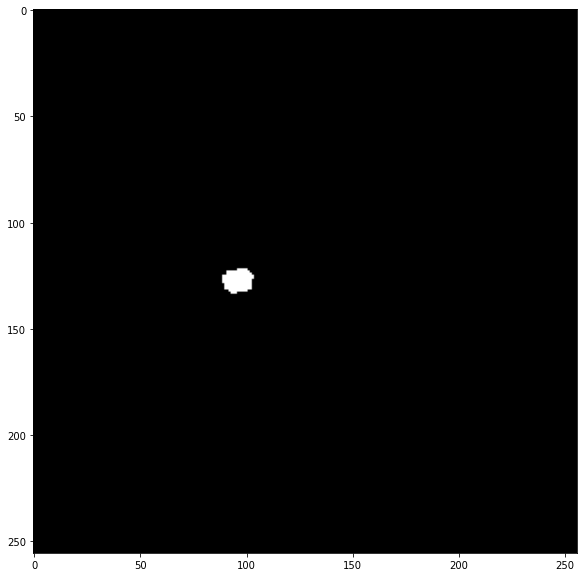

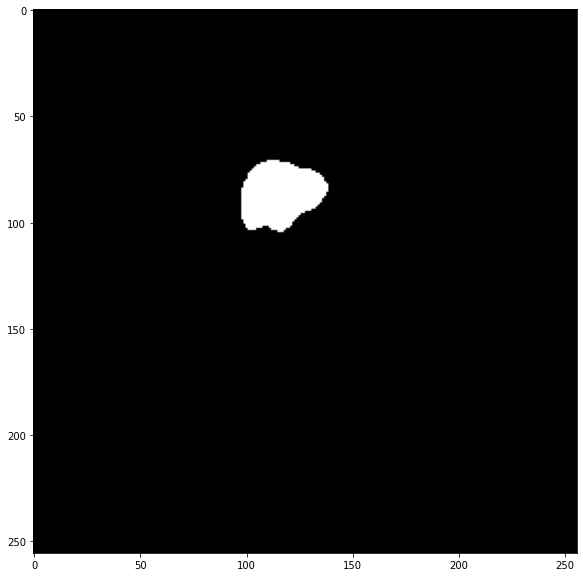

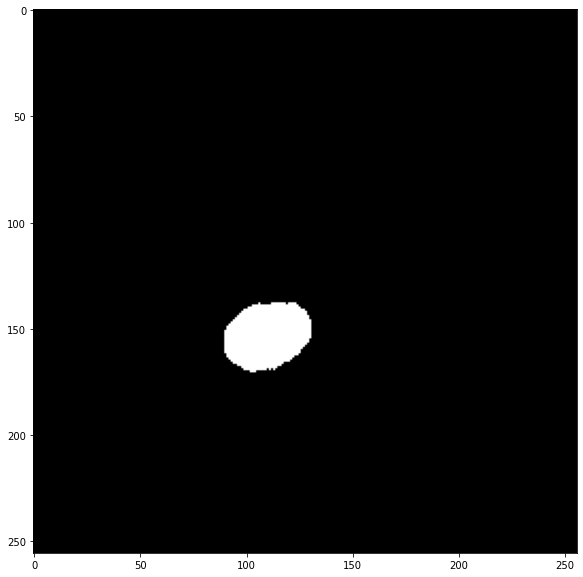

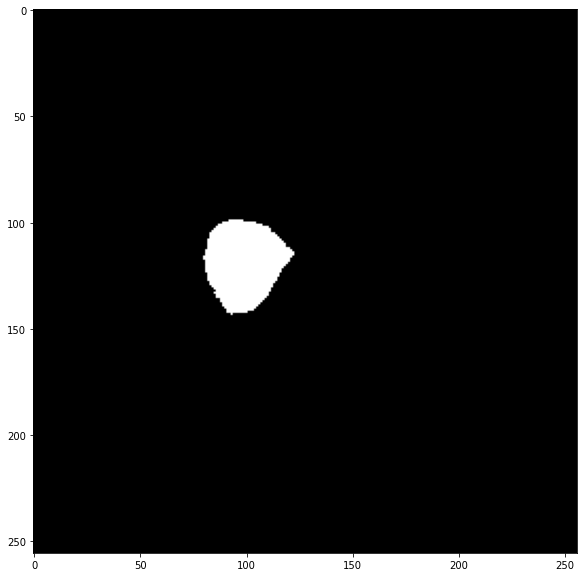

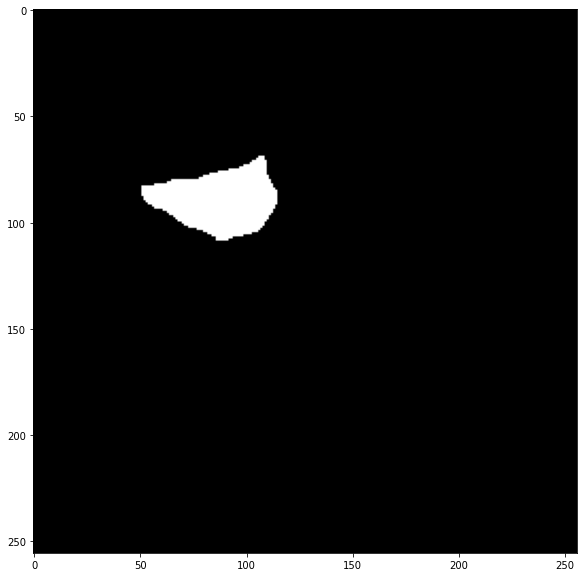

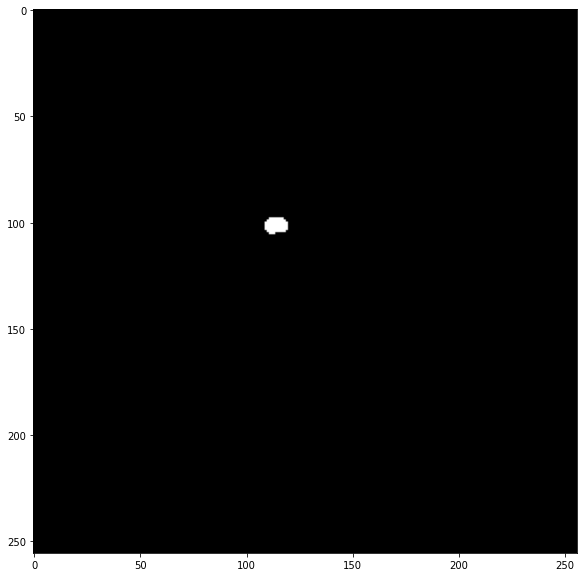

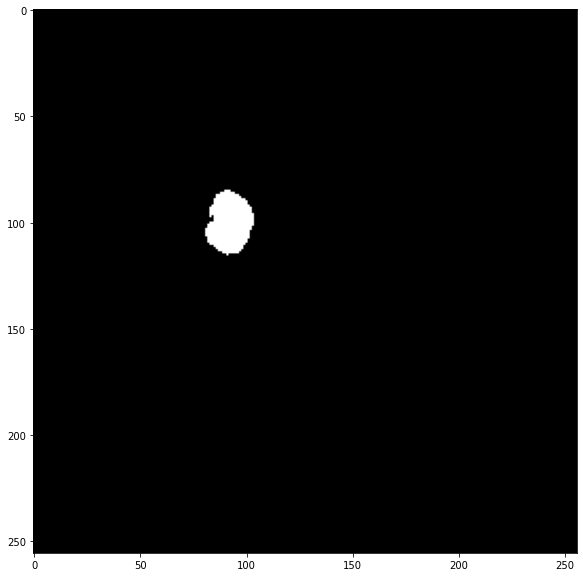

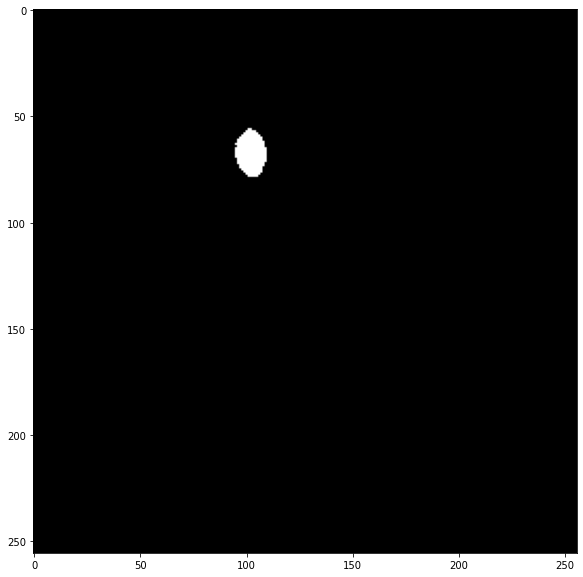

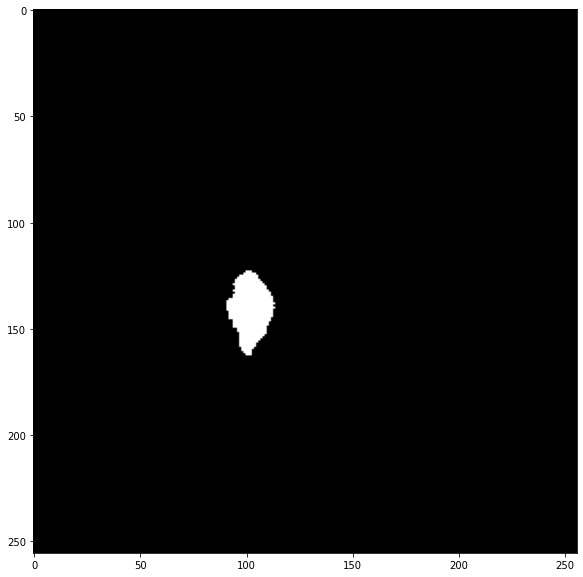

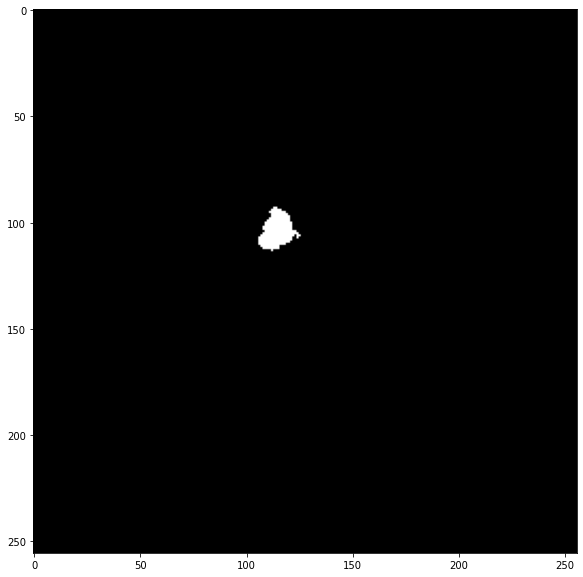

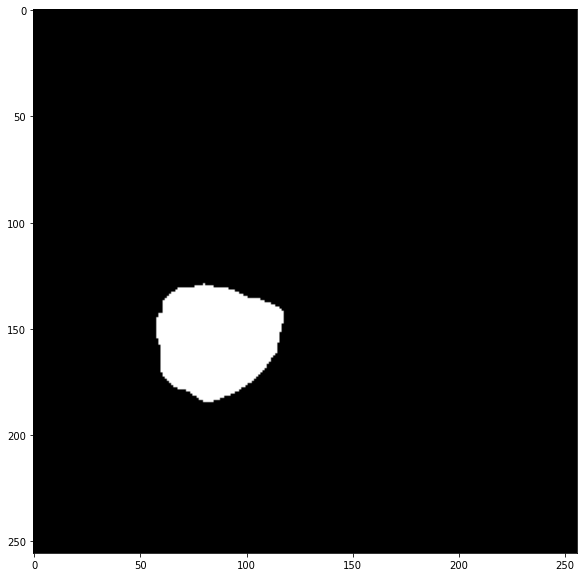

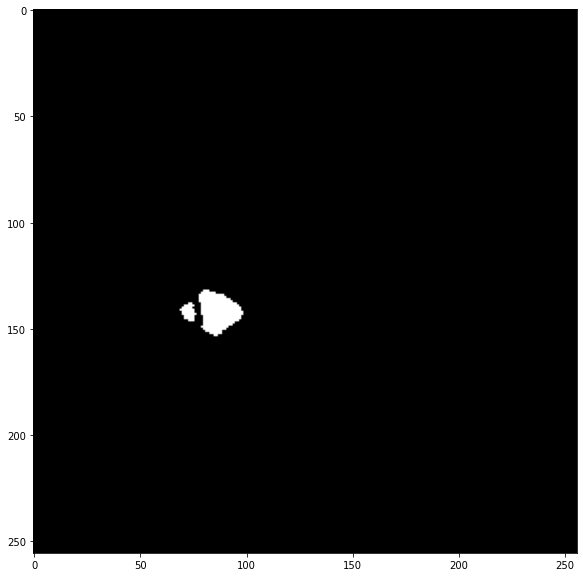

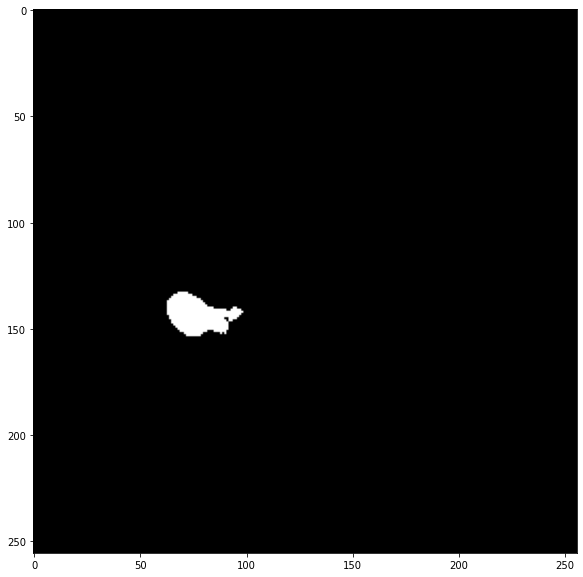

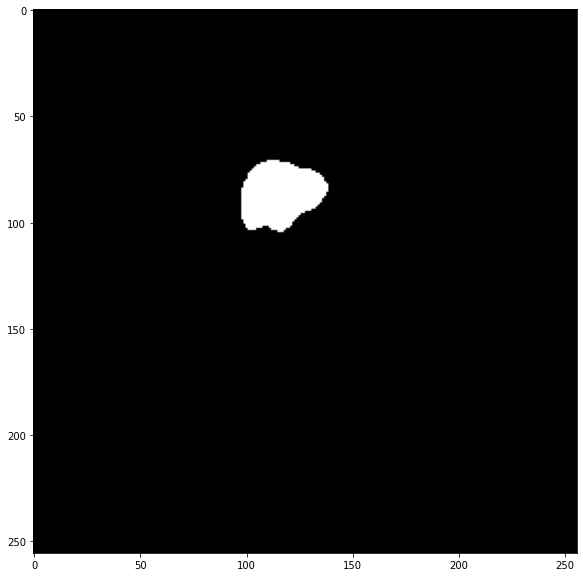

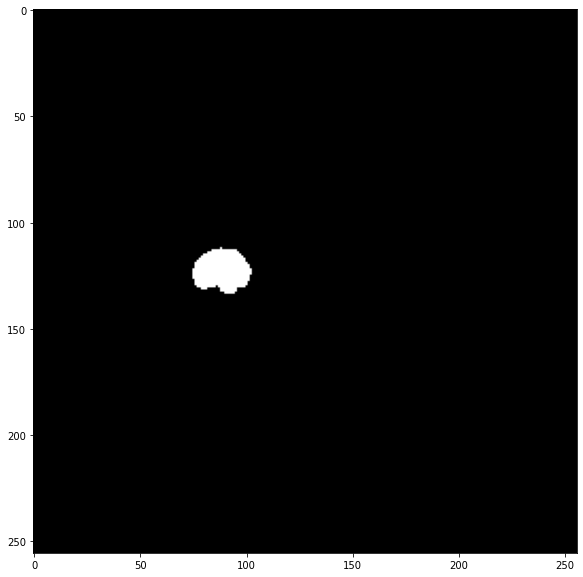

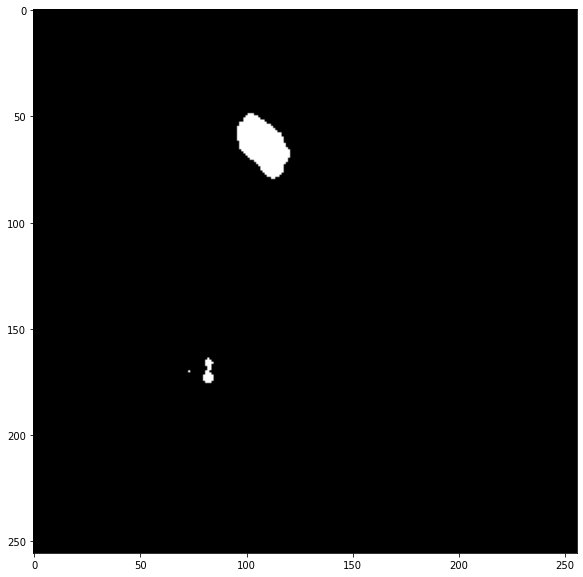

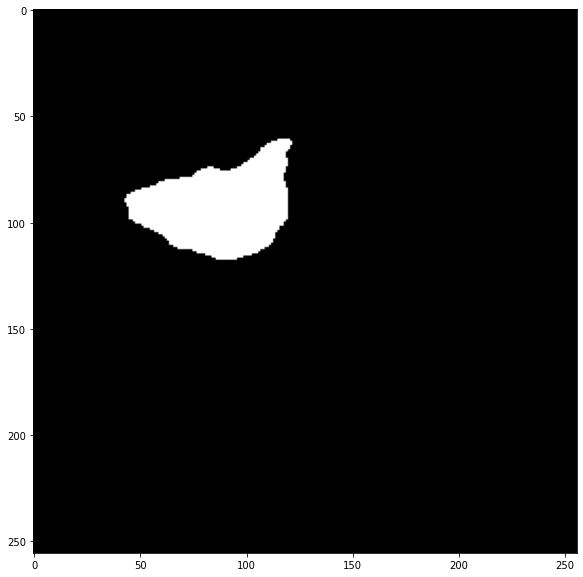

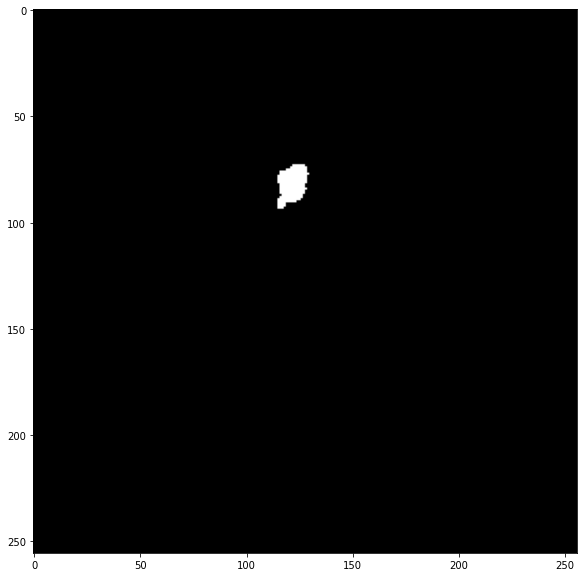

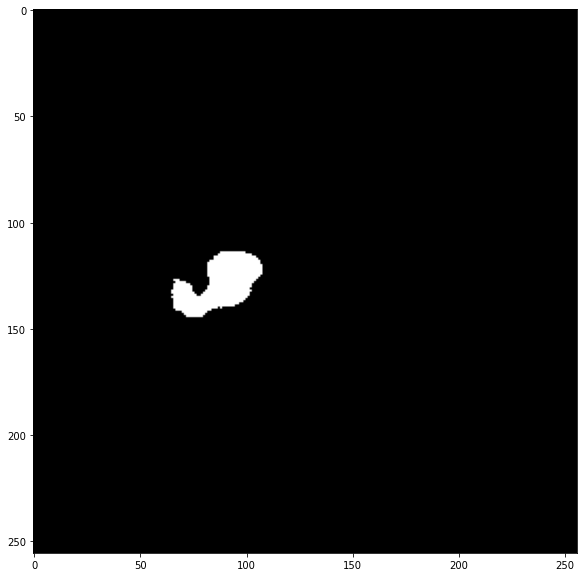

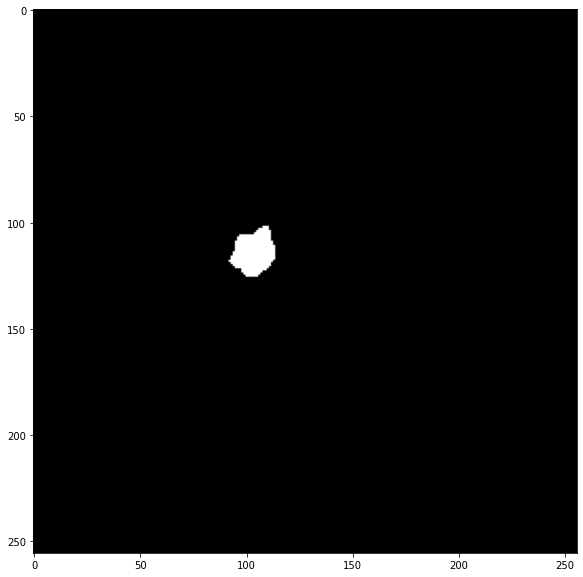

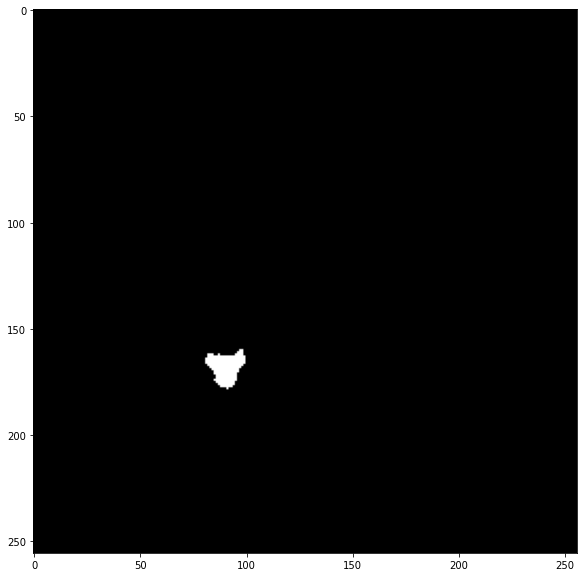

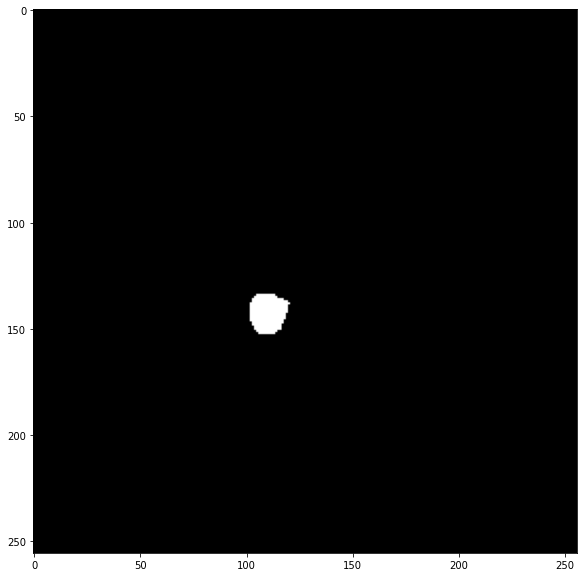

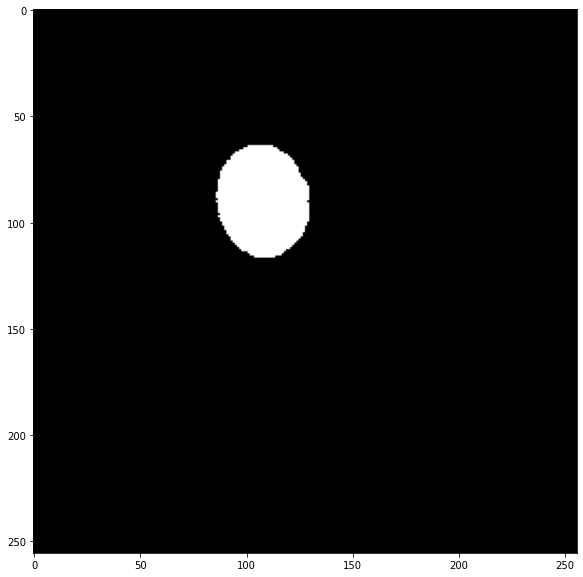

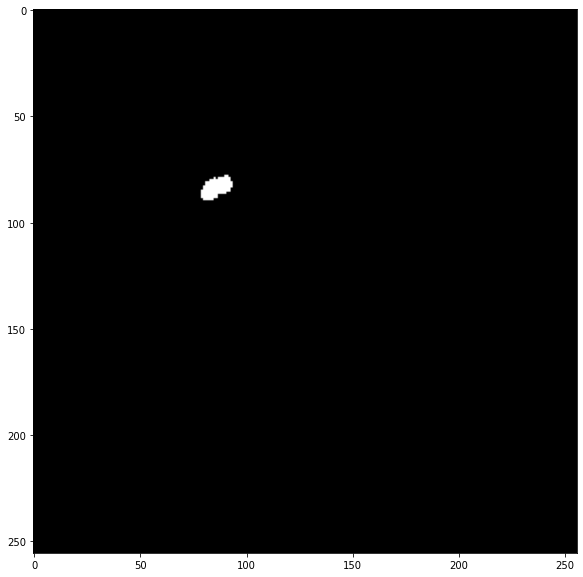

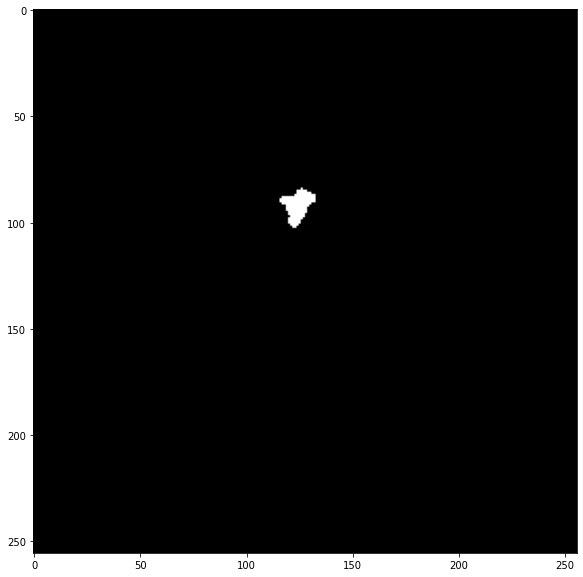

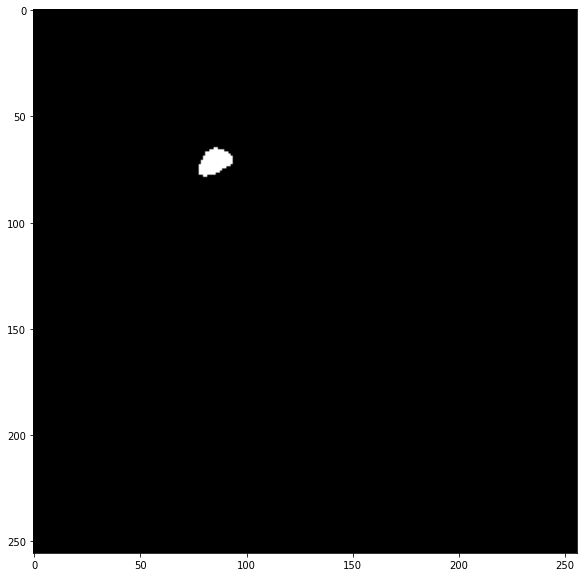

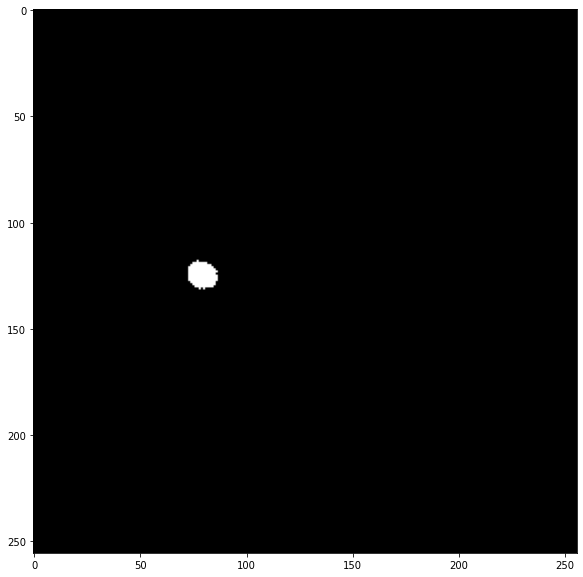

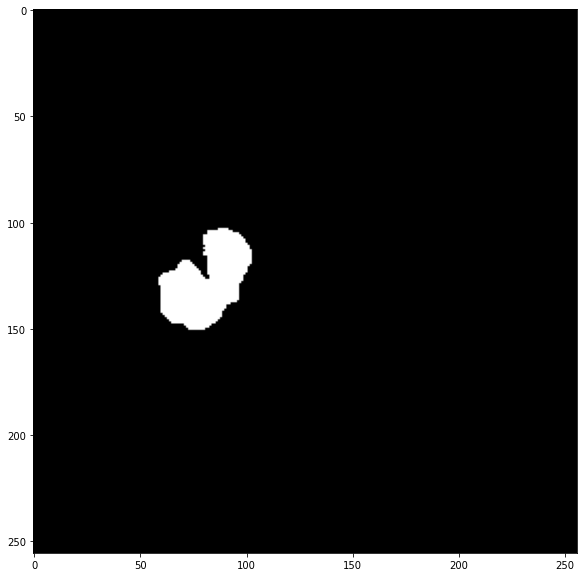

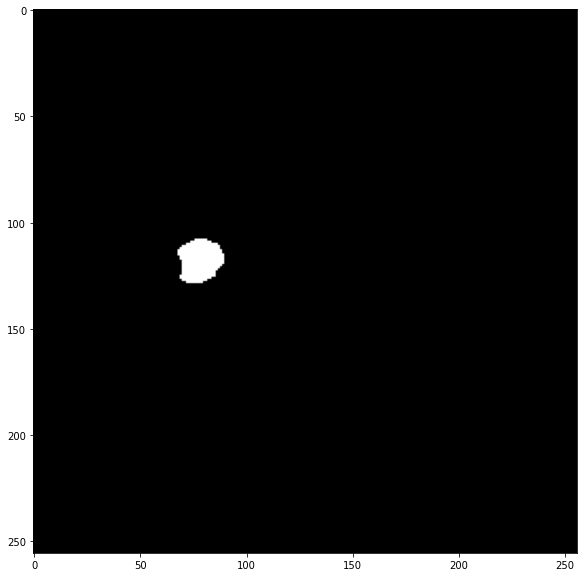

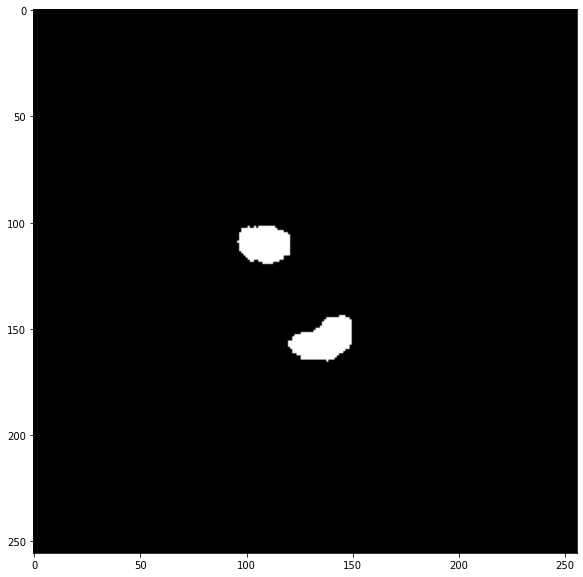

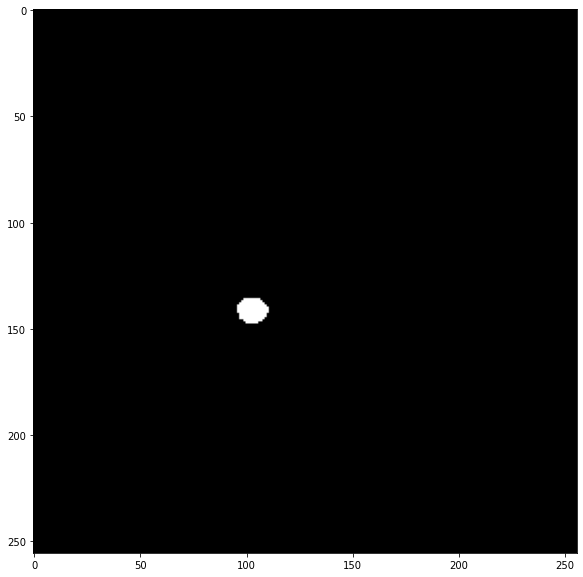

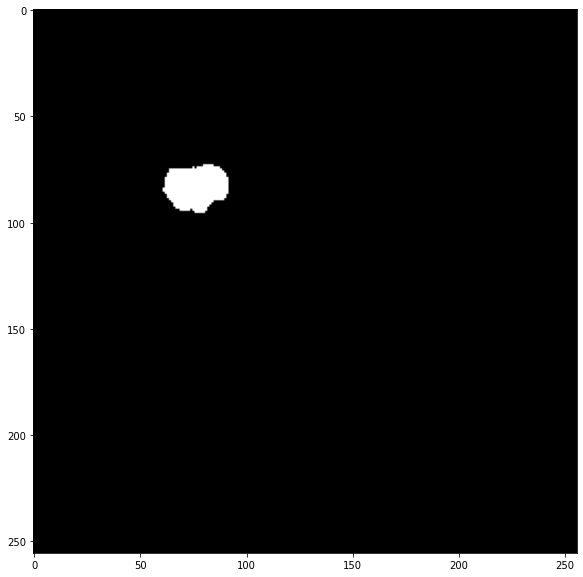

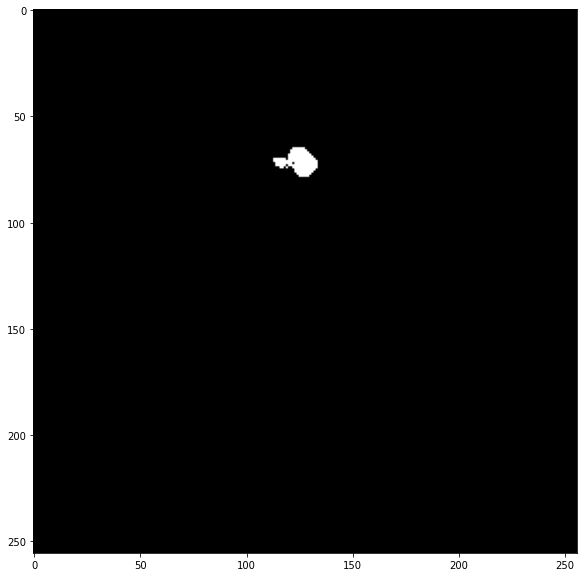

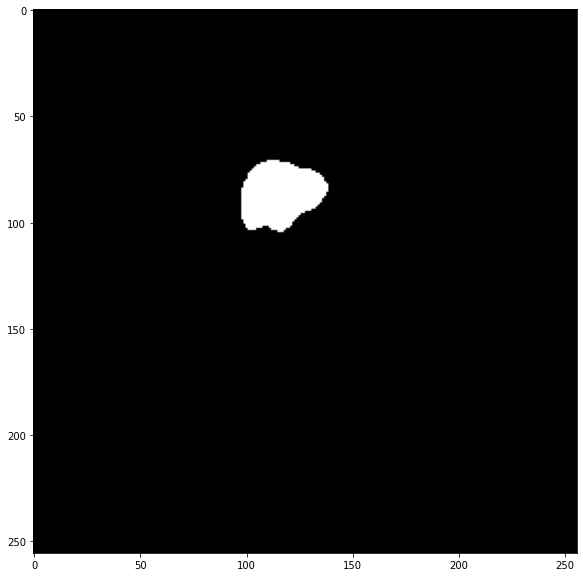

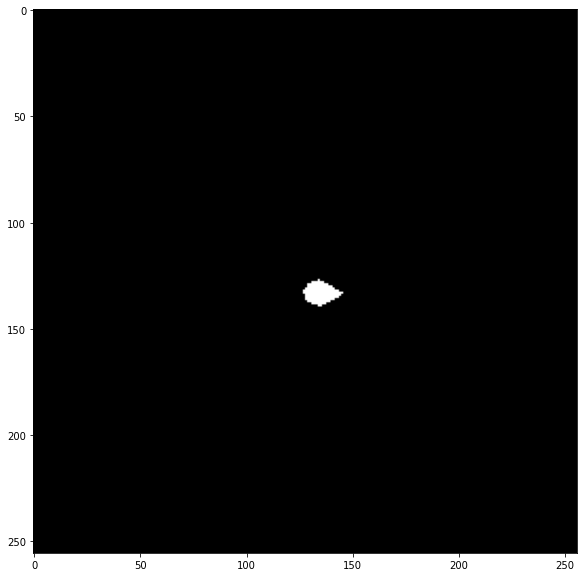

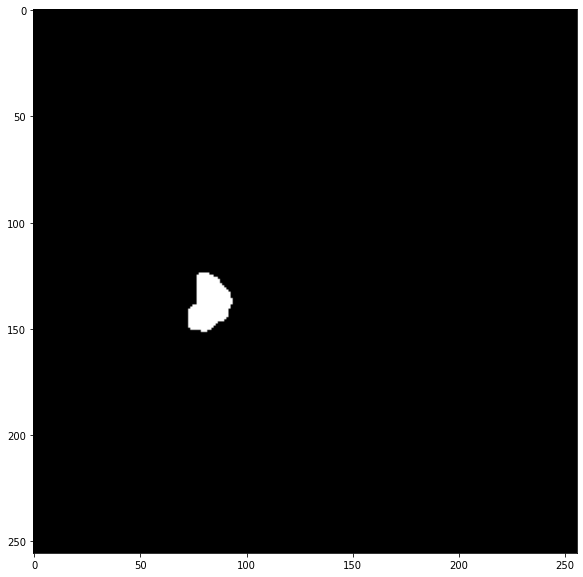

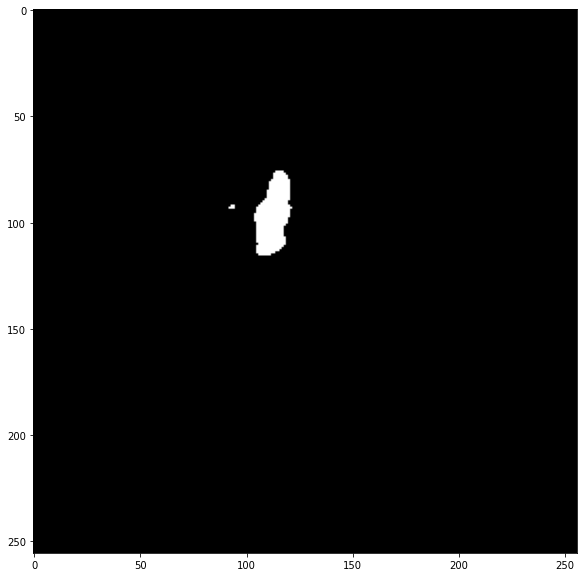

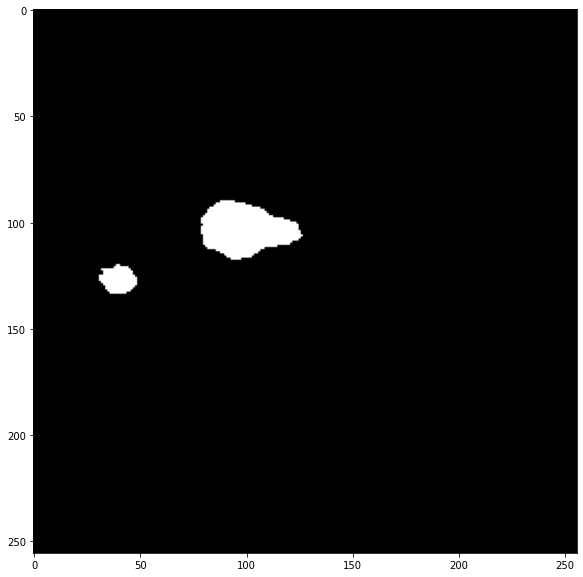

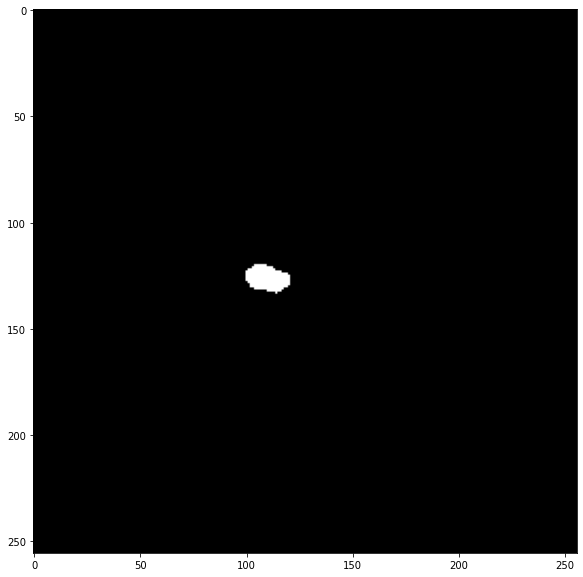

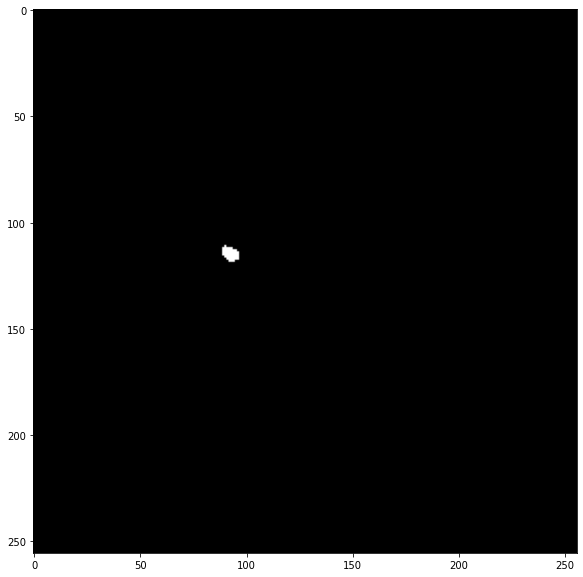

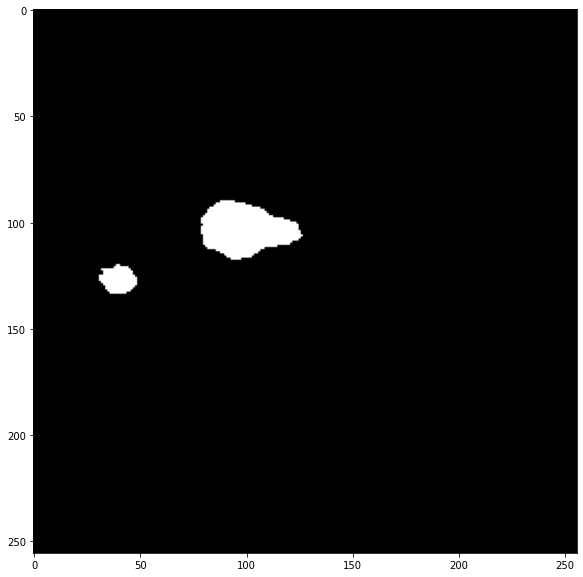

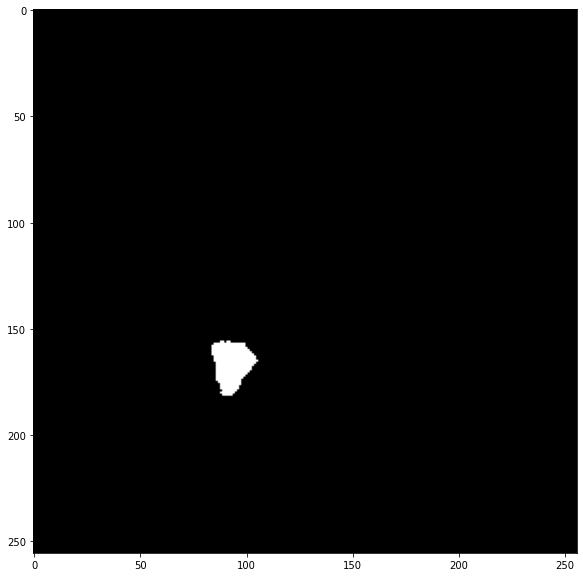

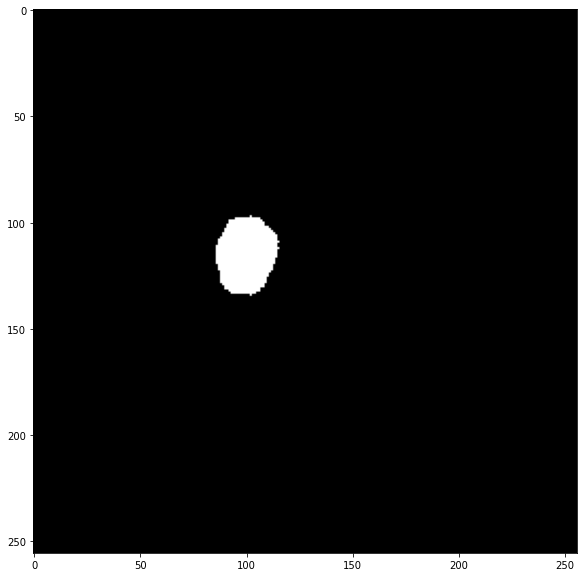

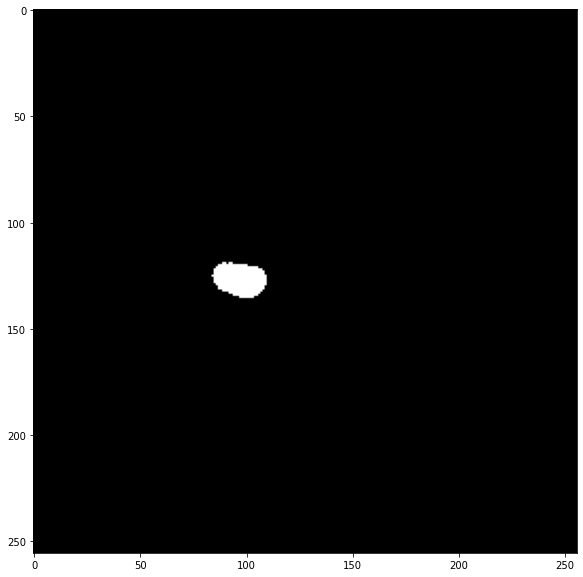

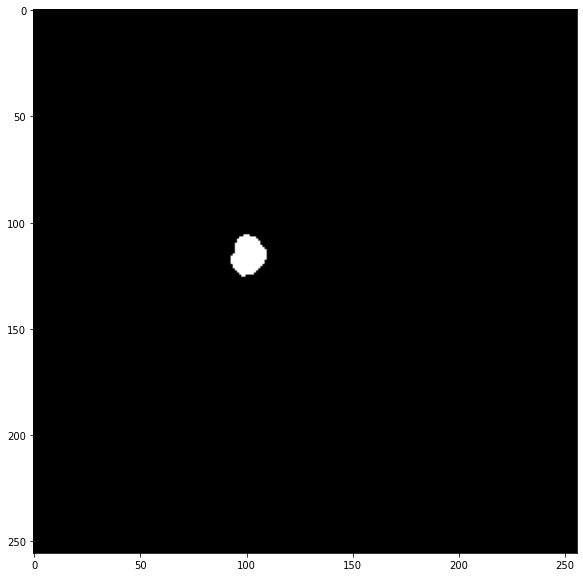

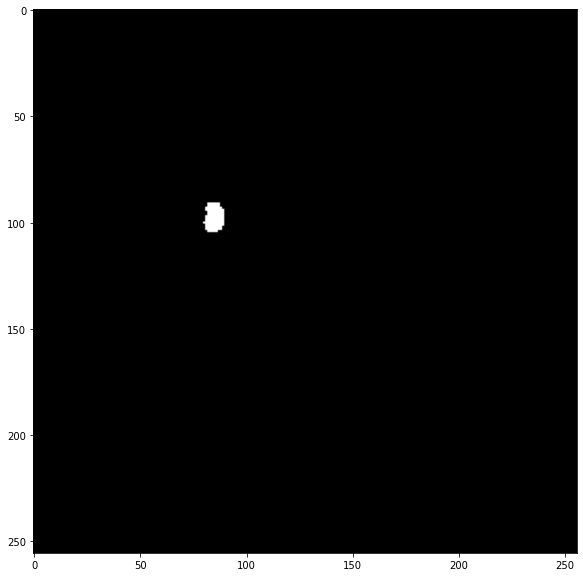

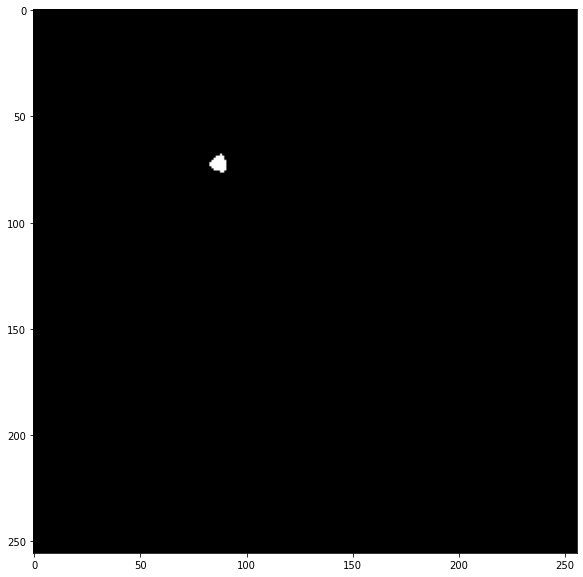

In [ ]:
# prediction of FCN
%%time
aa = 0
for image in test_dataset:
  pred_mask = model_fcn.predict(image)
  # print(pred_mask.shape)
  pred_mask[pred_mask > 0.5] = 1
  pred_mask[pred_mask <= 0.5] = 0
  pred_mask = pred_mask.squeeze()
  pred_mask = pred_mask[..., tf.newaxis]
  for i in range(10):
    # print(i)
    print(test_image[aa][35:])
    plt.figure(figsize=(10, 10))
    plt.imshow(tf.keras.preprocessing.image.array_to_img(tf.image.grayscale_to_rgb(tf.convert_to_tensor(pred_mask[i]))))
    plt.savefig('./Colab Notebooks/data/test/labels_FCN3/'+test_image[aa][35:])
    aa += 1


In [ ]:
# Segnet
inputs = tf.keras.Input(shape=(256, 256, 3))
# encoder
conv1 = tf.keras.layers.Conv2D(64, 3, padding='same', kernel_initializer='he_normal')(inputs)
bn1 = tf.keras.layers.BatchNormalization()(conv1)
ac1 = tf.keras.layers.Activation('relu')(bn1)
conv1 = tf.keras.layers.Conv2D(64, 3, padding='same', kernel_initializer='he_normal')(ac1)
bn1 = tf.keras.layers.BatchNormalization()(conv1)
ac1 = tf.keras.layers.Activation('relu')(bn1)
pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(ac1)

conv2 = tf.keras.layers.Conv2D(128, 3, padding='same', kernel_initializer='he_normal')(pool1)
bn2 = tf.keras.layers.BatchNormalization()(conv2)
ac2 = tf.keras.layers.Activation('relu')(bn2)
conv2 = tf.keras.layers.Conv2D(128, 3, padding='same', kernel_initializer='he_normal')(ac2)
bn2 = tf.keras.layers.BatchNormalization()(conv2)
ac2 = tf.keras.layers.Activation('relu')(bn2)
pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(ac2)

conv3 = tf.keras.layers.Conv2D(256, 3, padding='same', kernel_initializer='he_normal')(pool2)
bn3 = tf.keras.layers.BatchNormalization()(conv3)
ac3 = tf.keras.layers.Activation('relu')(bn3)
conv3 = tf.keras.layers.Conv2D(256, 3, padding='same', kernel_initializer='he_normal')(ac3)
bn3 = tf.keras.layers.BatchNormalization()(conv3)
ac3 = tf.keras.layers.Activation('relu')(bn3)
conv3 = tf.keras.layers.Conv2D(256, 3, padding='same', kernel_initializer='he_normal')(ac3)
bn3 = tf.keras.layers.BatchNormalization()(conv3)
ac3 = tf.keras.layers.Activation('relu')(bn3)
pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(ac3)

conv4 = tf.keras.layers.Conv2D(512, 3, padding='same', kernel_initializer='he_normal')(pool3)
bn4 = tf.keras.layers.BatchNormalization()(conv4)
ac4 = tf.keras.layers.Activation('relu')(bn4)
conv4 = tf.keras.layers.Conv2D(512, 3, padding='same', kernel_initializer='he_normal')(ac4)
bn4 = tf.keras.layers.BatchNormalization()(conv4)
ac4 = tf.keras.layers.Activation('relu')(bn4)
conv4 = tf.keras.layers.Conv2D(512, 3, padding='same', kernel_initializer='he_normal')(ac4)
bn4 = tf.keras.layers.BatchNormalization()(conv4)
ac4 = tf.keras.layers.Activation('relu')(bn4)
pool4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(ac4)

conv5 = tf.keras.layers.Conv2D(512, 3, padding='same', kernel_initializer='he_normal')(pool4)
bn5 = tf.keras.layers.BatchNormalization()(conv5)
ac5 = tf.keras.layers.Activation('relu')(bn5)
conv5 = tf.keras.layers.Conv2D(512, 3, padding='same', kernel_initializer='he_normal')(ac5)
bn5 = tf.keras.layers.BatchNormalization()(conv5)
ac5 = tf.keras.layers.Activation('relu')(bn5)
conv5 = tf.keras.layers.Conv2D(512, 3, padding='same', kernel_initializer='he_normal')(ac5)
bn5 = tf.keras.layers.BatchNormalization()(conv5)
ac5 = tf.keras.layers.Activation('relu')(bn5)
pool5 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(ac5)

# decoder
uppool1 = tf.keras.layers.UpSampling2D()(pool5)
conv6 = tf.keras.layers.Conv2D(512, 3, padding='same', kernel_initializer='he_normal')(uppool1)
bn6 = tf.keras.layers.BatchNormalization()(conv6)
ac6 = tf.keras.layers.Activation('relu')(bn6)
conv6 = tf.keras.layers.Conv2D(512, 3, padding='same', kernel_initializer='he_normal')(ac6)
bn6 = tf.keras.layers.BatchNormalization()(conv6)
ac6 = tf.keras.layers.Activation('relu')(bn6)
conv6 = tf.keras.layers.Conv2D(512, 3, padding='same', kernel_initializer='he_normal')(ac6)
bn6 = tf.keras.layers.BatchNormalization()(conv6)
ac6 = tf.keras.layers.Activation('relu')(bn6)

uppool2 = tf.keras.layers.UpSampling2D()(ac6)
conv7 = tf.keras.layers.Conv2D(512, 3, padding='same', kernel_initializer='he_normal')(uppool2)
bn7 = tf.keras.layers.BatchNormalization()(conv7)
ac7 = tf.keras.layers.Activation('relu')(bn7)
conv7 = tf.keras.layers.Conv2D(512, 3, padding='same', kernel_initializer='he_normal')(ac7)
bn7 = tf.keras.layers.BatchNormalization()(conv7)
ac7 = tf.keras.layers.Activation('relu')(bn7)
conv7 = tf.keras.layers.Conv2D(256, 3, padding='same', kernel_initializer='he_normal')(ac7)
bn7 = tf.keras.layers.BatchNormalization()(conv7)
ac7 = tf.keras.layers.Activation('relu')(bn7)

uppool3 = tf.keras.layers.UpSampling2D()(ac7)
conv8 = tf.keras.layers.Conv2D(256, 3, padding='same', kernel_initializer='he_normal')(uppool3)
bn8 = tf.keras.layers.BatchNormalization()(conv8)
ac8 = tf.keras.layers.Activation('relu')(bn8)
conv8 = tf.keras.layers.Conv2D(256, 3, padding='same', kernel_initializer='he_normal')(ac8)
bn8 = tf.keras.layers.BatchNormalization()(conv8)
ac8 = tf.keras.layers.Activation('relu')(bn8)
conv8 = tf.keras.layers.Conv2D(128, 3, padding='same', kernel_initializer='he_normal')(ac8)
bn8 = tf.keras.layers.BatchNormalization()(conv8)
ac8 = tf.keras.layers.Activation('relu')(bn8)

uppool4 = tf.keras.layers.UpSampling2D()(ac8)
conv9 = tf.keras.layers.Conv2D(128, 3, padding='same', kernel_initializer='he_normal')(uppool4)
bn9 = tf.keras.layers.BatchNormalization()(conv9)
ac9 = tf.keras.layers.Activation('relu')(bn9)
conv9 = tf.keras.layers.Conv2D(64, 3, padding='same', kernel_initializer='he_normal')(ac9)
bn9 = tf.keras.layers.BatchNormalization()(conv9)
ac9 = tf.keras.layers.Activation('relu')(bn9)

uppool5 = tf.keras.layers.UpSampling2D()(ac9)
conv10 = tf.keras.layers.Conv2D(64, 3, padding='same', kernel_initializer='he_normal')(uppool5)
bn10 = tf.keras.layers.BatchNormalization()(conv10)
ac10 = tf.keras.layers.Activation('relu')(bn10)
conv10 = tf.keras.layers.Conv2D(1, 1, padding='same', kernel_initializer='he_normal')(ac10)
bn10 = tf.keras.layers.BatchNormalization()(conv10)
ac10 = tf.keras.layers.Activation('sigmoid')(bn10)

model_seg = tf.keras.models.Model(inputs=inputs, outputs=ac10)
# model_seg.summary()

model_seg.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [ ]:
modelckpt = tf.keras.callbacks.ModelCheckpoint('./Colab Notebooks/ckpt/Seg50_{epoch:02d}-{accuracy:.4f}.h5',
                                               monitor='accuracy',
                                               save_weights_only=True,
                                               save_best_only=True,
                                               mode='auto')

model_seg.fit(train_dataset,
          epochs=50,
          steps_per_epoch=810 // BATCH_SIZE,
          validation_data=val_dataset,
          validation_steps=200 / BATCH_SIZE,
          callbacks=[modelckpt],
          verbose=1)

Epoch 1/50
81/81 [==============================] - 30s 329ms/step - loss: 0.6741 - accuracy: 0.9253 - val_loss: 5.3387 - val_accuracy: 0.0695
Epoch 2/50
81/81 [==============================] - 26s 322ms/step - loss: 0.6219 - accuracy: 0.9668 - val_loss: 0.7978 - val_accuracy: 0.0835
Epoch 3/50
81/81 [==============================] - 26s 323ms/step - loss: 0.5815 - accuracy: 0.9721 - val_loss: 1.2392 - val_accuracy: 0.9599
Epoch 4/50
81/81 [==============================] - 26s 323ms/step - loss: 0.5464 - accuracy: 0.9788 - val_loss: 5.8621 - val_accuracy: 0.8351
Epoch 5/50
81/81 [==============================] - 27s 324ms/step - loss: 0.5171 - accuracy: 0.9799 - val_loss: 2.3119 - val_accuracy: 0.9194
Epoch 6/50
81/81 [==============================] - 26s 322ms/step - loss: 0.4893 - accuracy: 0.9823 - val_loss: 15.6184 - val_accuracy: 0.7736
Epoch 7/50
81/81 [==============================] - 26s 325ms/step - loss: 0.4588 - accuracy: 0.9844 - val_loss: 1.1873 - val_accuracy: 0.949

In [ ]:
model_seg.load_weights('./Colab Notebooks/ckpt/Seg50_45-0.9960.h5')

In [ ]:
# calculate dice coefficient
sum_dice = 0
for image, mask in val_dataset:
  pred_mask = model_seg.predict(image)
  pred_mask[pred_mask > 0.5] = 1
  pred_mask[pred_mask <= 0.5] = 0
  dice_num = dice_coef(mask, pred_mask)
  # print(dice_num)
  sum_dice += dice_num

dice = sum_dice / 20
print('dice:', dice)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]


CPU times: user 29 s, sys: 367 ms, total: 29.4 s
Wall time: 30 s


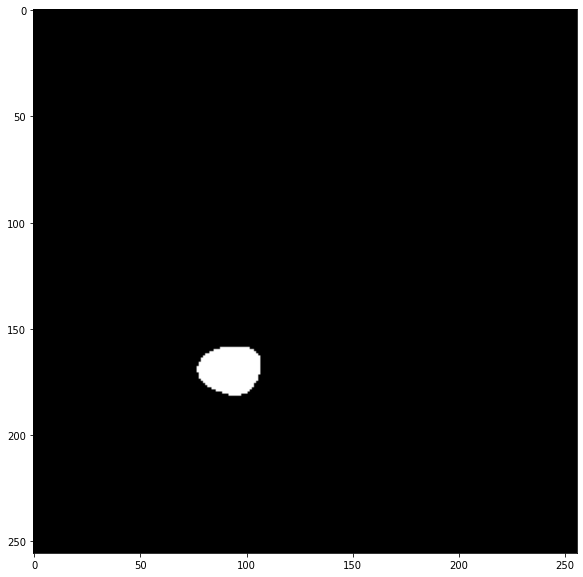

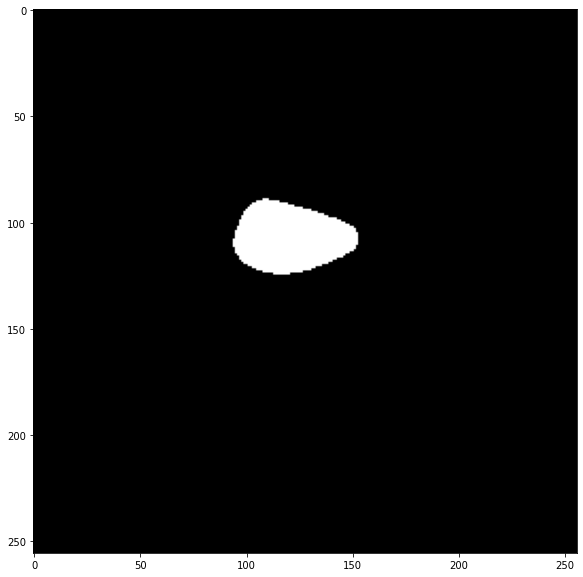

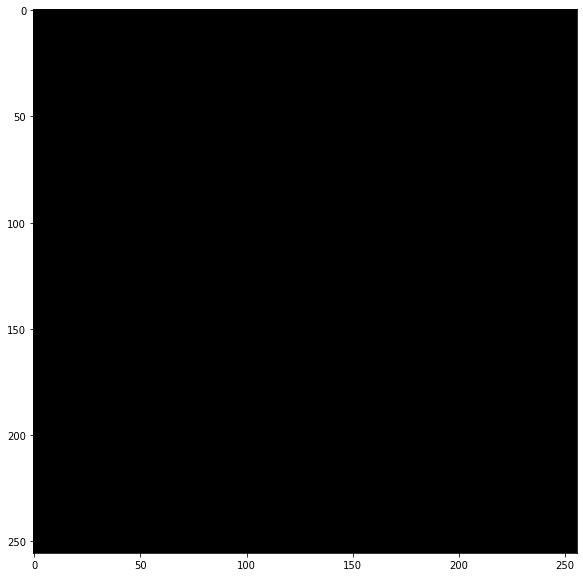

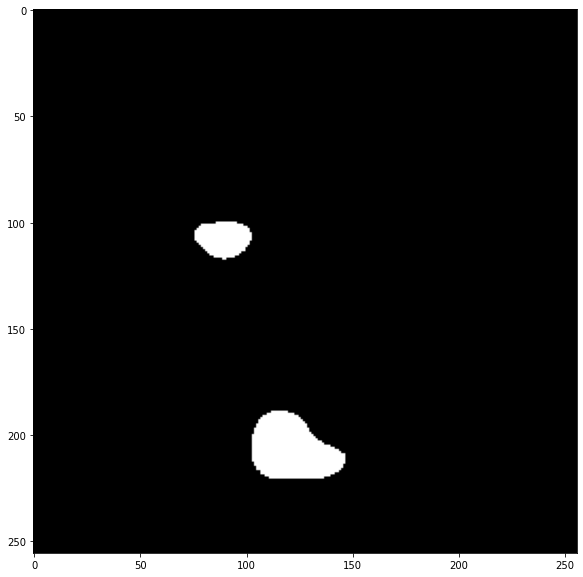

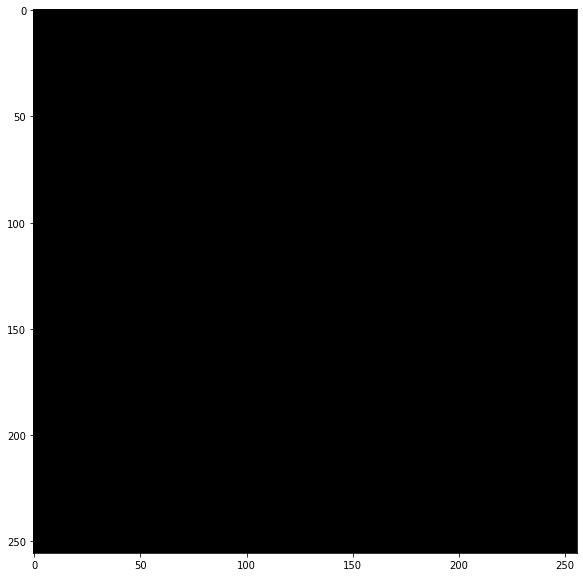

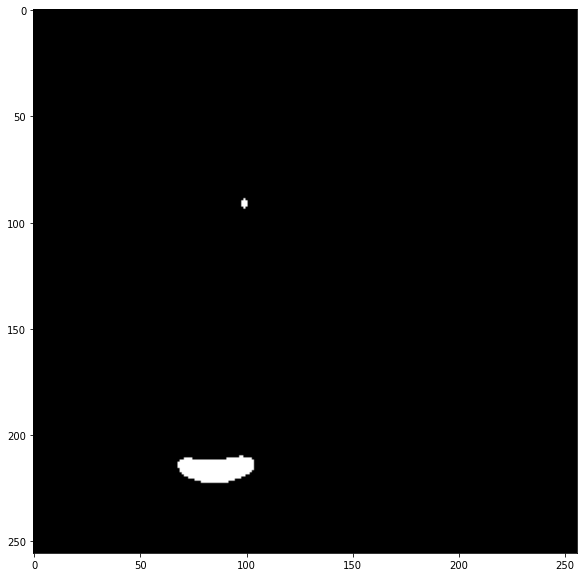

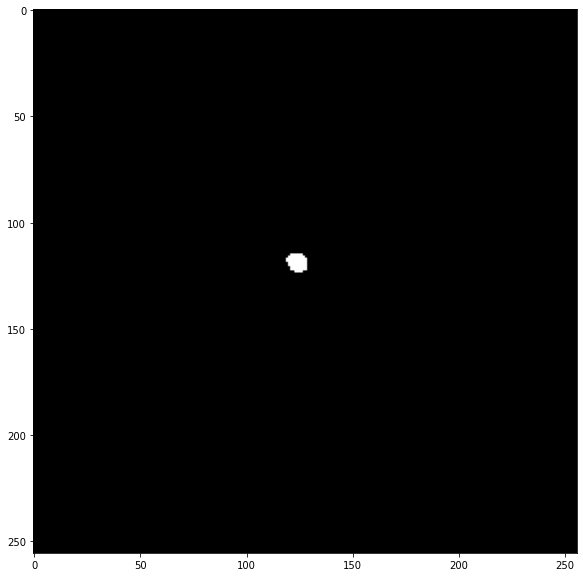

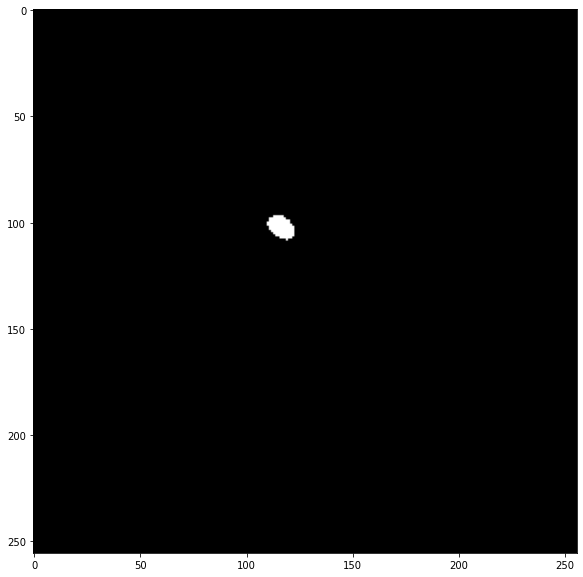

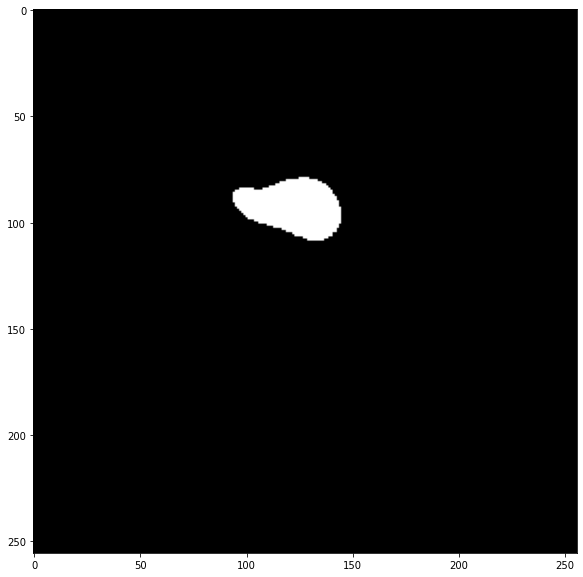

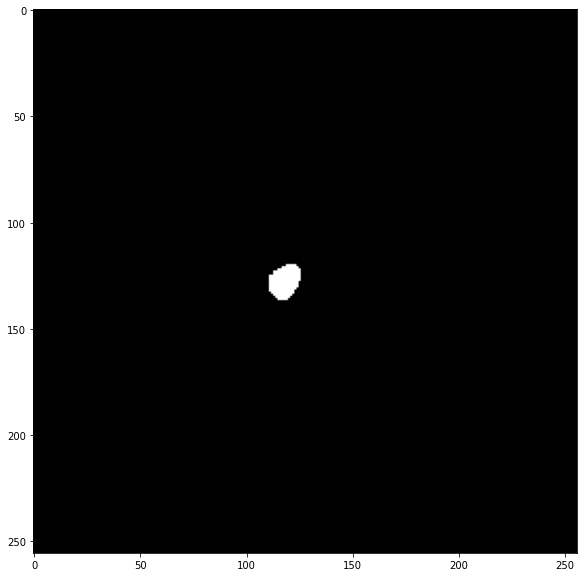

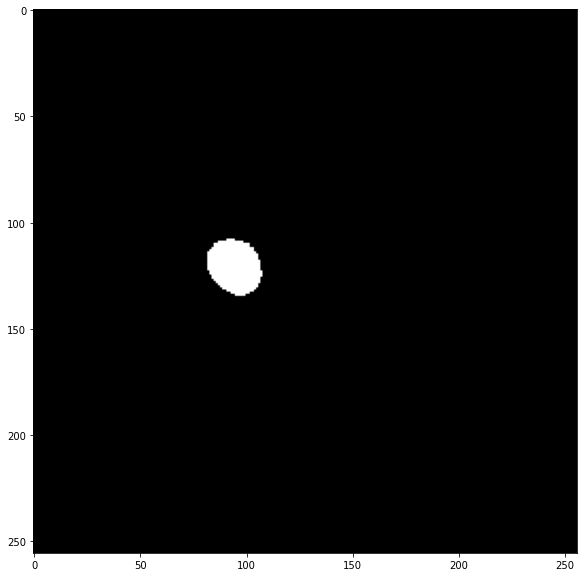

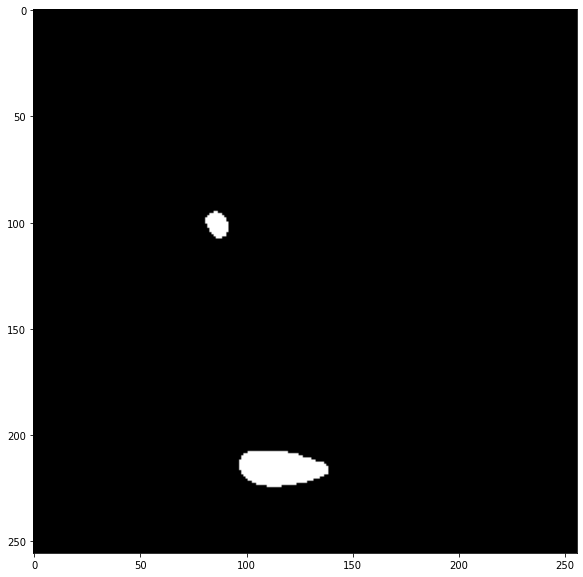

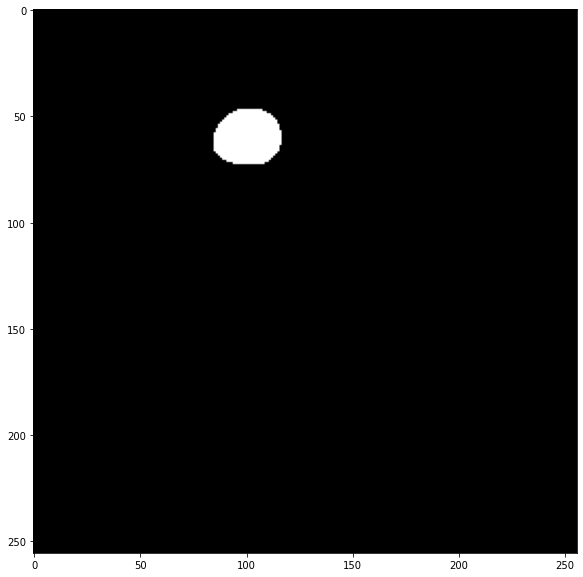

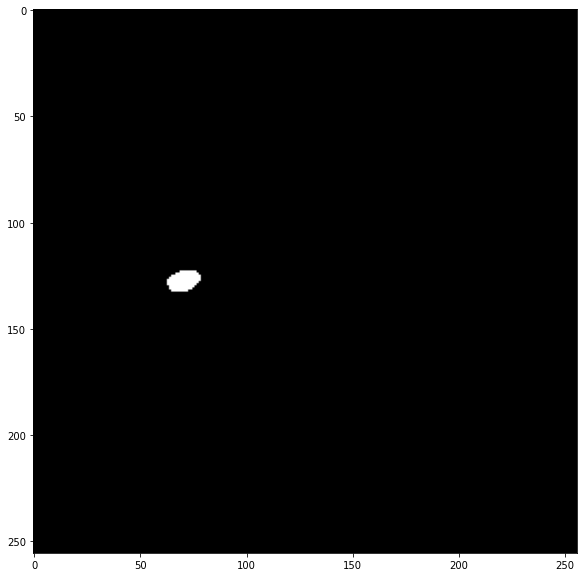

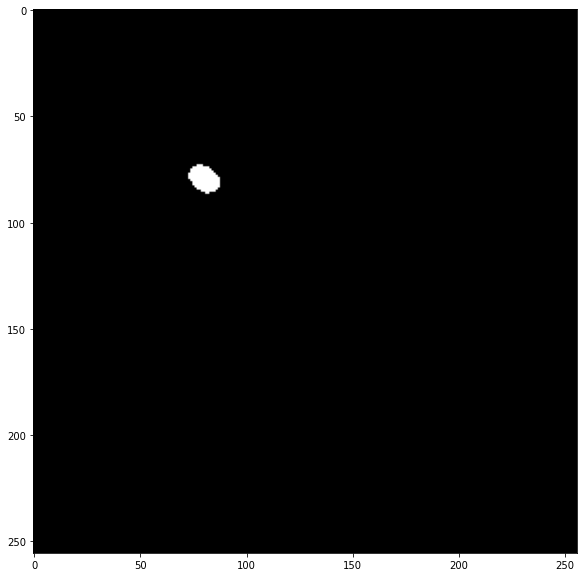

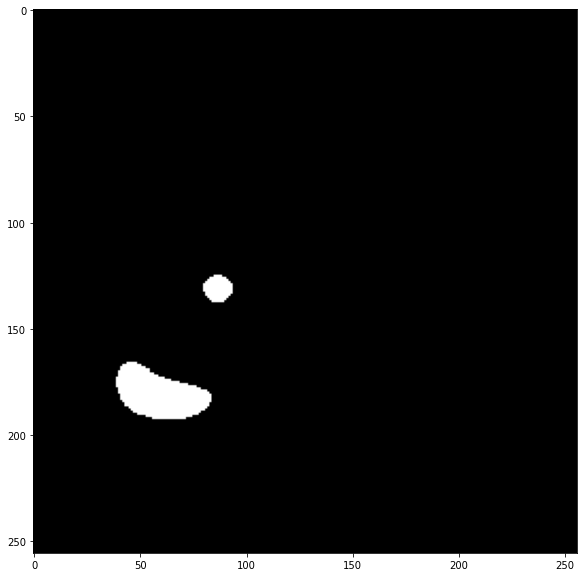

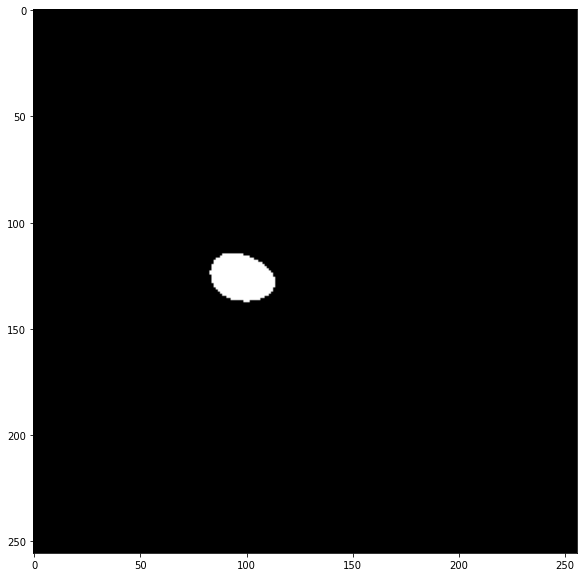

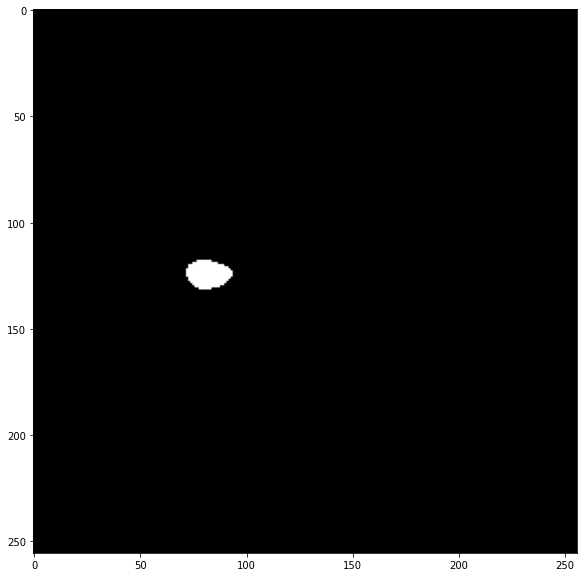

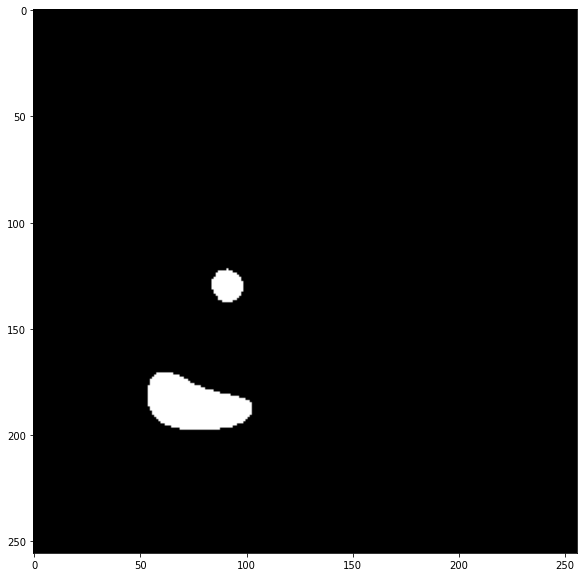

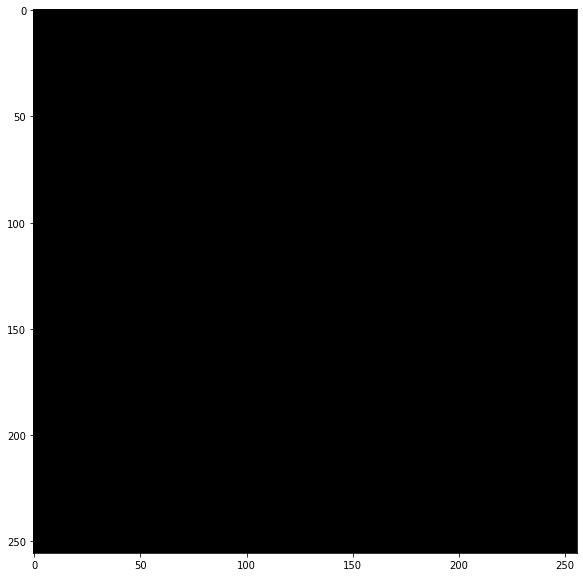

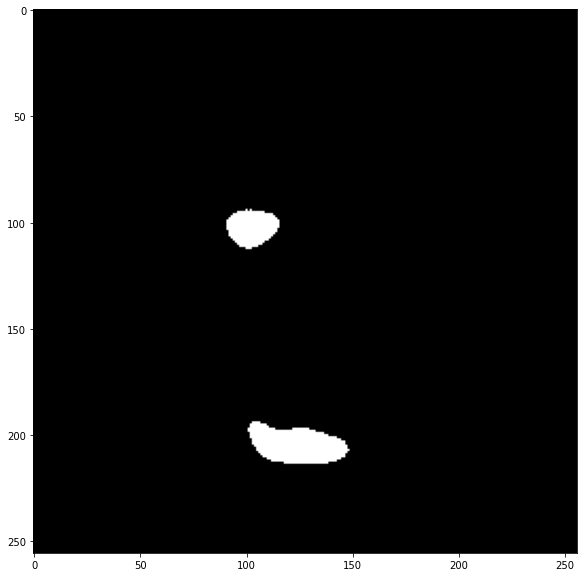

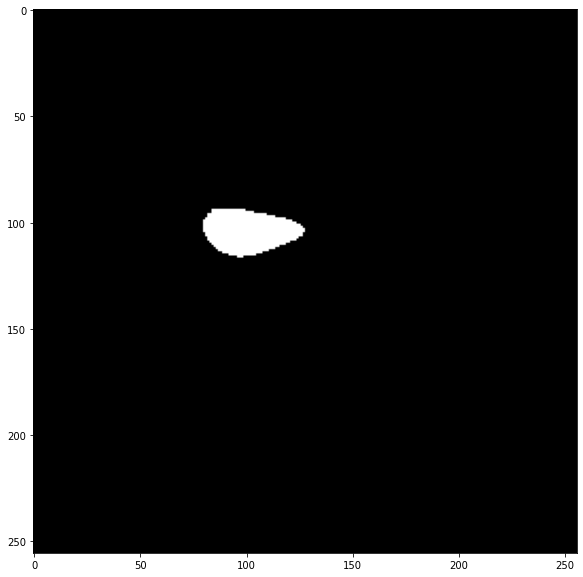

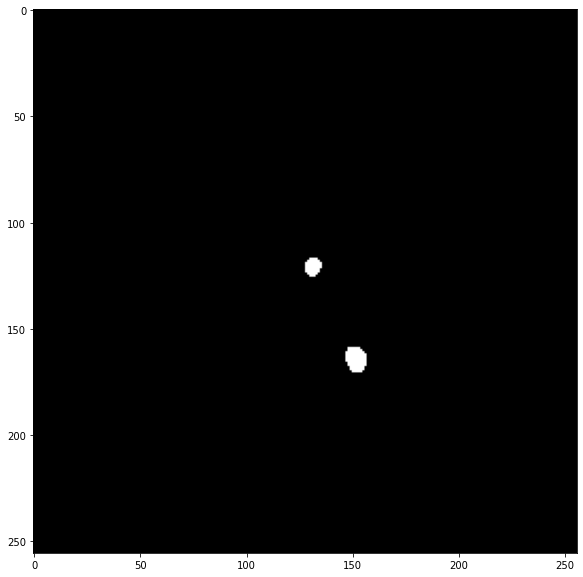

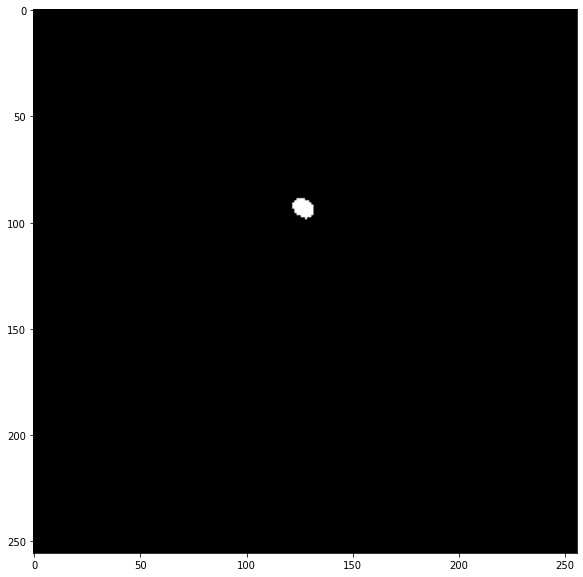

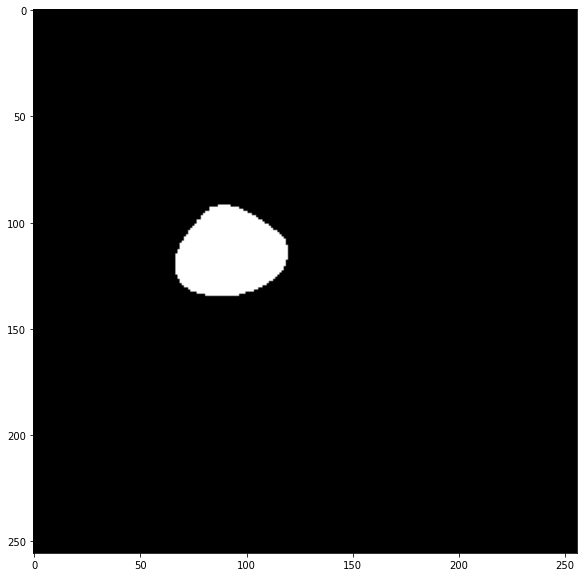

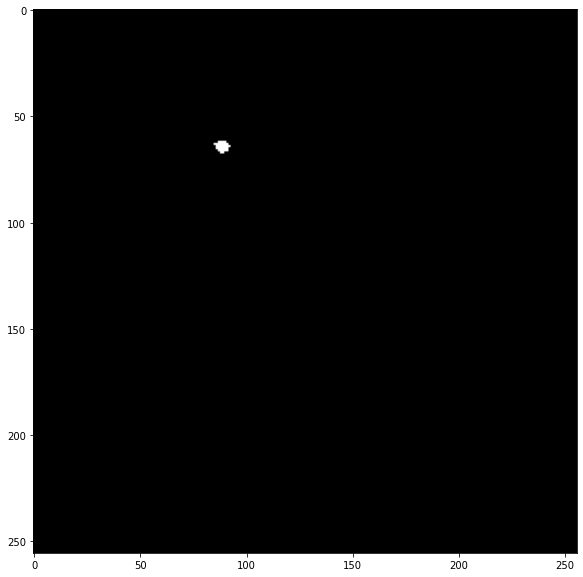

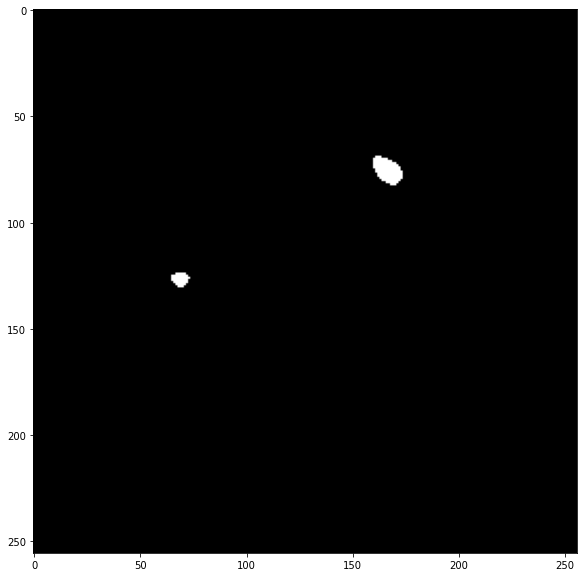

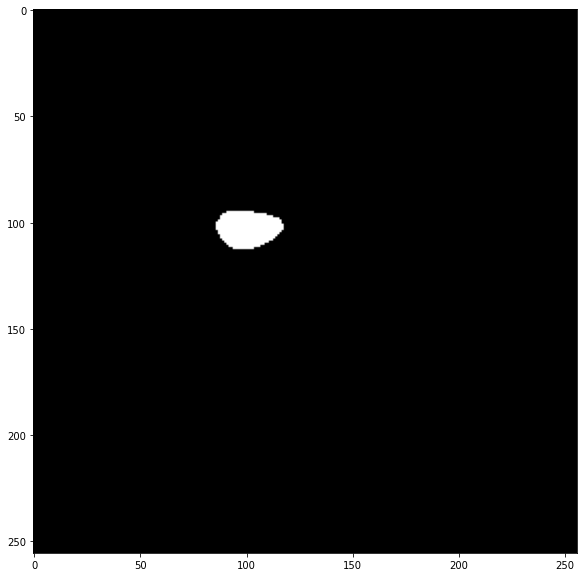

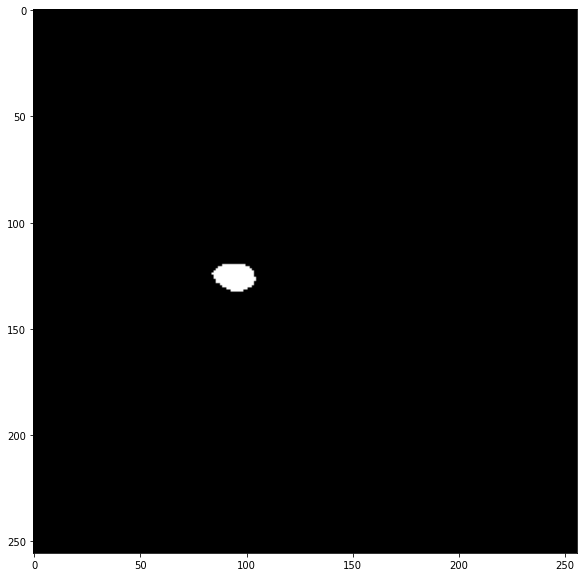

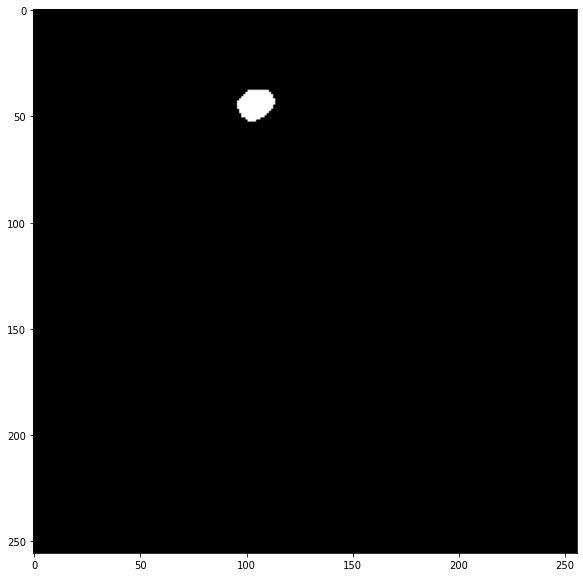

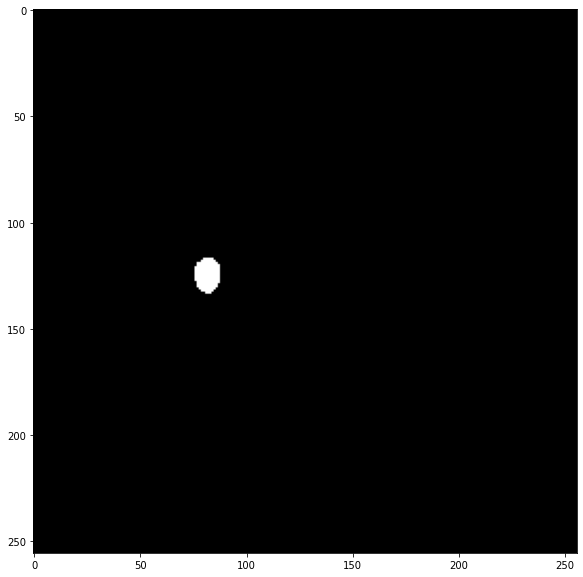

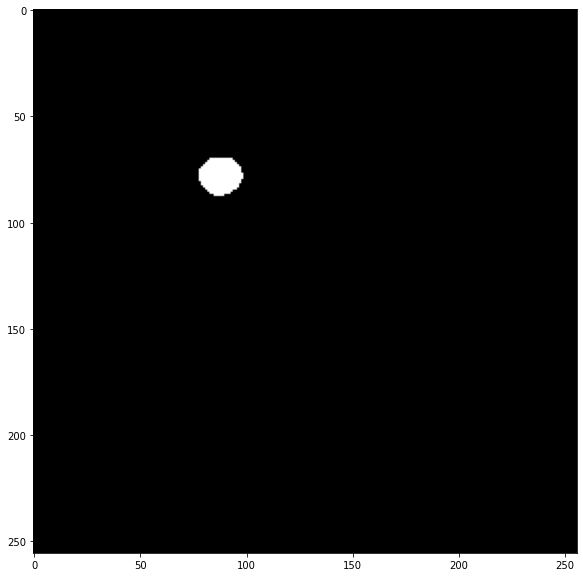

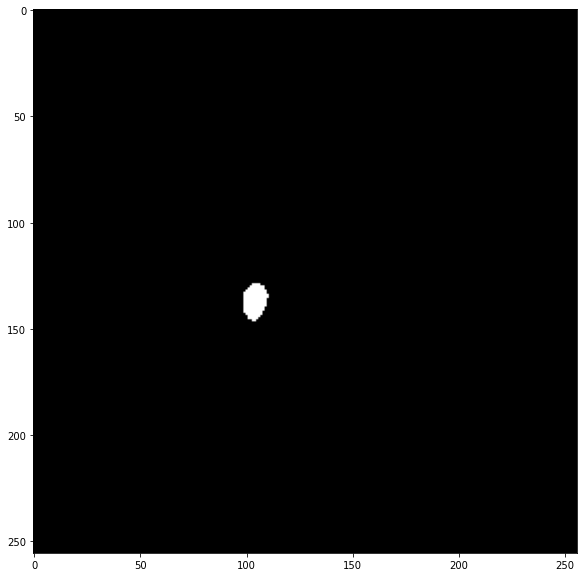

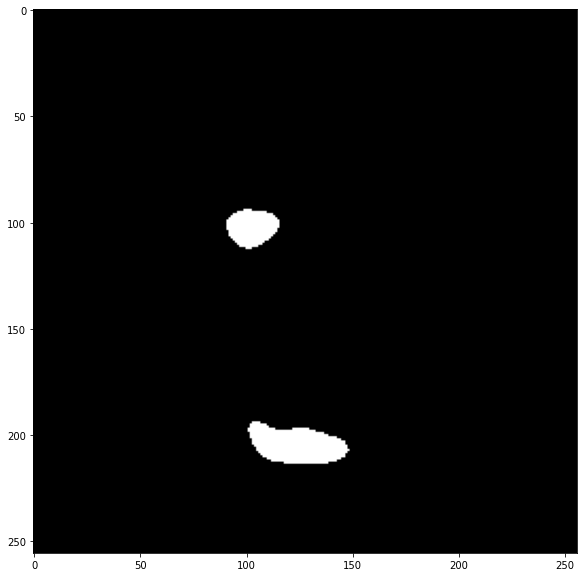

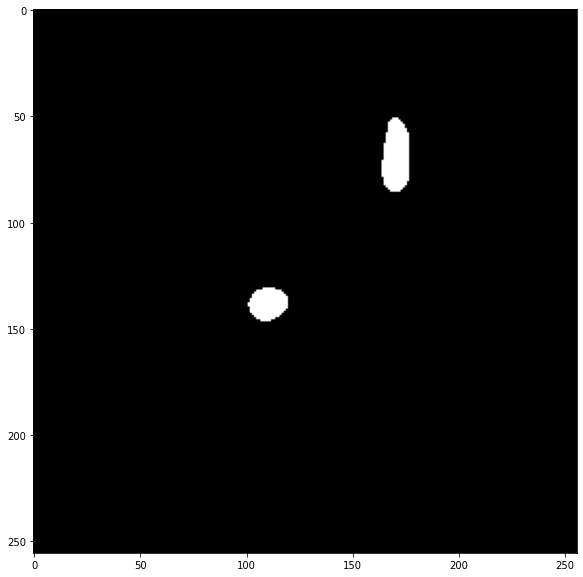

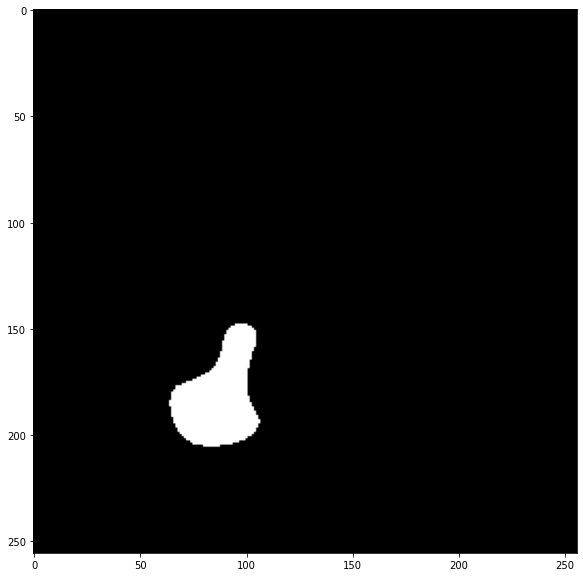

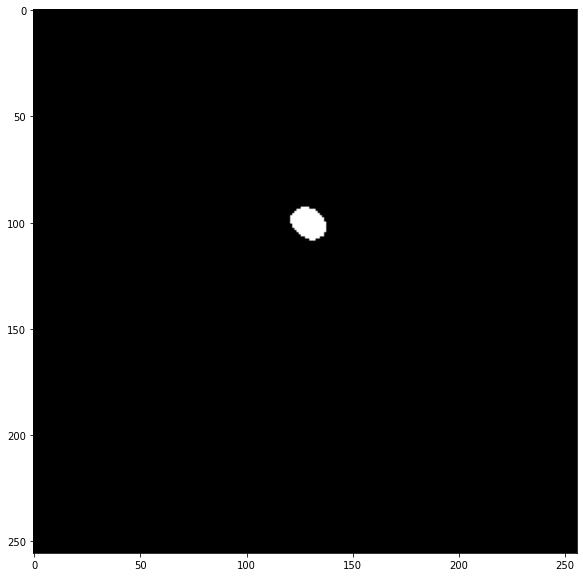

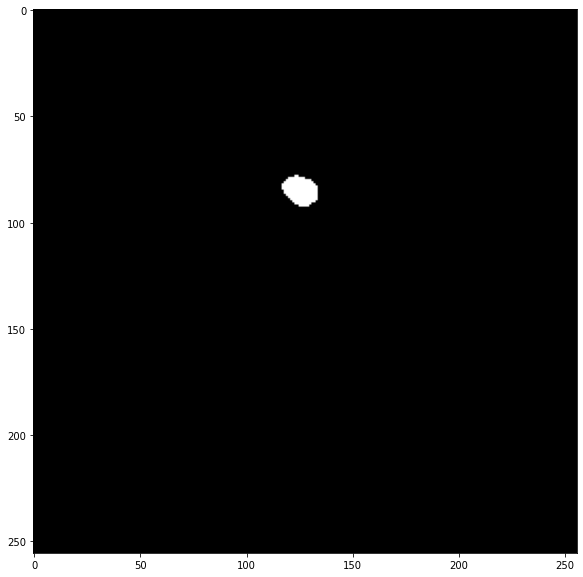

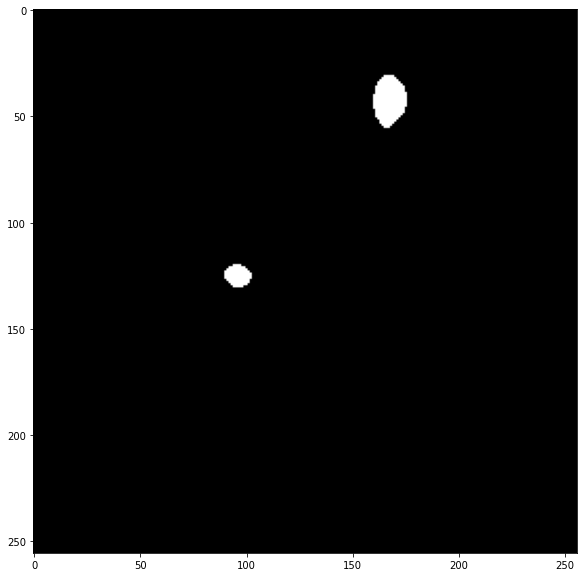

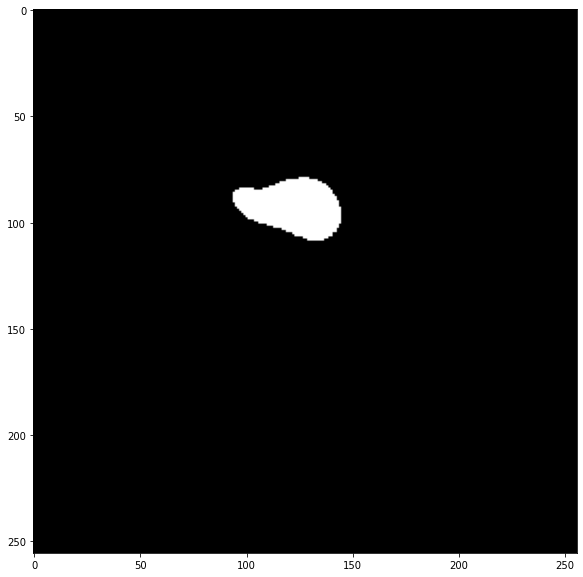

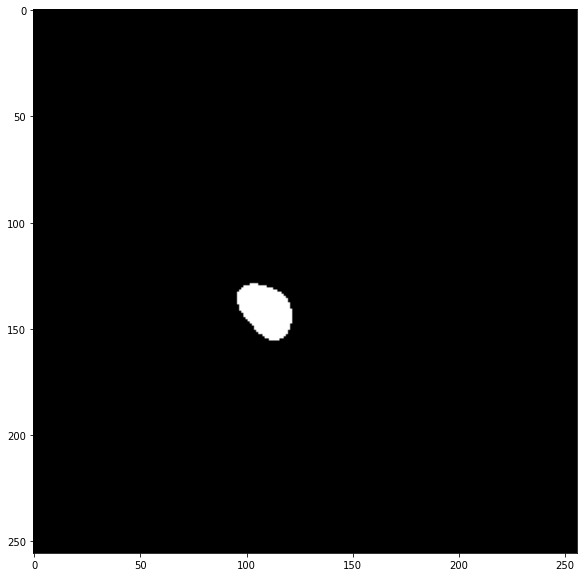

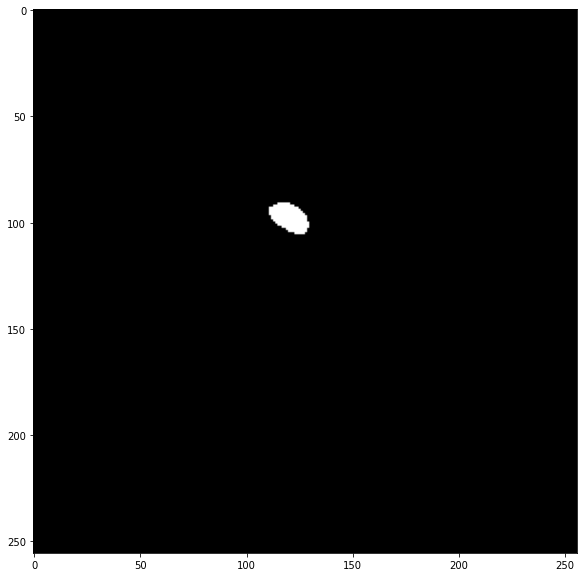

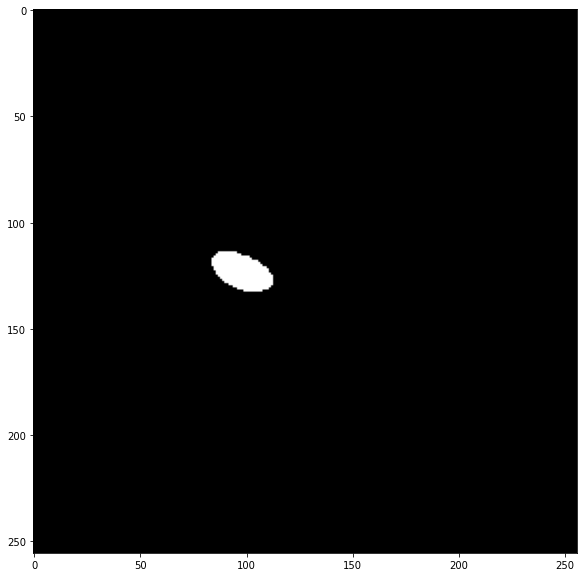

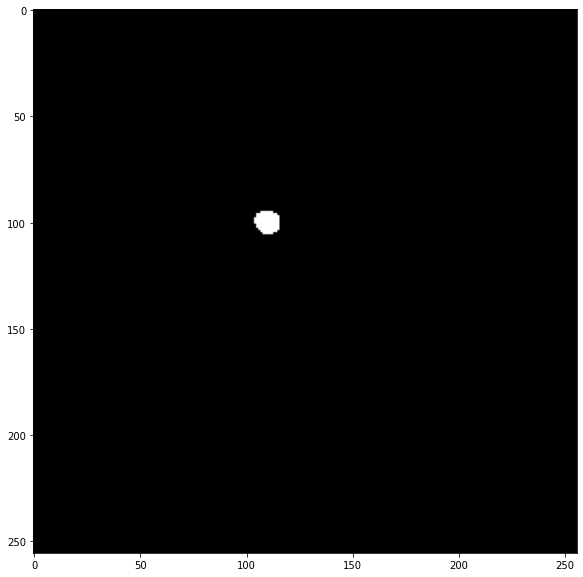

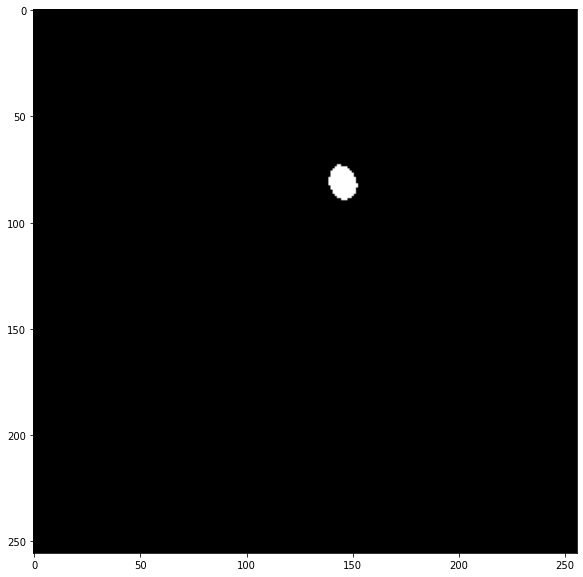

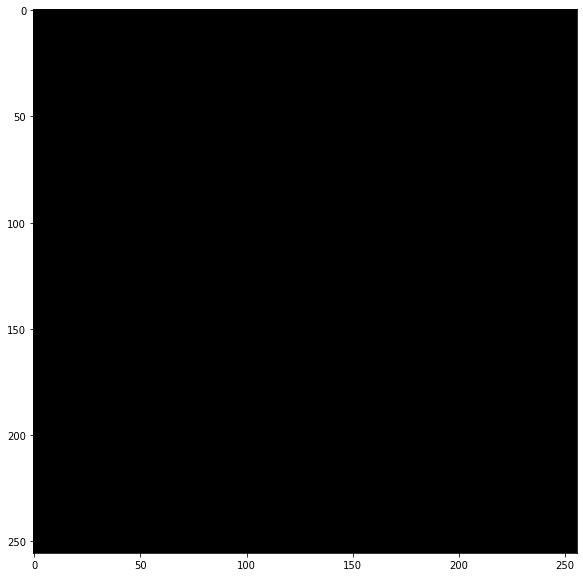

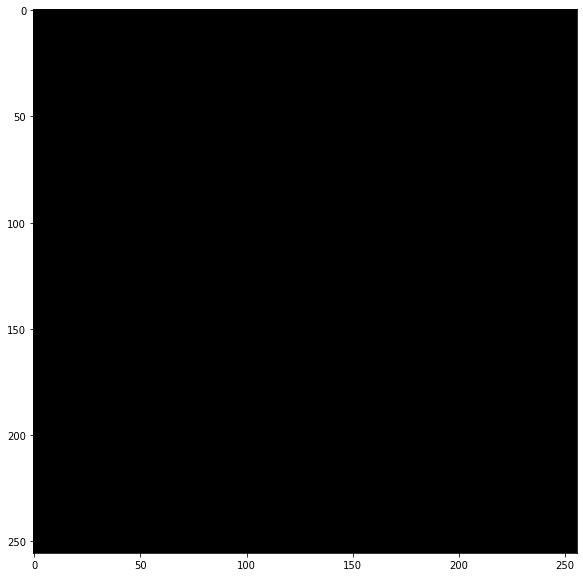

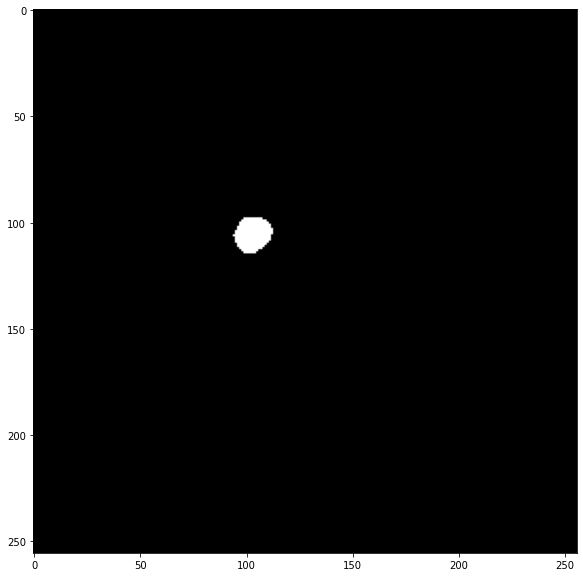

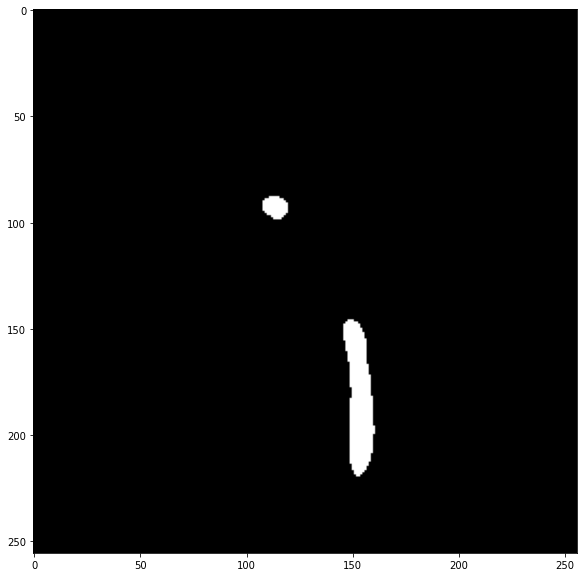

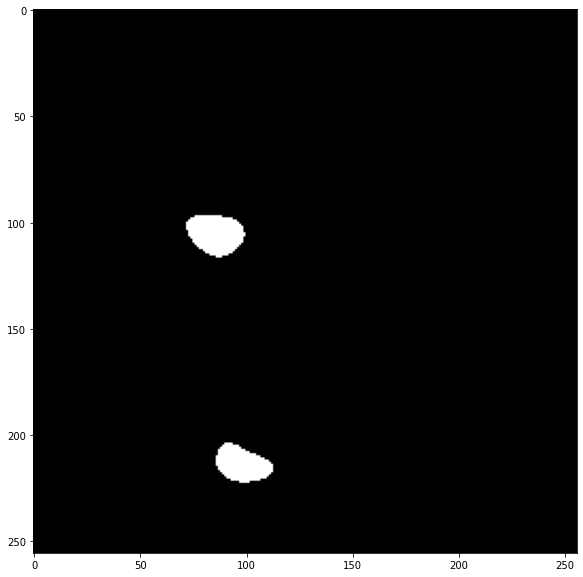

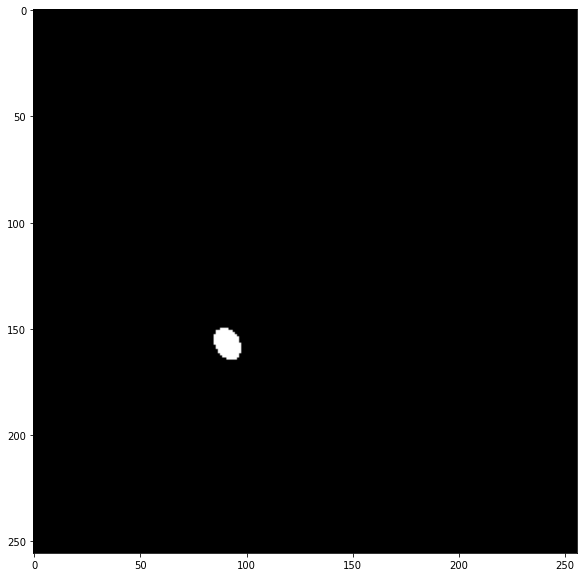

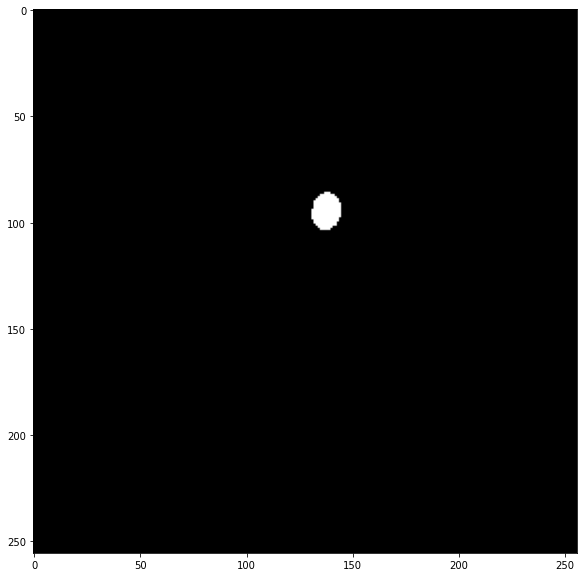

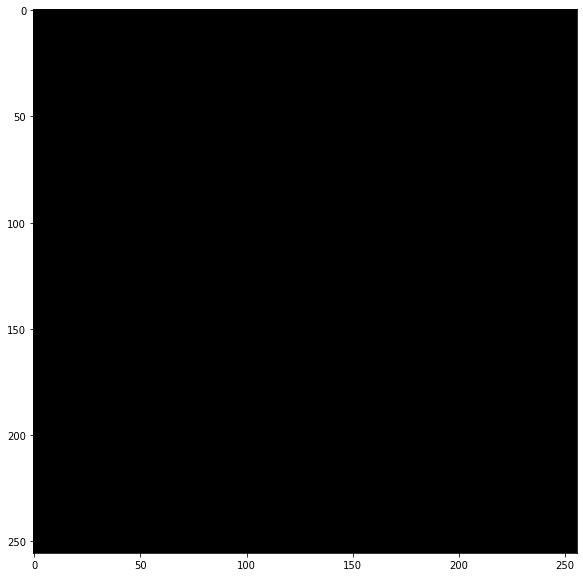

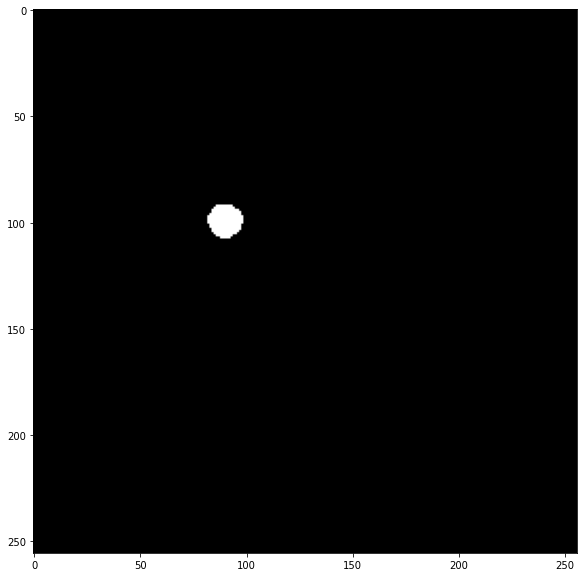

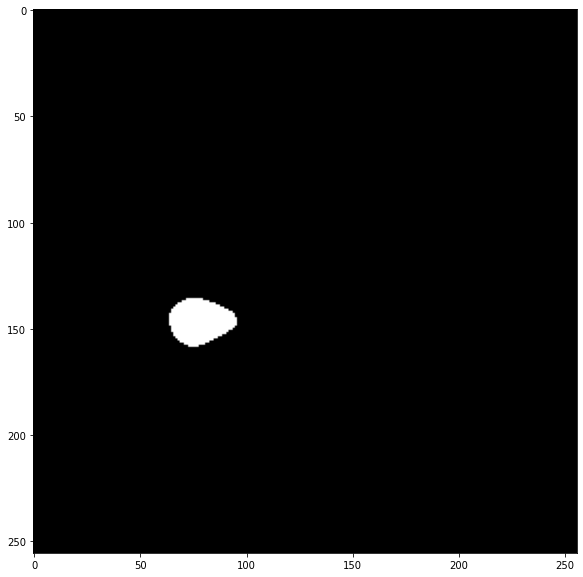

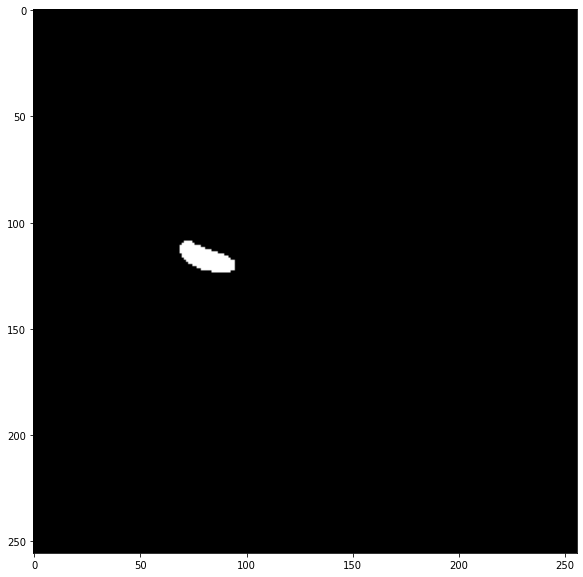

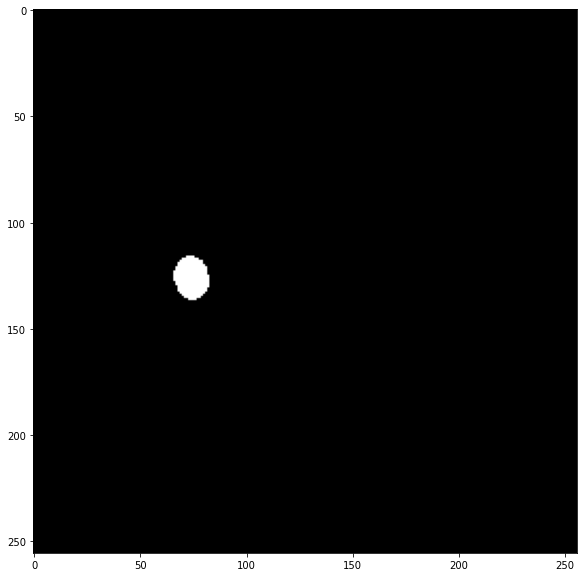

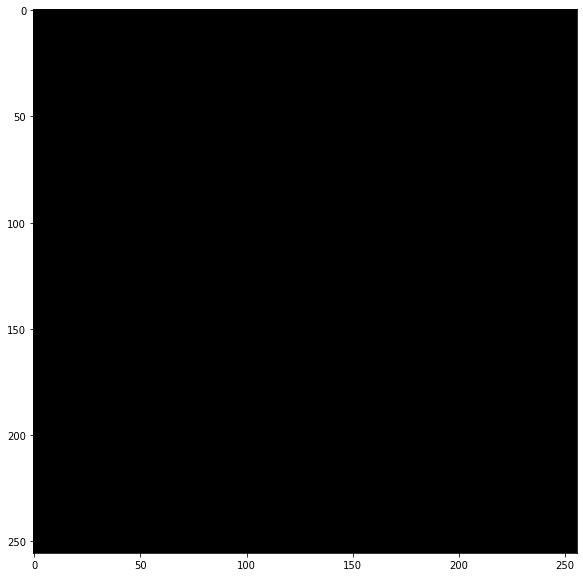

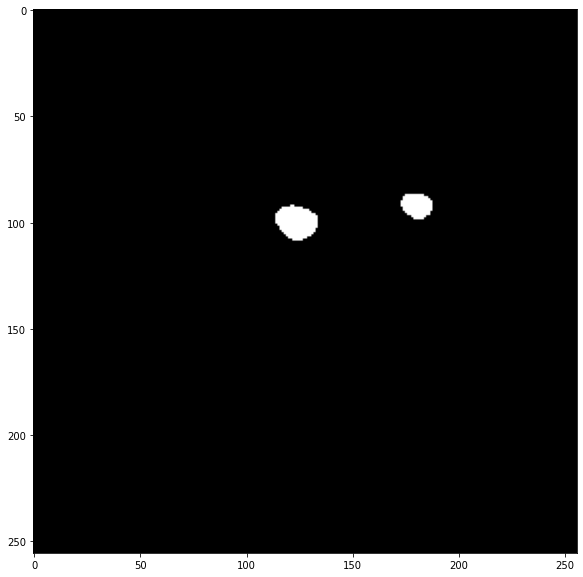

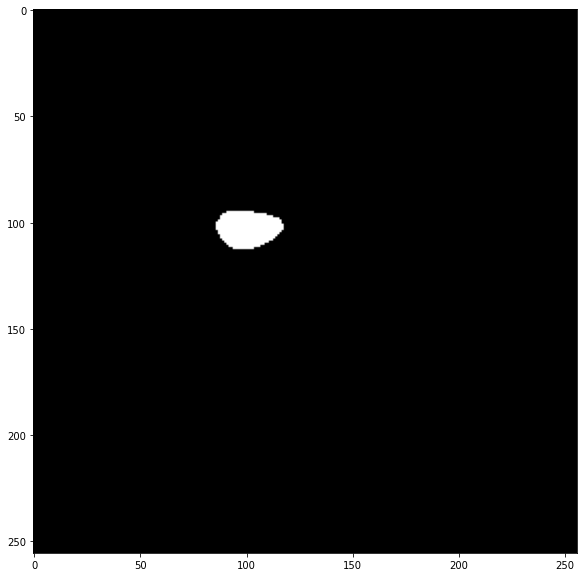

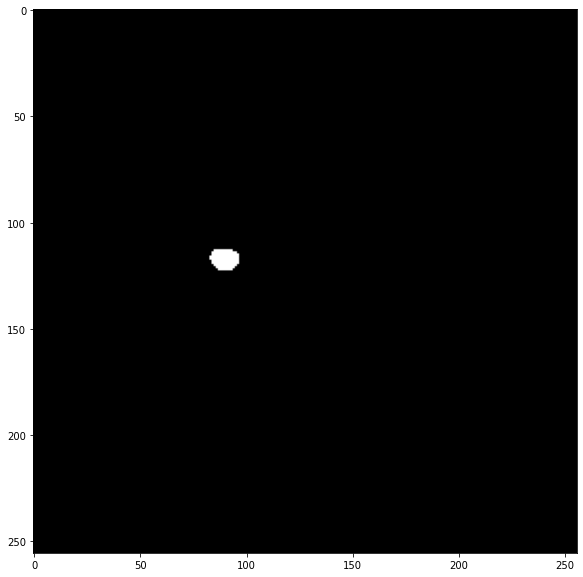

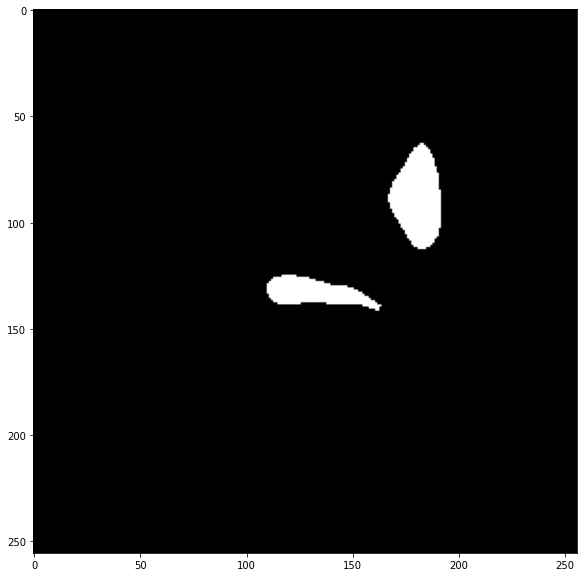

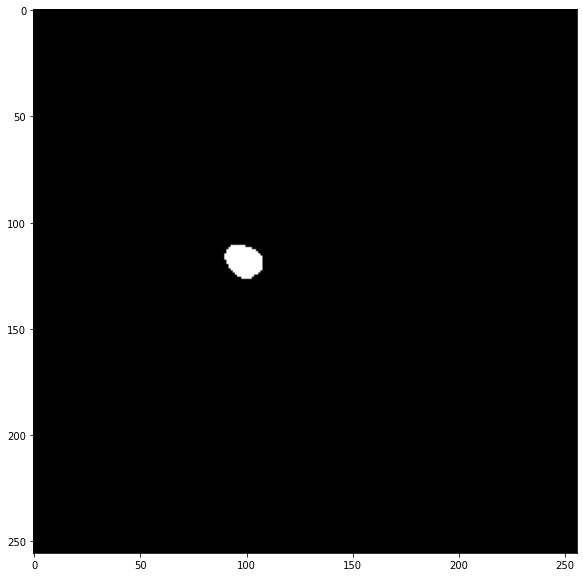

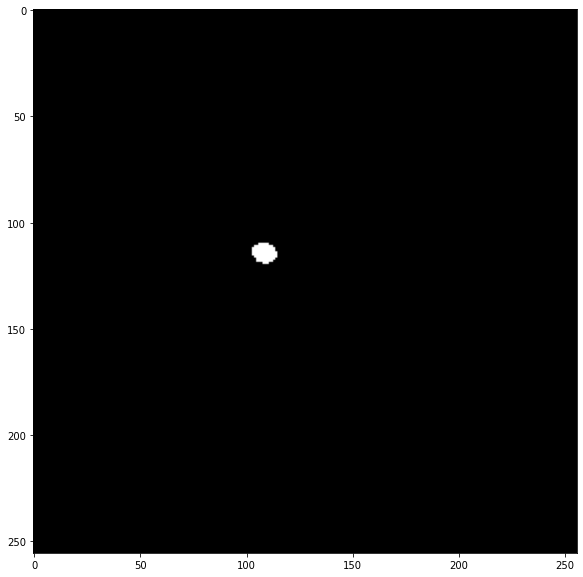

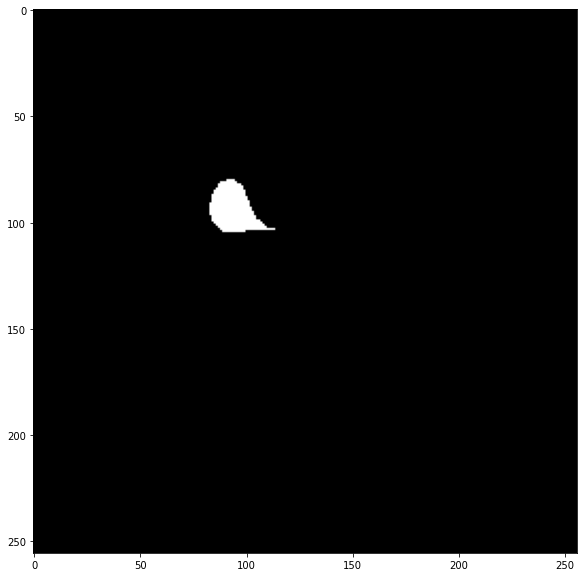

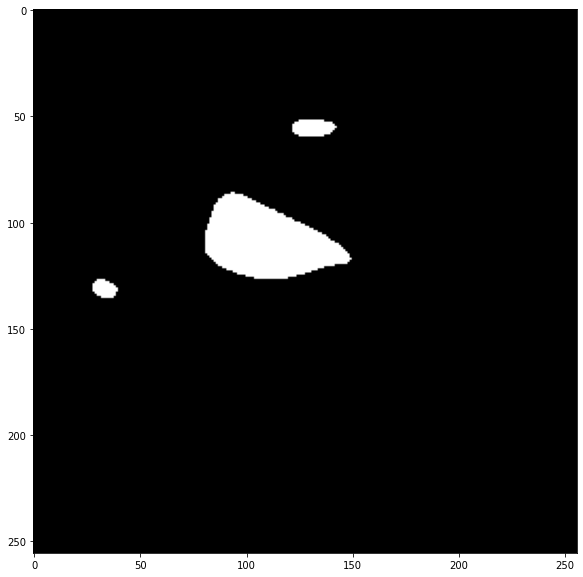

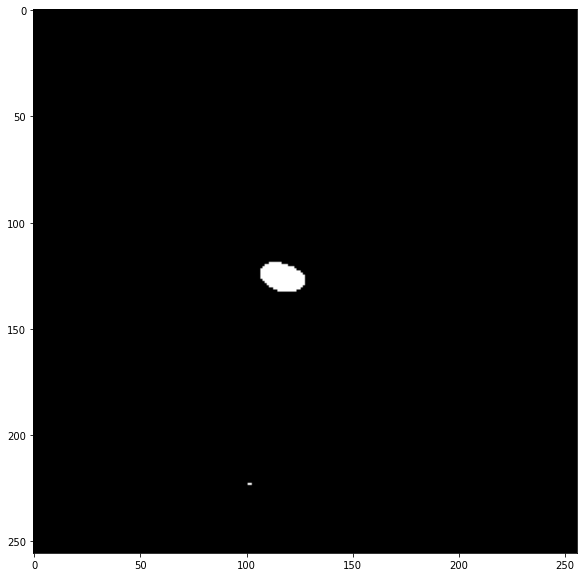

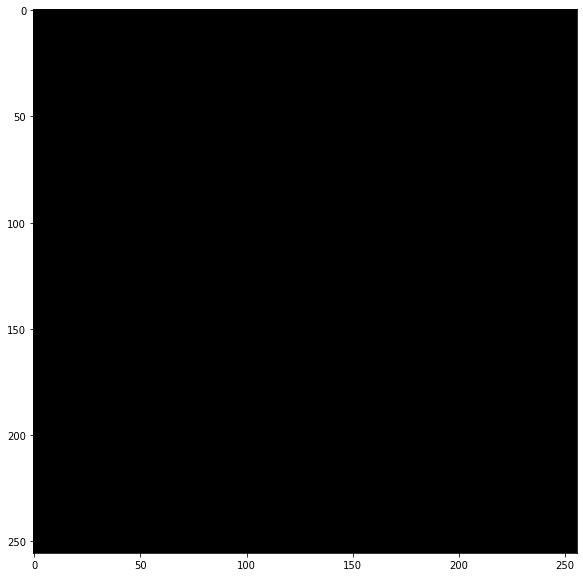

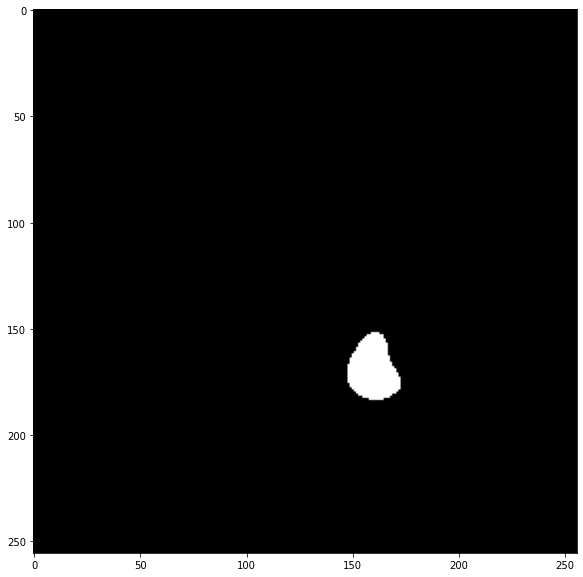

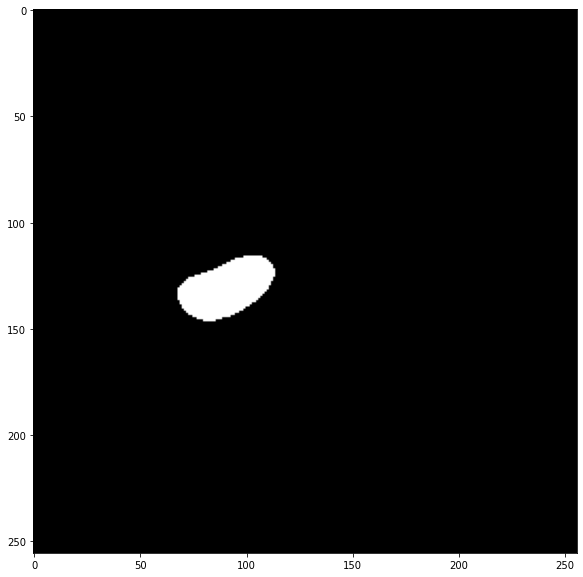

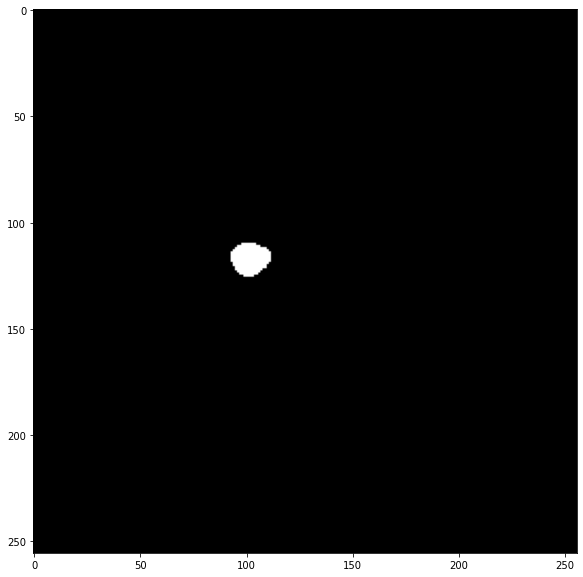

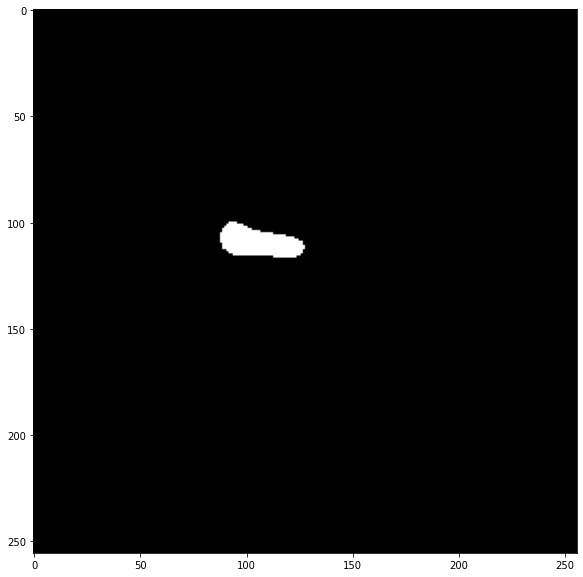

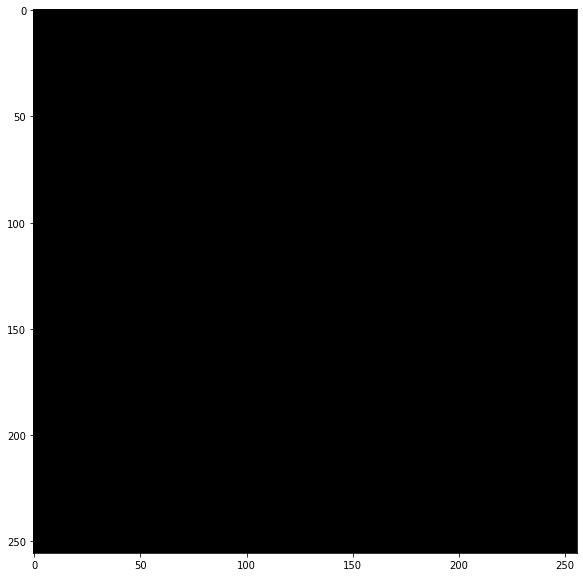

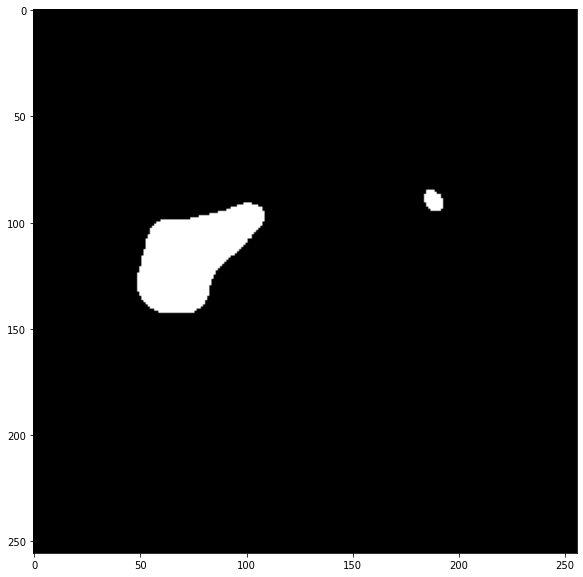

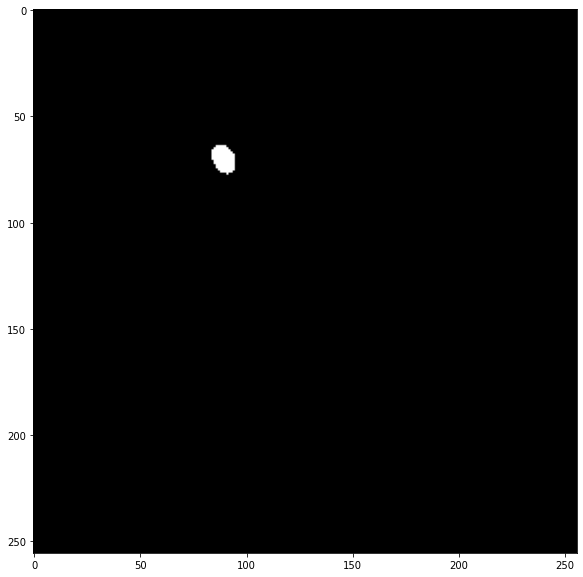

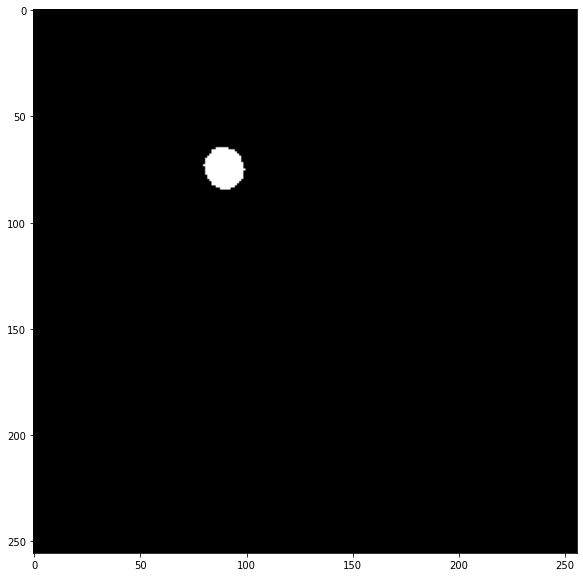

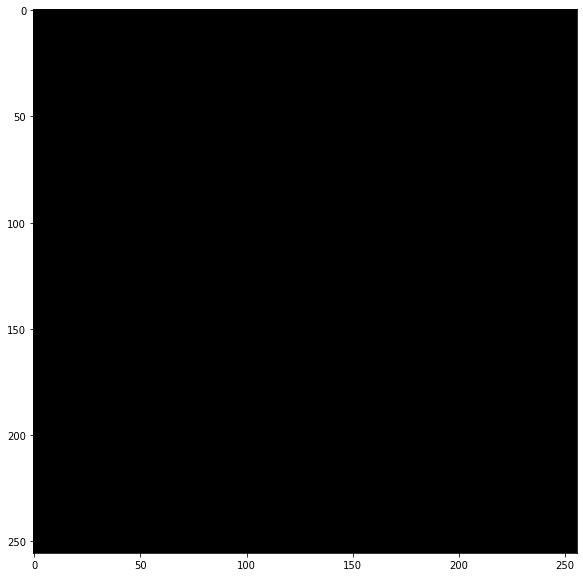

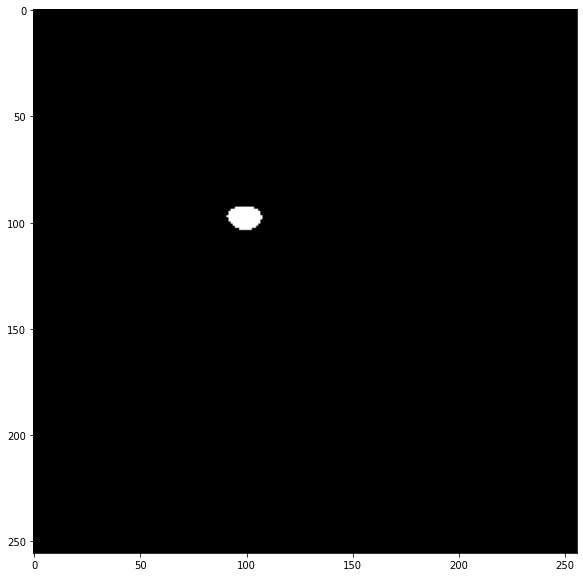

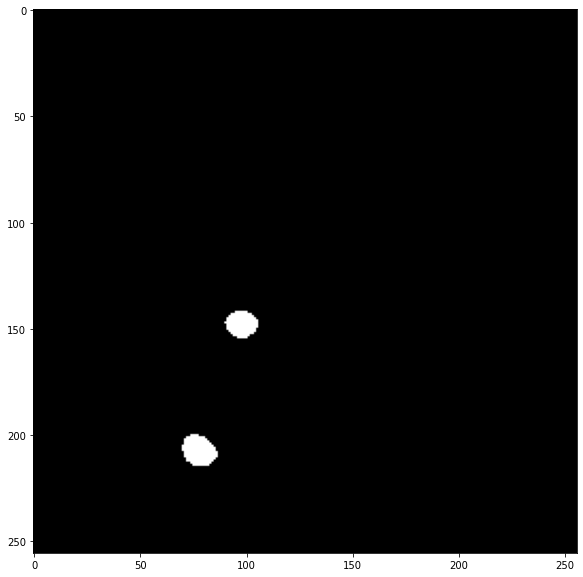

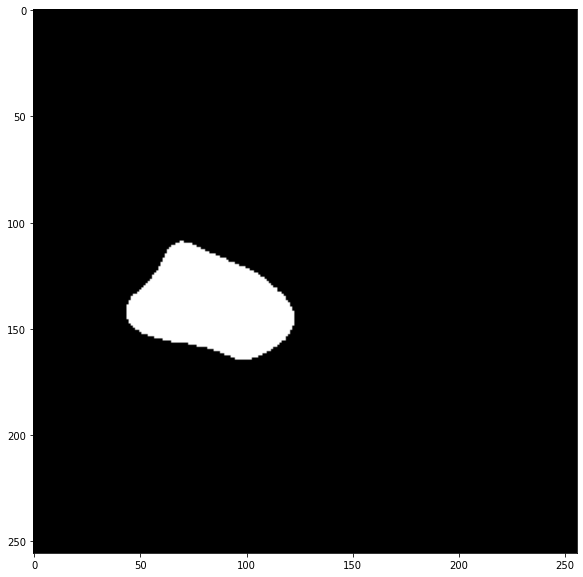

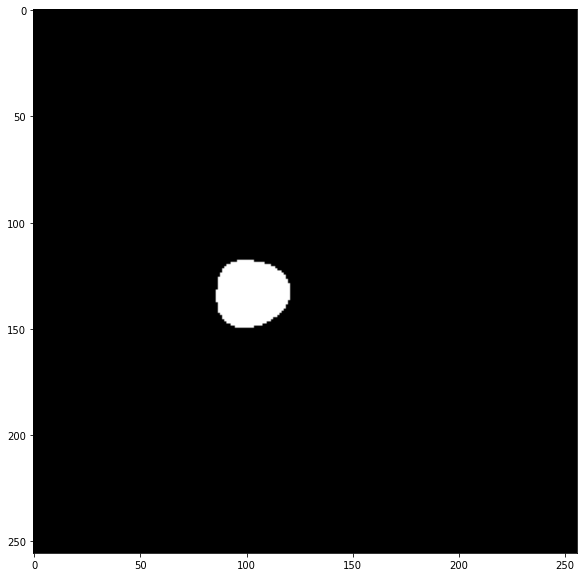

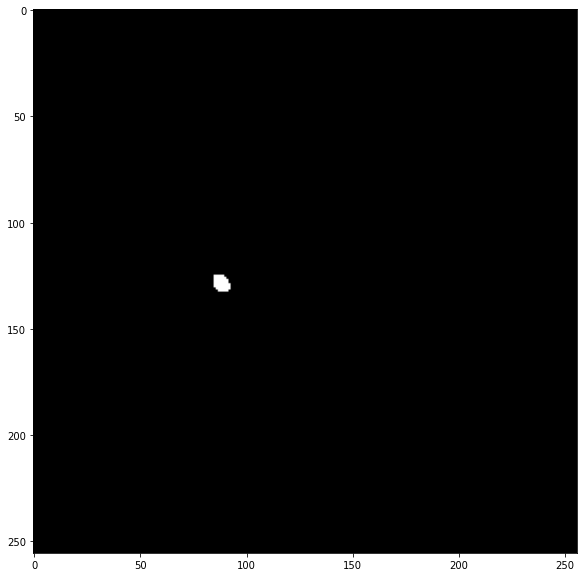

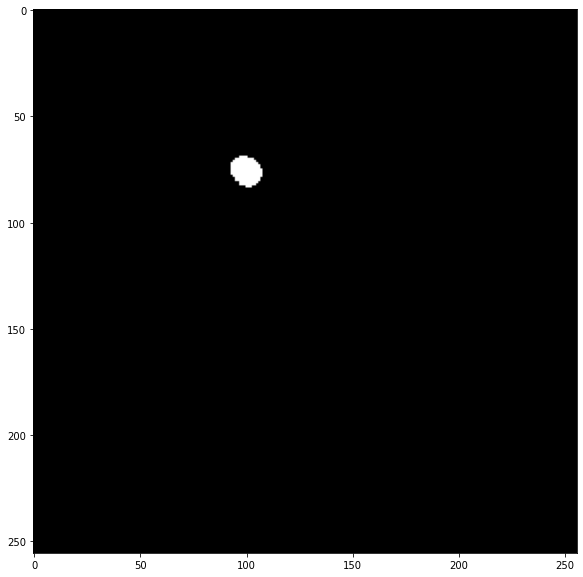

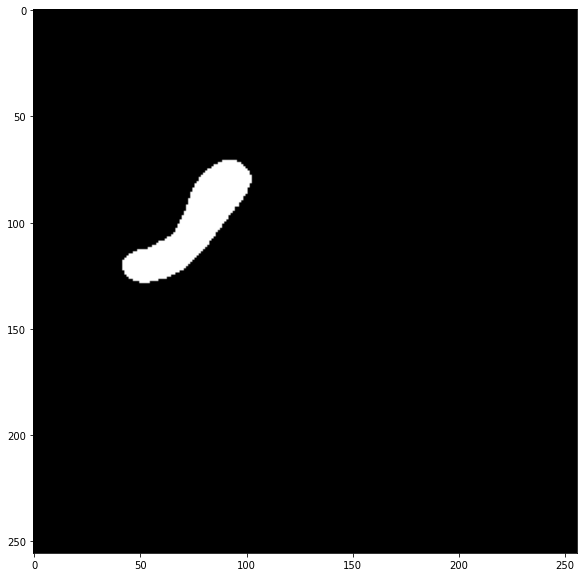

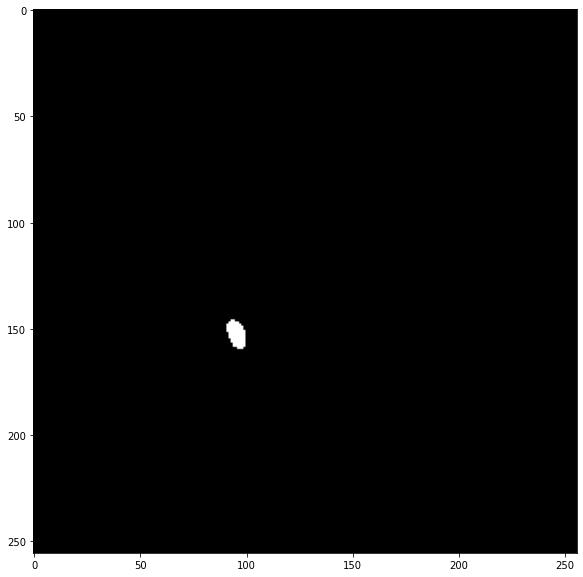

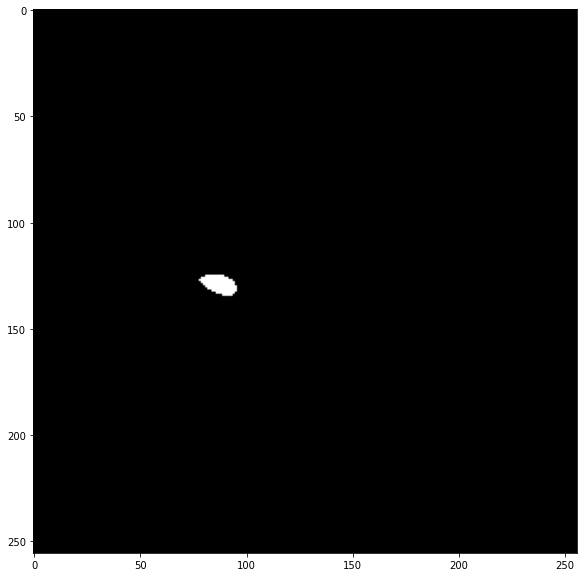

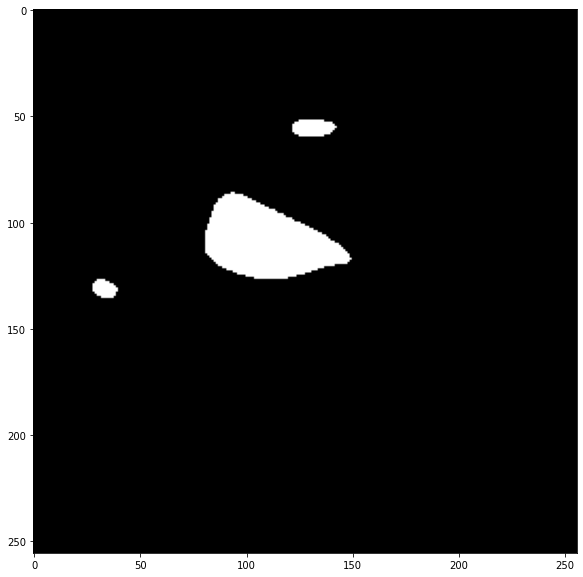

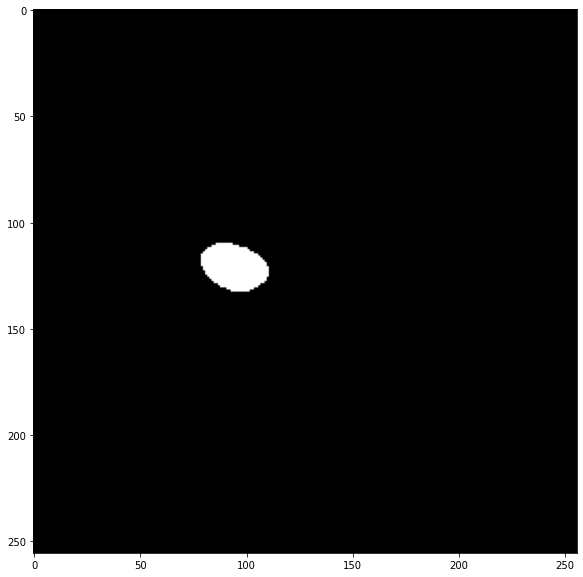

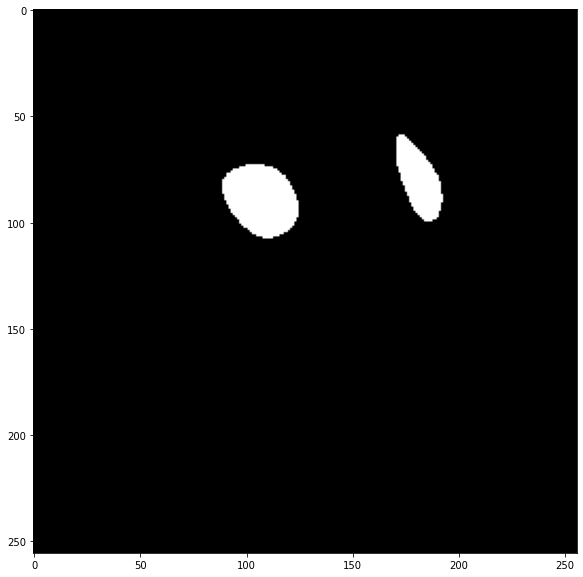

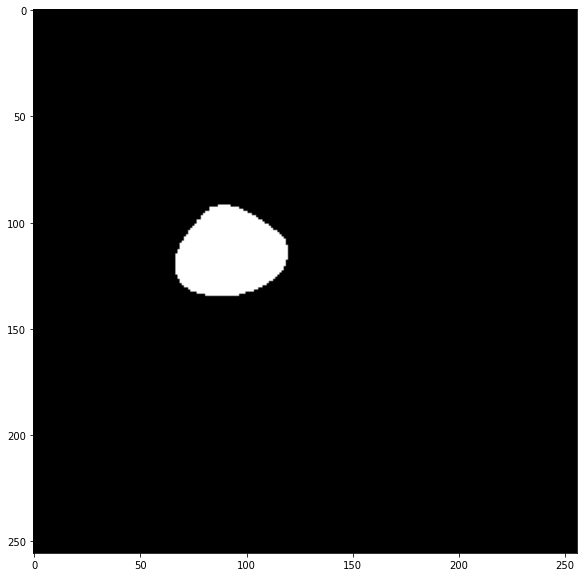

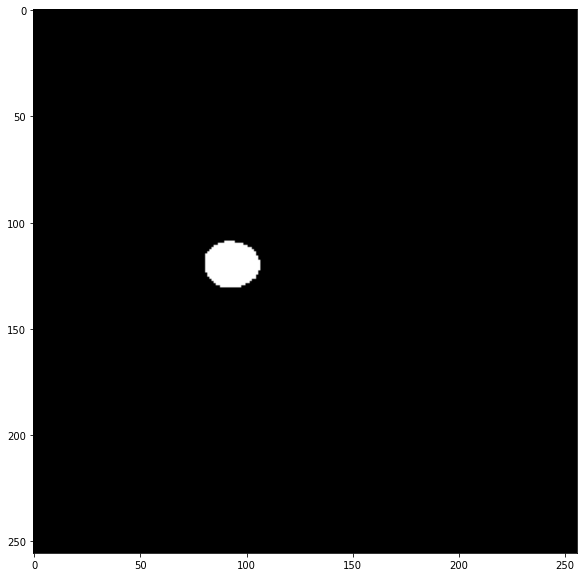

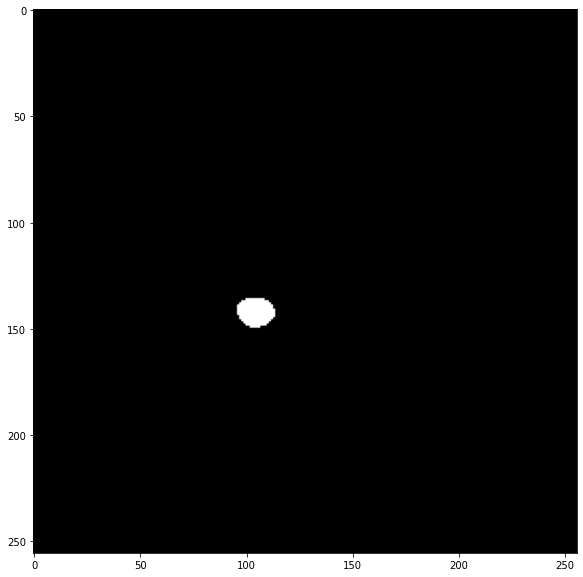

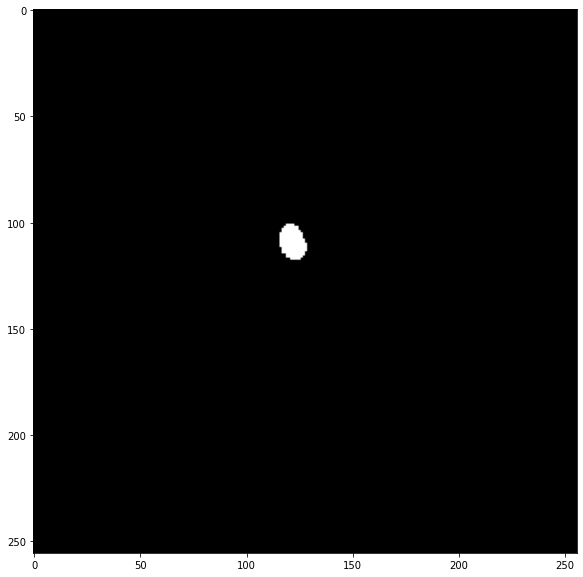

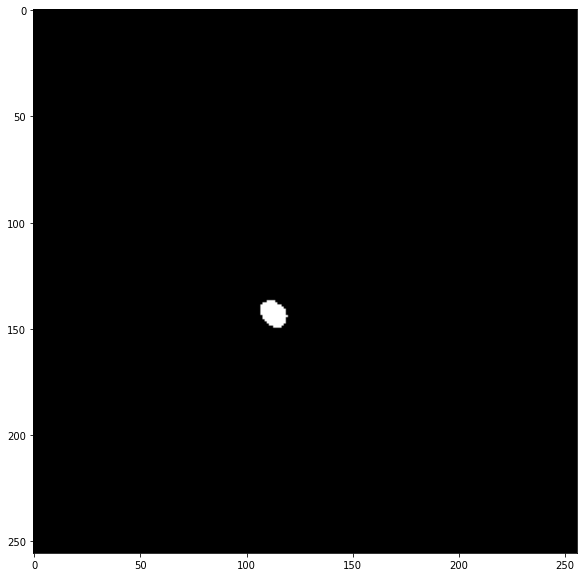

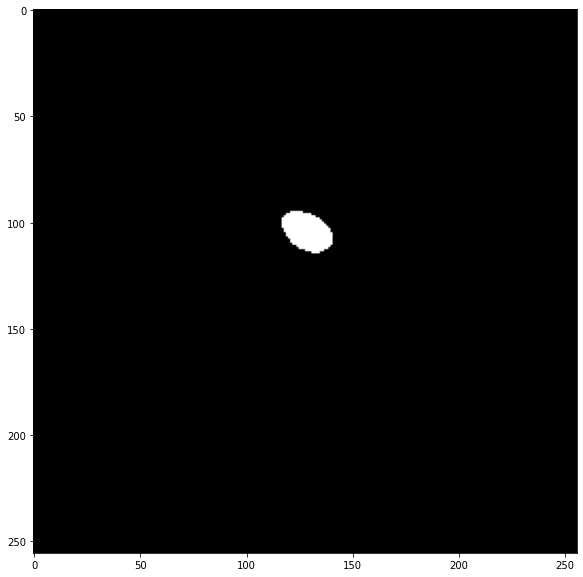

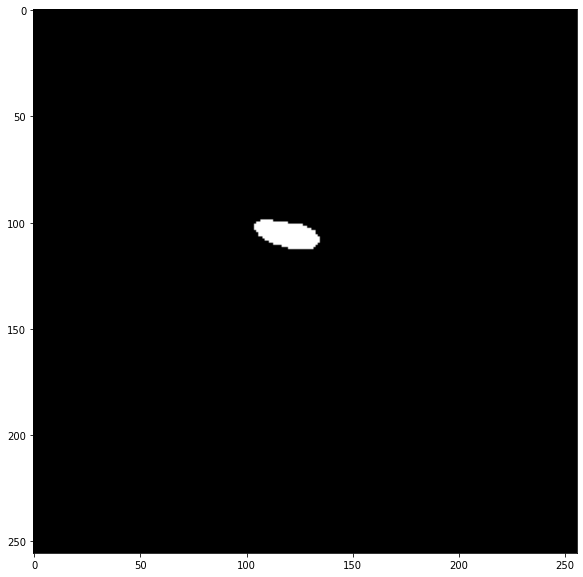

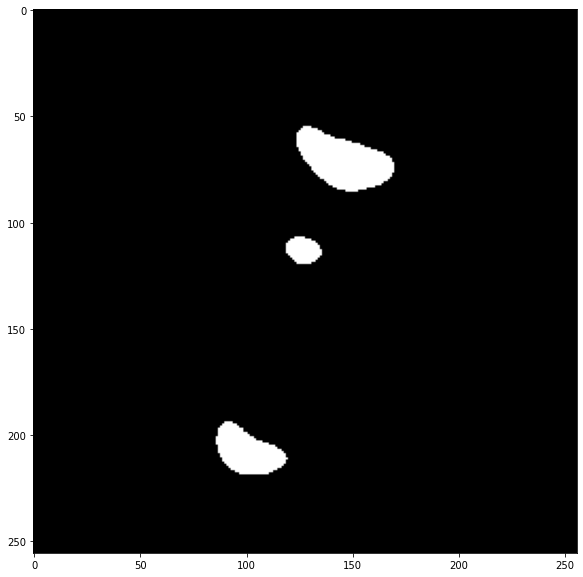

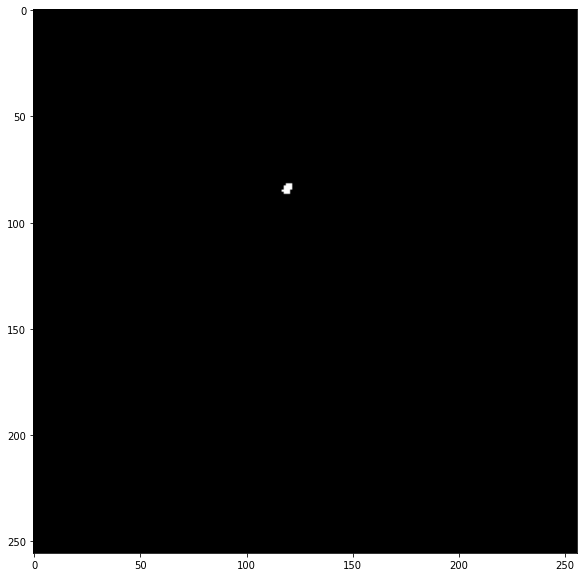

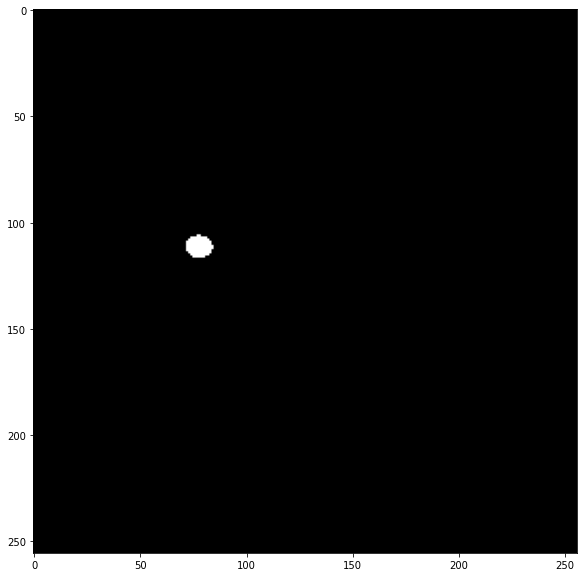

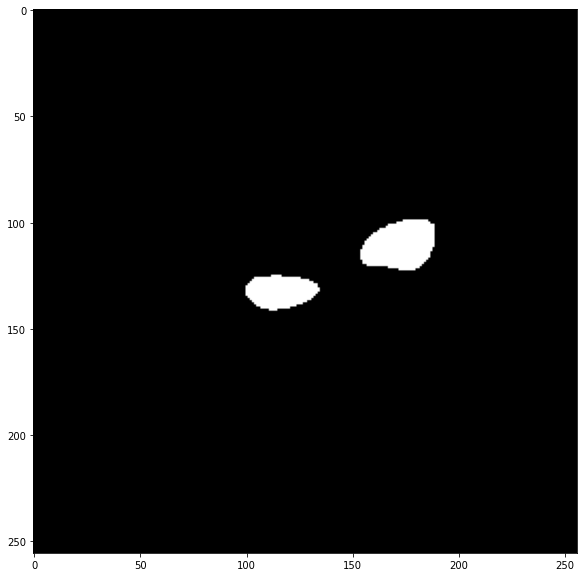

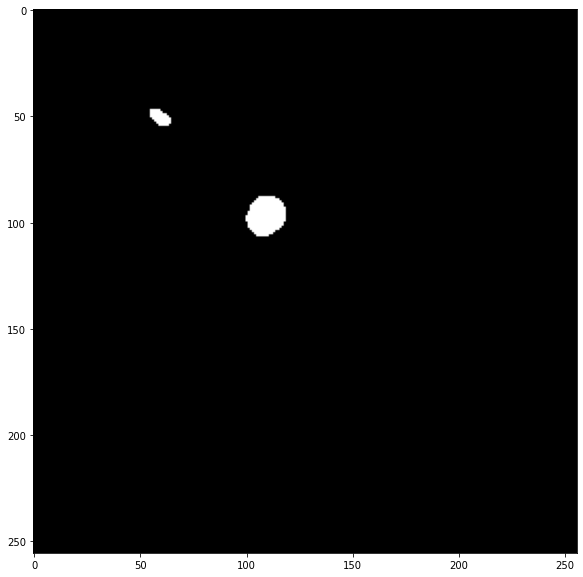

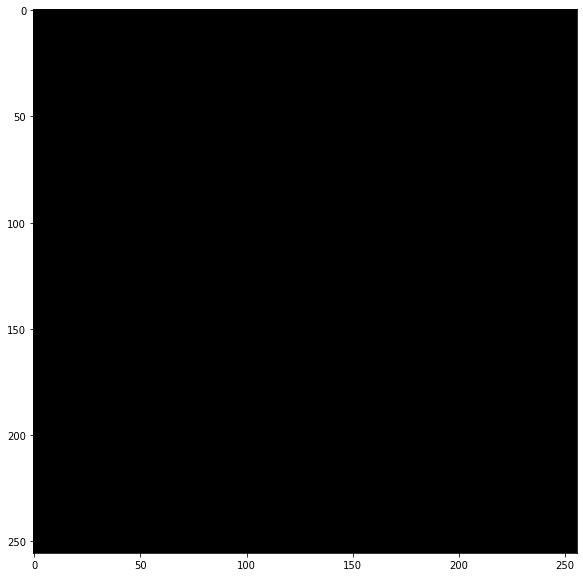

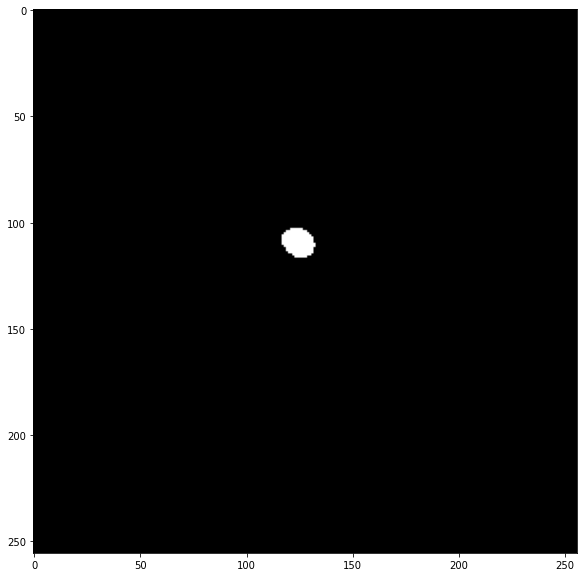

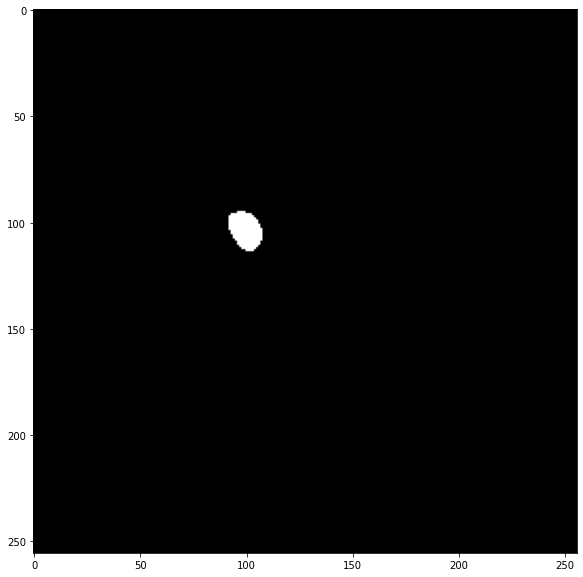

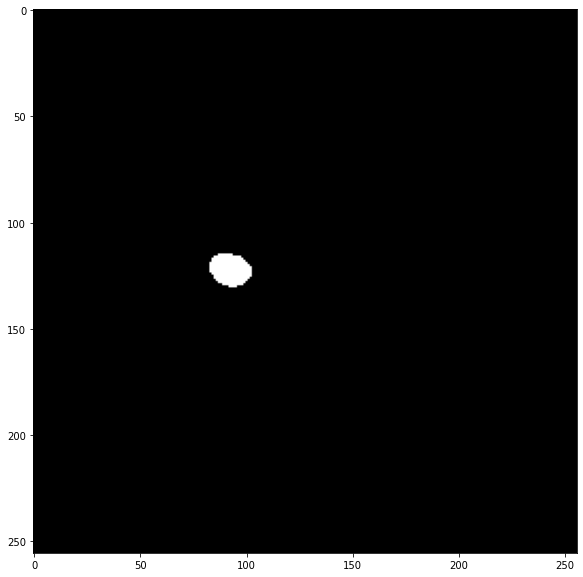

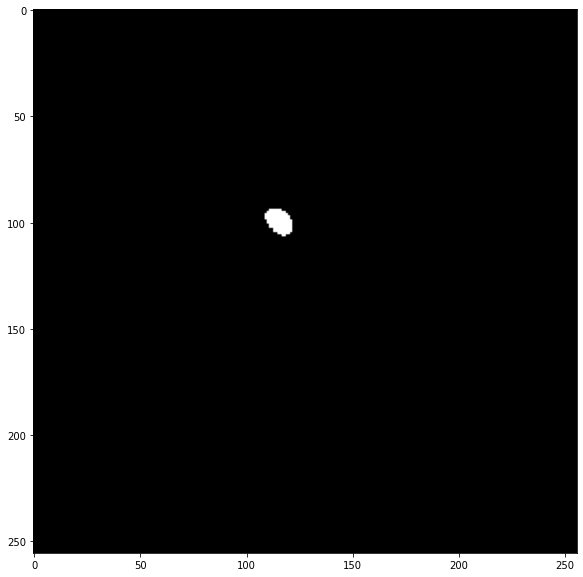

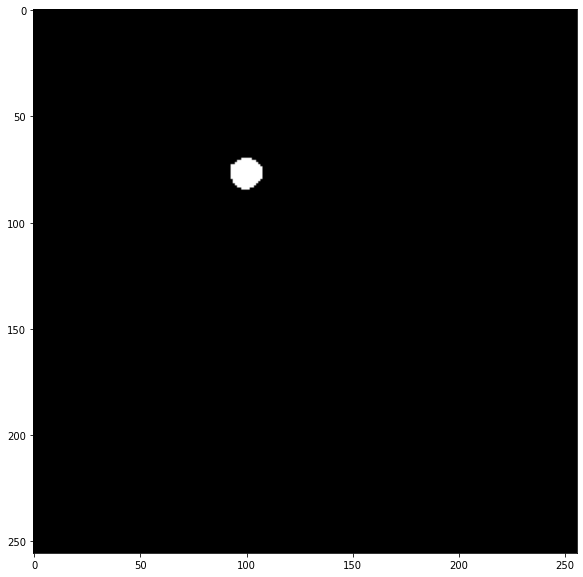

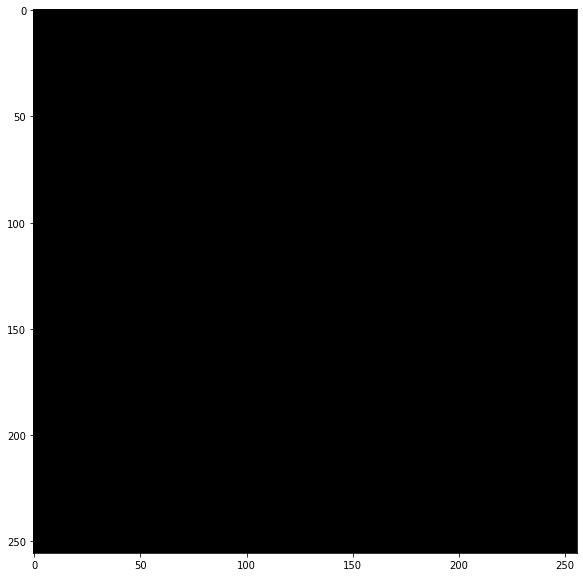

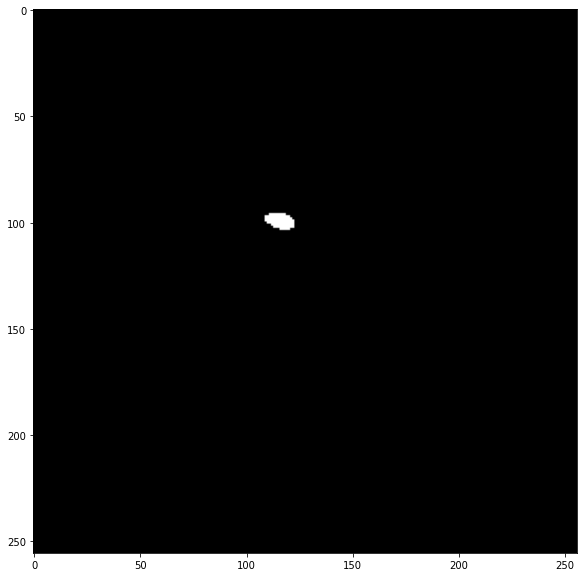

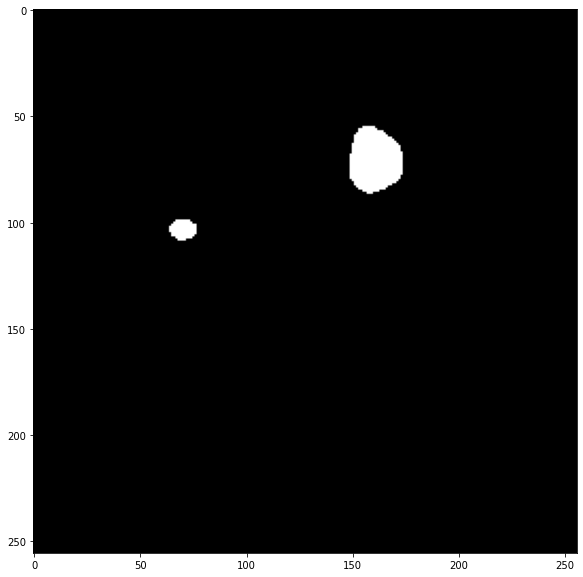

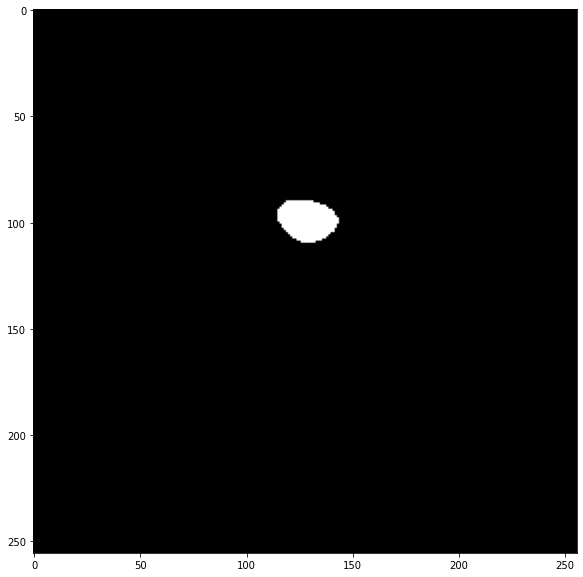

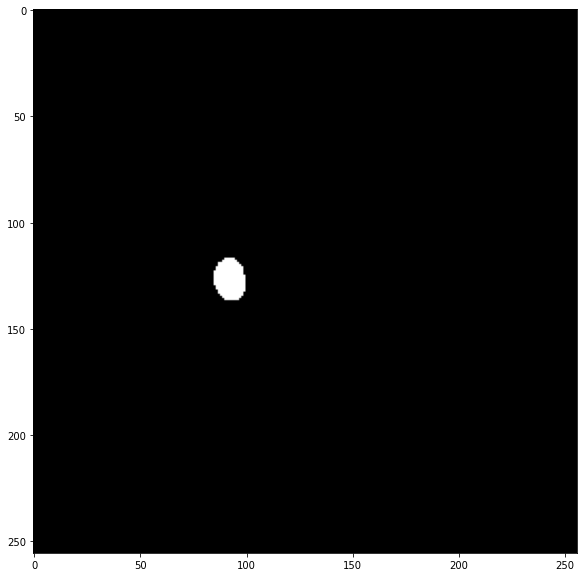

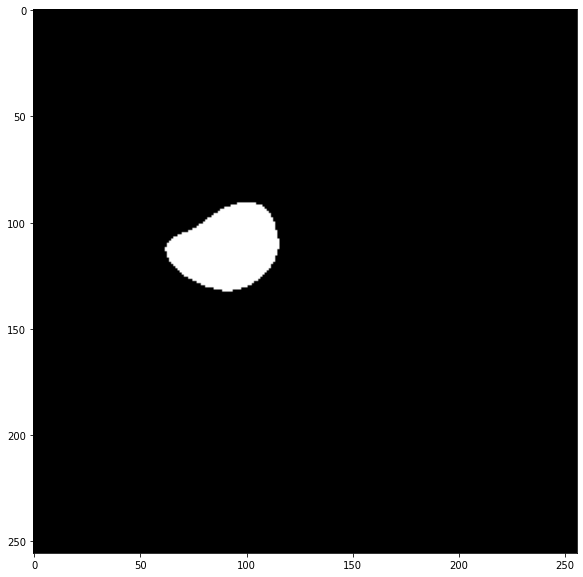

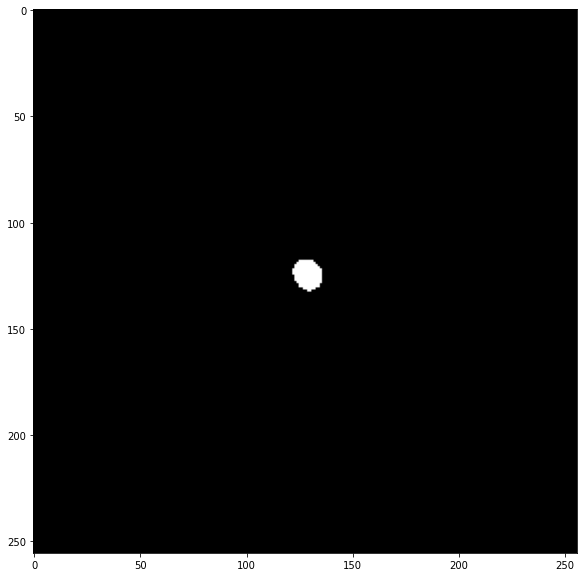

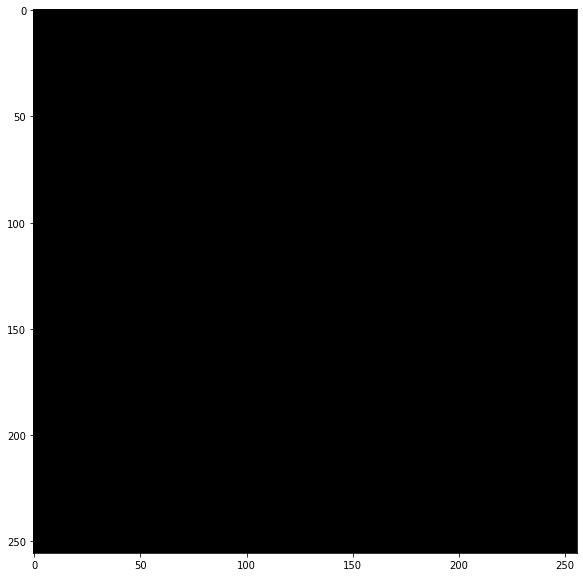

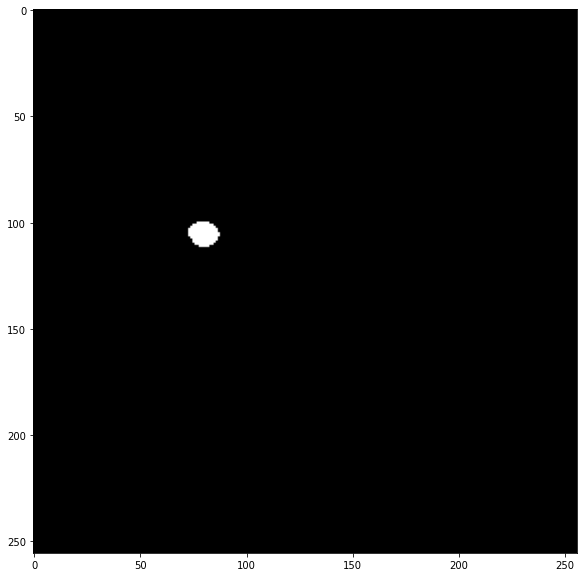

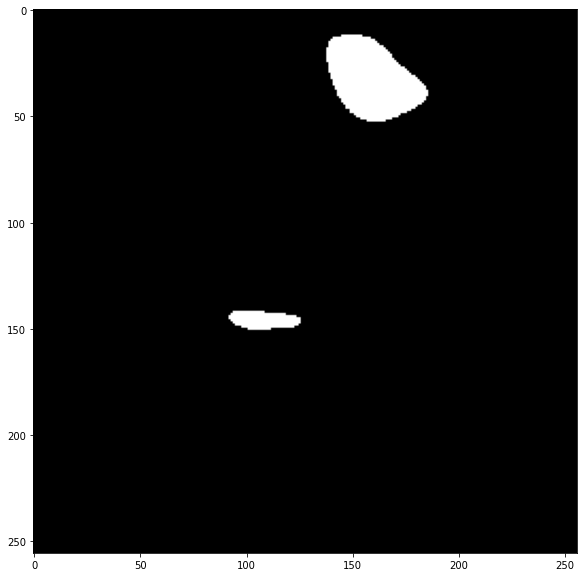

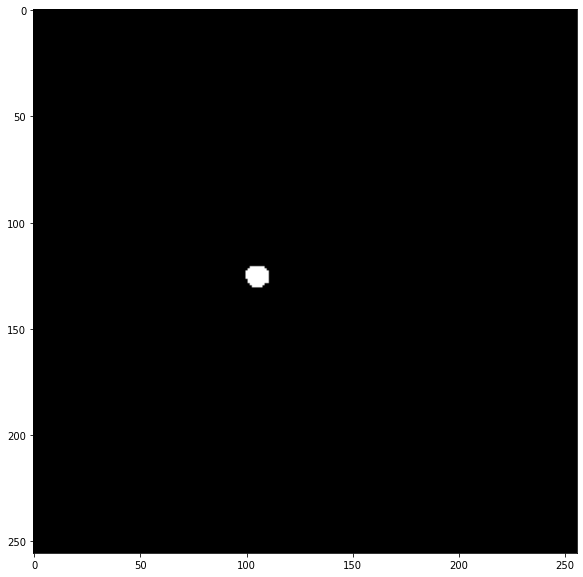

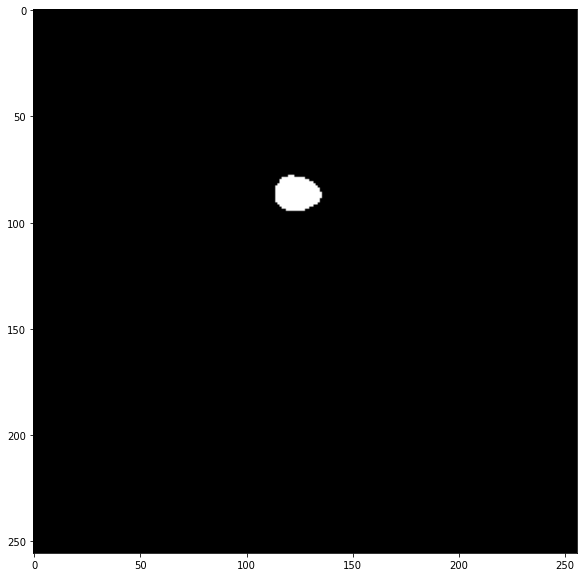

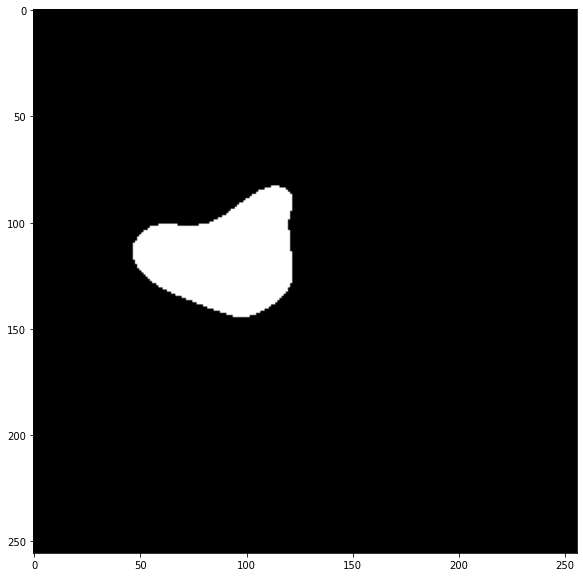

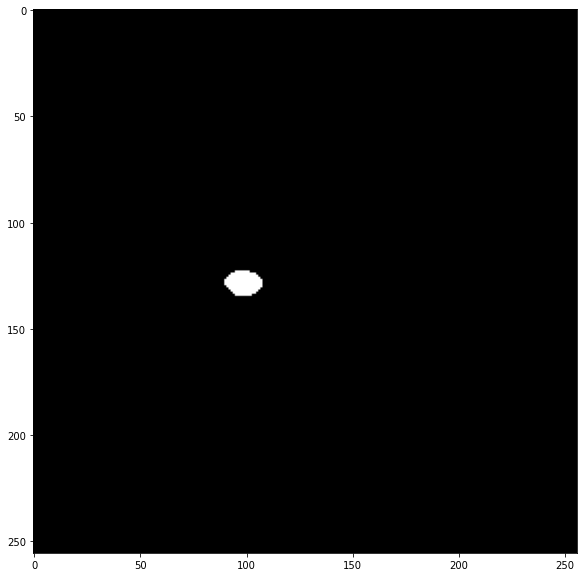

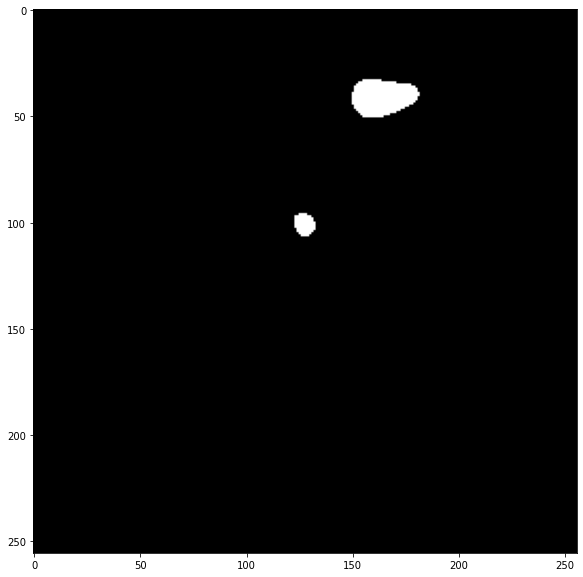

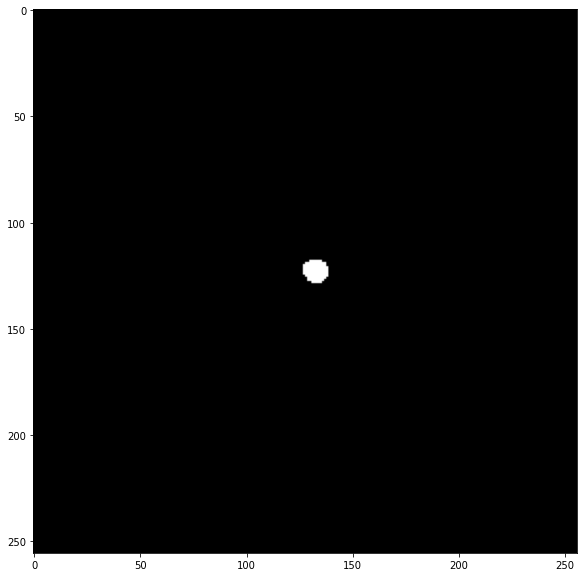

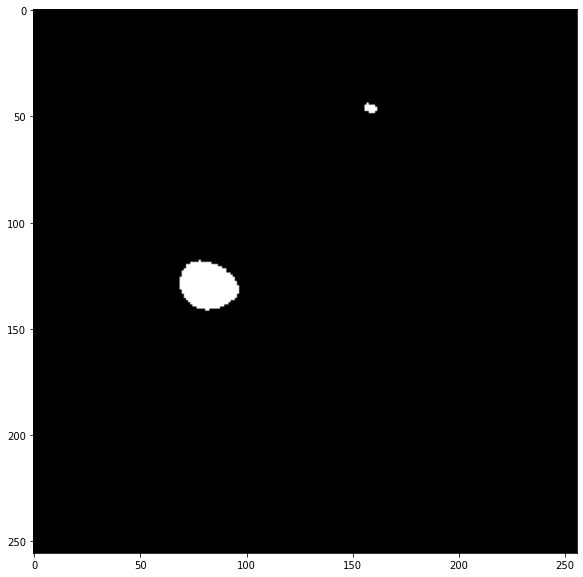

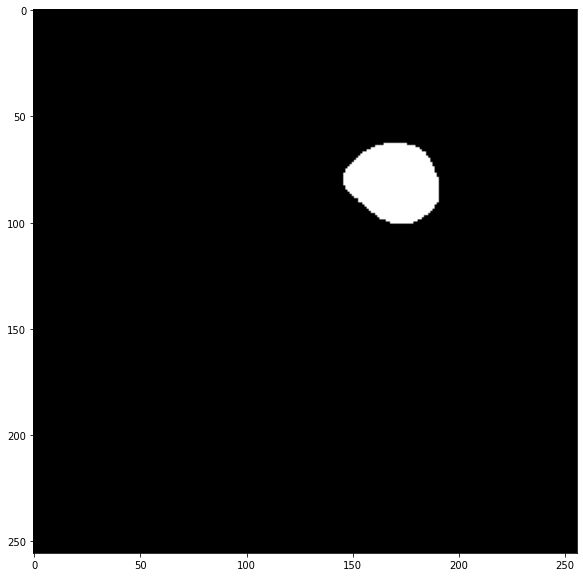

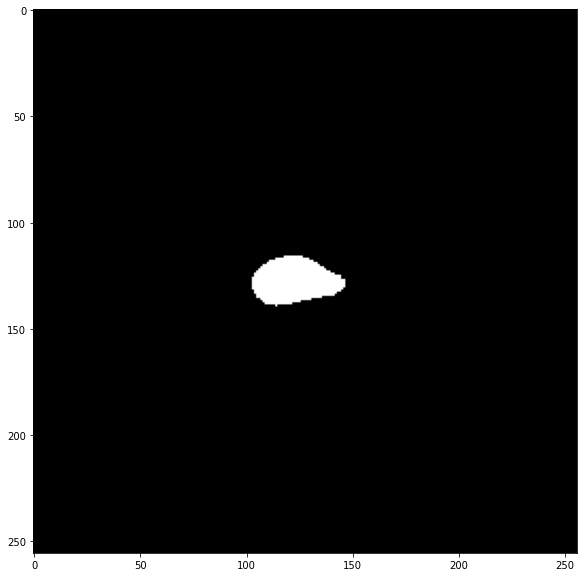

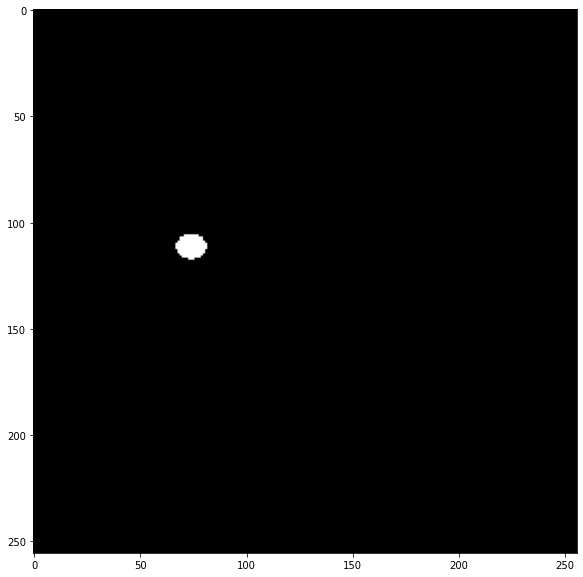

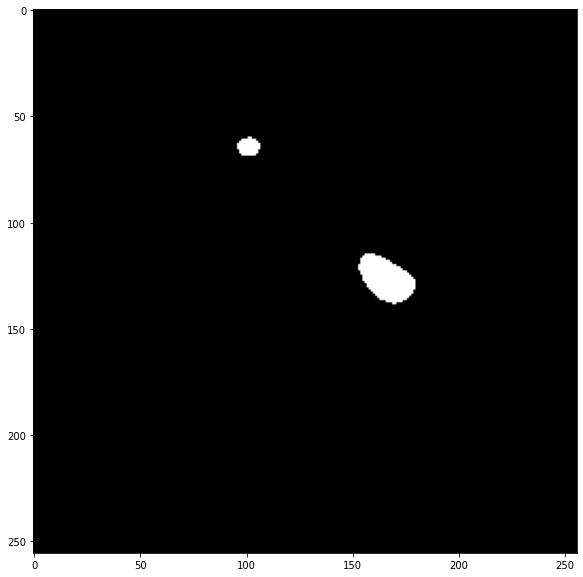

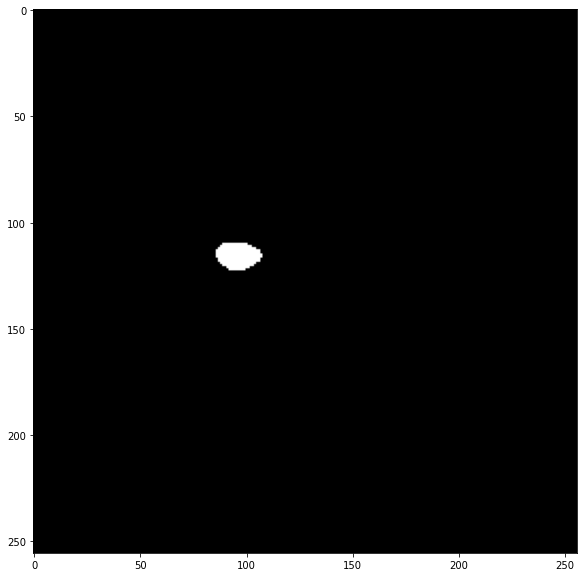

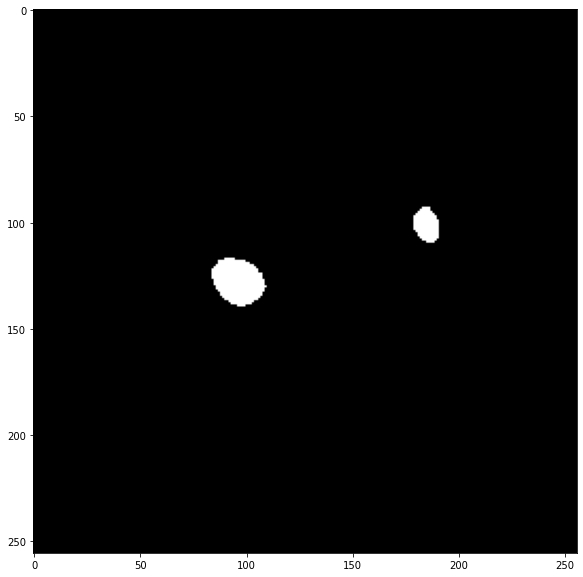

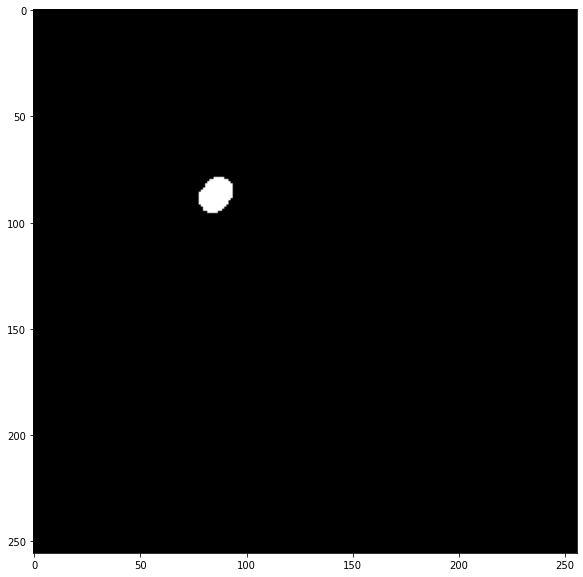

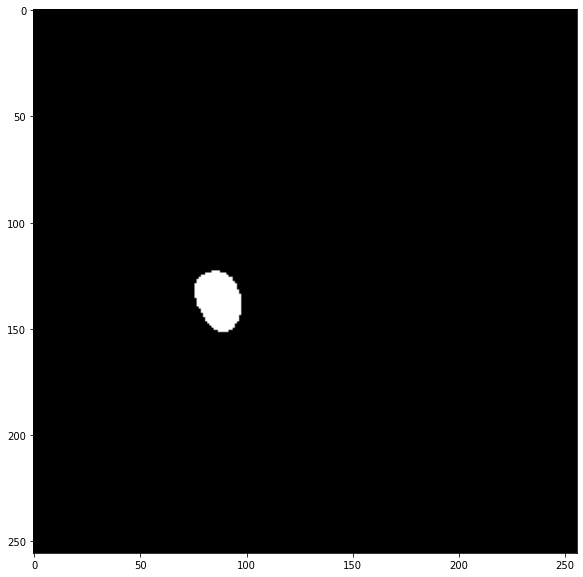

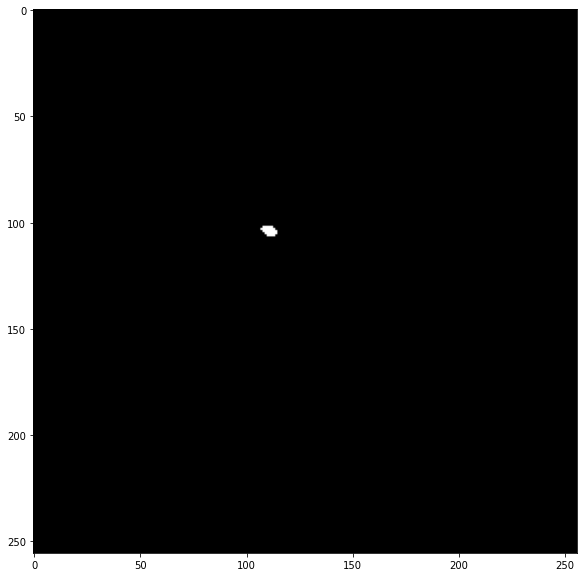

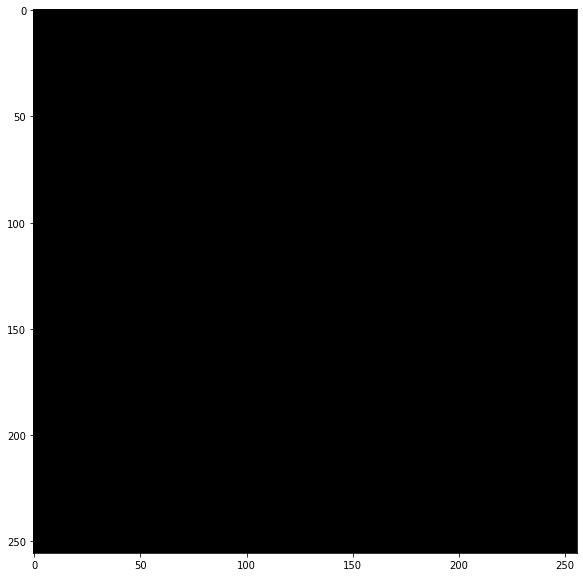

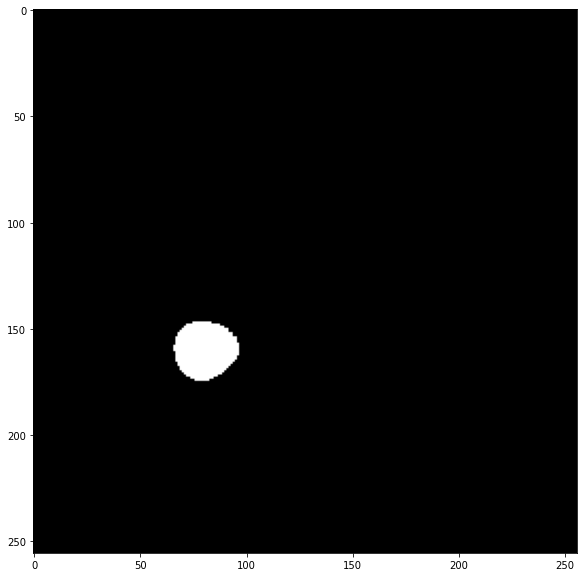

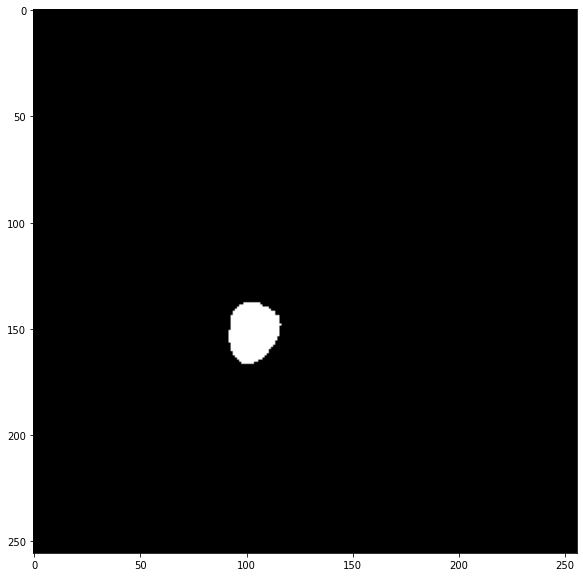

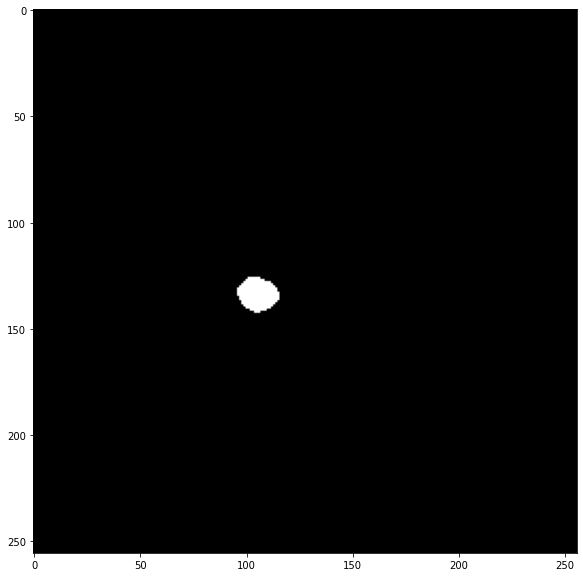

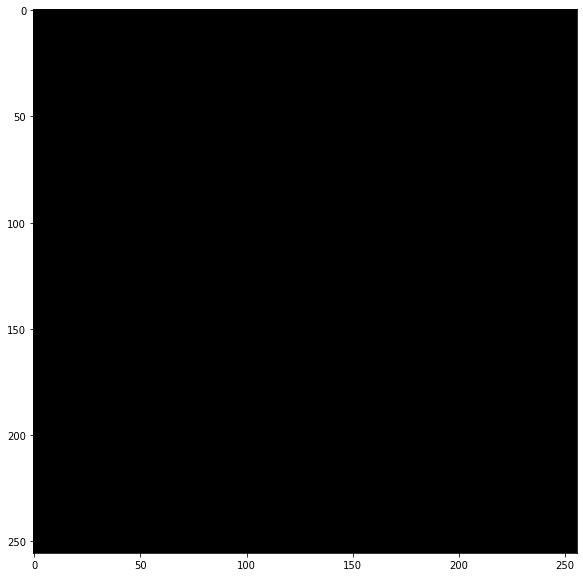

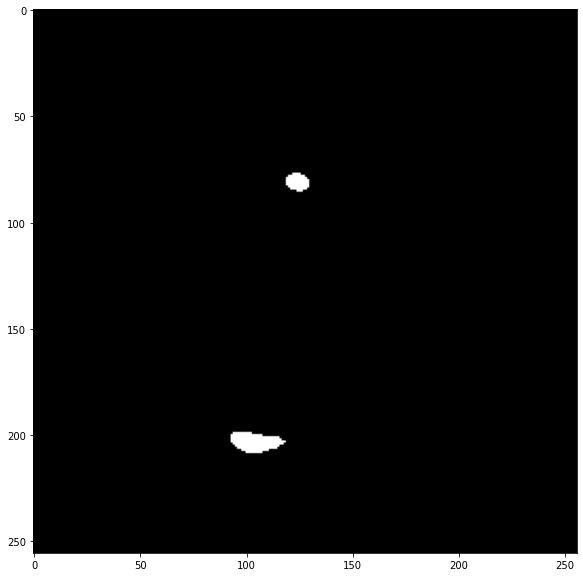

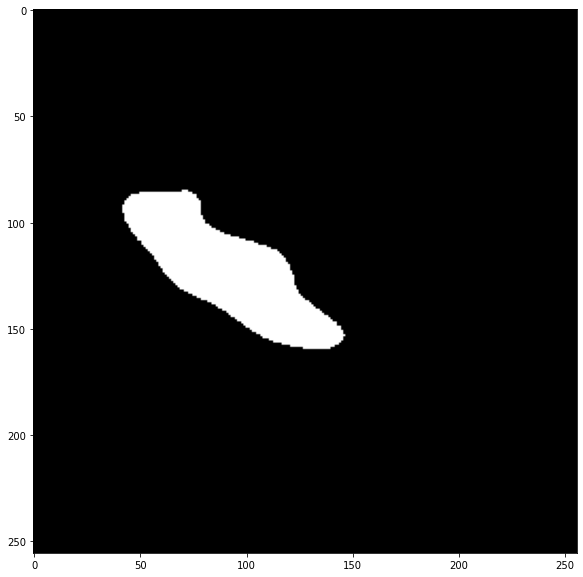

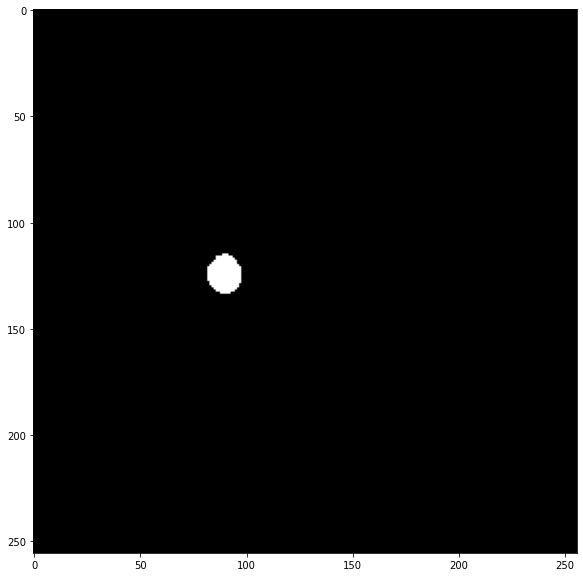

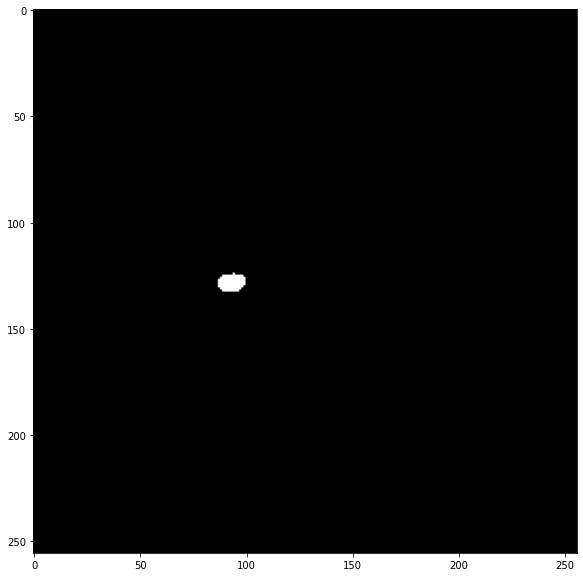

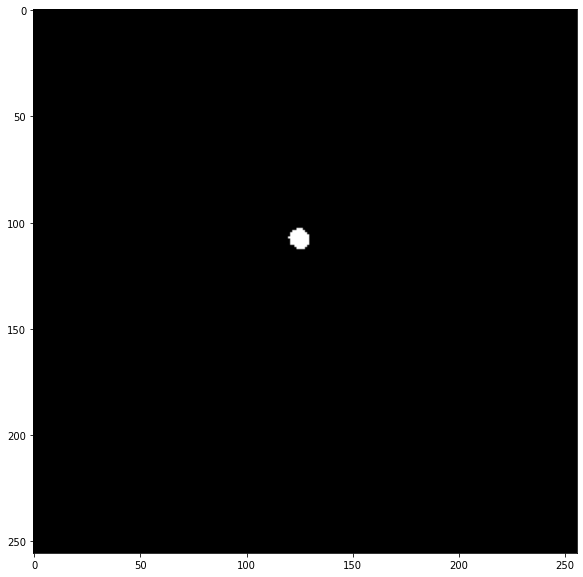

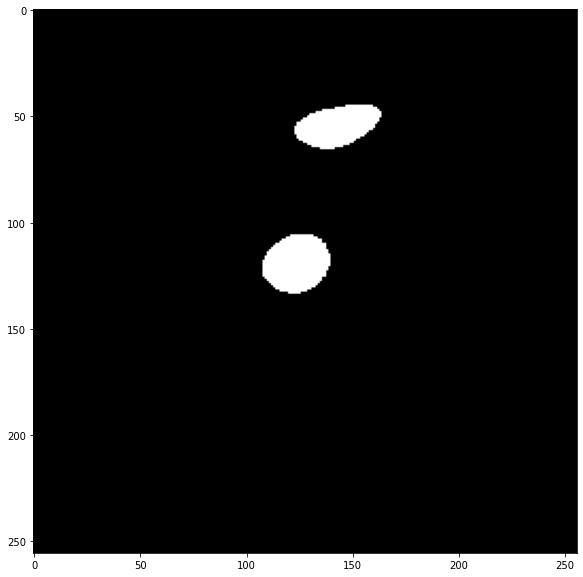

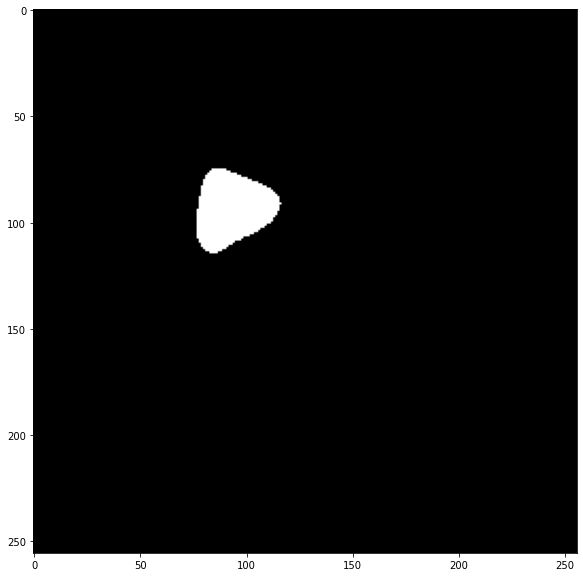

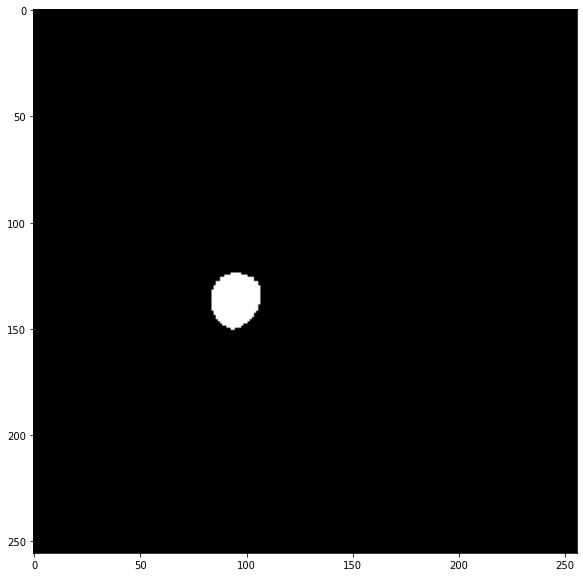

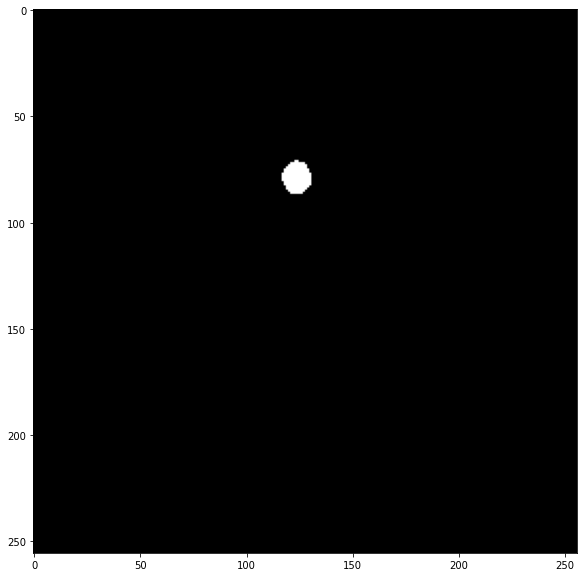

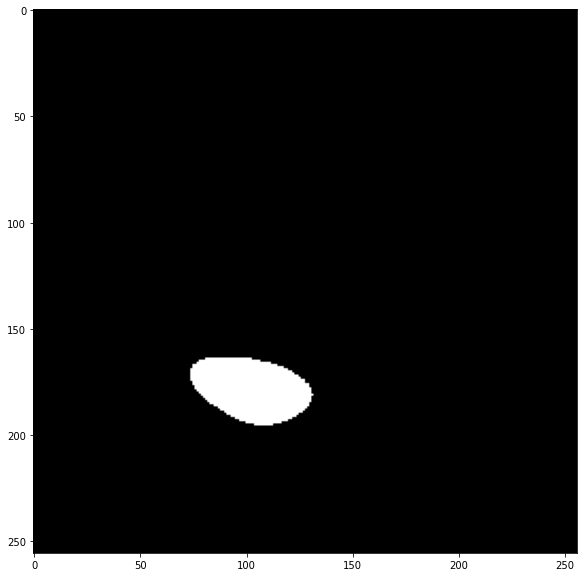

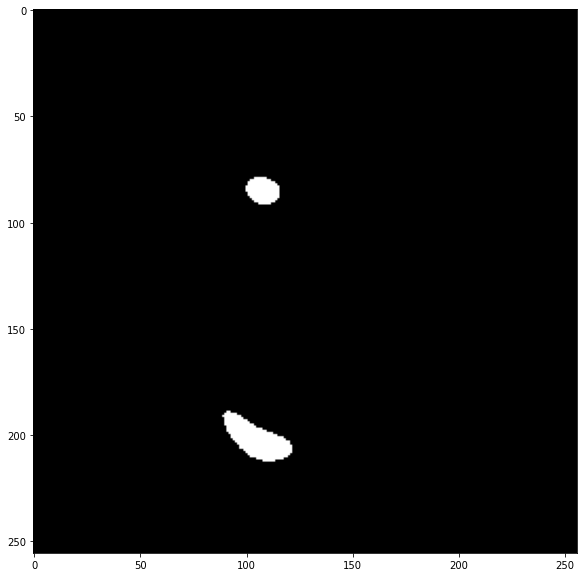

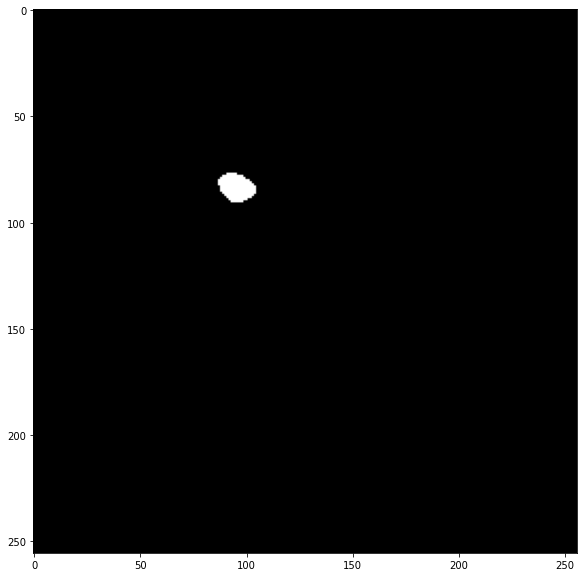

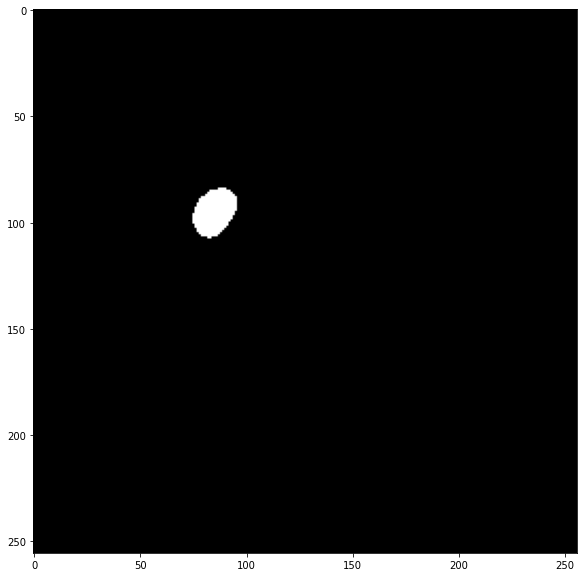

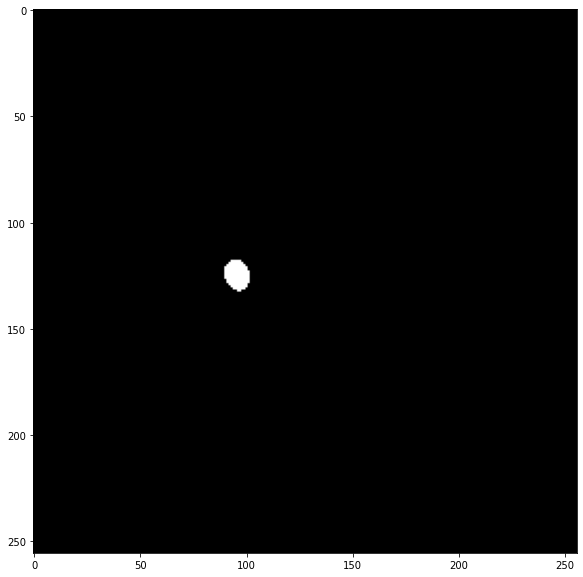

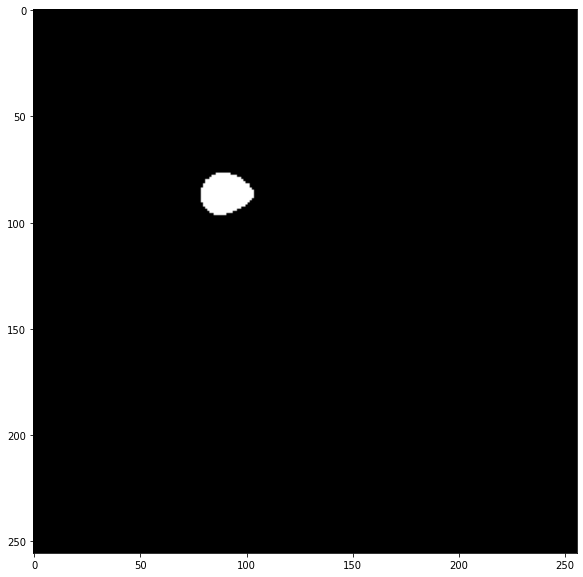

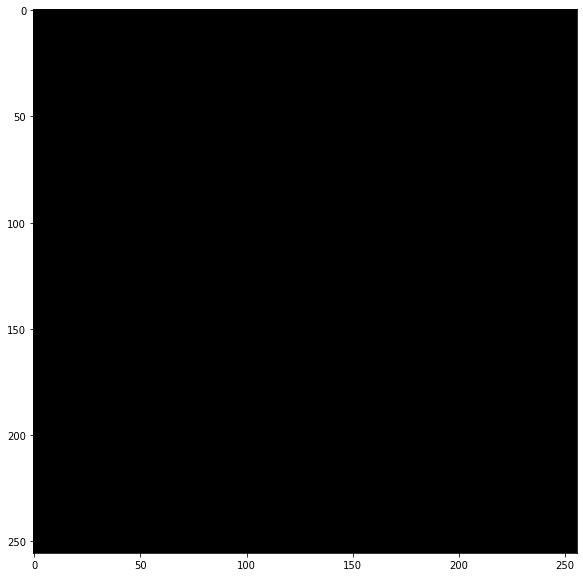

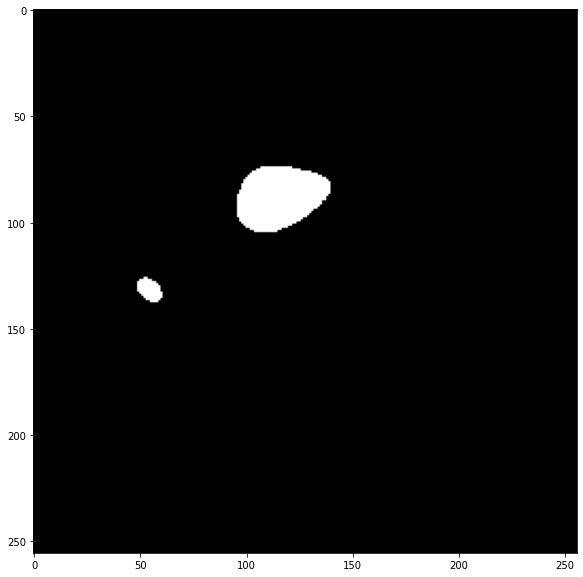

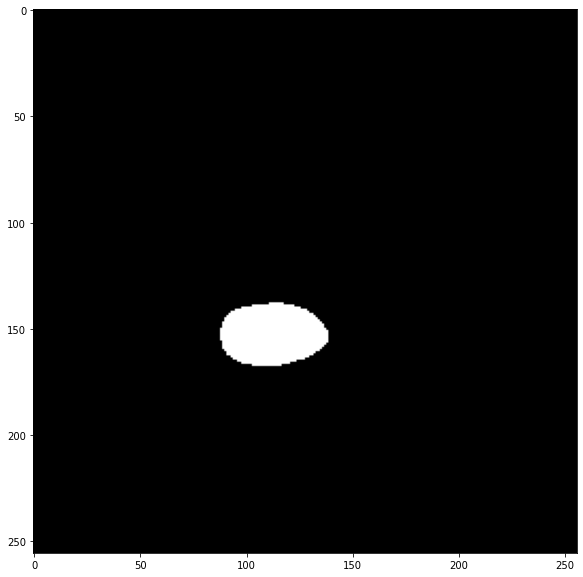

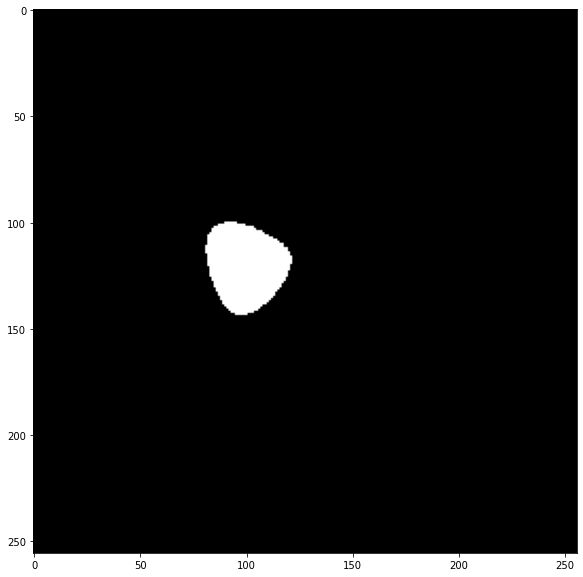

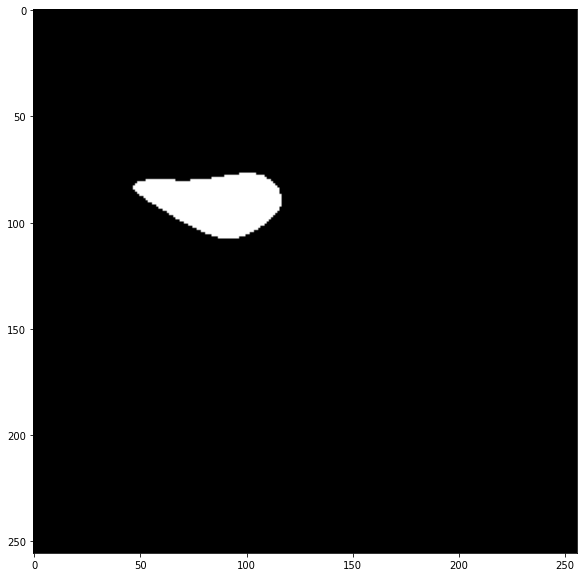

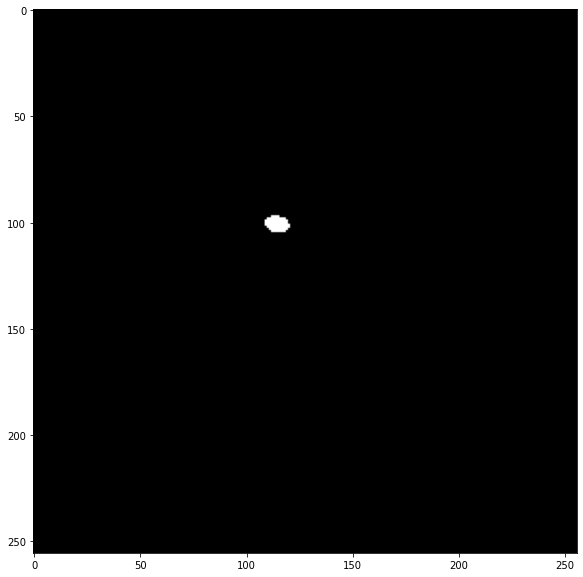

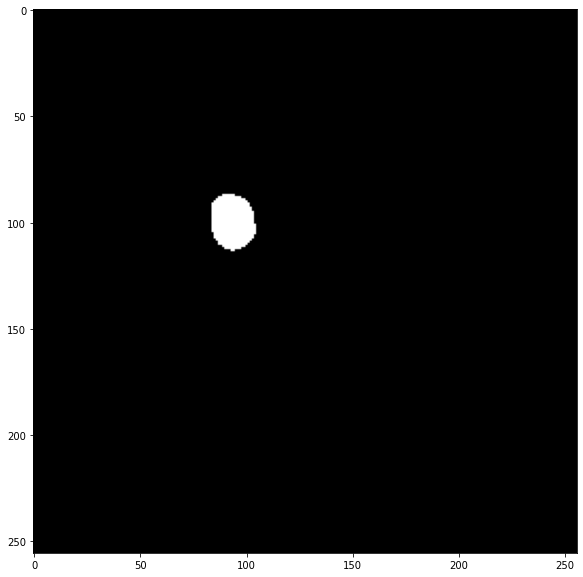

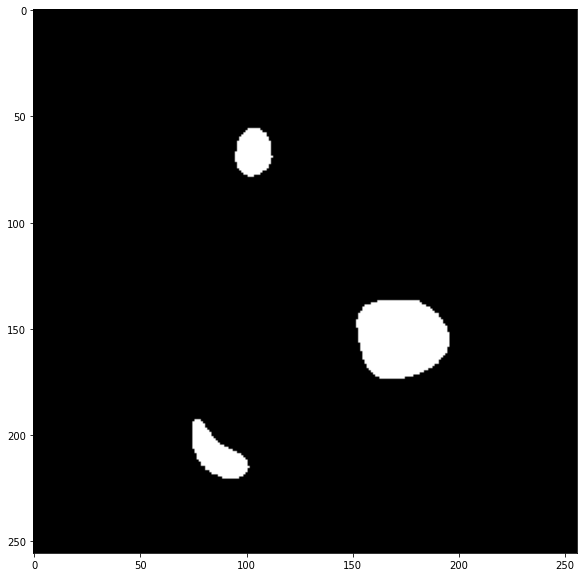

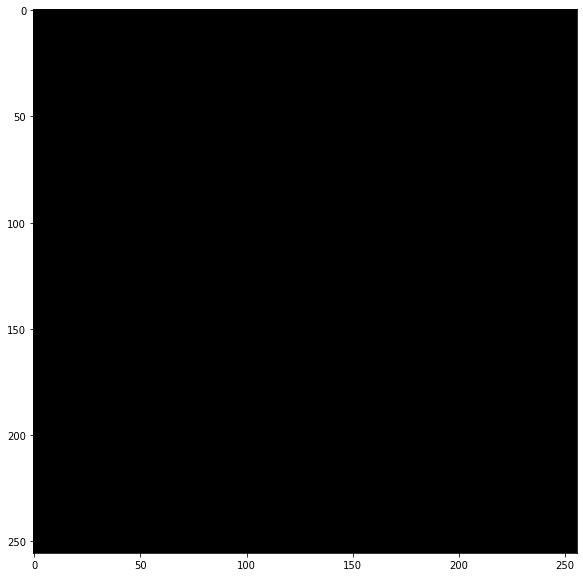

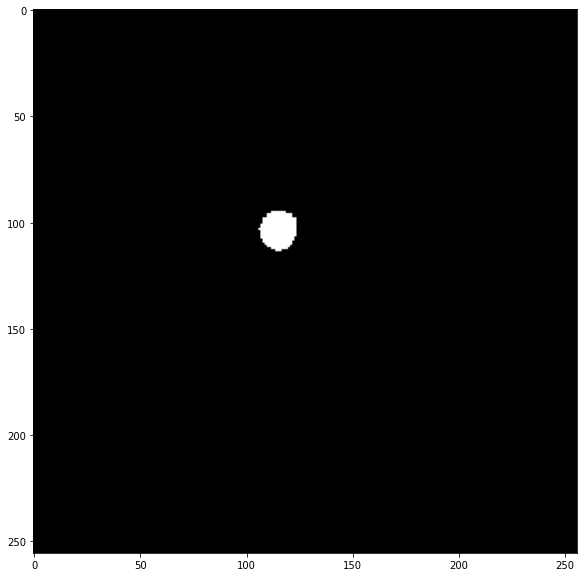

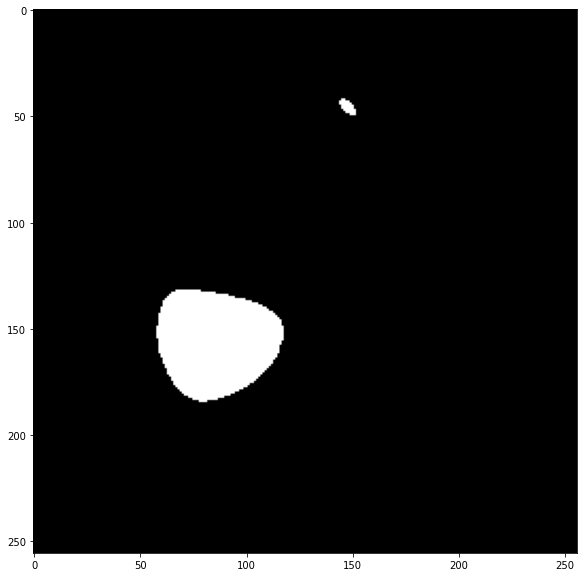

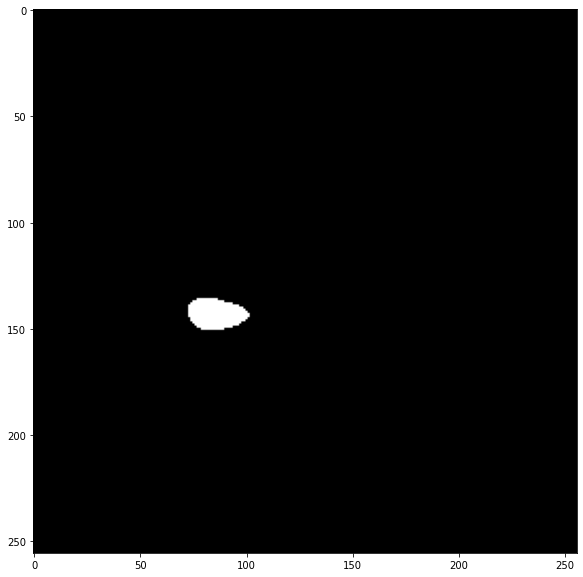

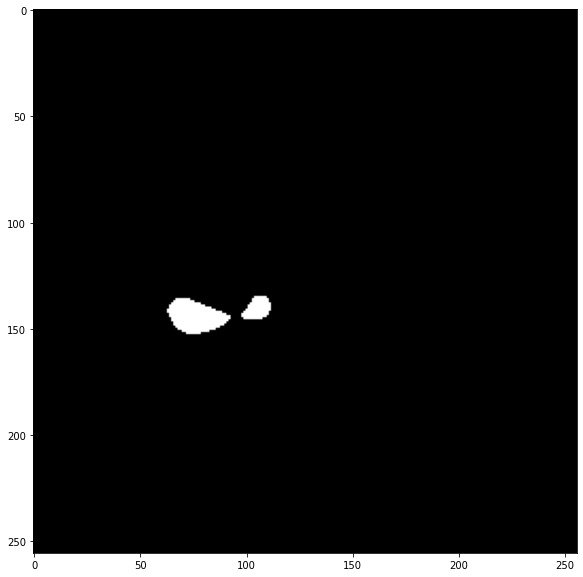

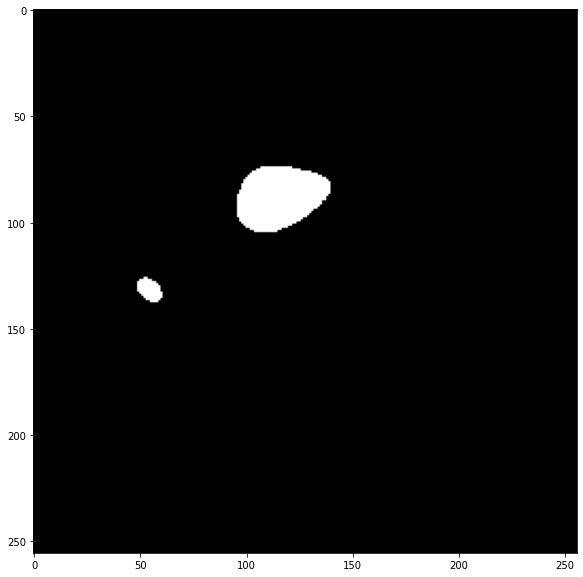

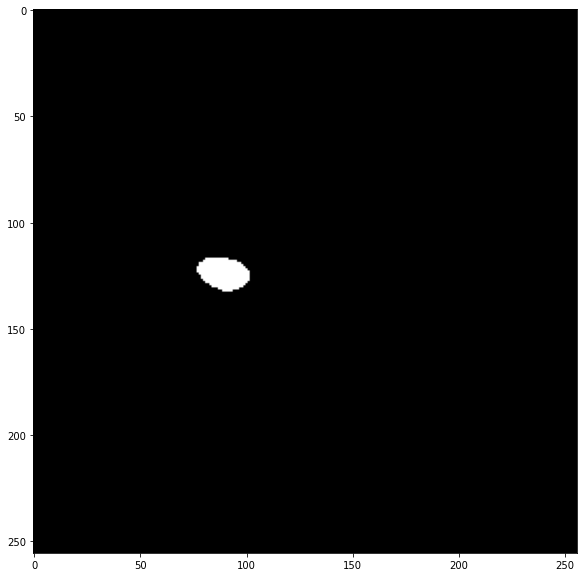

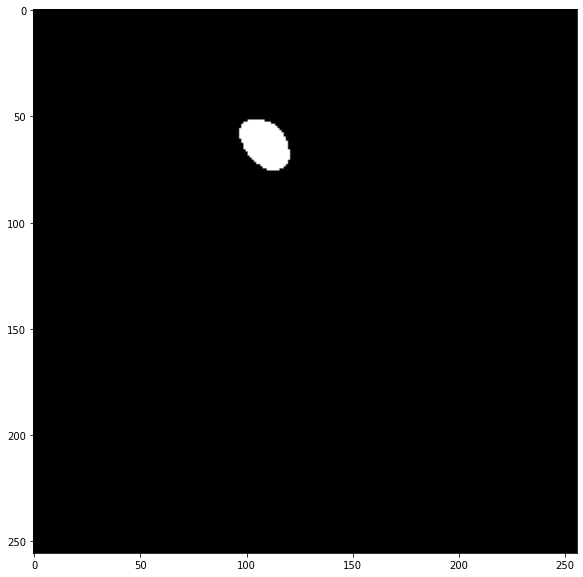

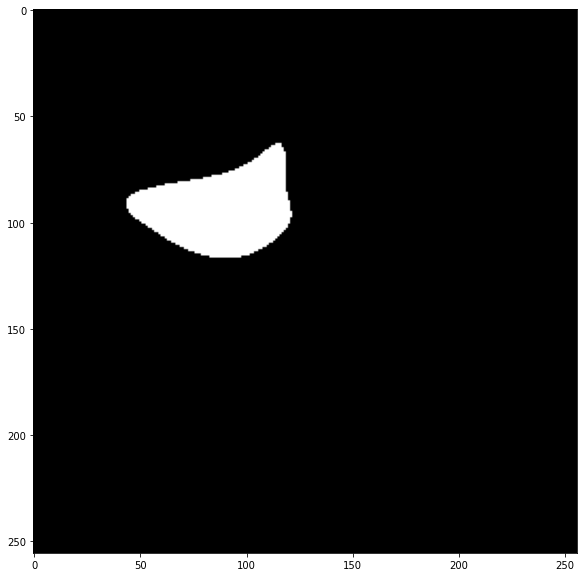

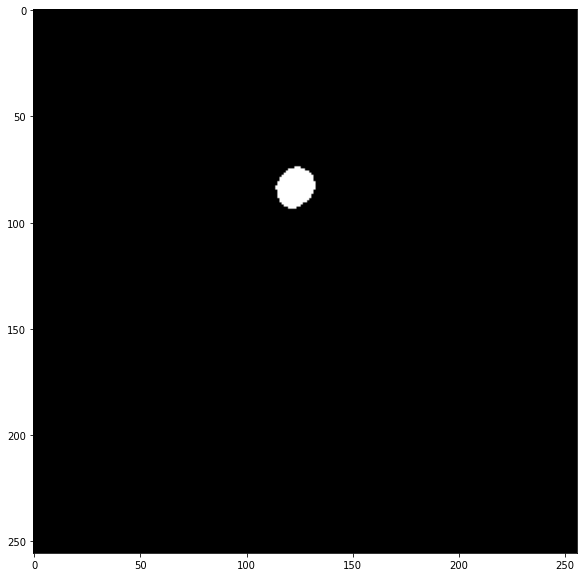

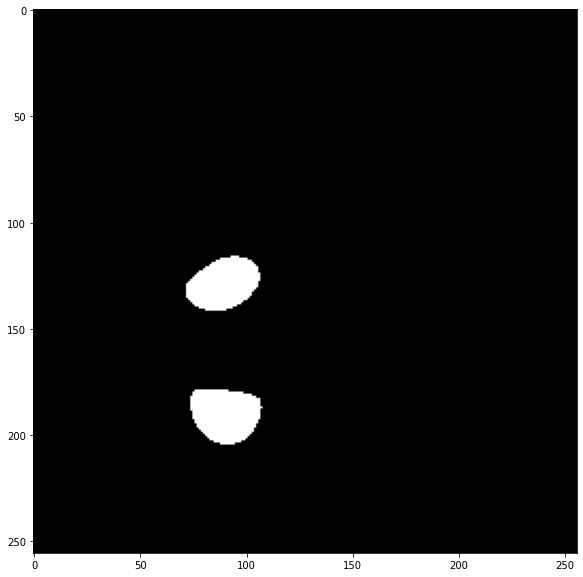

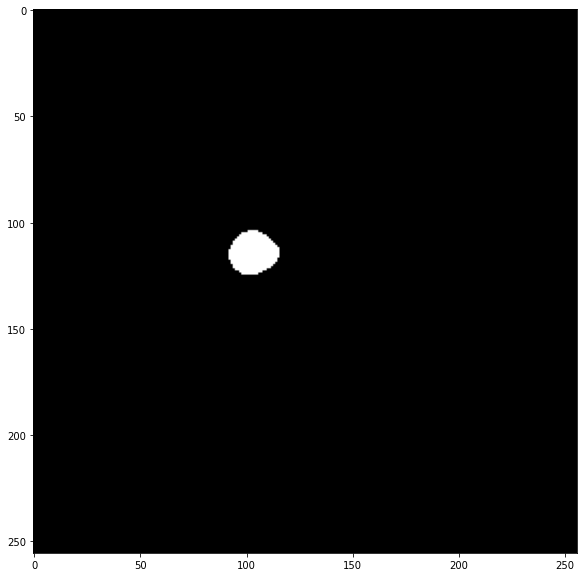

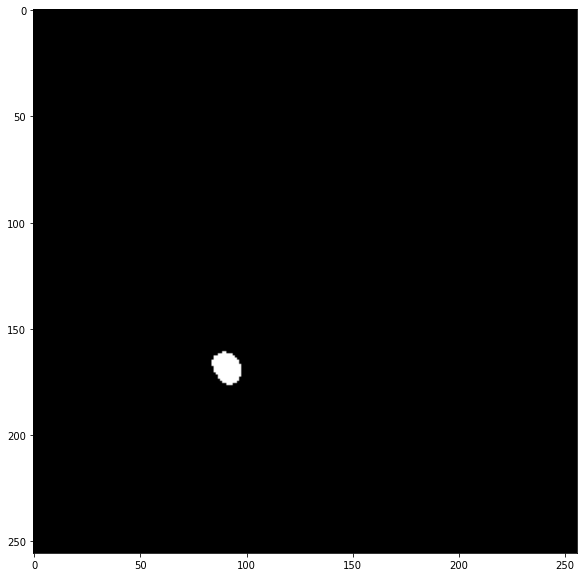

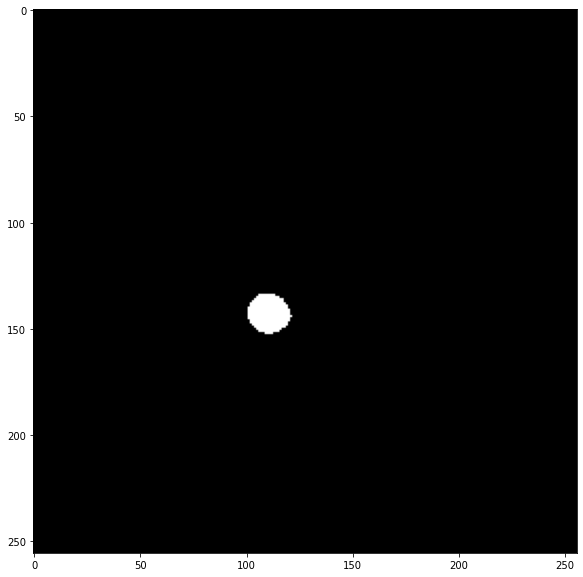

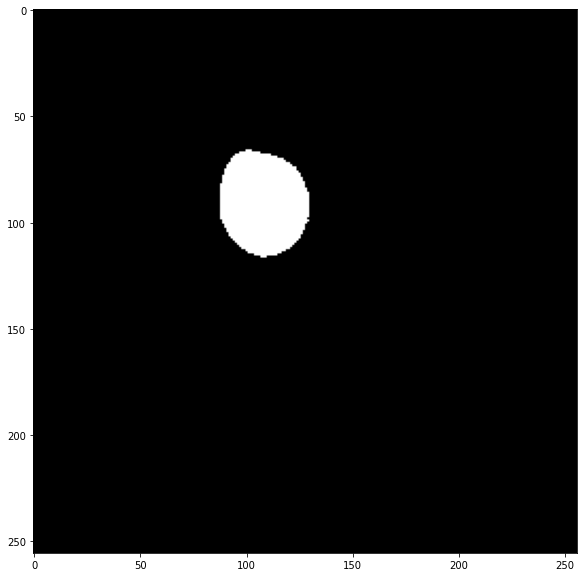

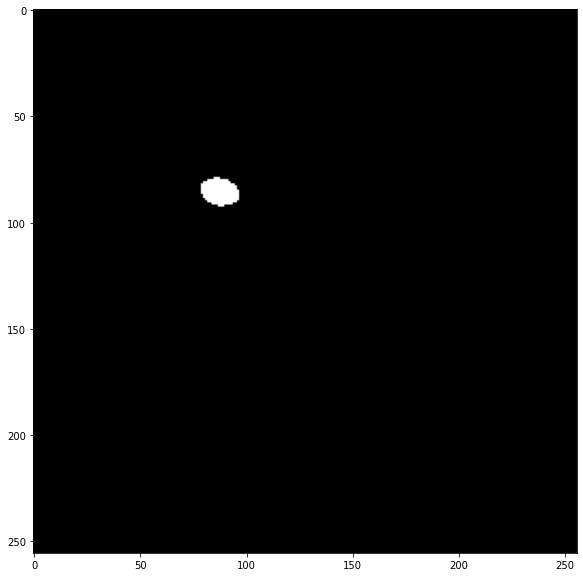

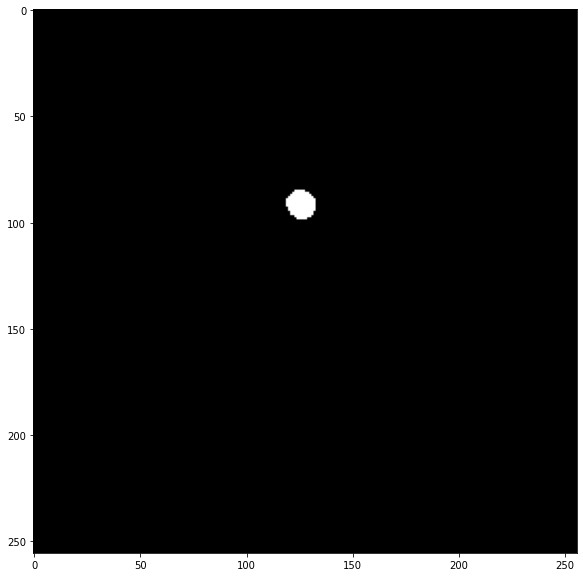

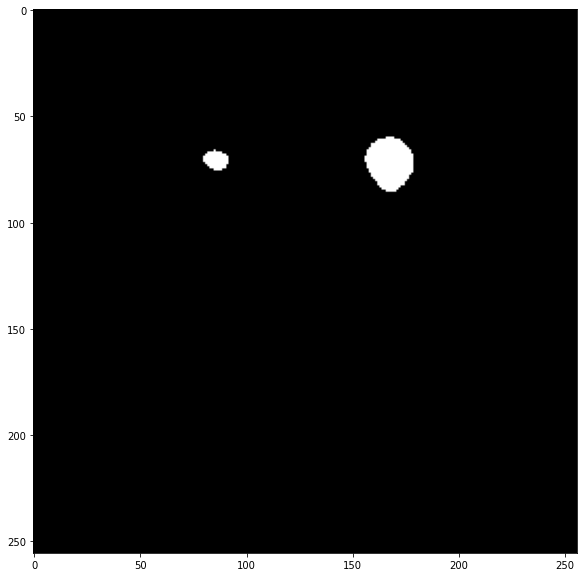

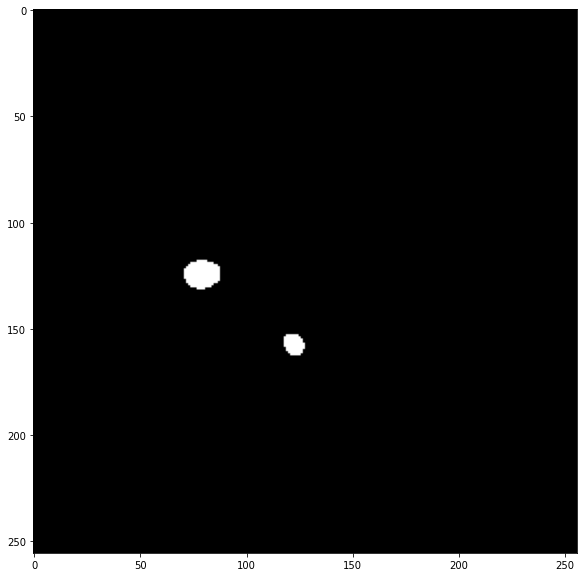

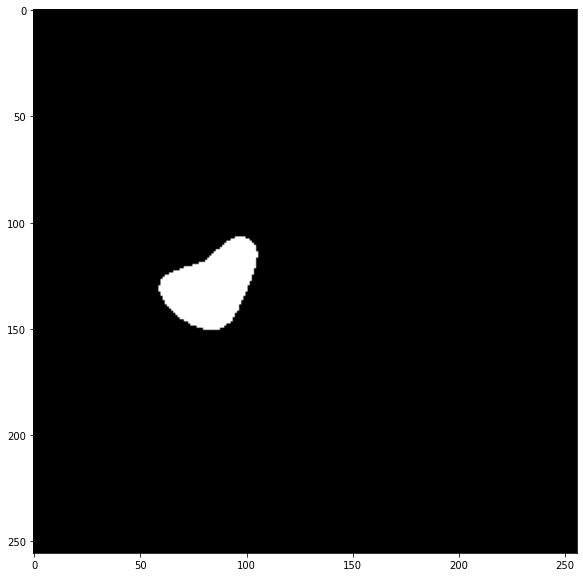

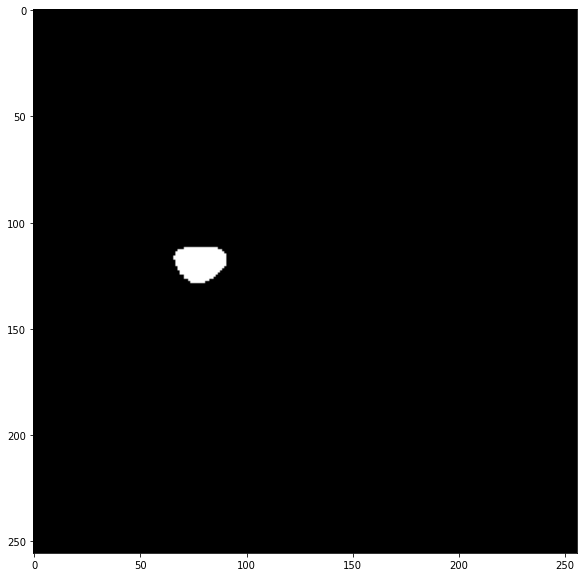

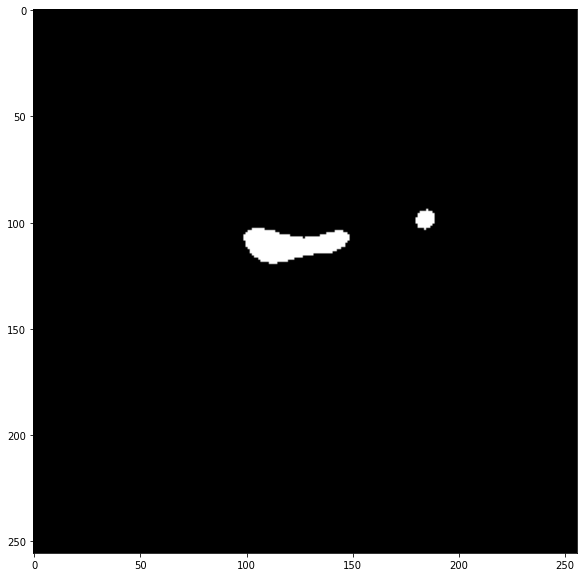

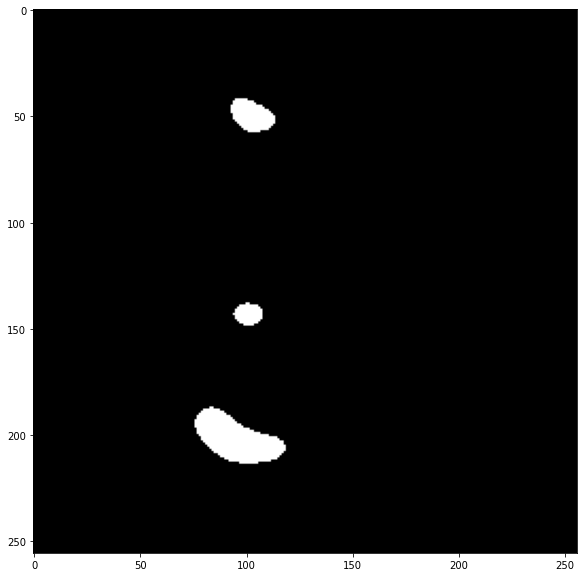

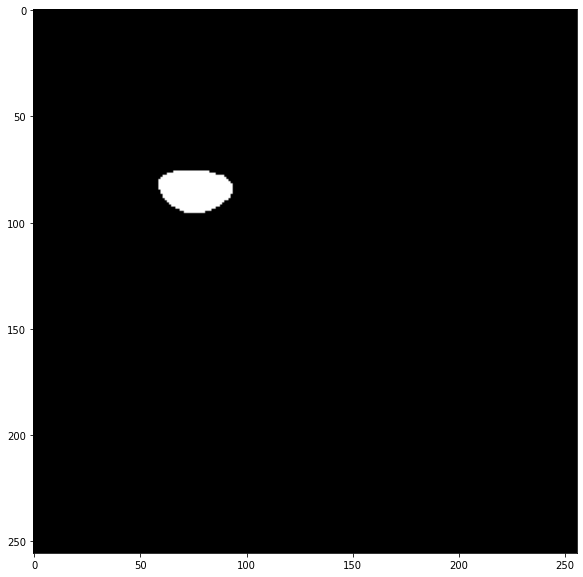

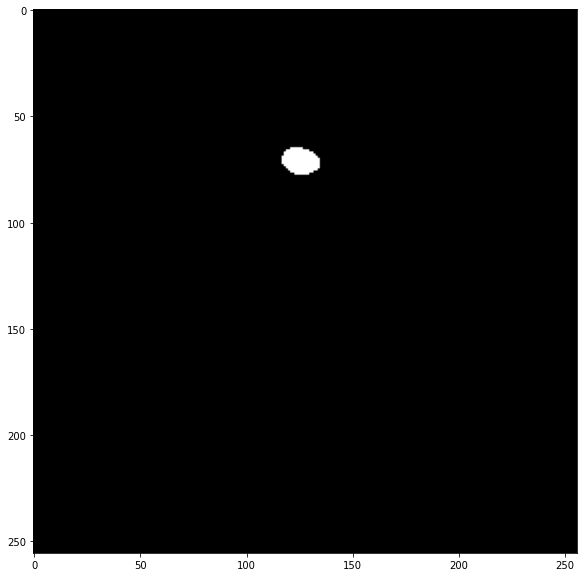

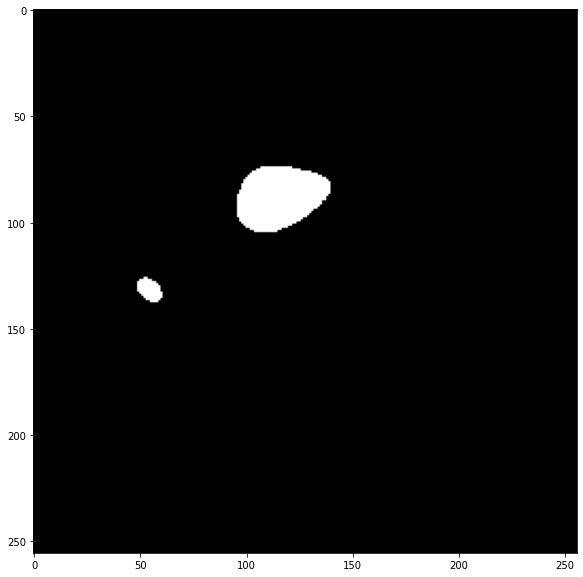

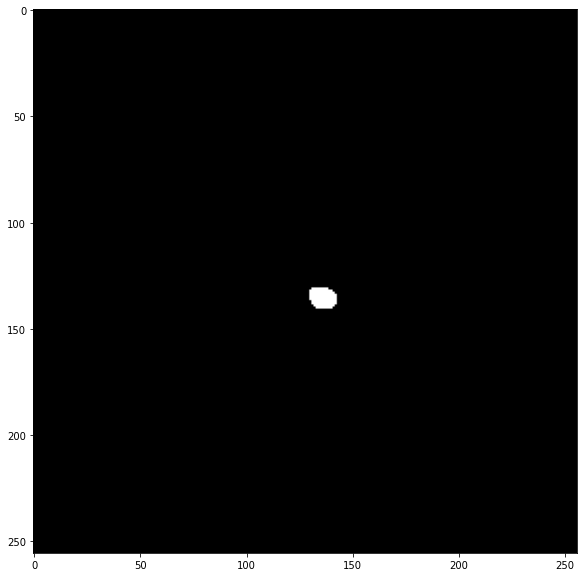

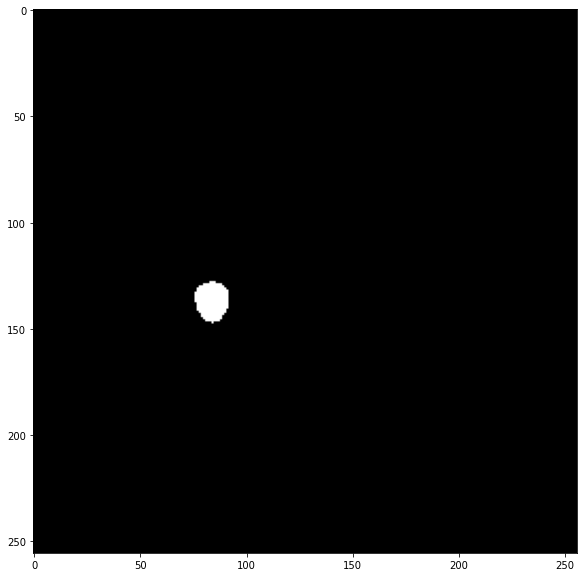

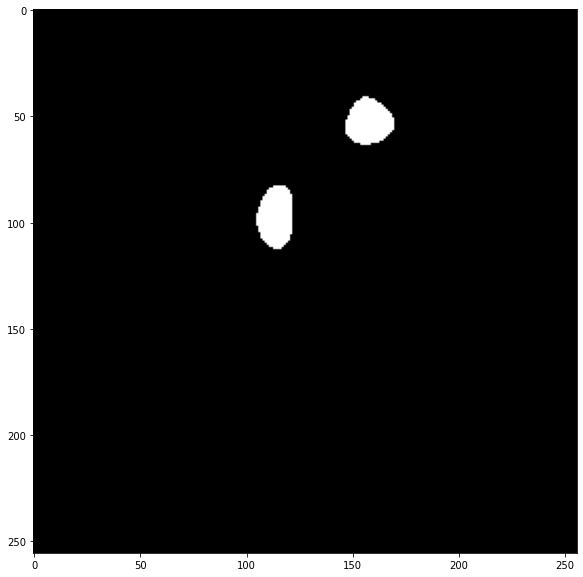

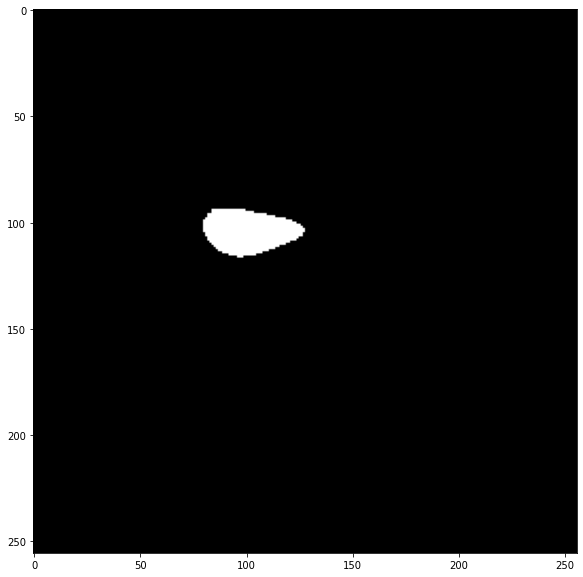

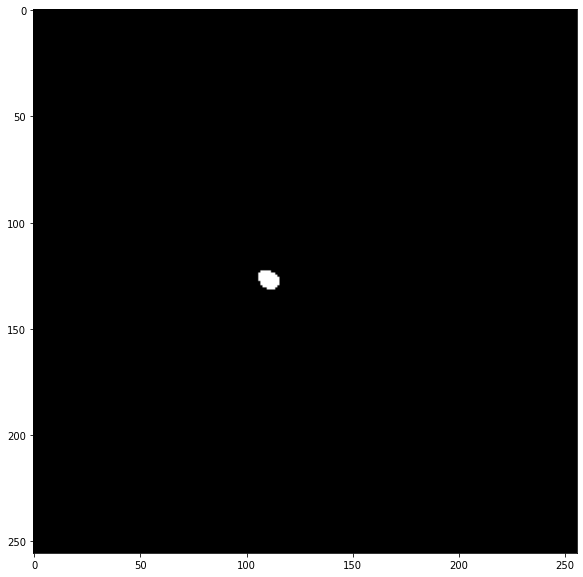

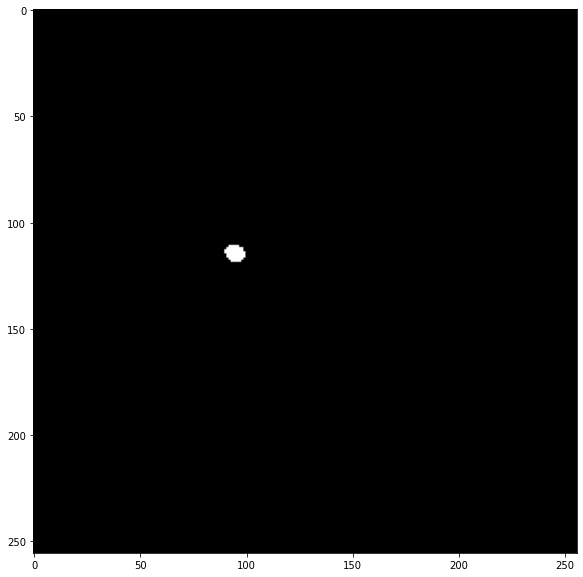

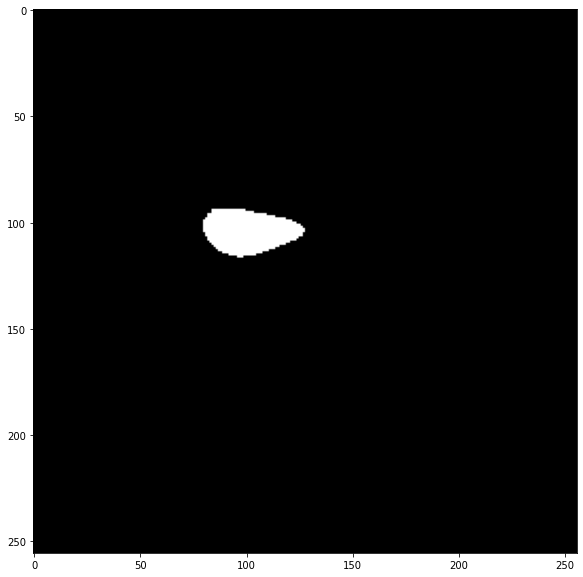

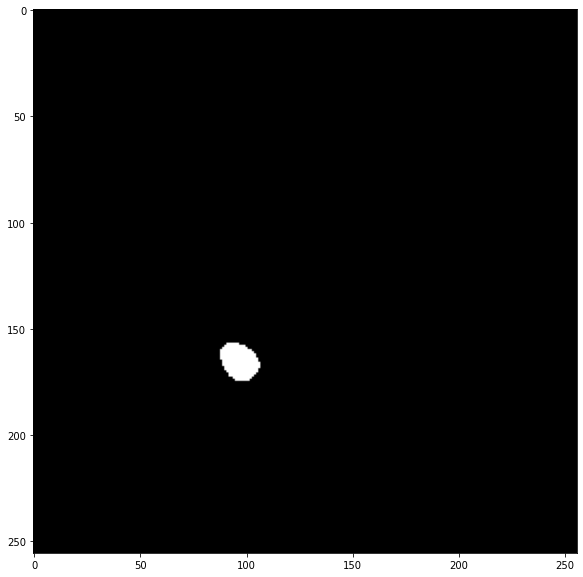

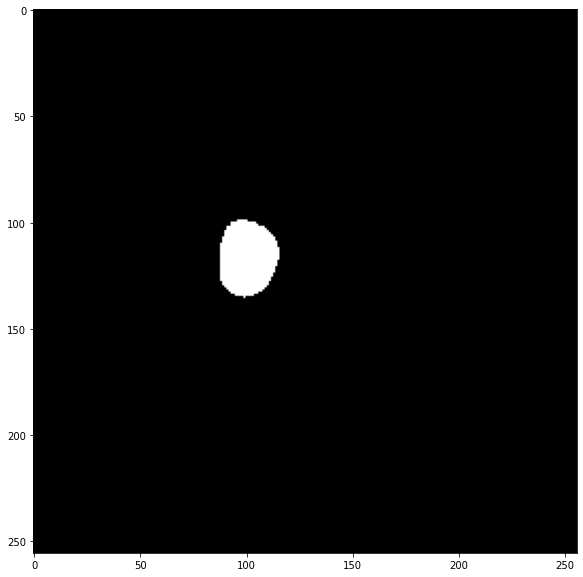

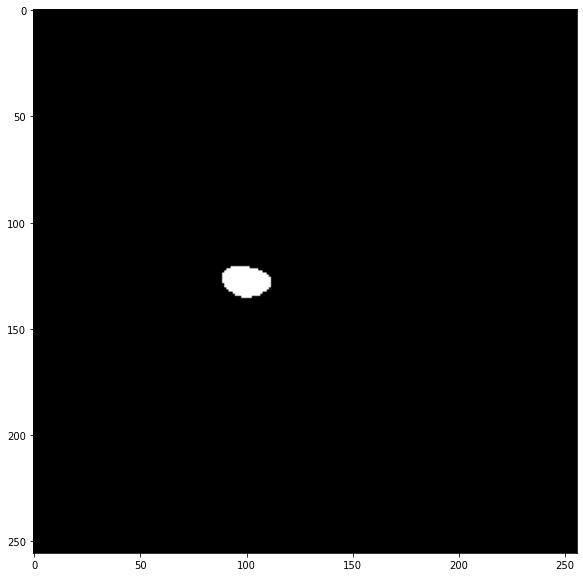

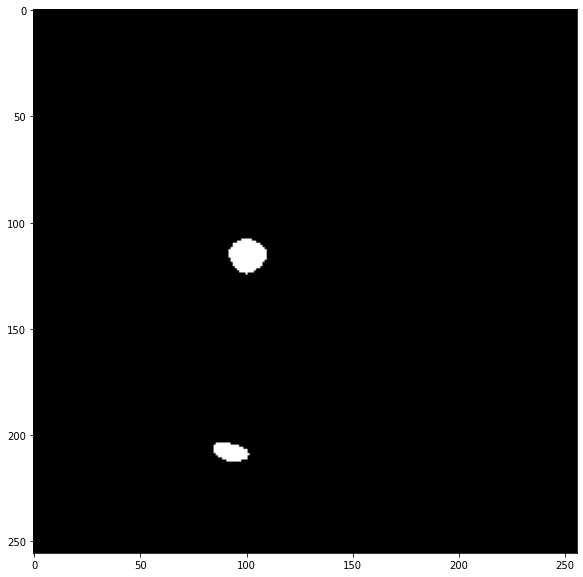

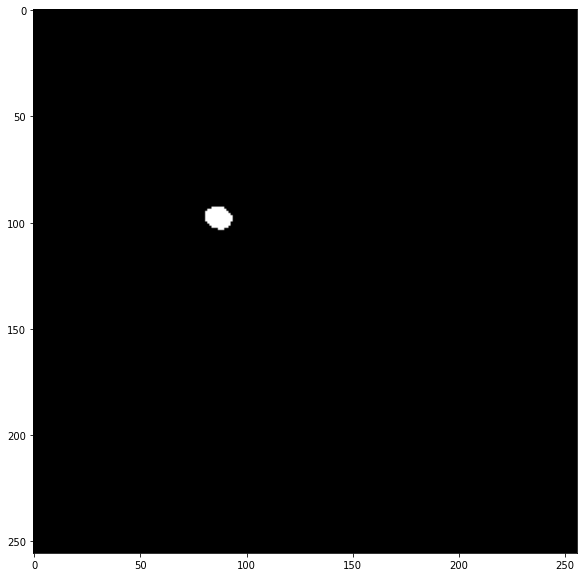

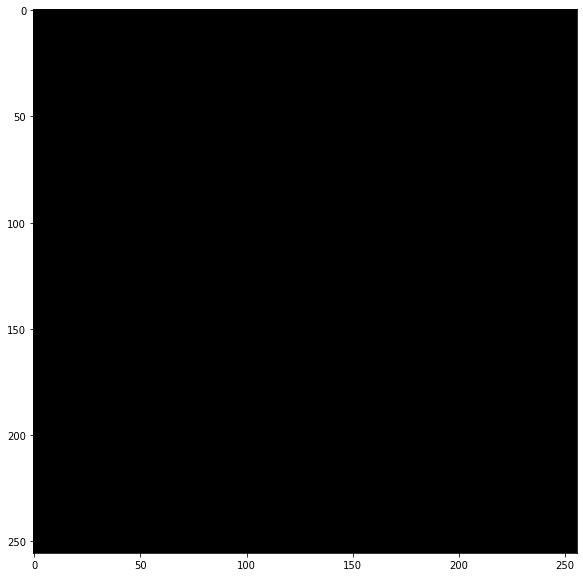

In [ ]:
# prediction of Segnet
%%time
aa = 0
for image in test_dataset:
  pred_mask = model_seg.predict(image)
  pred_mask[pred_mask > 0.5] = 1
  pred_mask[pred_mask <= 0.5] = 0
  pred_mask = pred_mask.squeeze()
  pred_mask = pred_mask[..., tf.newaxis]
  for i in range(10):
    plt.figure(figsize=(10, 10))
    plt.imshow(tf.keras.preprocessing.image.array_to_img(tf.image.grayscale_to_rgb(tf.convert_to_tensor(pred_mask[i]))))
    plt.savefig('./Colab Notebooks/data/test/labels_seg3/'+test_image[aa][35:])
    aa += 1

In [ ]:
# Pspnet
def identity_block(x, f_kernel_size, filters, dilation, pad):
    filters_1, filters_2, filters_3 = filters
    x_shortcut = x

    # stage 1
    x = tf.keras.layers.Conv2D(filters=filters_1, kernel_size=(1, 1), strides=(1, 1), padding='valid',
                               kernel_initializer=glorot_uniform(seed=0))(x)
    x = tf.keras.layers.BatchNormalization(momentum=0.95, axis=-1)(x)
    x = tf.keras.layers.Activation(activation='relu')(x)

    # stage 2
    x = tf.keras.layers.ZeroPadding2D(padding=pad)(x)
    x = tf.keras.layers.Conv2D(filters=filters_2, kernel_size=f_kernel_size, strides=(1, 1),
                               dilation_rate=dilation, kernel_initializer=glorot_uniform(seed=0))(x)
    x = tf.keras.layers.BatchNormalization(momentum=0.95, axis=-1)(x)
    x = tf.keras.layers.Activation(activation='relu')(x)

    # stage 3
    x = tf.keras.layers.Conv2D(filters=filters_3, kernel_size=(1, 1), strides=(1, 1), padding='valid',
                               kernel_initializer=glorot_uniform(seed=0))(x)
    x = tf.keras.layers.BatchNormalization(momentum=0.95, axis=-1)(x)

    # stage 4
    x = tf.keras.layers.Add()([x, x_shortcut])
    x = tf.keras.layers.Activation(activation='relu')(x)
    return x


def convolutional_block(x, f_kernel_size, filters, strides, dilation, pad):
    filters_1, filters_2, filters_3 = filters
    x_shortcut = x

    # stage 1
    x = tf.keras.layers.Conv2D(filters=filters_1, kernel_size=(1, 1), strides=strides, padding='valid',
                               kernel_initializer=glorot_uniform(seed=0))(x)
    x = tf.keras.layers.BatchNormalization(momentum=0.95, axis=-1)(x)
    x = tf.keras.layers.Activation(activation='relu')(x)

    # stage 2
    x = tf.keras.layers.ZeroPadding2D(padding=pad)(x)
    x = tf.keras.layers.Conv2D(filters=filters_2, kernel_size=f_kernel_size, strides=(1, 1), dilation_rate=dilation,
                               kernel_initializer=glorot_uniform(seed=0))(x)
    x = tf.keras.layers.BatchNormalization(momentum=0.95, axis=-1)(x)
    x = tf.keras.layers.Activation(activation='relu')(x)

    # stage 3
    x = tf.keras.layers.Conv2D(filters=filters_3, kernel_size=(1, 1), strides=(1, 1),
                               kernel_initializer=glorot_uniform(seed=0))(x)
    x = tf.keras.layers.BatchNormalization(momentum=0.95, axis=-1)(x)
    x = tf.keras.layers.Activation(activation='relu')(x)

    # stage 4
    x_shortcut = tf.keras.layers.Conv2D(filters=filters_3, kernel_size=(1, 1), strides=strides, padding='valid',
                                        kernel_initializer=glorot_uniform(seed=0))(x_shortcut)
    x_shortcut = tf.keras.layers.BatchNormalization(momentum=0.95, axis=-1)(x_shortcut)

    # stage 5
    x = tf.keras.layers.Add()([x, x_shortcut])
    x = tf.keras.layers.Activation(activation='relu')(x)
    return x


def ResNet50(inputs):
    # inputs = Input(shape=(224, 224, 3))

    # stage 1
    # conv1_1_
    x = tf.keras.layers.ZeroPadding2D(padding=(1, 1))(inputs)
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(2, 2),
                               kernel_initializer=glorot_uniform(seed=0))(x)
    x = tf.keras.layers.BatchNormalization(momentum=0.95, axis=-1)(x)
    x = tf.keras.layers.Activation(activation='relu')(x)

    # conv1_2
    x = tf.keras.layers.ZeroPadding2D(padding=(1, 1))(x)
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1),
                               kernel_initializer=glorot_uniform(seed=0))(x)
    x = tf.keras.layers.BatchNormalization(momentum=0.95, axis=-1)(x)
    x = tf.keras.layers.Activation(activation='relu')(x)

    # conv1_3
    x = tf.keras.layers.ZeroPadding2D(padding=(1, 1))(x)
    x = tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1),
                               kernel_initializer=glorot_uniform(seed=0))(x)
    x = tf.keras.layers.BatchNormalization(momentum=0.95, axis=-1)(x)
    x = tf.keras.layers.Activation(activation='relu')(x)

    # pool1
    x = tf.keras.layers.ZeroPadding2D(padding=(1, 1))(x)
    x_stage_1 = tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)
    # x_stage_1 = Dropout(0.25)(x_stage_1)

    # stage 2
    x = convolutional_block(x_stage_1, f_kernel_size=(3, 3), filters=[64, 64, 256], strides=1, pad=(1, 1),
                            dilation=1)
    x = identity_block(x, f_kernel_size=(3, 3), filters=[64, 64, 256], pad=(1, 1), dilation=1)
    x_stage_2 = identity_block(x, f_kernel_size=(3, 3), filters=[64, 64, 256], pad=(1, 1), dilation=1)
    # x_stage_2 = Dropout(0.25)(x_stage_2)

    # stage 3
    x = convolutional_block(x_stage_2, f_kernel_size=(3, 3), filters=[128, 128, 512], strides=2, pad=(1, 1),
                            dilation=1)
    x = identity_block(x, f_kernel_size=(3, 3), filters=[128, 128, 512], pad=(1, 1), dilation=1)
    x = identity_block(x, f_kernel_size=(3, 3), filters=[128, 128, 512], pad=(1, 1), dilation=1)
    x_stage_3 = identity_block(x, f_kernel_size=(3, 3), filters=[128, 128, 512], pad=(1, 1), dilation=1)
    # x_stage_3 = Dropout(0.25)(x_stage_3)

    # stage 4
    x = convolutional_block(x_stage_3, f_kernel_size=(3, 3), filters=[256, 256, 1024], strides=1, pad=(2, 2),
                            dilation=2)
    x = identity_block(x, f_kernel_size=(3, 3), filters=[256, 256, 1024], pad=(2, 2), dilation=2)
    x = identity_block(x, f_kernel_size=(3, 3), filters=[256, 256, 1024], pad=(2, 2), dilation=2)
    x = identity_block(x, f_kernel_size=(3, 3), filters=[256, 256, 1024], pad=(2, 2), dilation=2)
    x = identity_block(x, f_kernel_size=(3, 3), filters=[256, 256, 1024], pad=(2, 2), dilation=2)
    x_stage_4 = identity_block(x, f_kernel_size=(3, 3), filters=[256, 256, 1024], pad=(2, 2), dilation=2)
    # x_stage_4 = Dropout(0.25)(x_stage_4)

    # stage 5
    x = convolutional_block(x_stage_4, f_kernel_size=(3, 3), filters=[512, 512, 2048], strides=1, pad=(4, 4),
                            dilation=4)
    x = identity_block(x, f_kernel_size=(3, 3), filters=[256, 256, 2048], pad=(4, 4), dilation=4)
    x_stage_5 = identity_block(x, f_kernel_size=(3, 3), filters=[256, 256, 2048], pad=(4, 4), dilation=4)
    # x_stage_5 = Dropout(0.25)(x_stage_5)

    return x_stage_5


def build_pspnet(num_classes):
    # ResNet50 extract features
    inputs = tf.keras.Input(shape=(256, 256, 3))

    res_features = ResNet50(inputs)

    # Pyramid pooling module
    x_c1 = tf.keras.layers.AveragePooling2D(pool_size=5, strides=5, name='ave_c1')(res_features)
    x_c1 = tf.keras.layers.Conv2D(filters=512, kernel_size=1, strides=1, padding='same', name='conv_c1')(x_c1)
    x_c1 = tf.keras.layers.BatchNormalization(momentum=0.95, axis=-1)(x_c1)
    x_c1 = tf.keras.layers.Activation(activation='relu')(x_c1)
    # x_c1 = Dropout(0.2)(x_c1)
    x_c1 = tf.keras.layers.UpSampling2D(size=(6, 6), name='up_c1')(x_c1)
    x_c1 = tf.image.resize(x_c1, (32, 32))

    x_c2 = tf.keras.layers.AveragePooling2D(pool_size=10, strides=10, name='ave_c2')(res_features)
    x_c2 = tf.keras.layers.Conv2D(filters=512, kernel_size=1, strides=1, padding='same', name='conv_c2')(x_c2)
    x_c2 = tf.keras.layers.BatchNormalization(momentum=0.95, axis=-1)(x_c2)
    x_c2 = tf.keras.layers.Activation(activation='relu')(x_c2)
    # x_c2 = Dropout(0.2)(x_c2)
    x_c2 = tf.keras.layers.UpSampling2D(size=(10, 10), name='up_c2')(x_c2)
    x_c2 = tf.image.resize(x_c2, (32, 32))

    x_c3 = tf.keras.layers.AveragePooling2D(pool_size=16, strides=16, name='ave_c3')(res_features)
    x_c3 = tf.keras.layers.Conv2D(filters=512, kernel_size=1, strides=1, padding='same', name='conv_c3')(x_c3)
    x_c3 = tf.keras.layers.BatchNormalization(momentum=0.95, axis=-1)(x_c3)
    x_c3 = tf.keras.layers.Activation(activation='relu')(x_c3)
    # x_c3 = Dropout(0.2)(x_c3)
    x_c3 = tf.keras.layers.UpSampling2D(size=(16, 16), name='up_c3')(x_c3)

    x_c4 = tf.keras.layers.AveragePooling2D(pool_size=32, strides=32, name='ave_c4')(res_features)
    x_c4 = tf.keras.layers.Conv2D(filters=512, kernel_size=1, strides=1, padding='same', name='conv_c4')(x_c4)
    x_c4 = tf.keras.layers.BatchNormalization(momentum=0.95, axis=-1)(x_c4)
    x_c4 = tf.keras.layers.Activation(activation='relu')(x_c4)
    # x_c4 = Dropout(0.2)(x_c4)
    x_c4 = tf.keras.layers.UpSampling2D(size=(32, 32), name='up_c4')(x_c4)

    x_c5 = tf.keras.layers.Conv2D(filters=512, kernel_size=1, strides=1, name='conv_c5', padding='same')(
        res_features)
    x_c5 = tf.keras.layers.BatchNormalization(momentum=0.95, axis=-1)(x_c5)
    x_c5 = tf.keras.layers.Activation(activation='relu')(x_c5)
    # x_c5 = Dropout(0.2)(x_c5)

    x = tf.keras.layers.Concatenate(axis=-1, name='concat')([x_c1, x_c2, x_c3, x_c4, x_c5])
    x = tf.keras.layers.Conv2D(filters=512, kernel_size=3, strides=1, padding='same', name='sum_conv_1_11')(x)
    x = tf.keras.layers.BatchNormalization(momentum=0.95, axis=-1)(x)
    x = tf.keras.layers.Activation(activation='relu')(x)

    x = tf.keras.layers.UpSampling2D(size=(8, 8))(x)


    outputs = tf.keras.layers.Conv2D(filters=num_classes, kernel_size=1, strides=1, padding='same',
                                     name='sum_conv_2', activation='sigmoid')(x)

    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    # model.summary()
    model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
    return model

In [ ]:
model_psp = build_pspnet(1)

In [ ]:
modelckpt = tf.keras.callbacks.ModelCheckpoint('./Colab Notebooks/ckpt/PSP50_{epoch:02d}-{accuracy:.4f}.h5',
                                               monitor='accuracy',
                                               save_weights_only=True,
                                               save_best_only=True,
                                               mode='auto')

model_psp.fit(train_dataset,
          epochs=50,
          steps_per_epoch=810 // BATCH_SIZE,
          validation_data=val_dataset,
          validation_steps=200 / BATCH_SIZE,
          callbacks=[modelckpt],
          verbose=1)

Epoch 1/50
81/81 [==============================] - 45s 467ms/step - loss: 0.1309 - accuracy: 0.9637 - val_loss: 0.0552 - val_accuracy: 0.9872
Epoch 2/50
81/81 [==============================] - 37s 458ms/step - loss: 0.0317 - accuracy: 0.9892 - val_loss: 0.0296 - val_accuracy: 0.9900
Epoch 3/50
81/81 [==============================] - 37s 457ms/step - loss: 0.0261 - accuracy: 0.9900 - val_loss: 0.0238 - val_accuracy: 0.9910
Epoch 4/50
81/81 [==============================] - 37s 457ms/step - loss: 0.0228 - accuracy: 0.9909 - val_loss: 0.0372 - val_accuracy: 0.9848
Epoch 5/50
81/81 [==============================] - 37s 456ms/step - loss: 0.0217 - accuracy: 0.9913 - val_loss: 0.0227 - val_accuracy: 0.9917
Epoch 6/50
81/81 [==============================] - 37s 456ms/step - loss: 0.0197 - accuracy: 0.9919 - val_loss: 0.0188 - val_accuracy: 0.9922
Epoch 7/50
81/81 [==============================] - 37s 457ms/step - loss: 0.0195 - accuracy: 0.9918 - val_loss: 0.0274 - val_accuracy: 0.9899

In [ ]:
model_psp.load_weights('./Colab Notebooks/ckpt/PSP50_46-0.9959.h5')

In [ ]:
# calculate dice coefficient
sum_dice = 0
for image, mask in val_dataset:
  pred_mask = model_psp.predict(image)
  pred_mask[pred_mask > 0.5] = 1
  pred_mask[pred_mask <= 0.5] = 0
  dice_num = dice_coef(mask, pred_mask)
  # print(dice_num)
  sum_dice += dice_num

dice = sum_dice / 20
print('dice:', dice)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]


CPU times: user 30.5 s, sys: 344 ms, total: 30.9 s
Wall time: 31.5 s


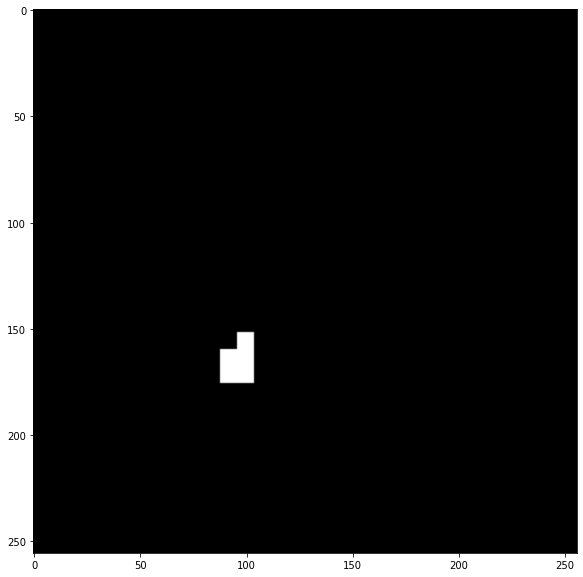

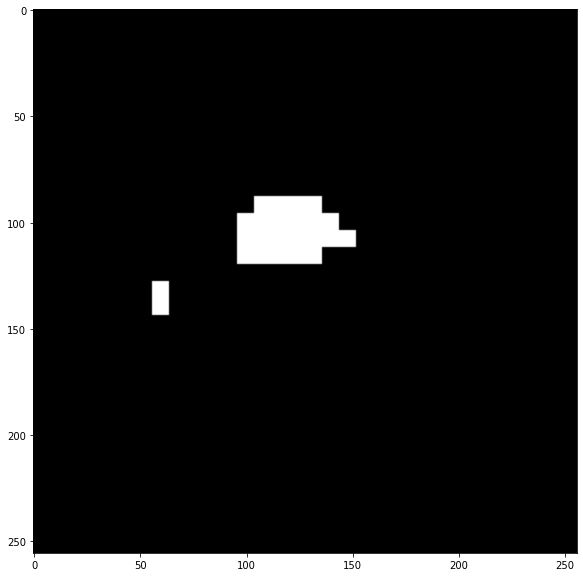

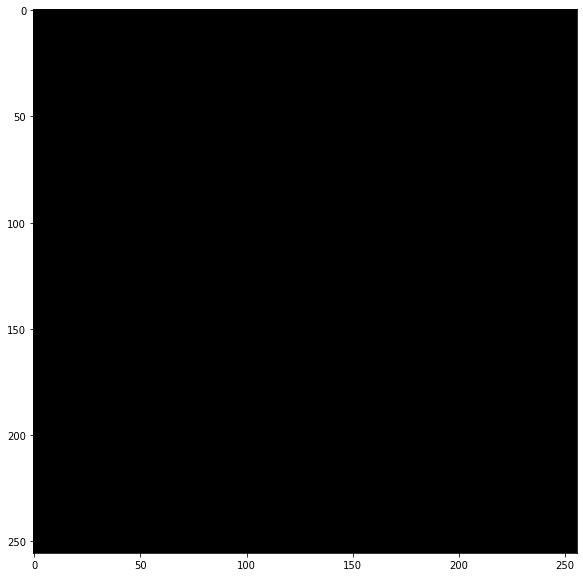

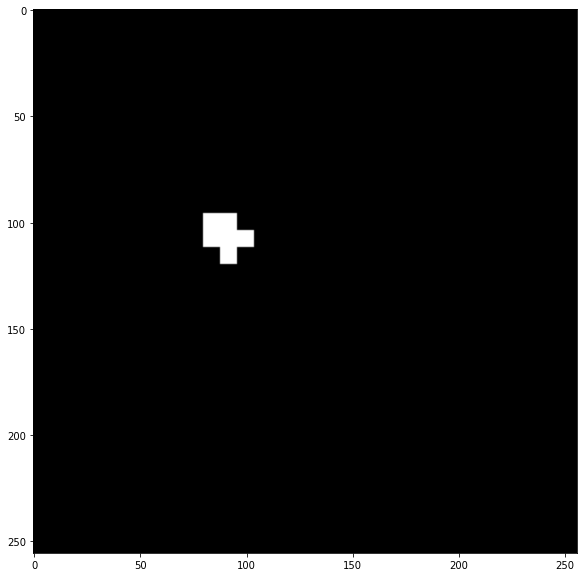

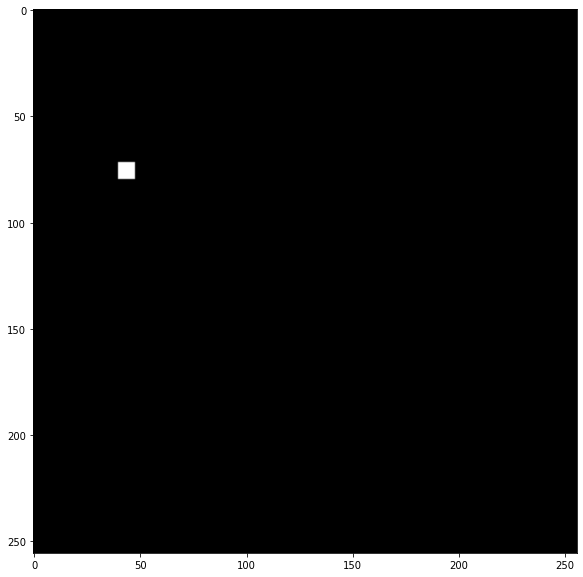

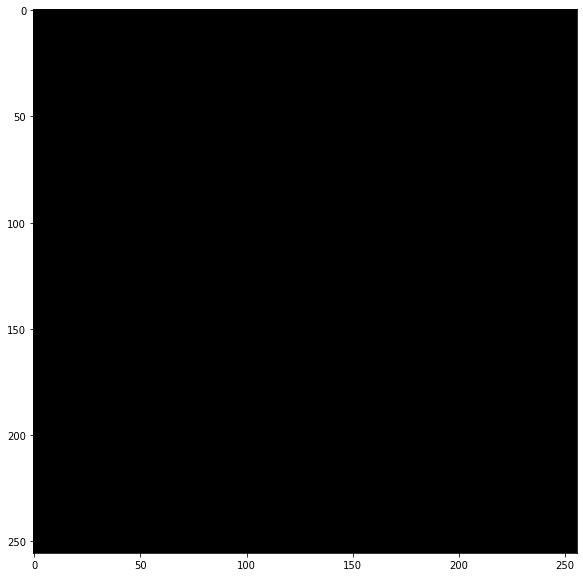

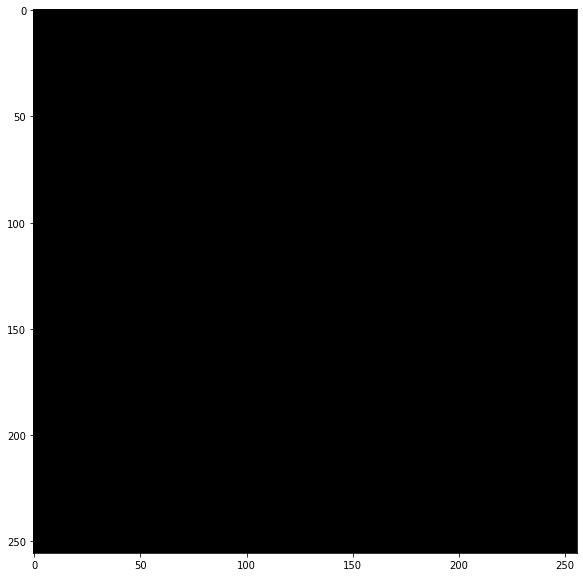

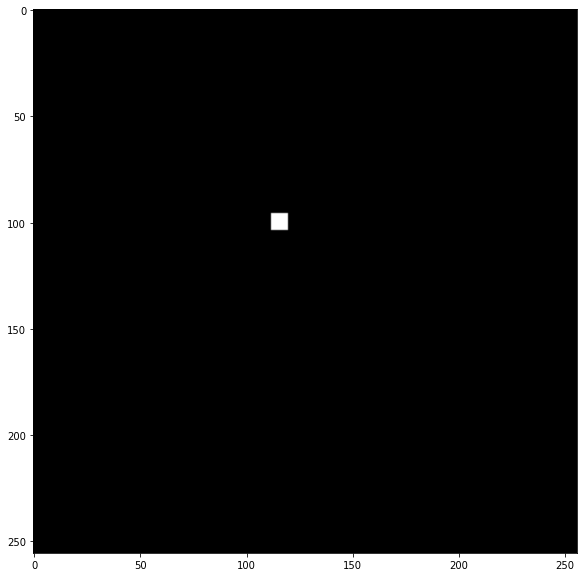

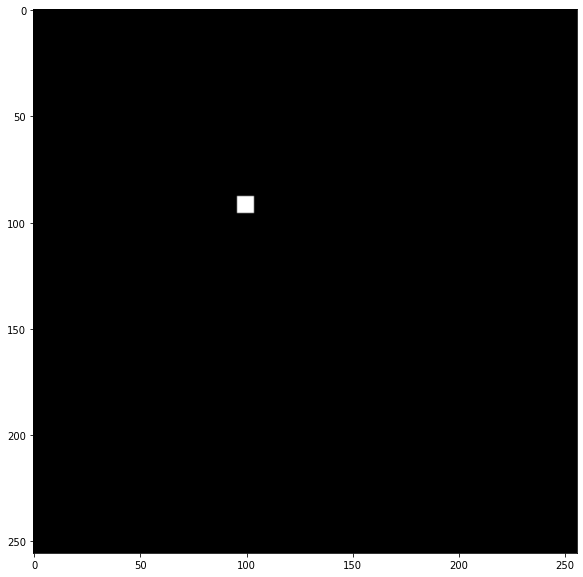

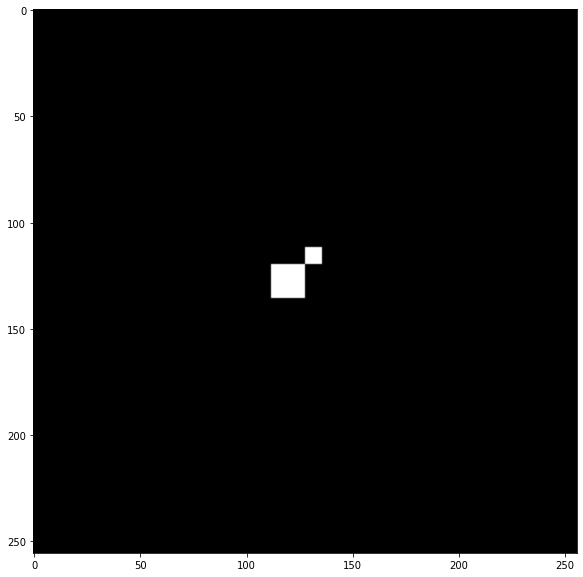

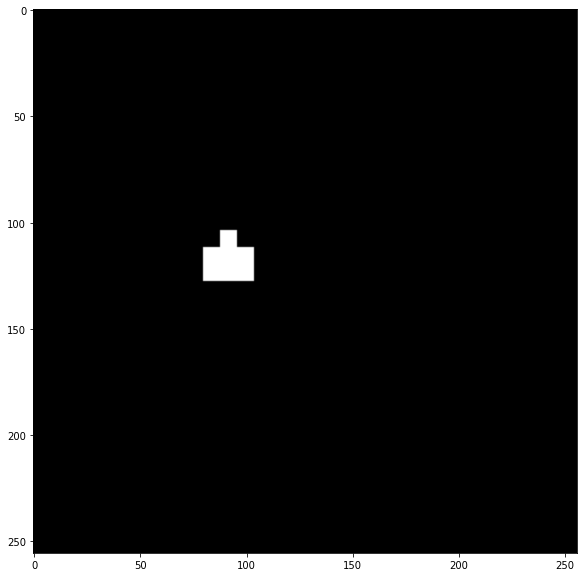

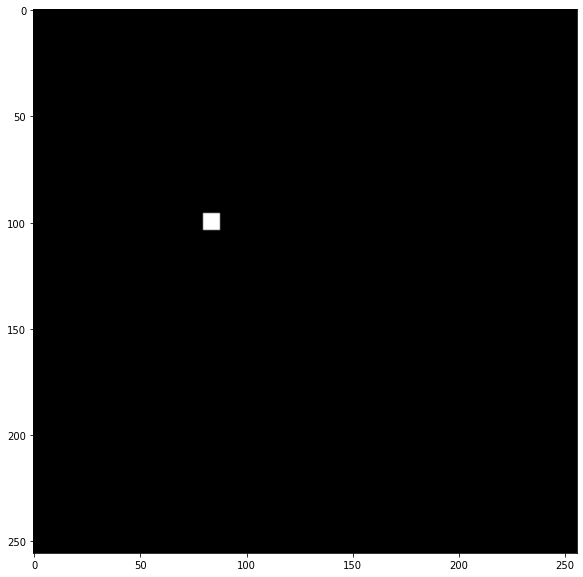

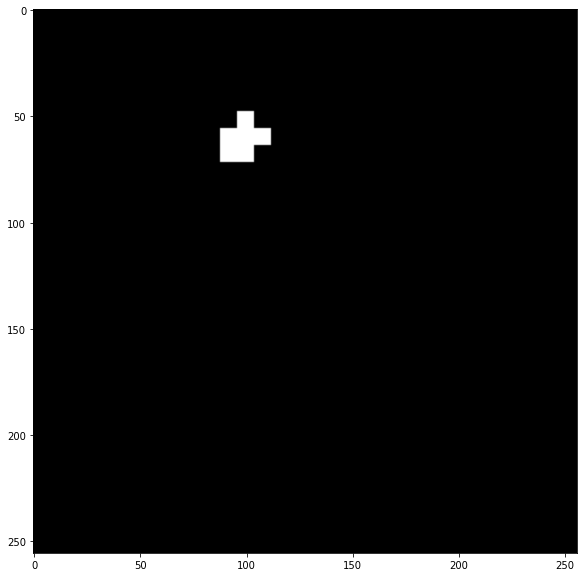

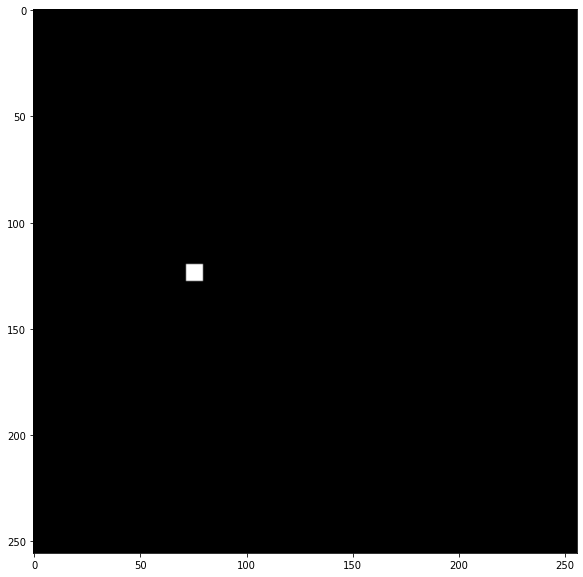

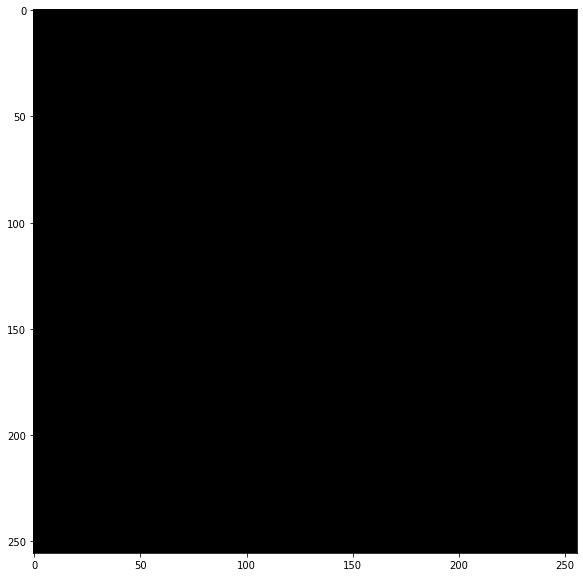

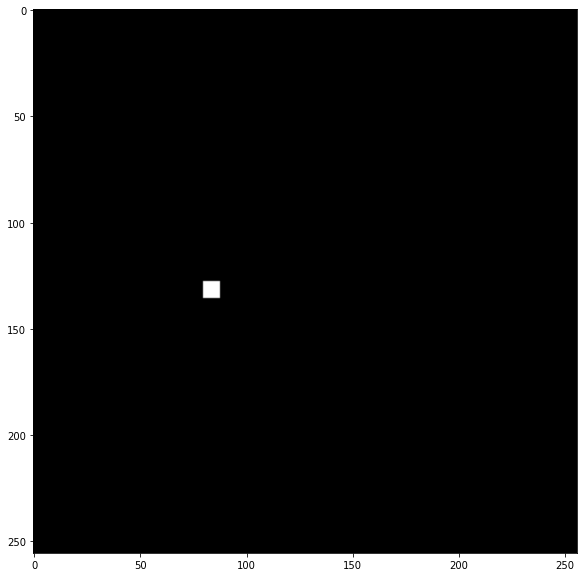

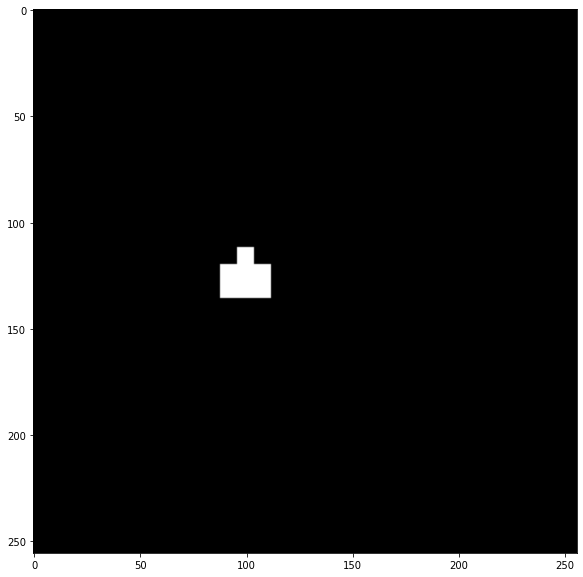

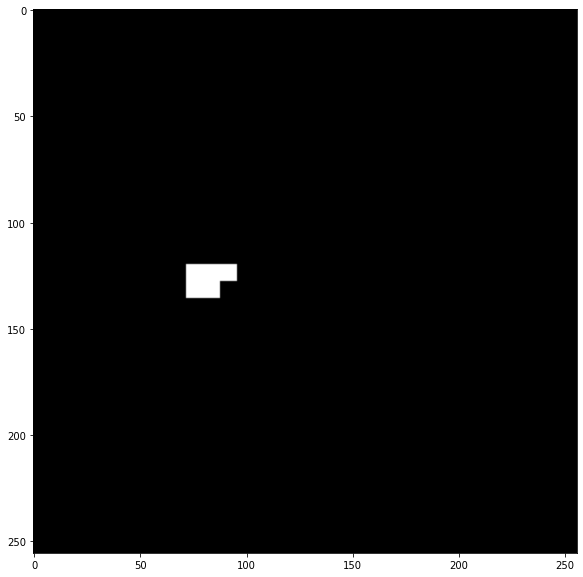

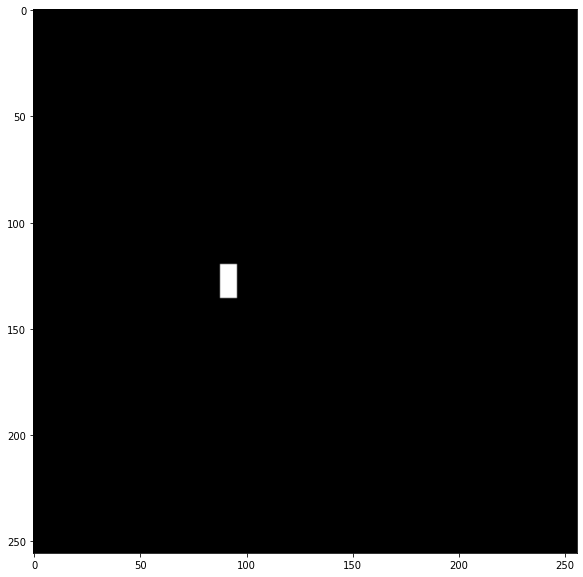

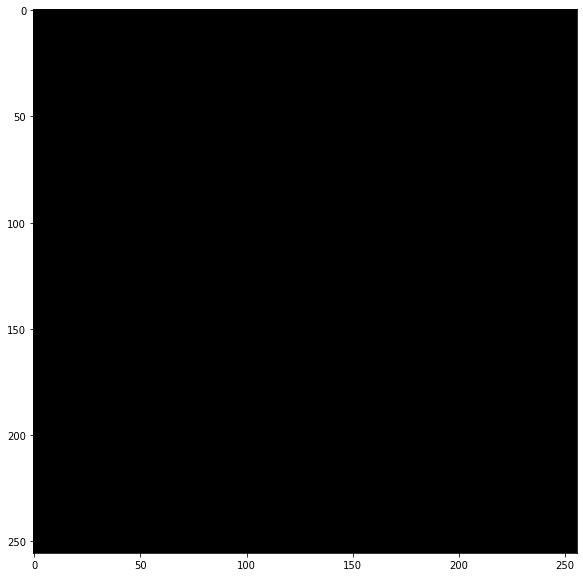

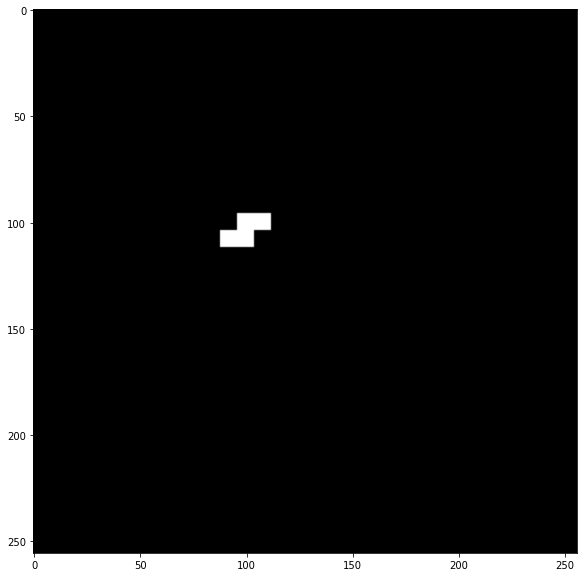

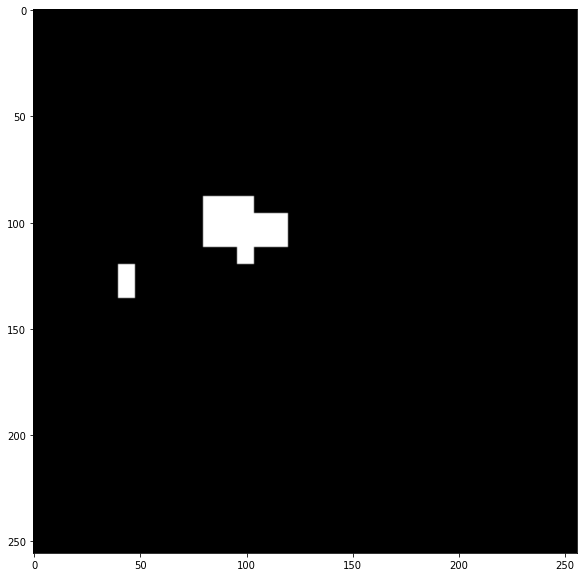

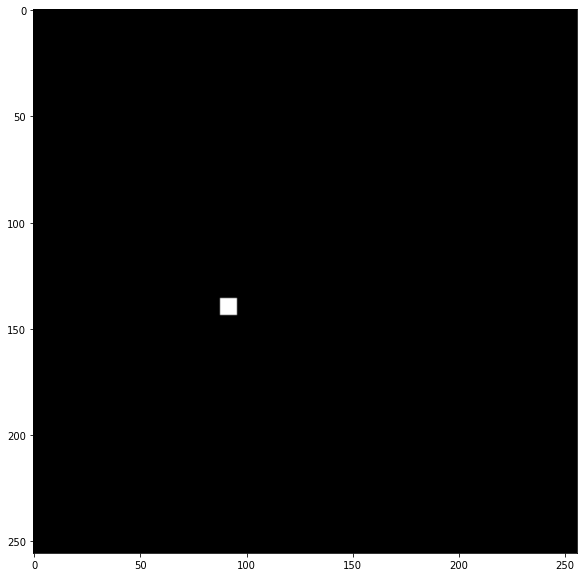

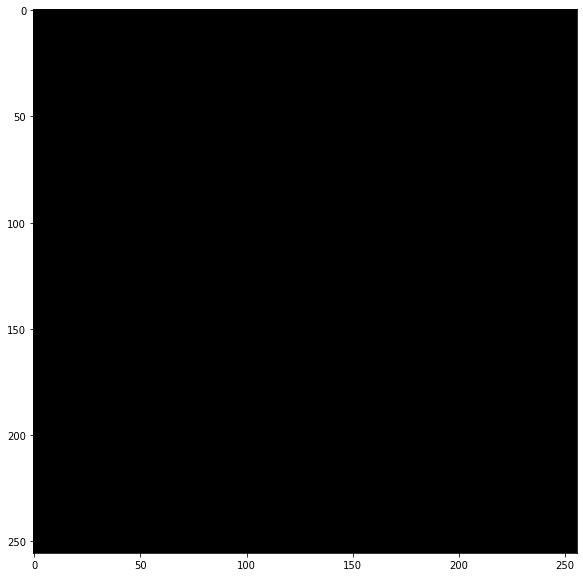

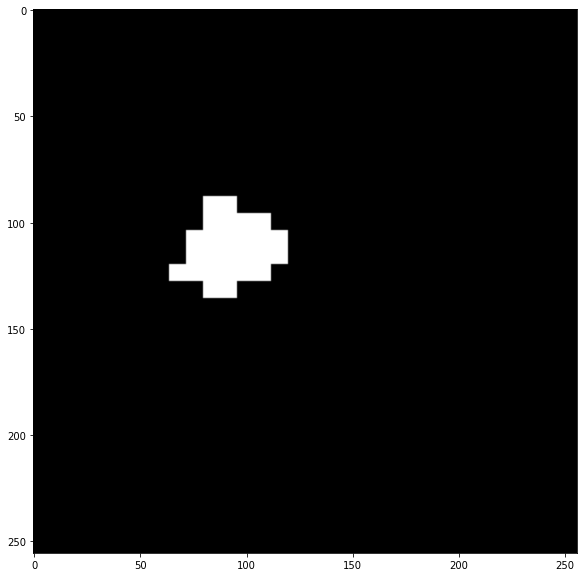

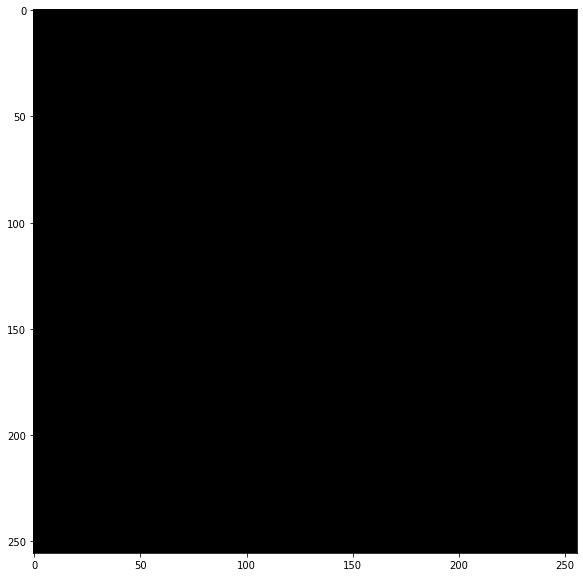

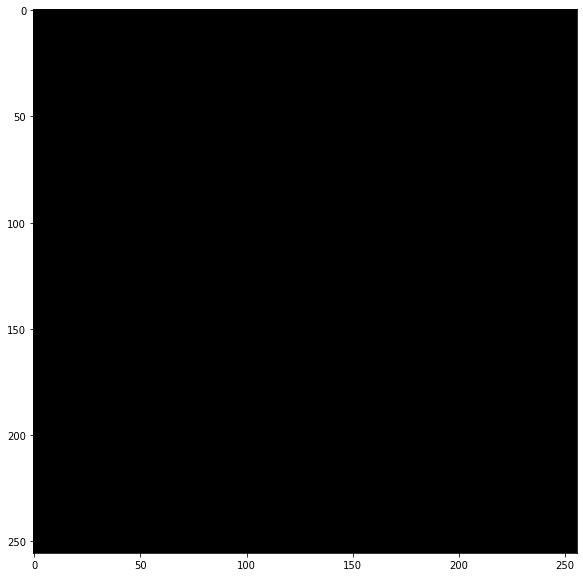

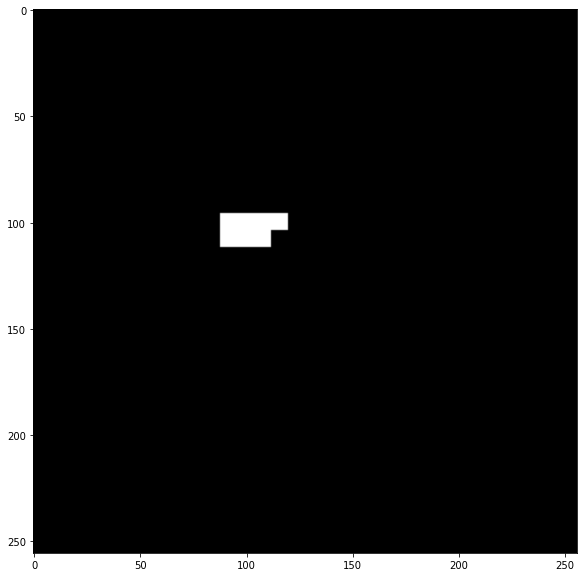

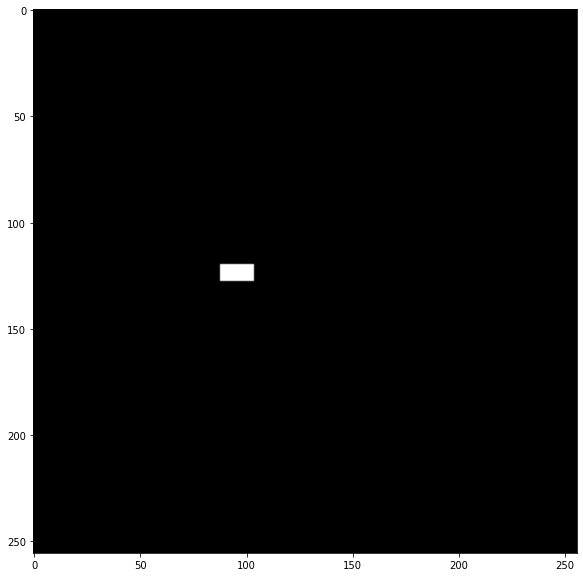

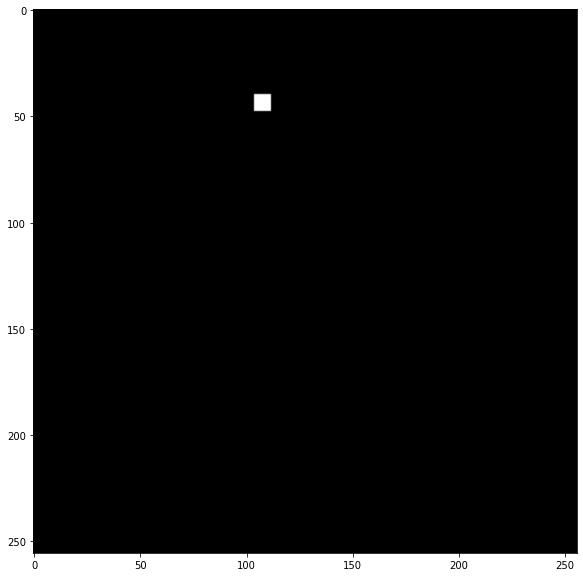

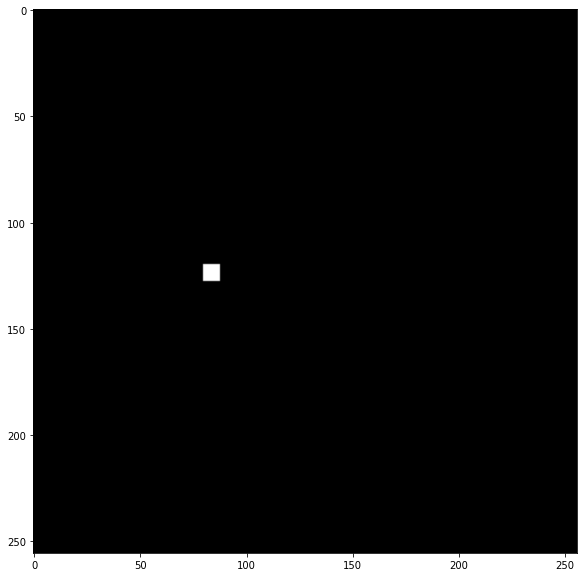

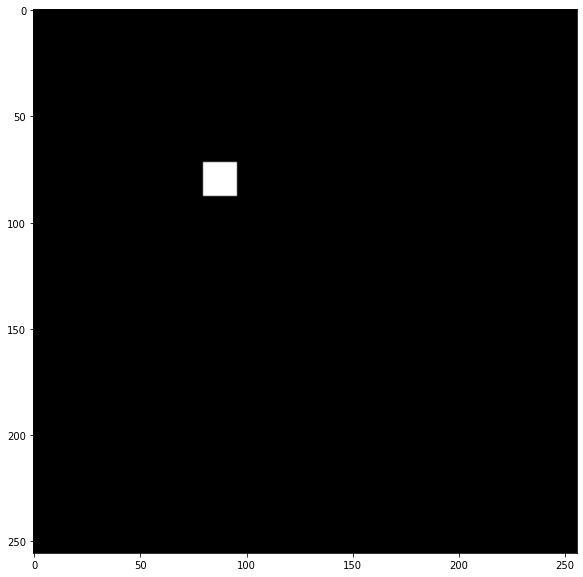

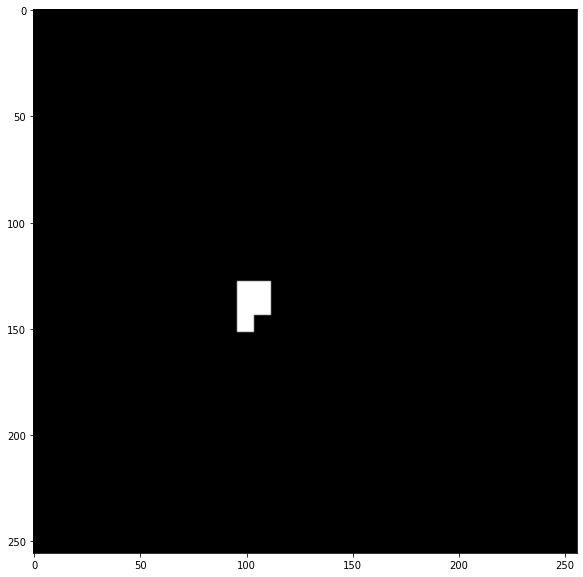

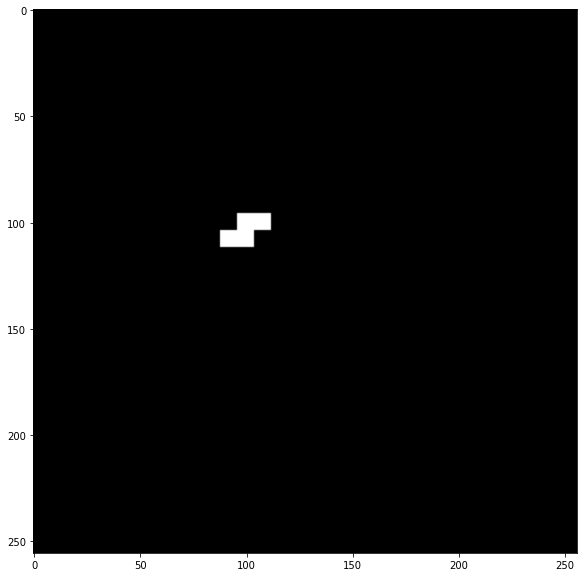

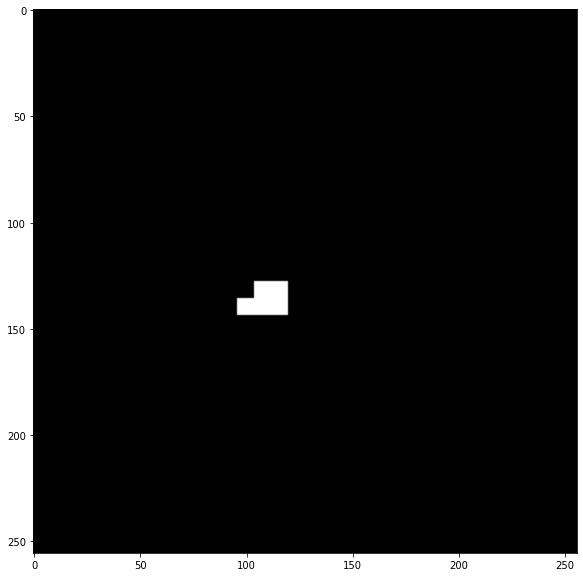

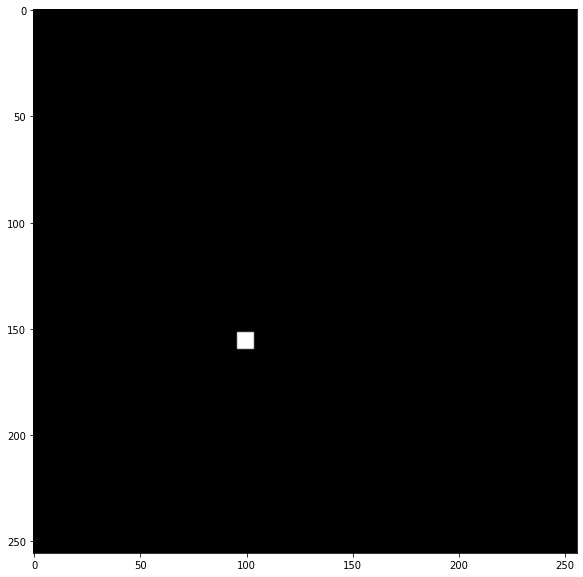

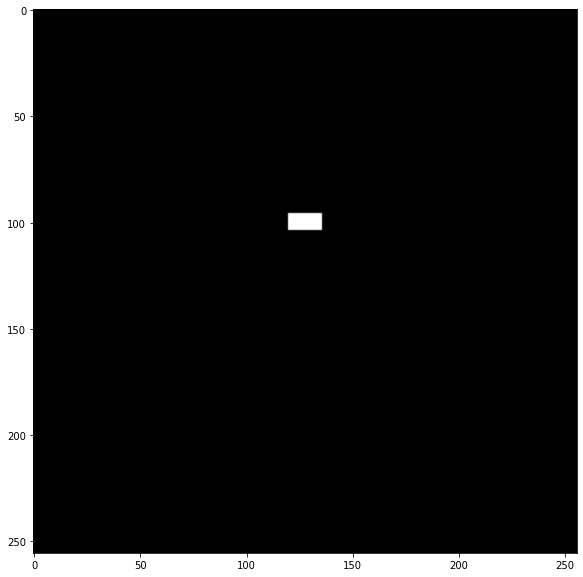

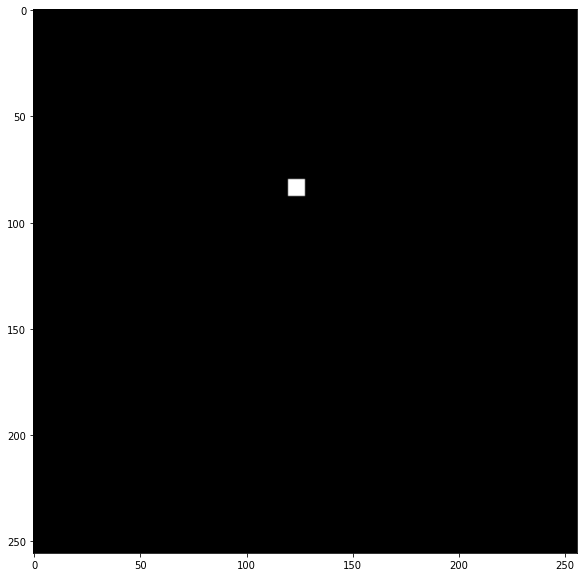

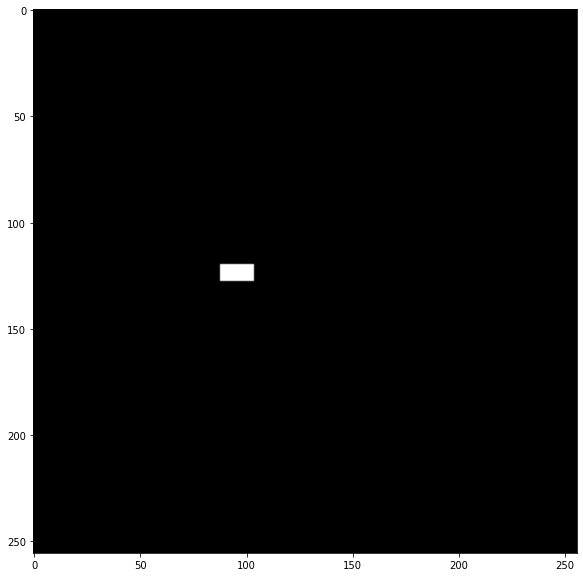

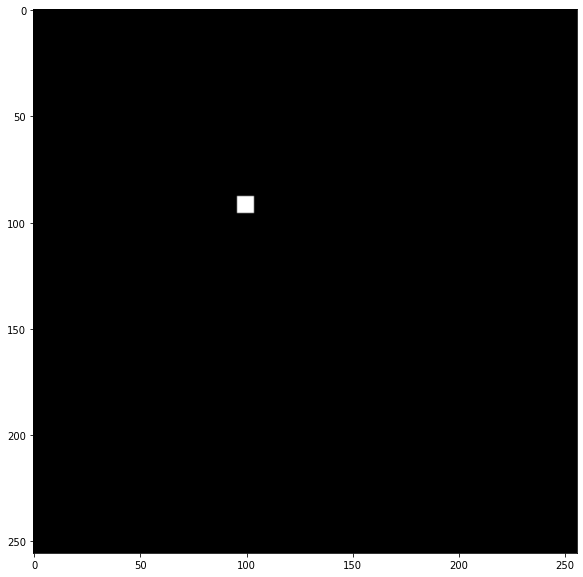

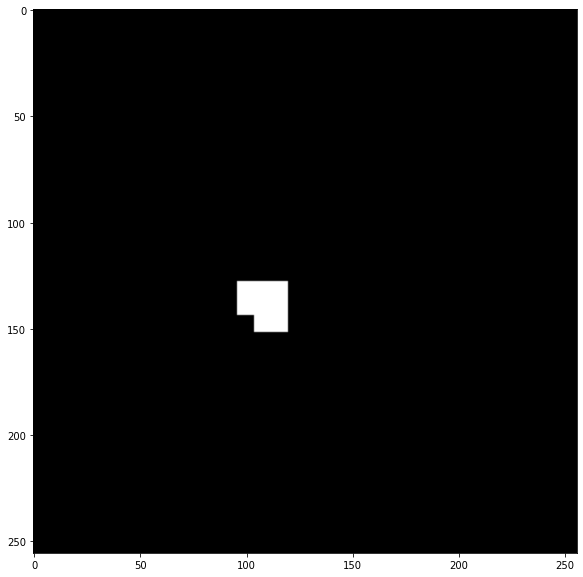

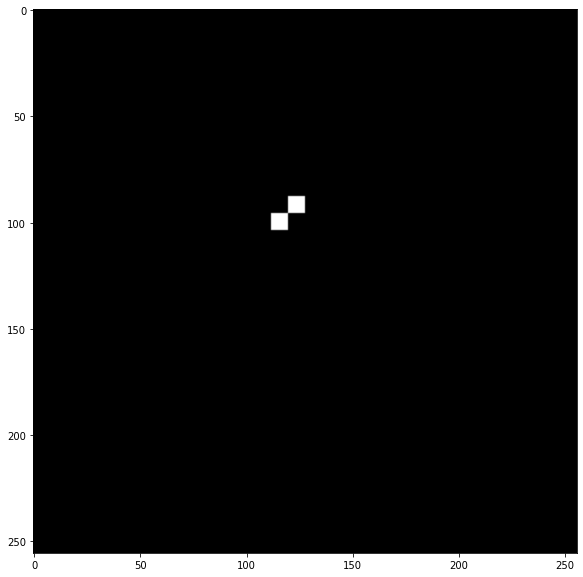

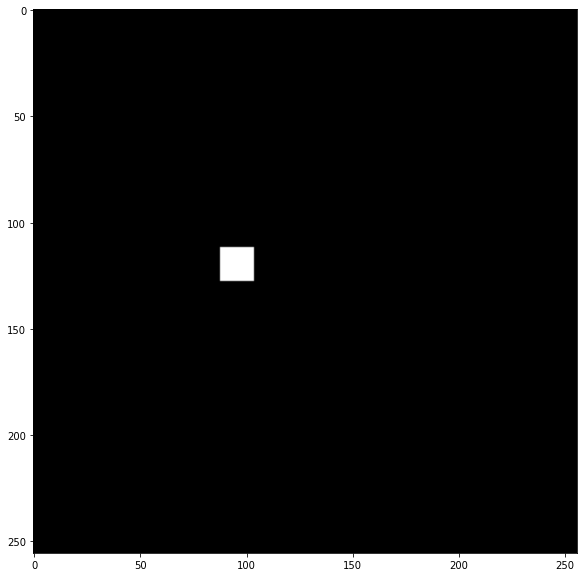

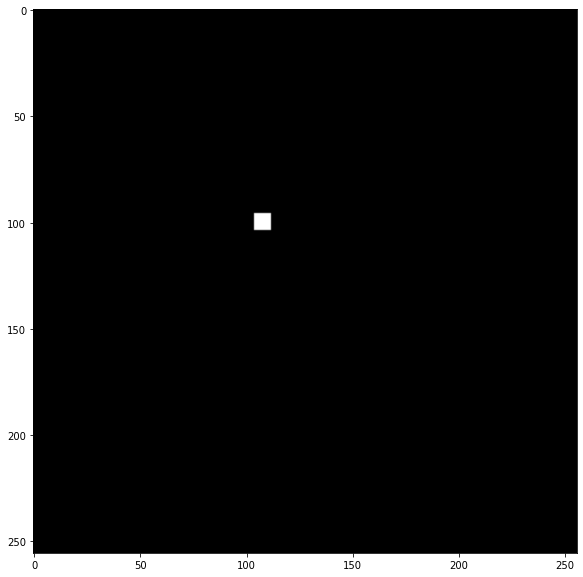

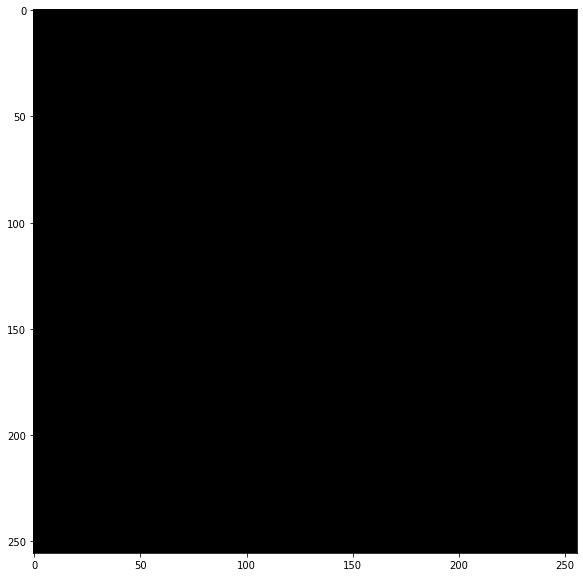

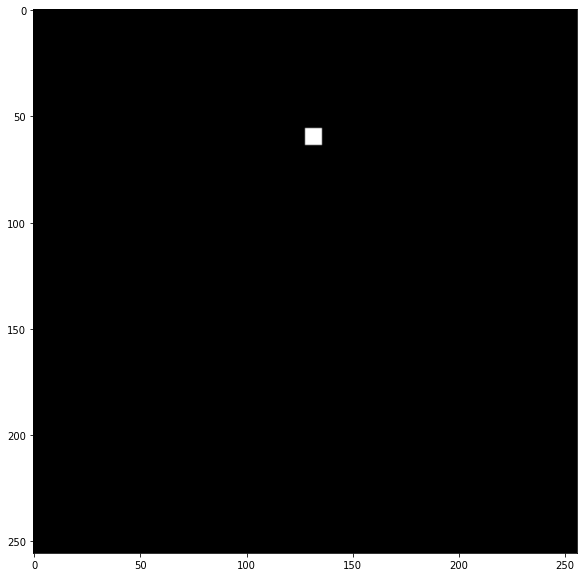

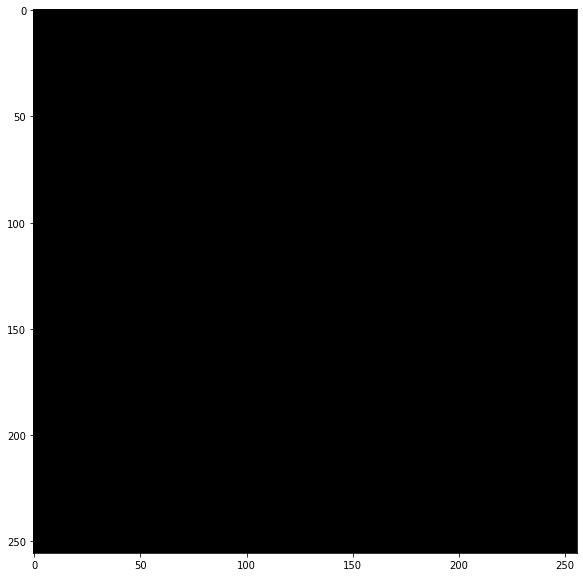

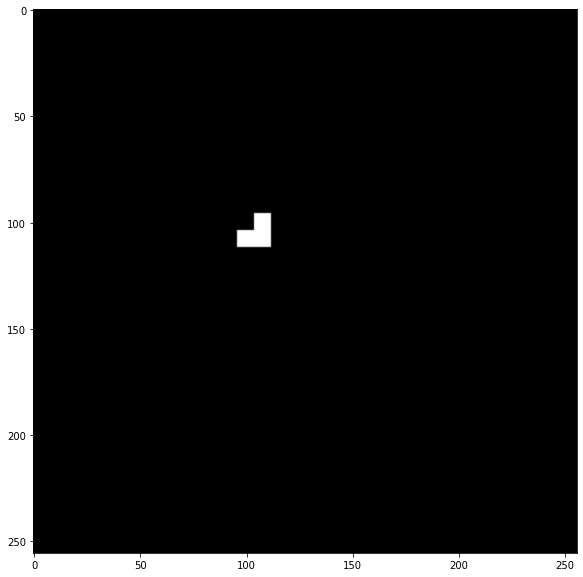

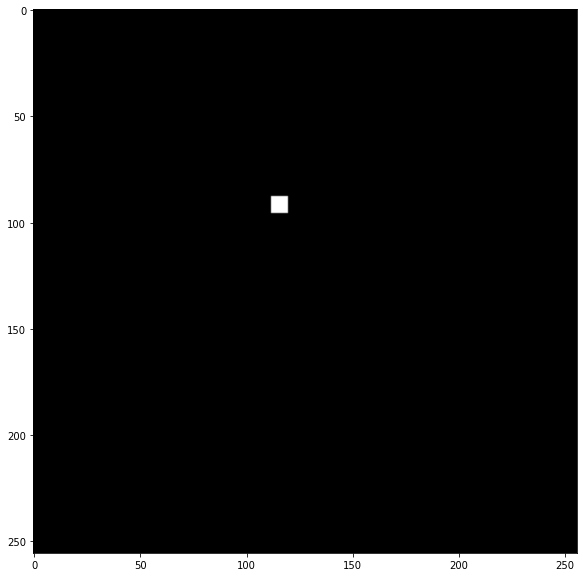

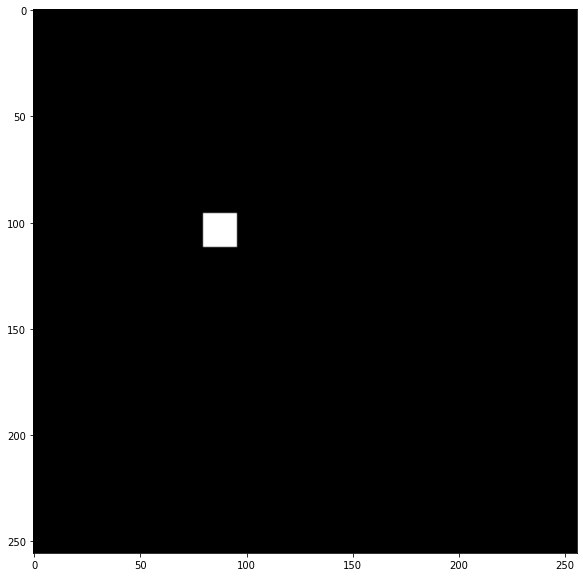

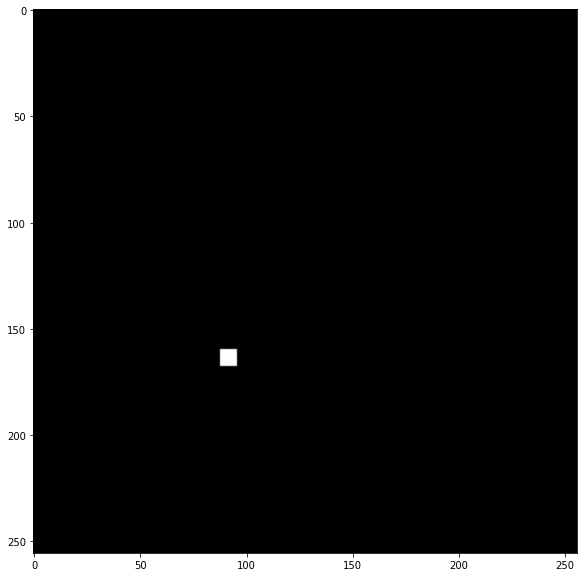

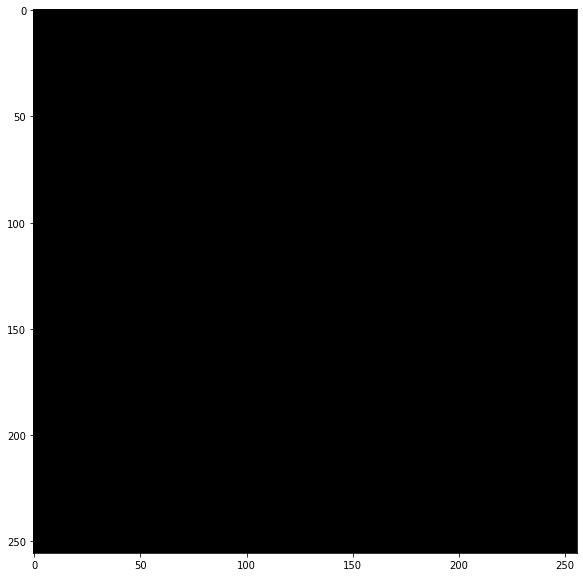

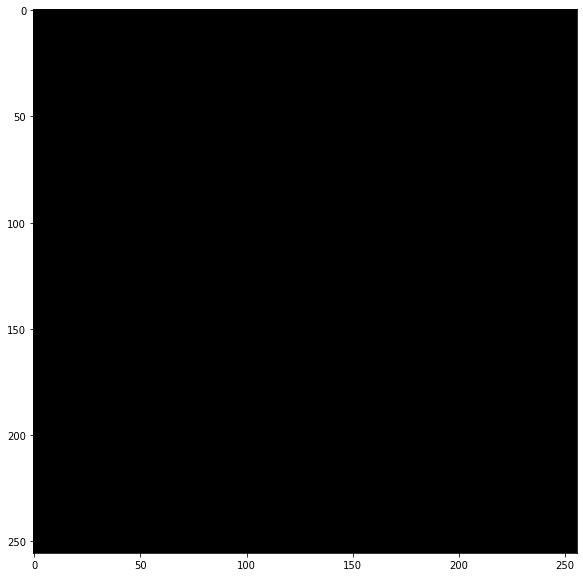

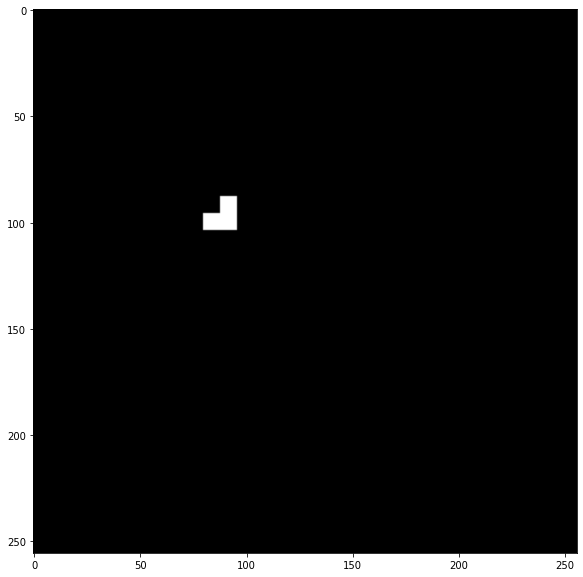

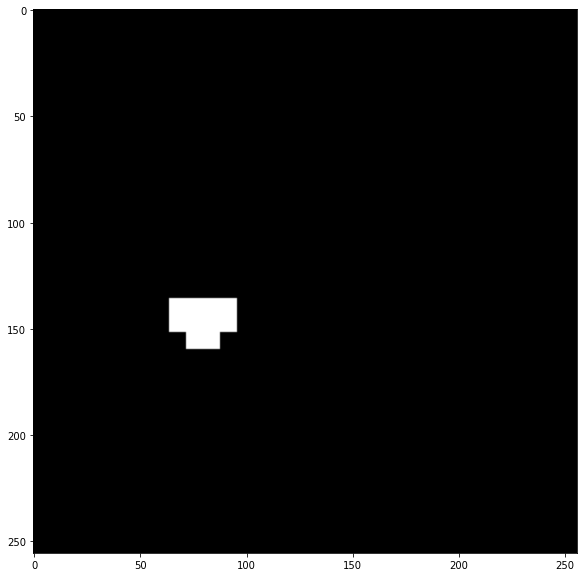

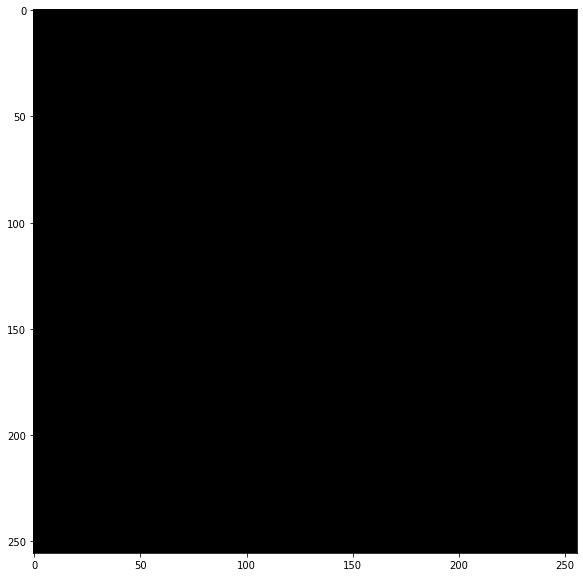

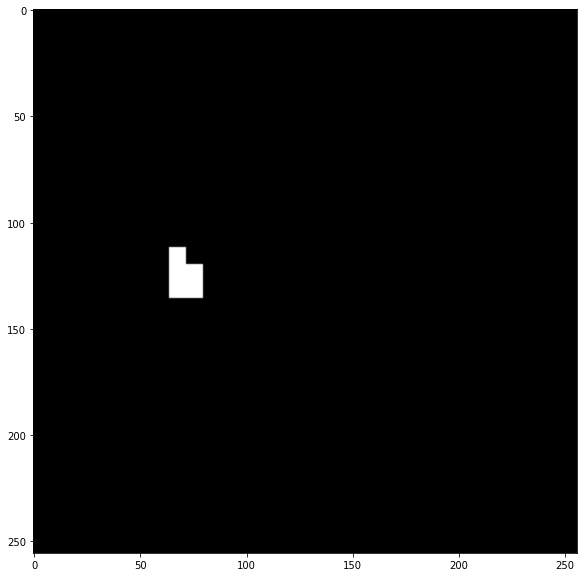

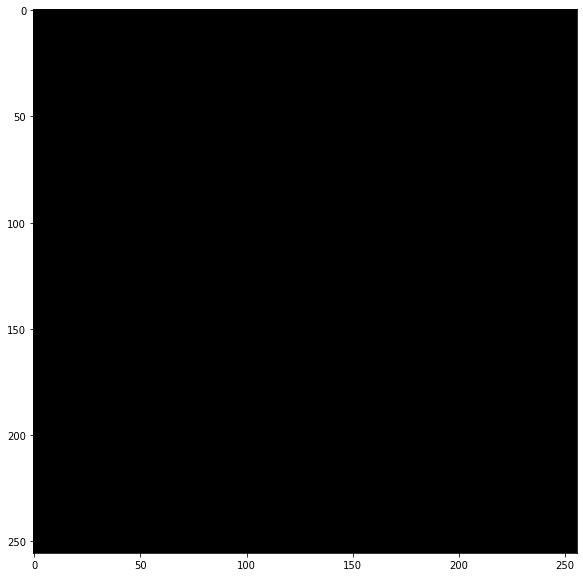

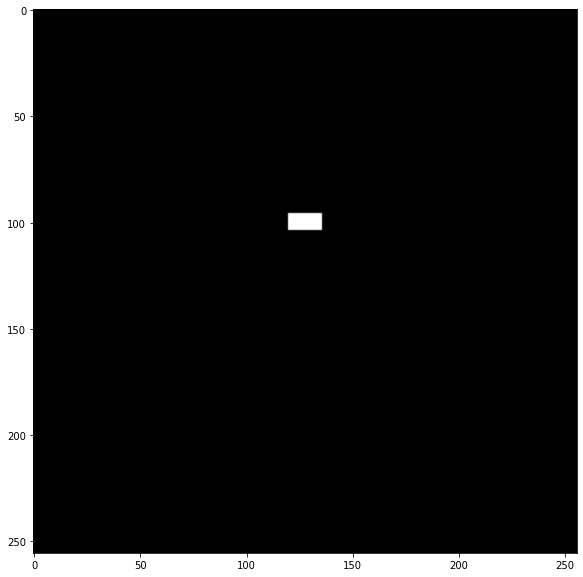

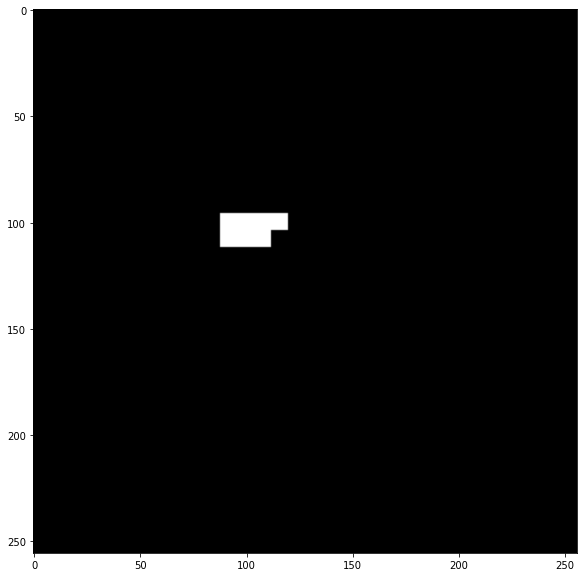

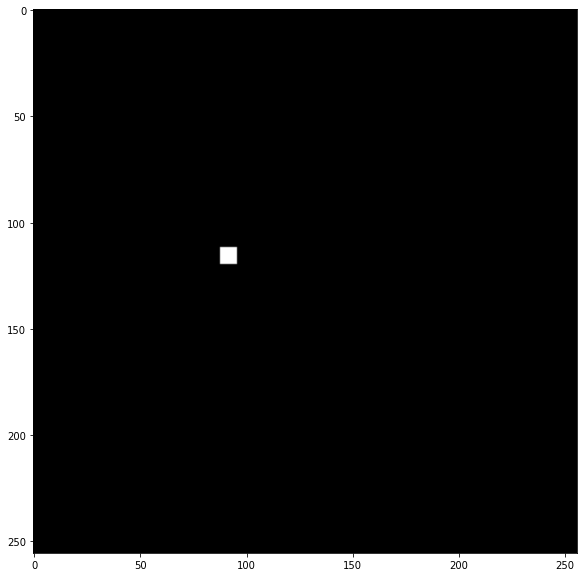

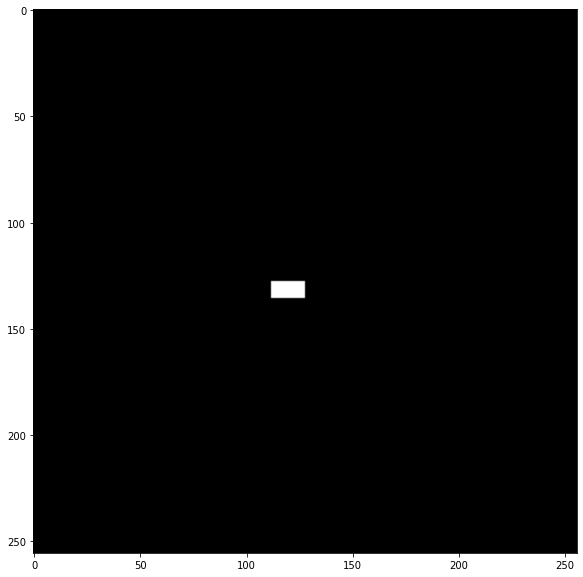

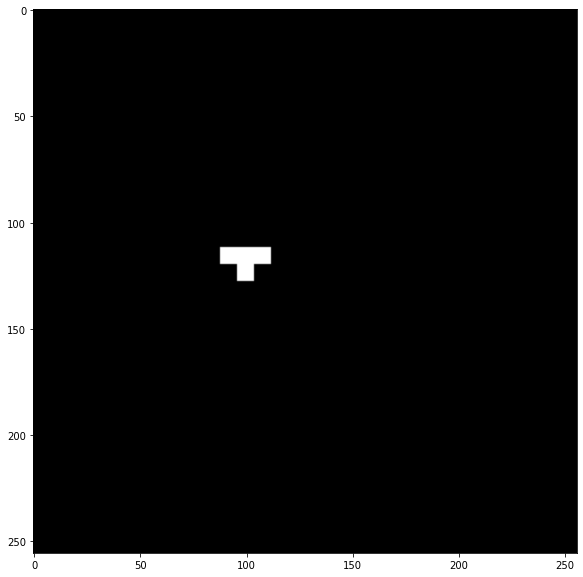

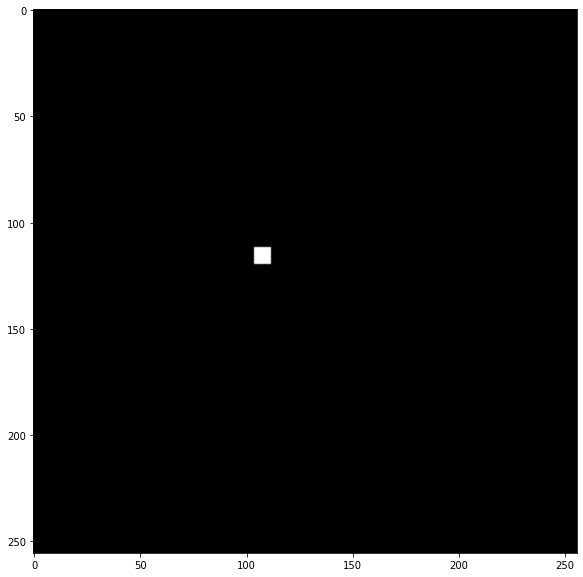

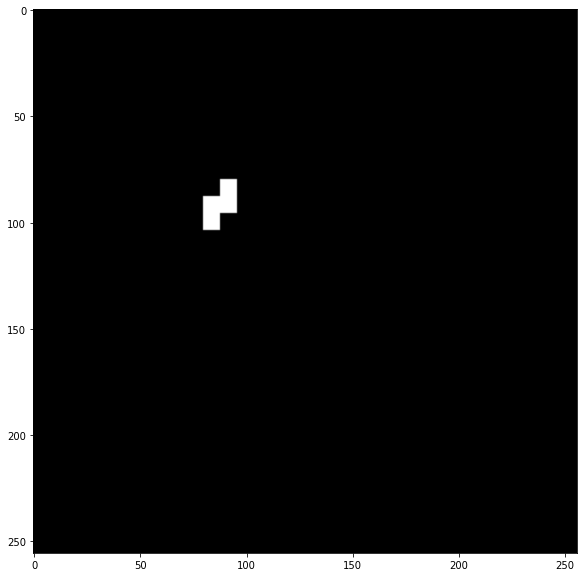

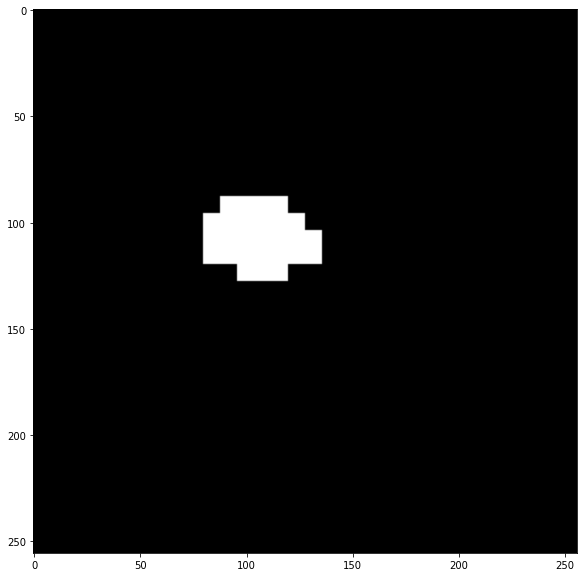

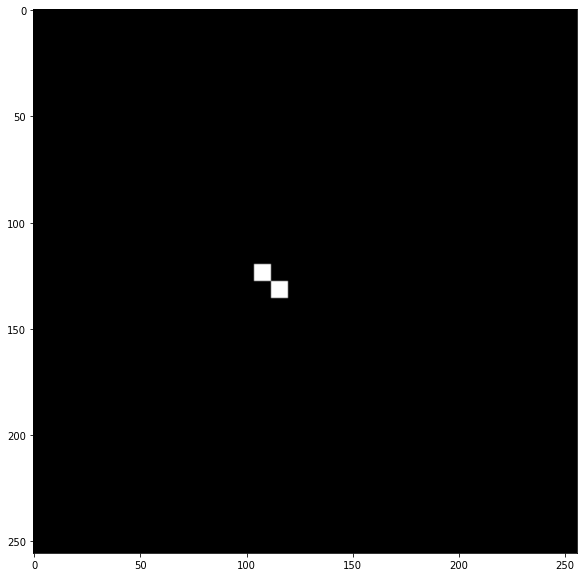

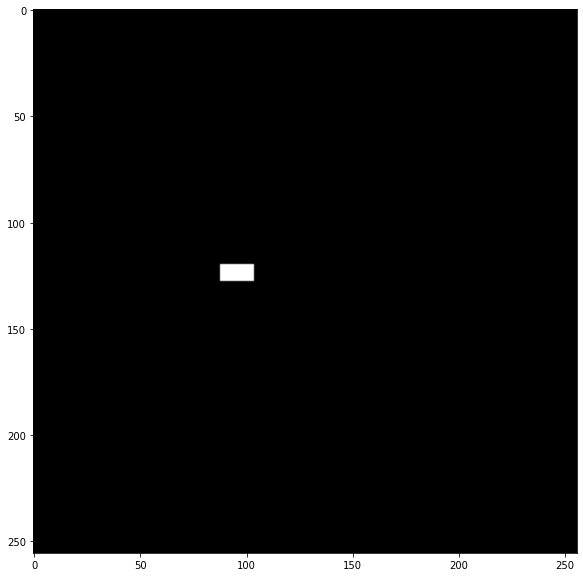

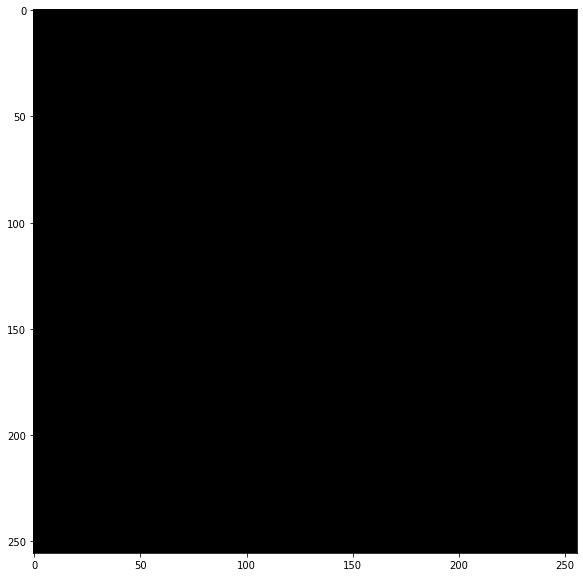

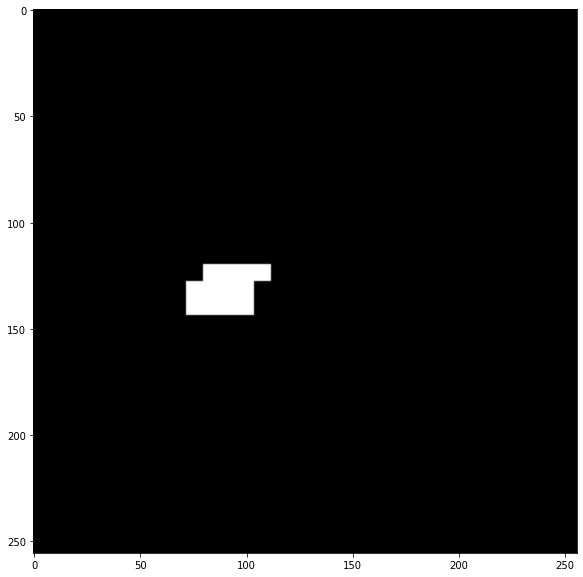

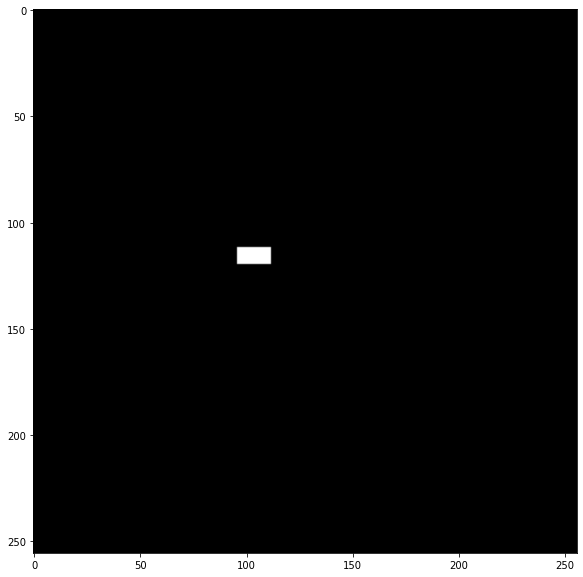

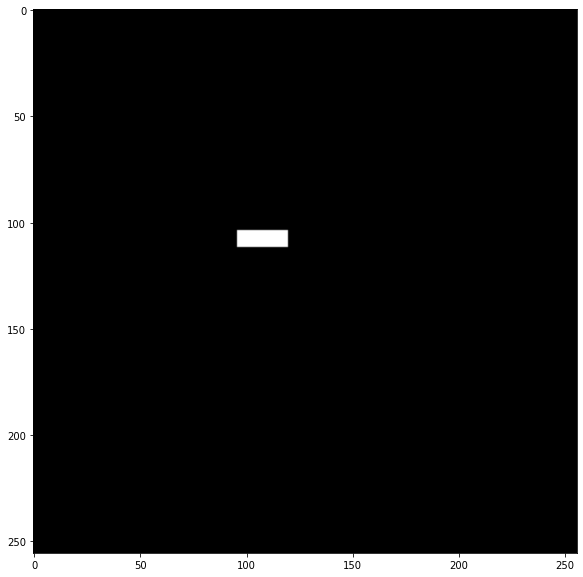

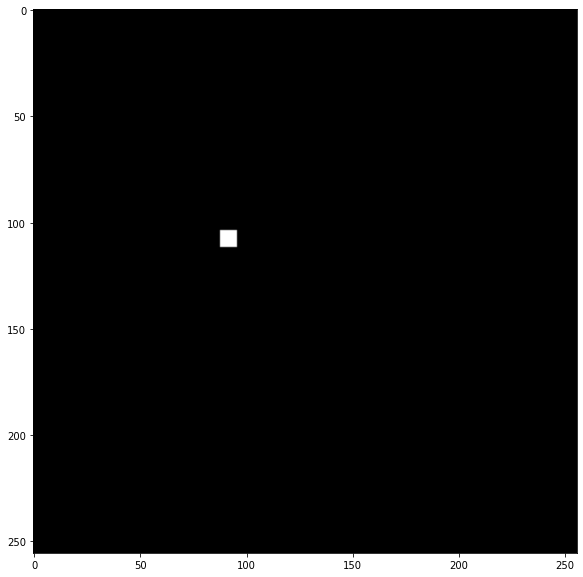

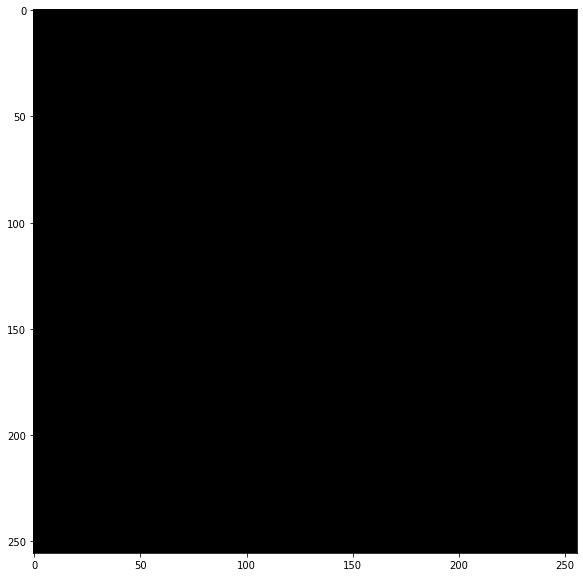

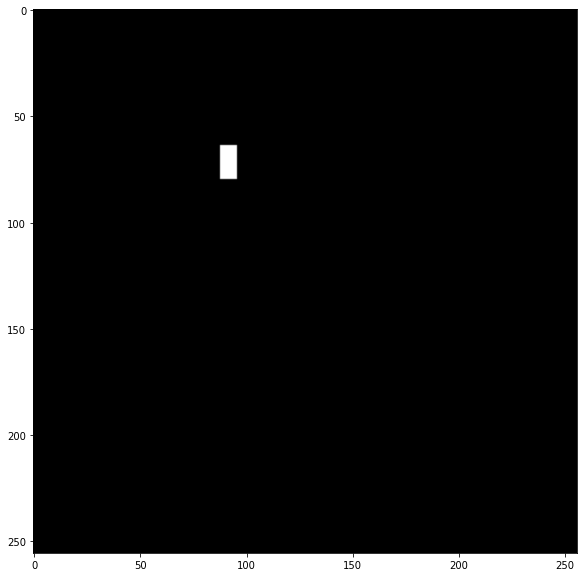

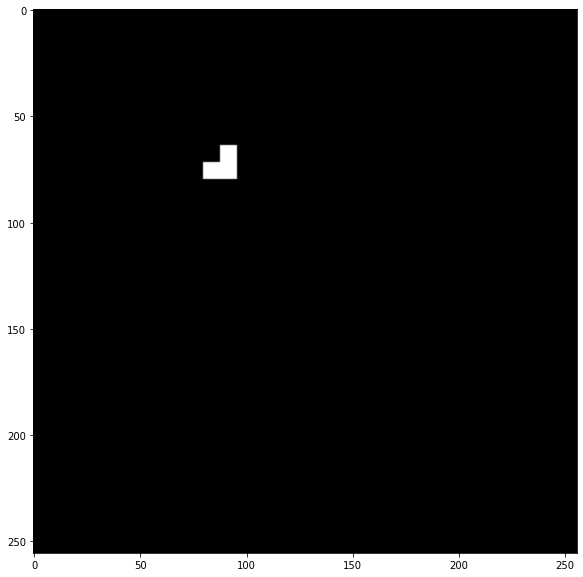

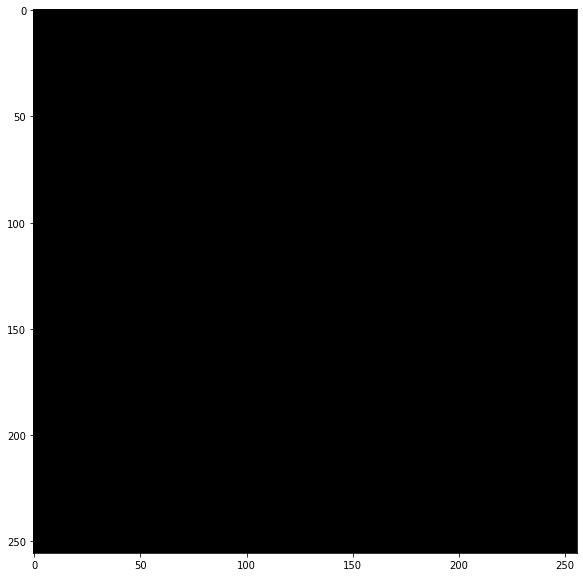

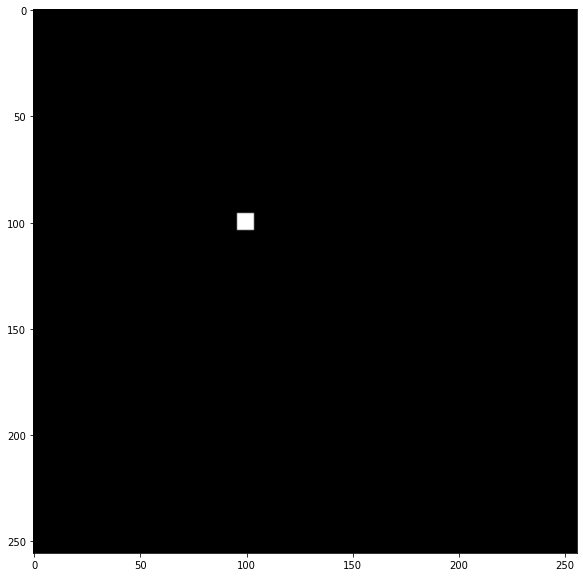

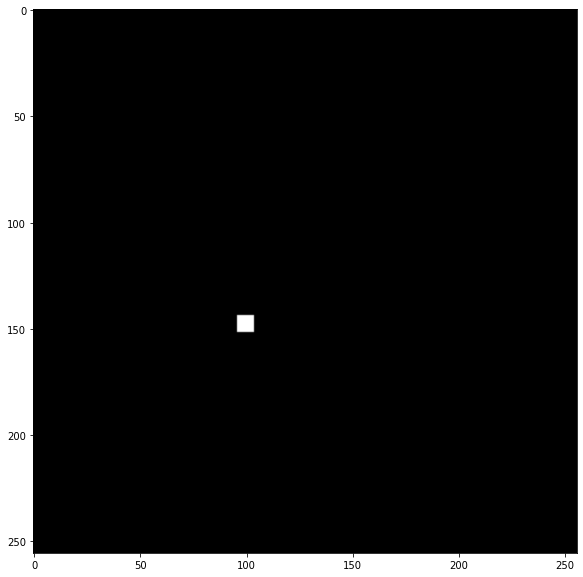

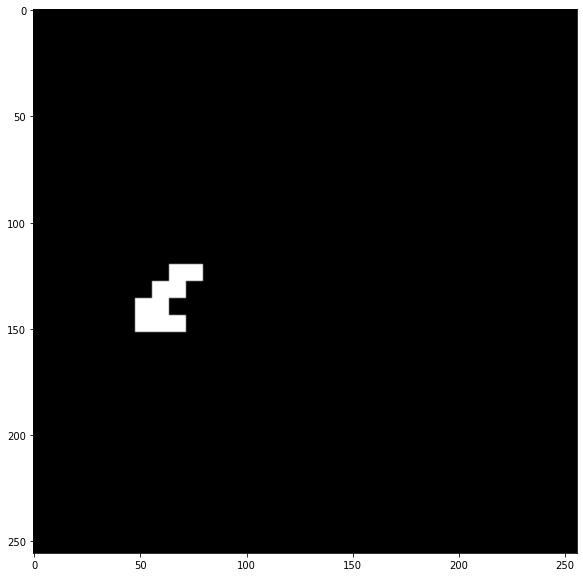

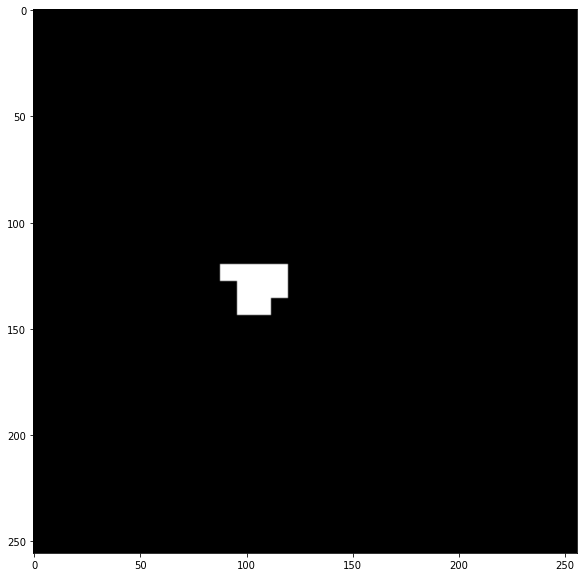

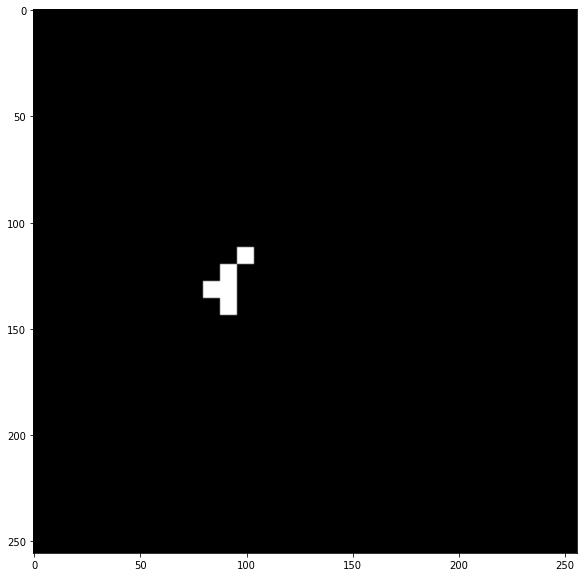

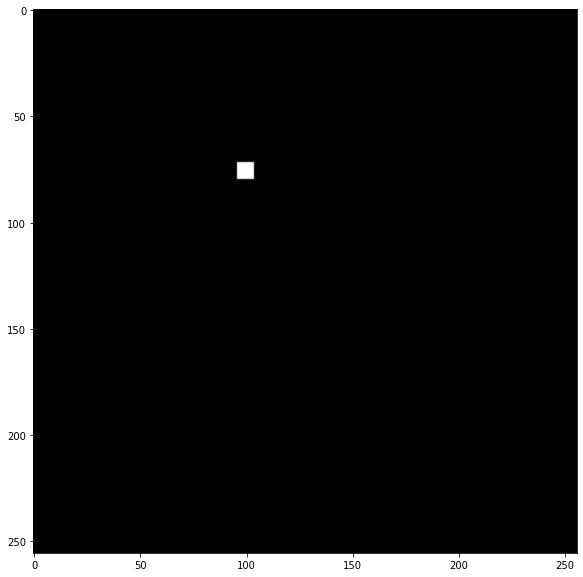

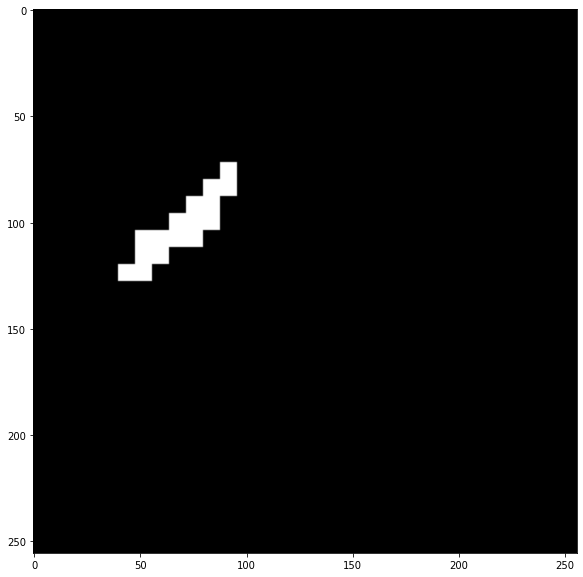

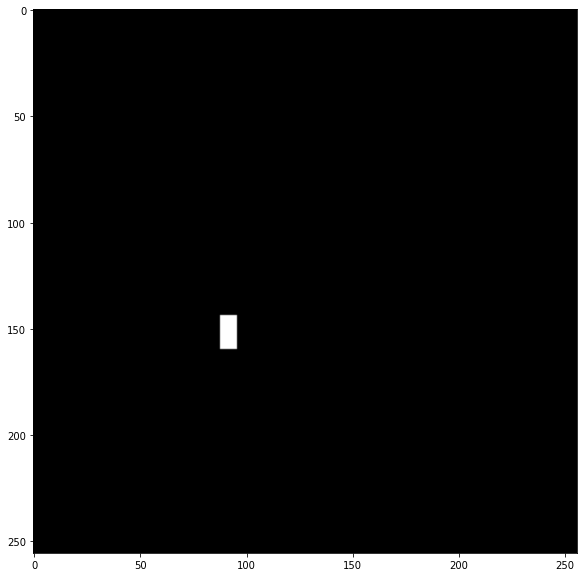

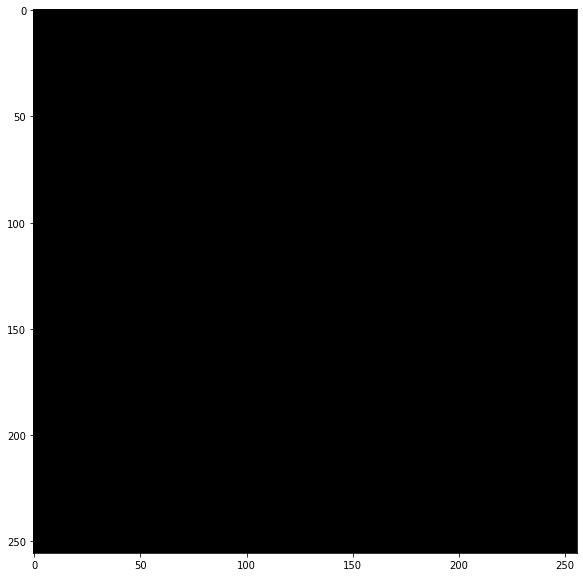

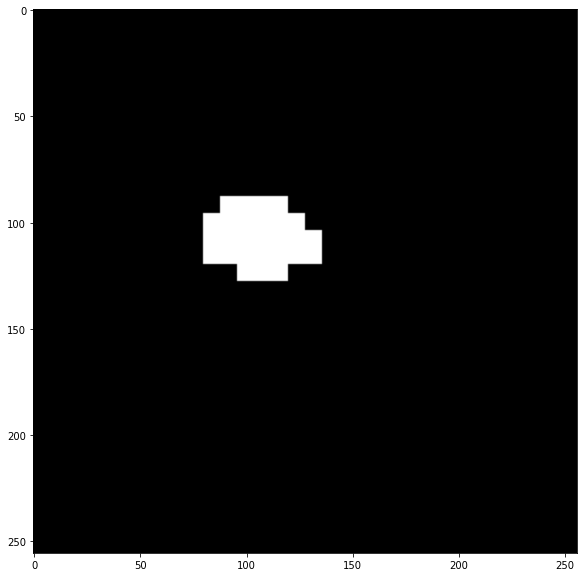

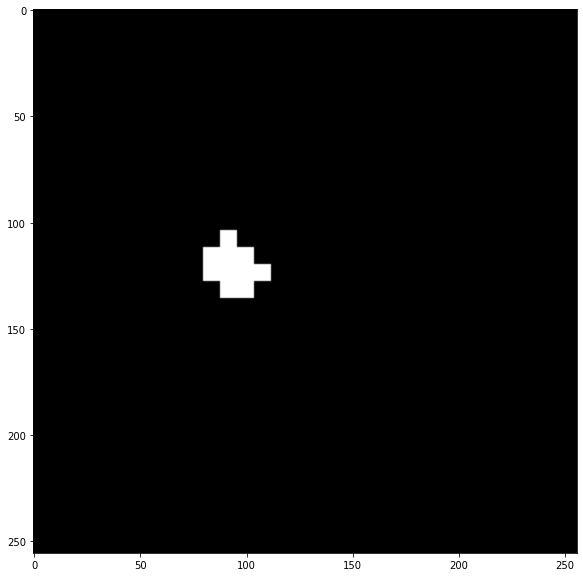

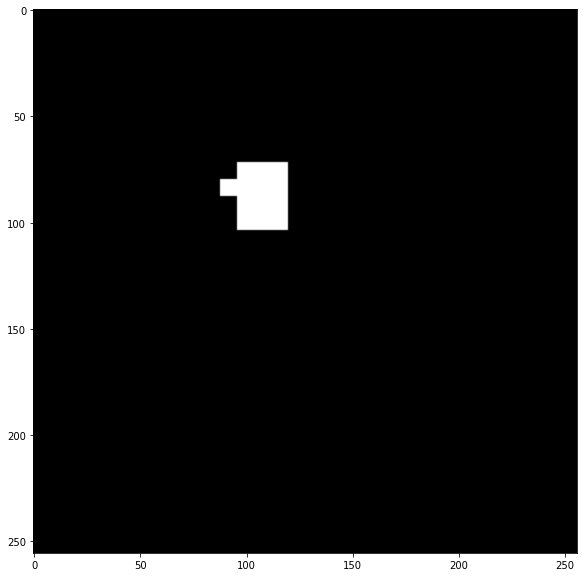

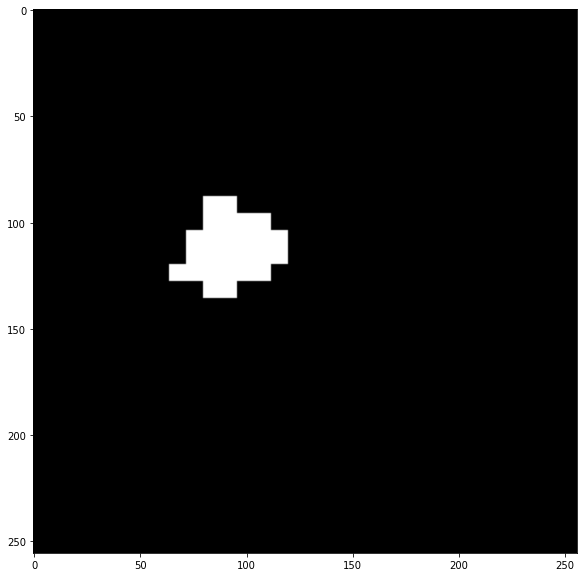

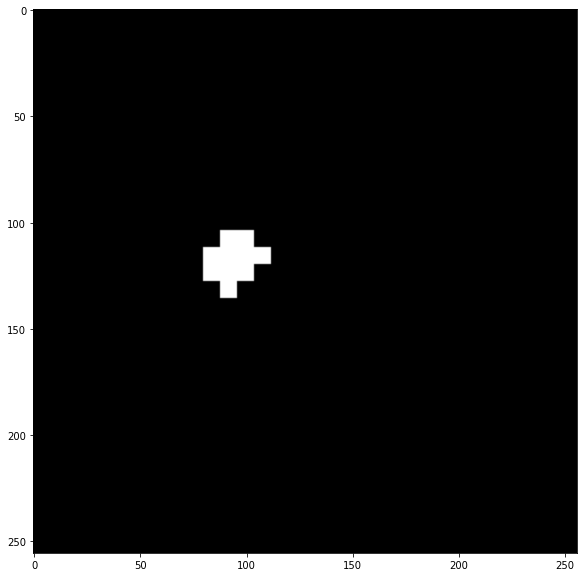

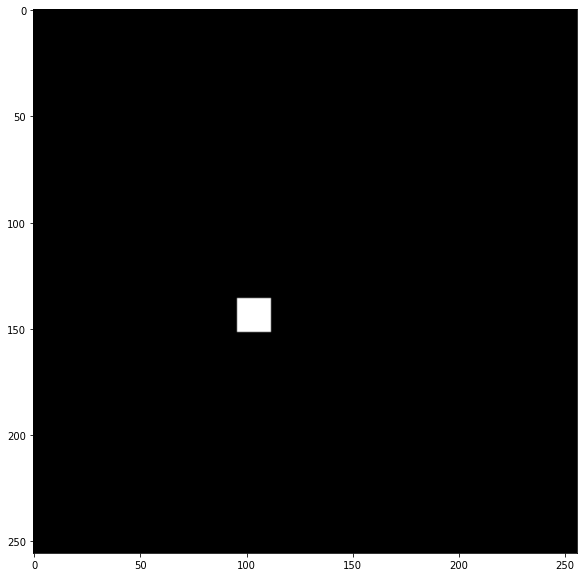

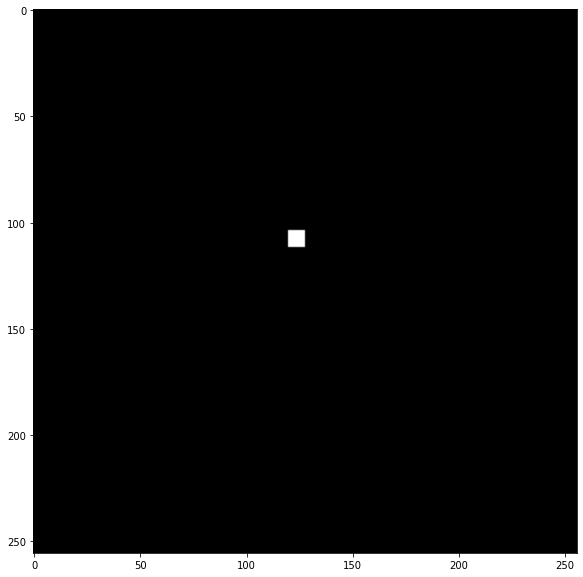

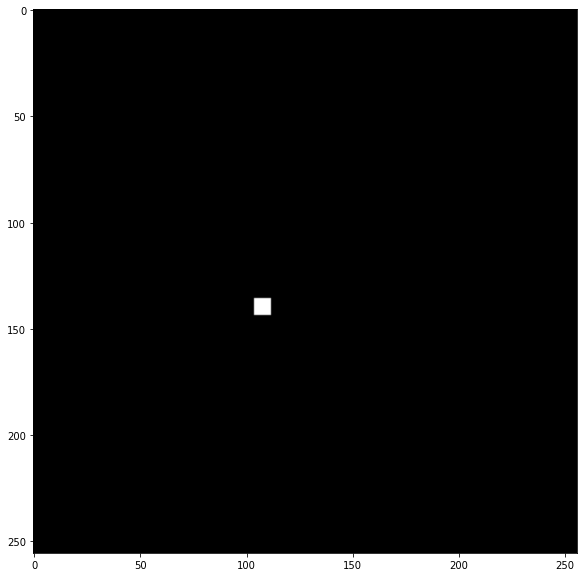

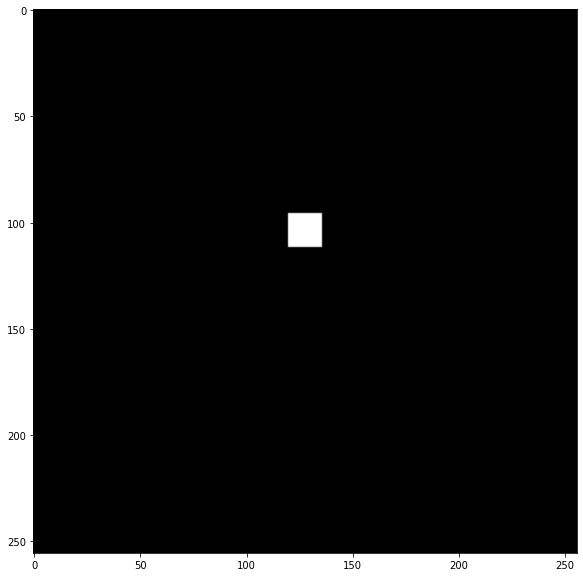

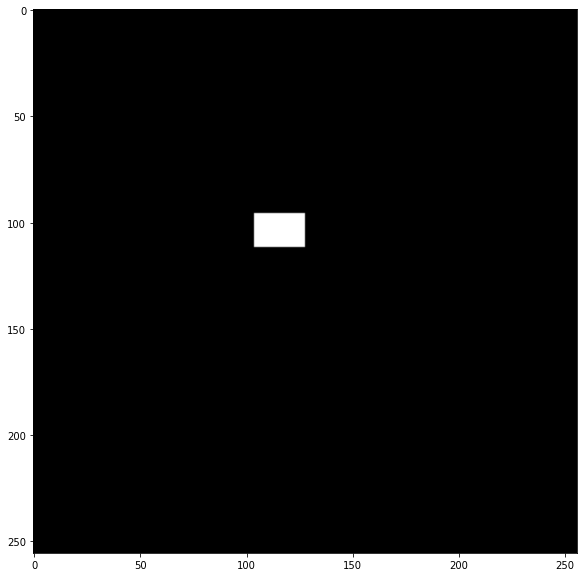

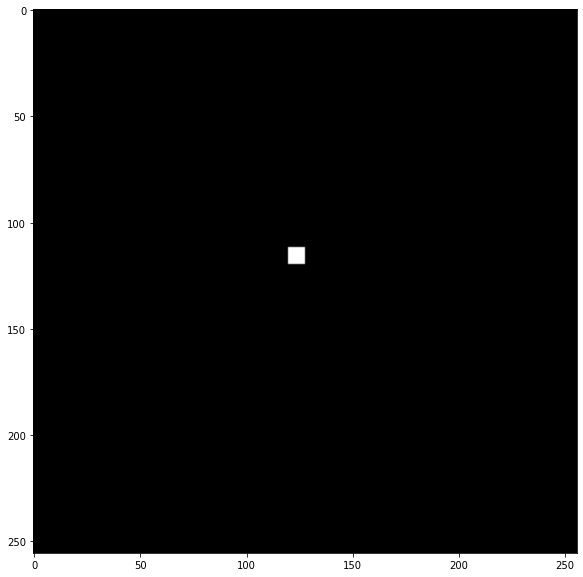

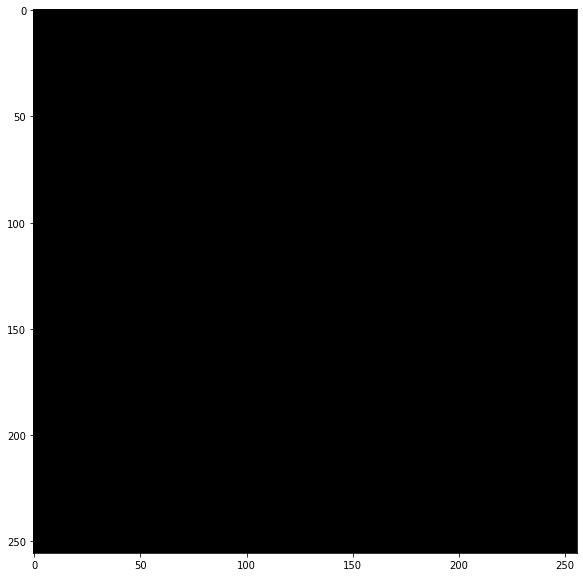

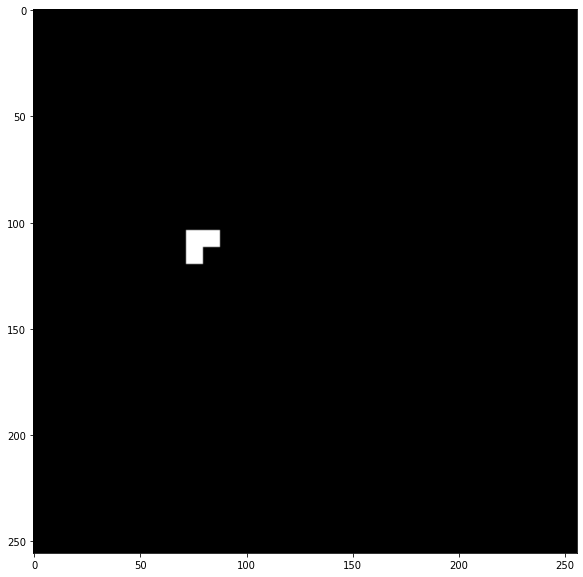

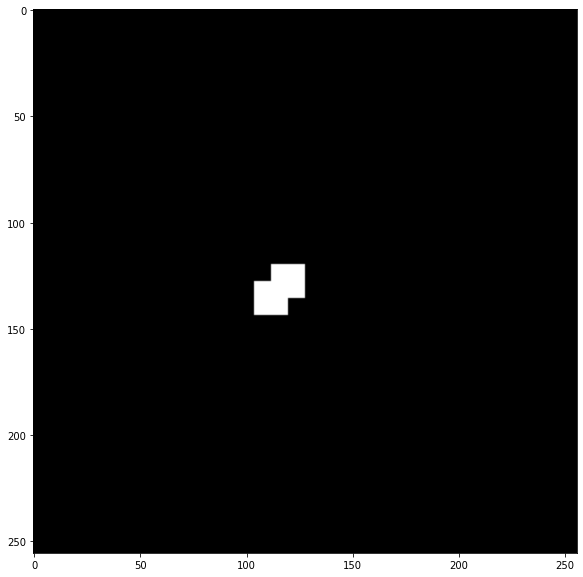

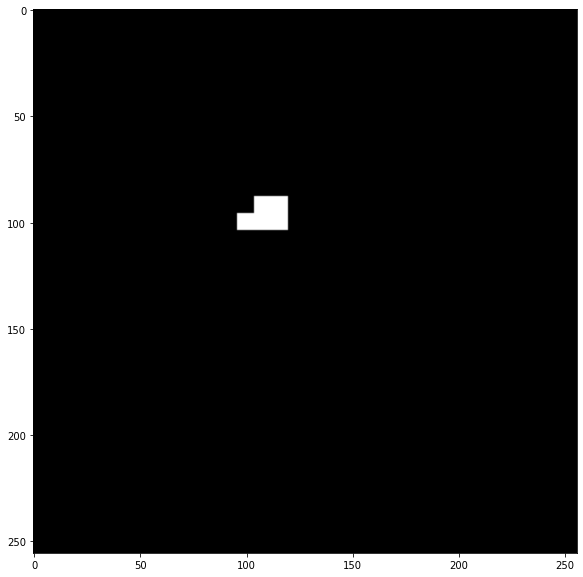

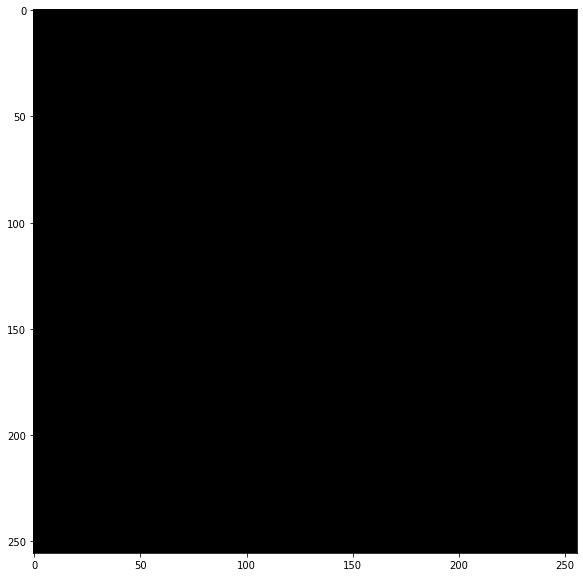

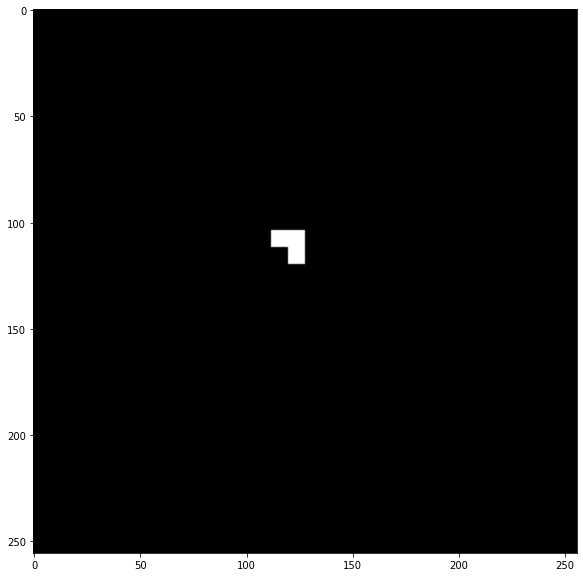

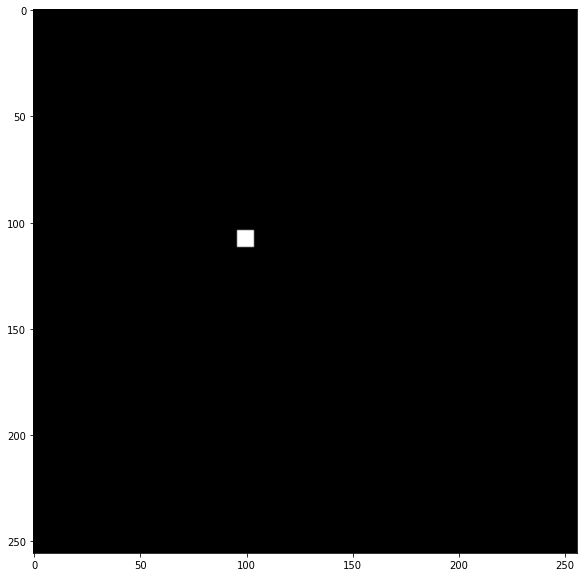

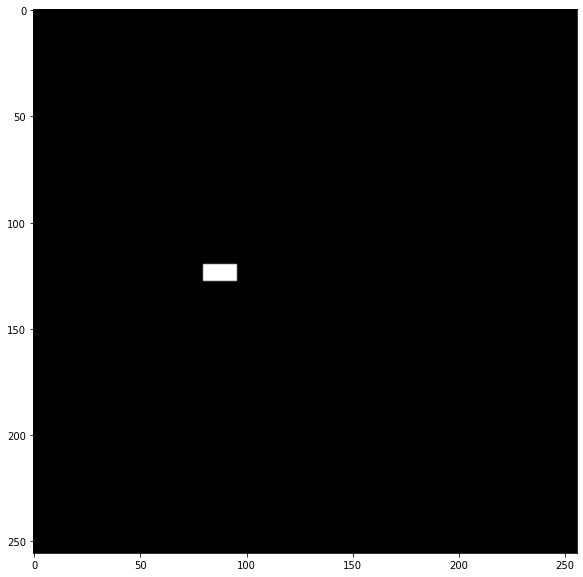

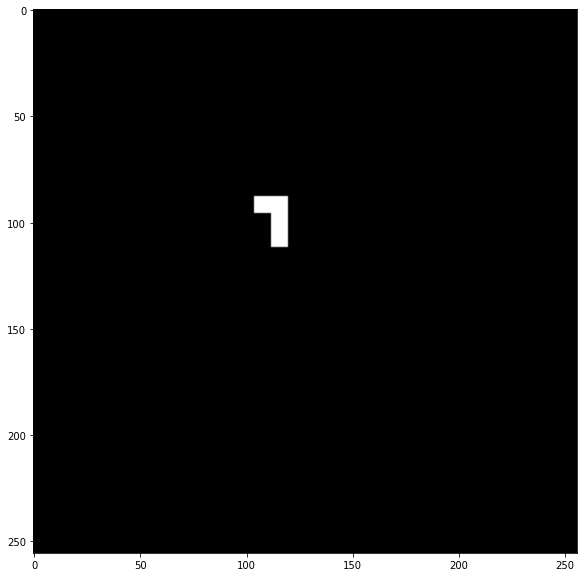

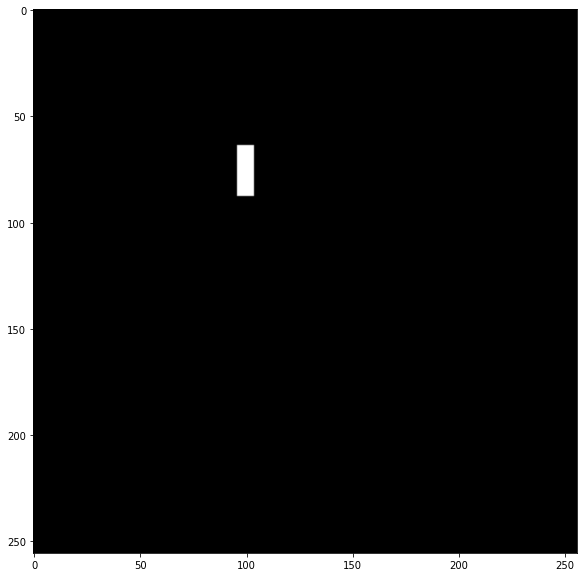

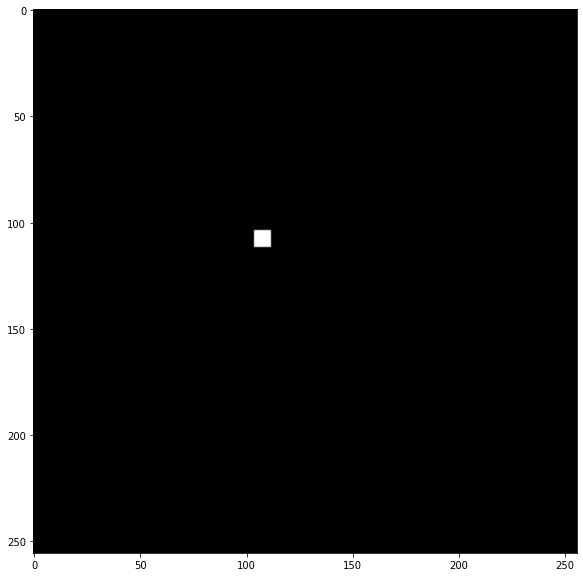

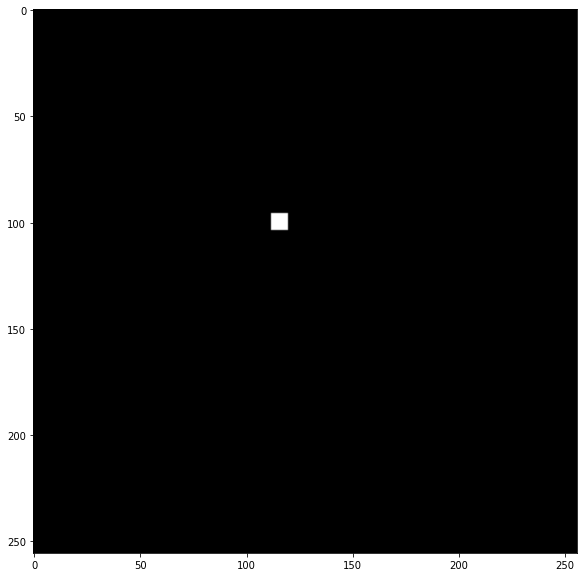

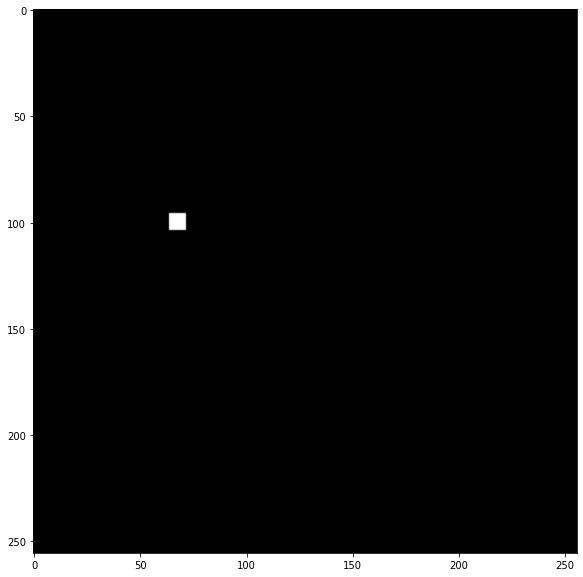

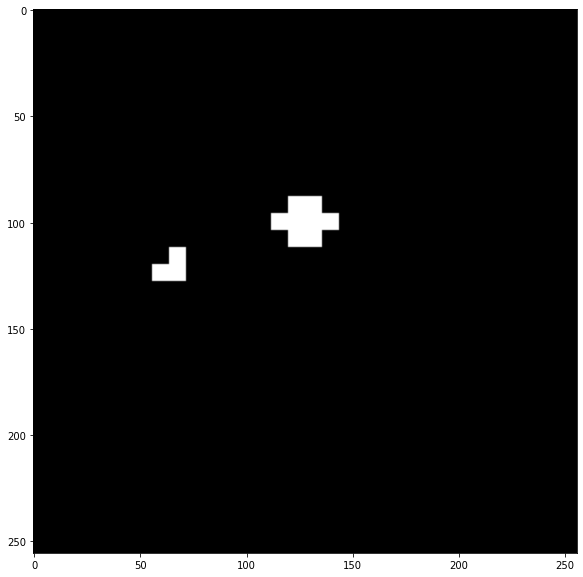

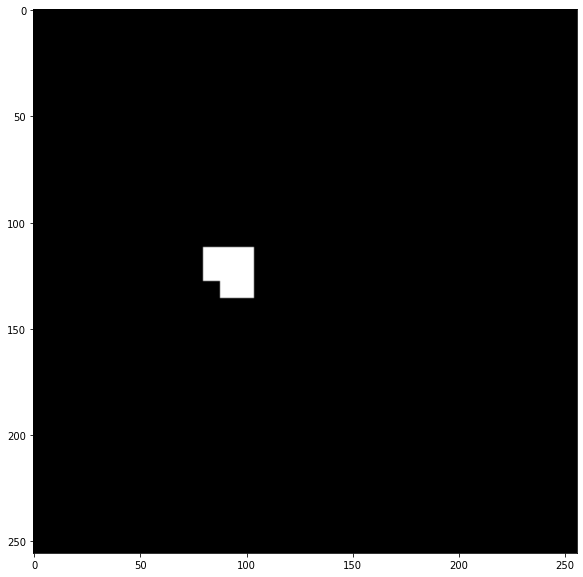

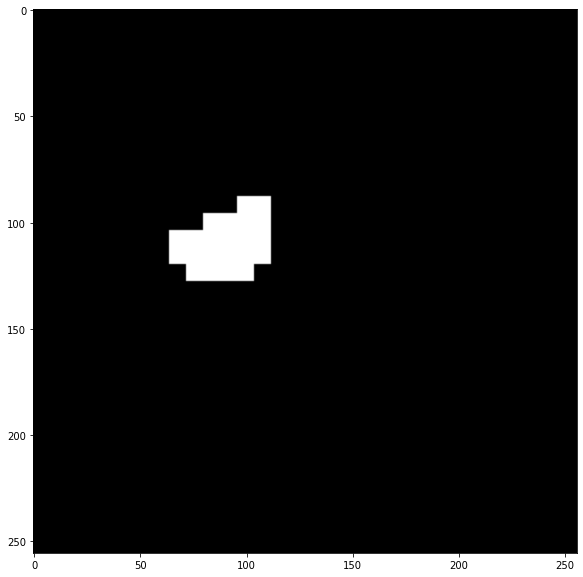

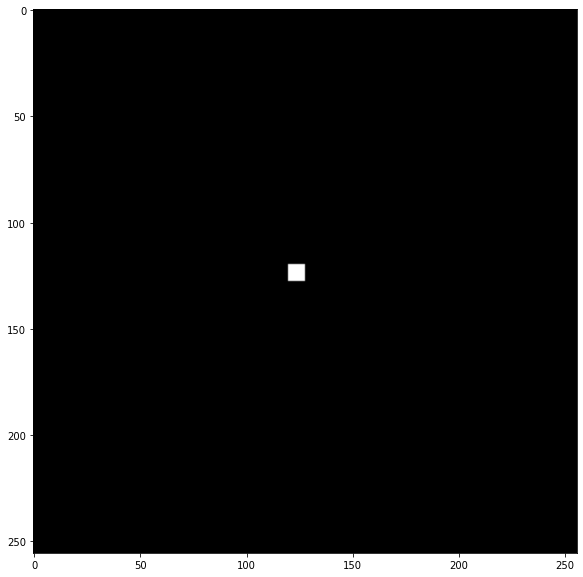

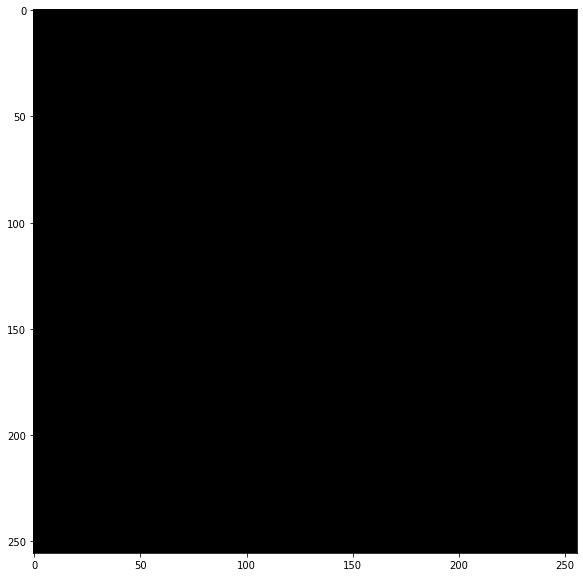

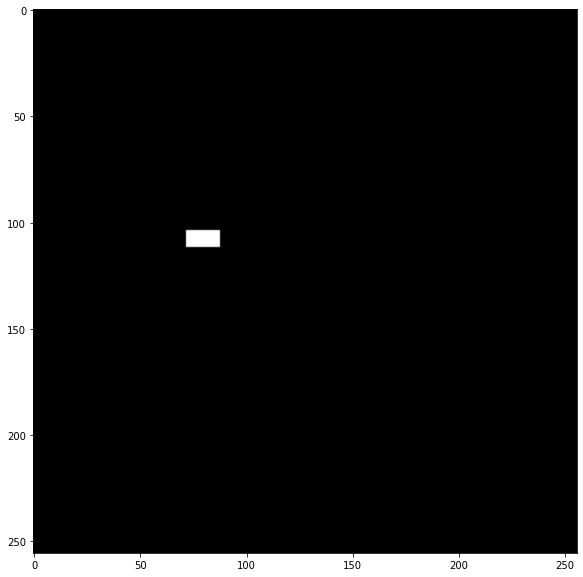

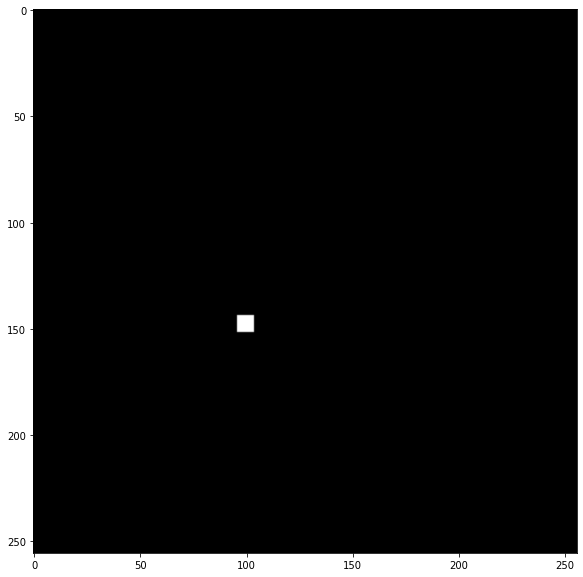

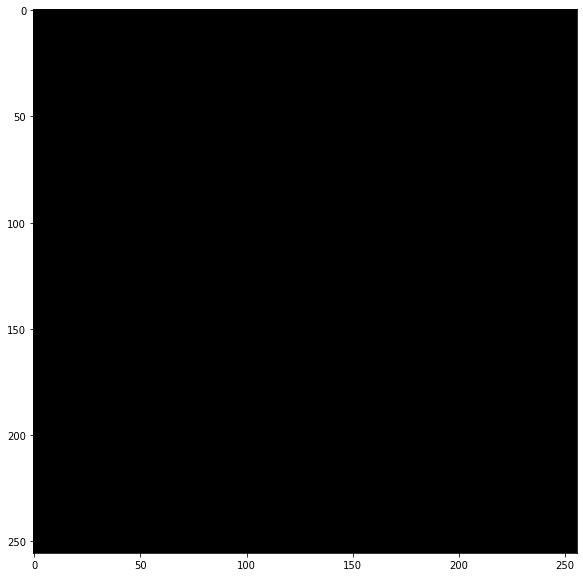

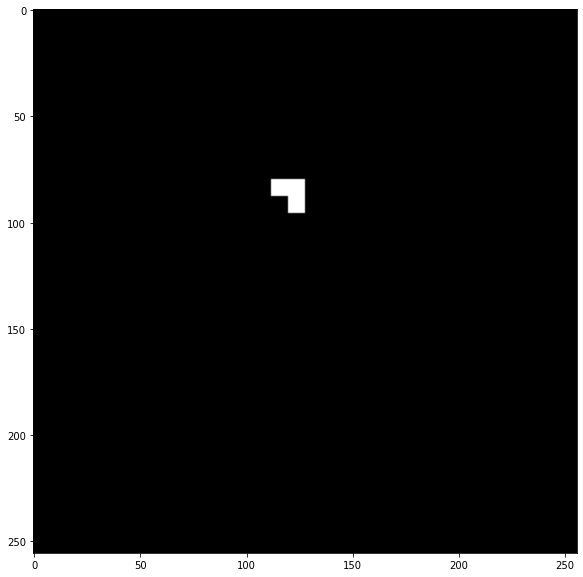

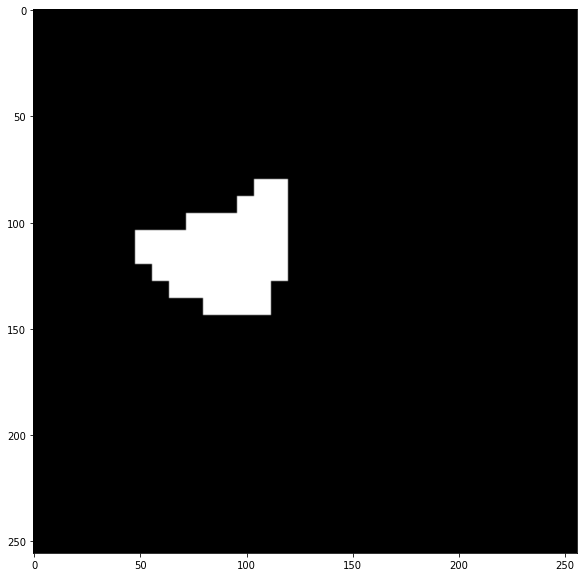

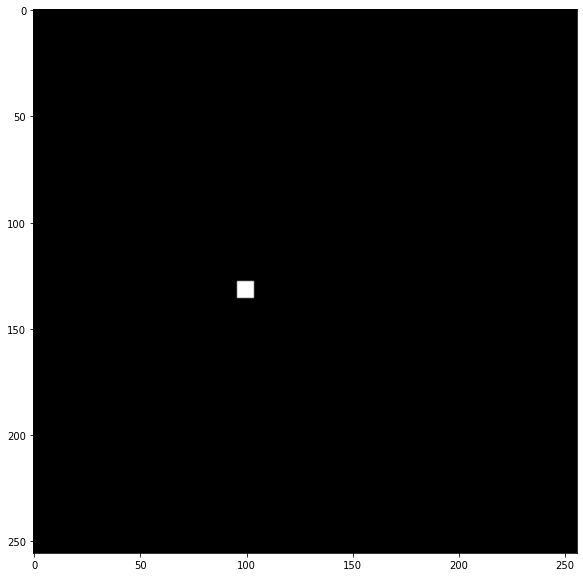

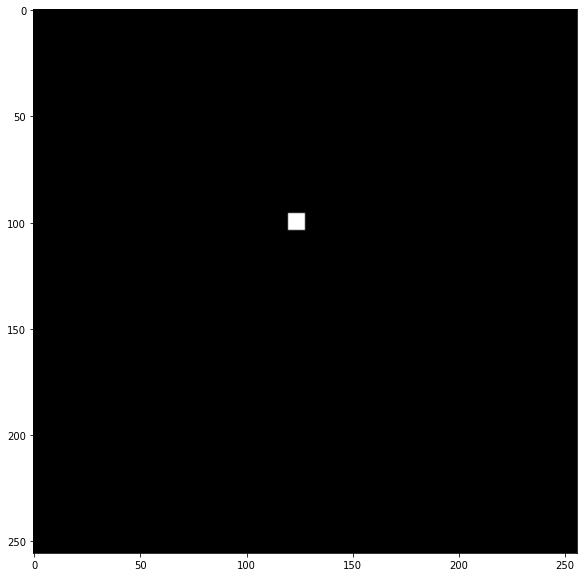

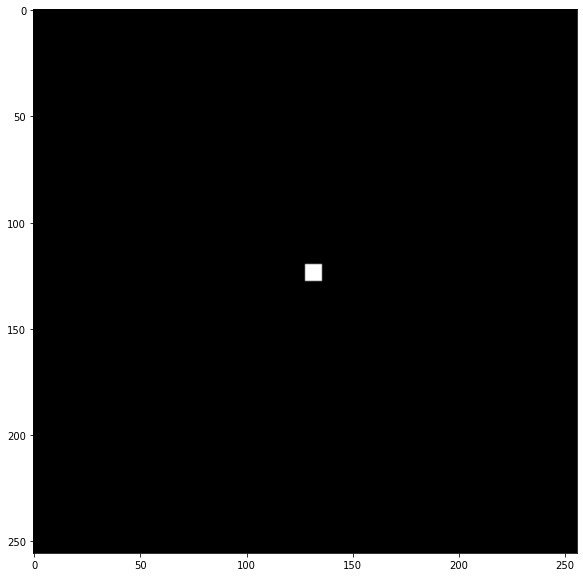

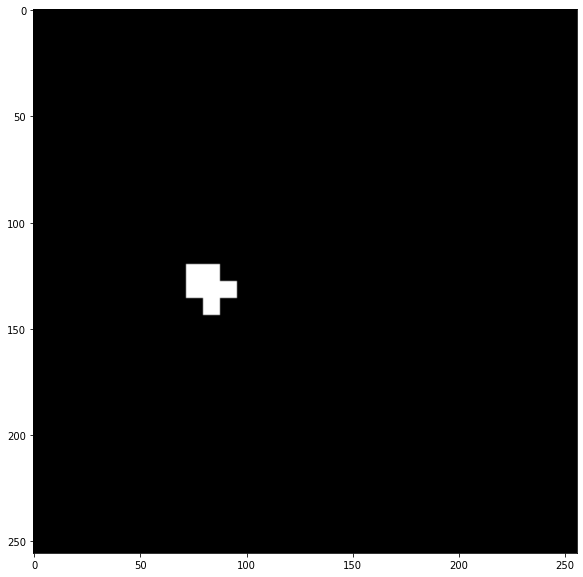

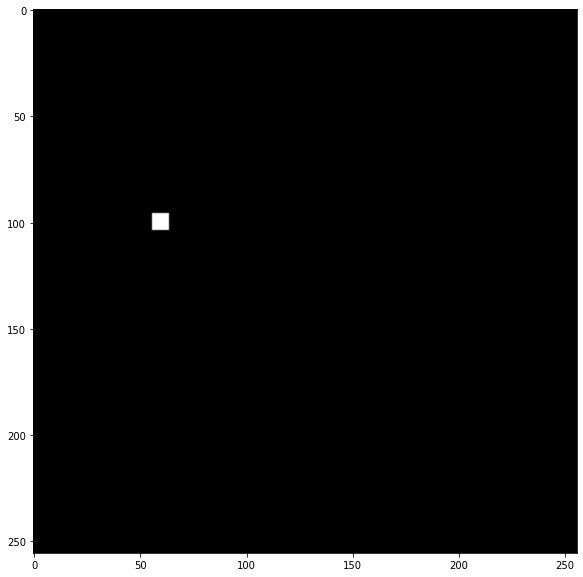

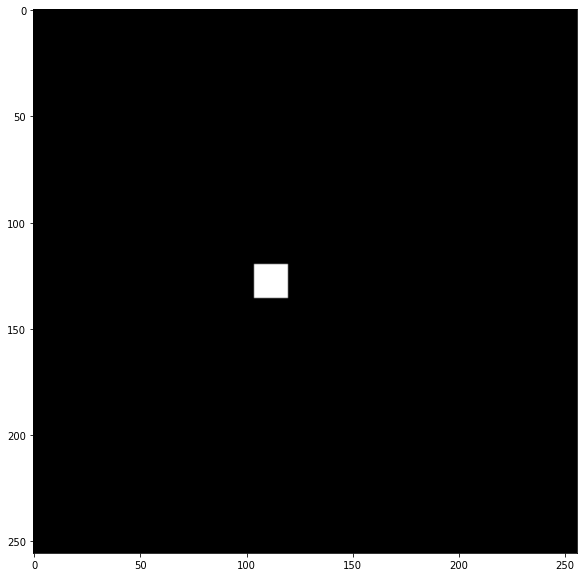

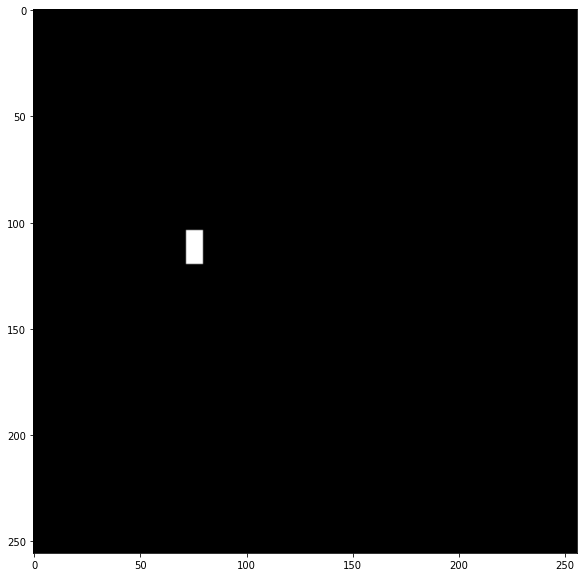

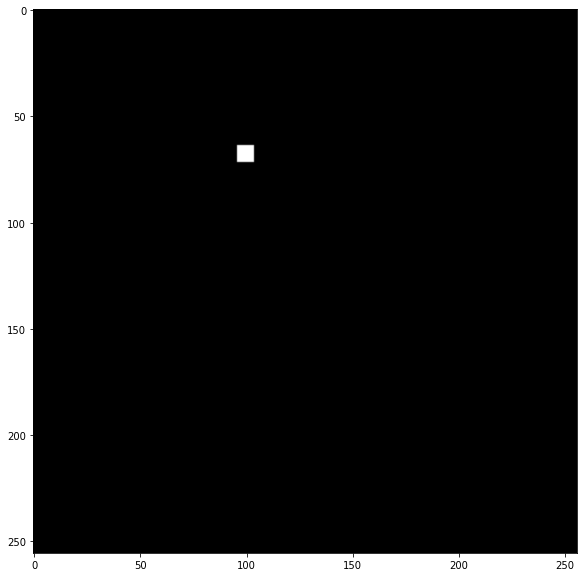

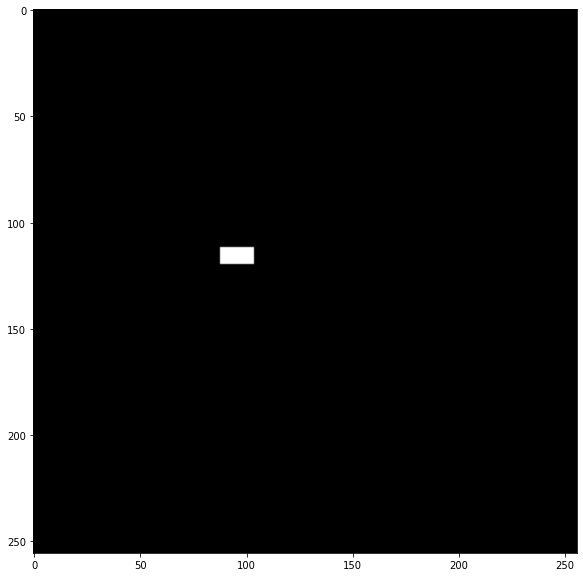

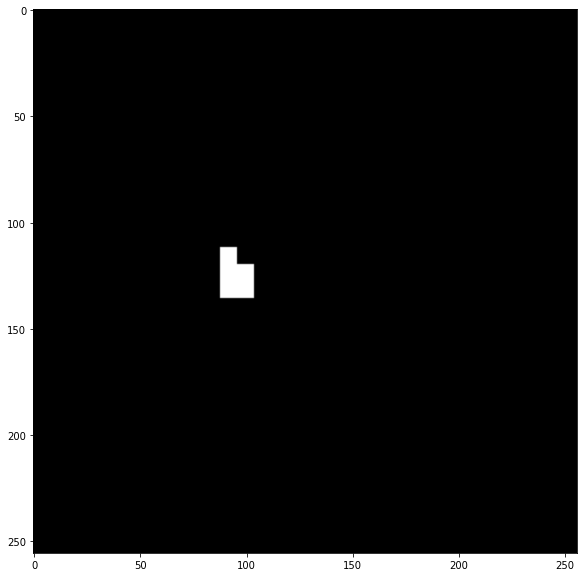

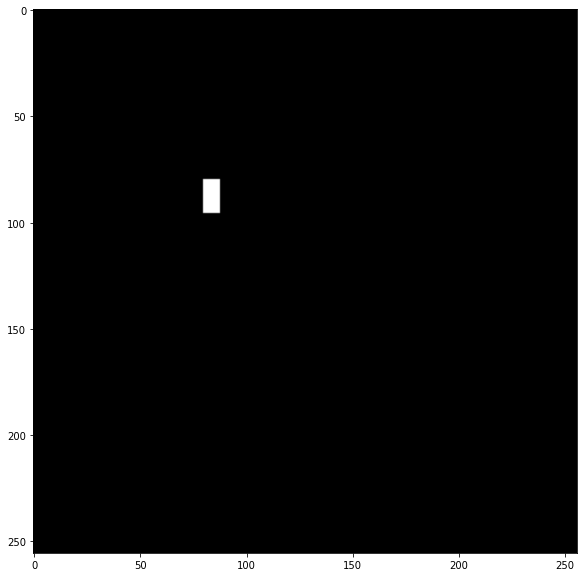

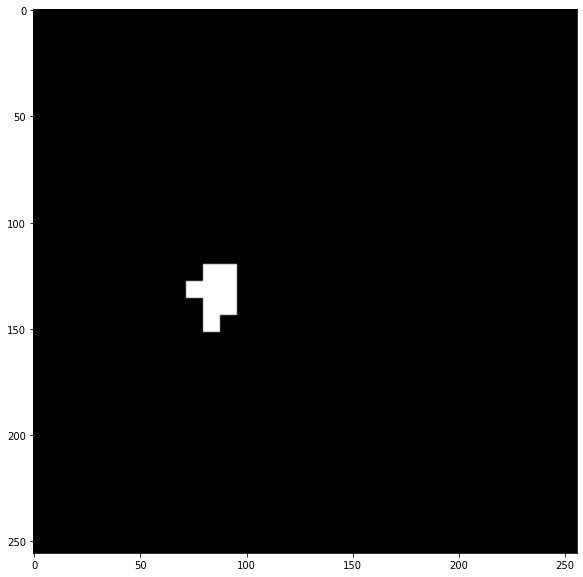

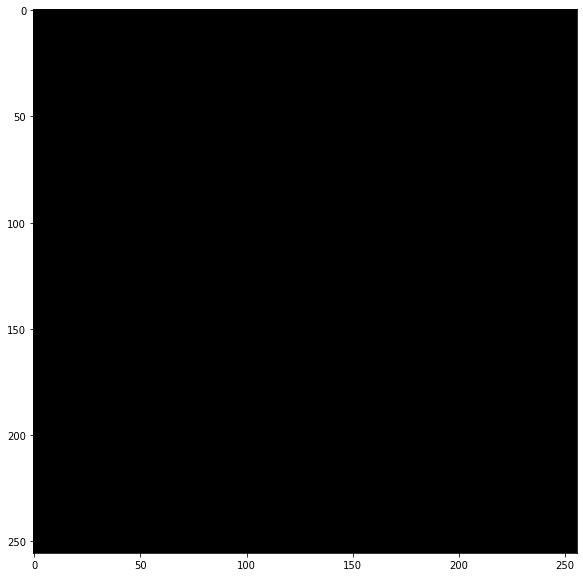

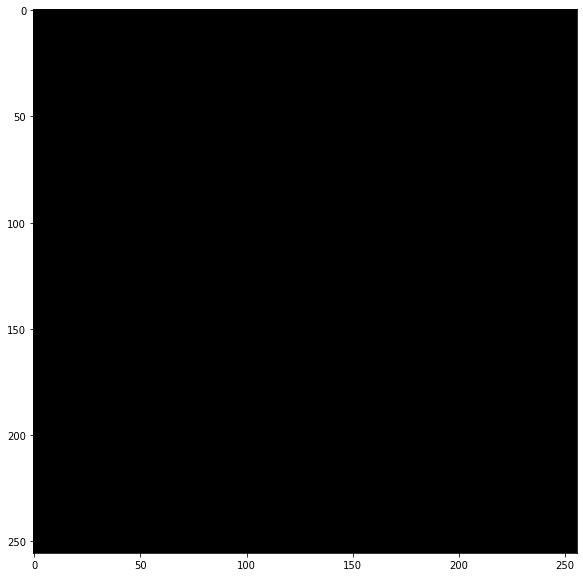

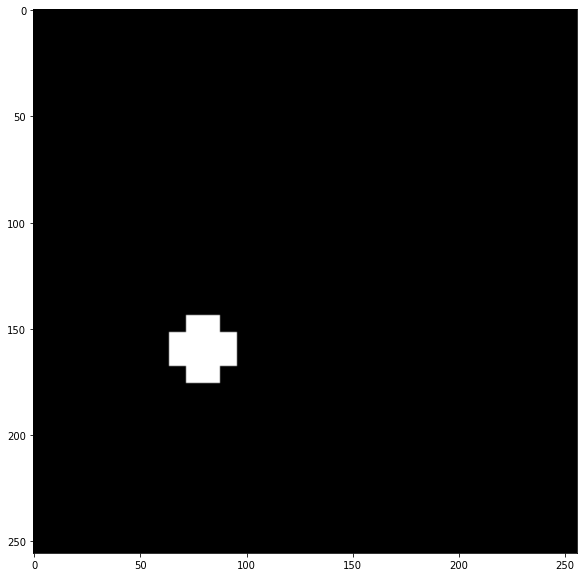

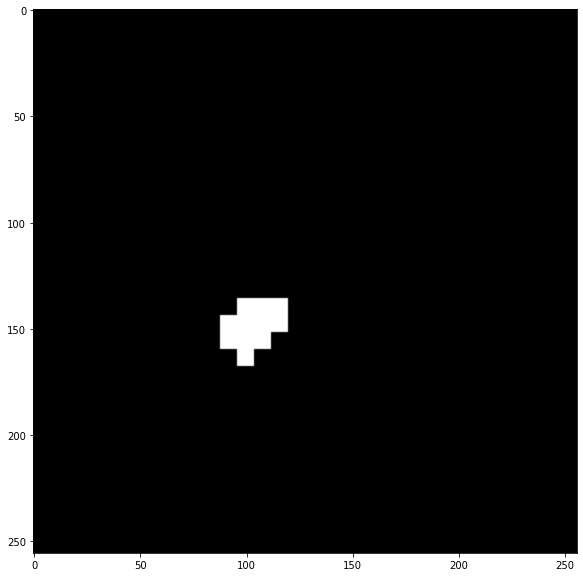

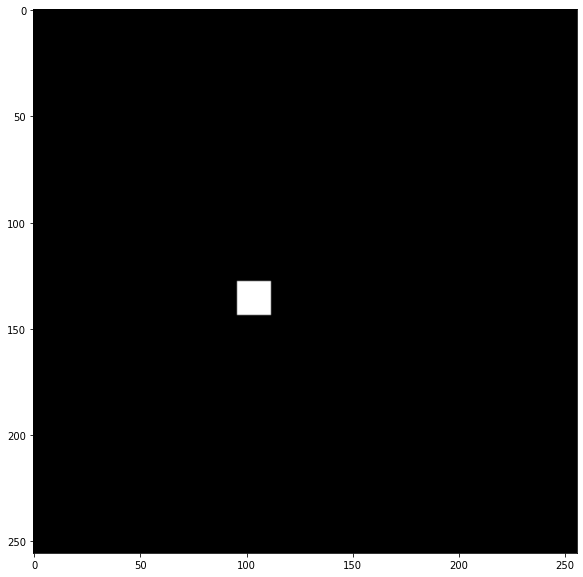

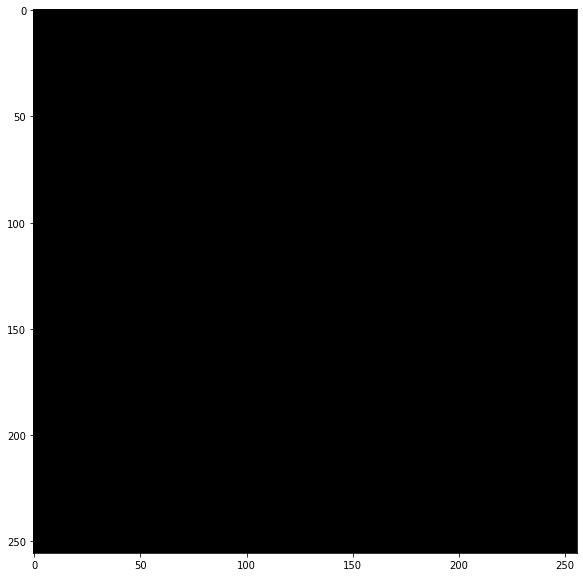

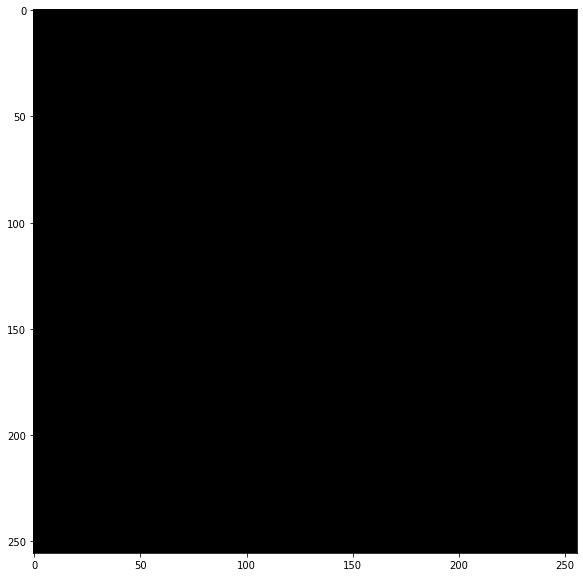

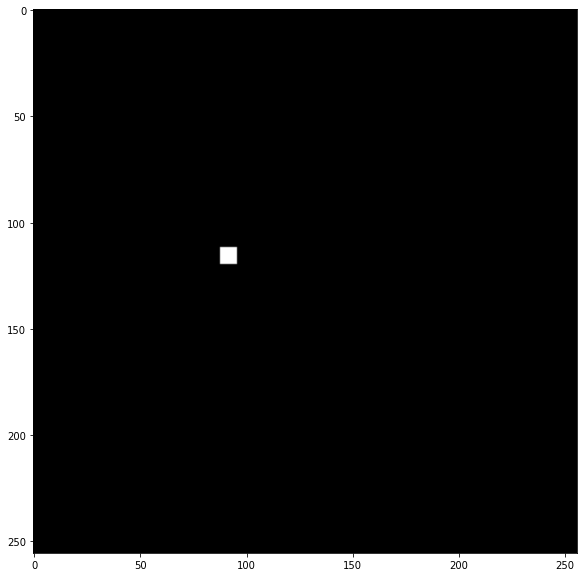

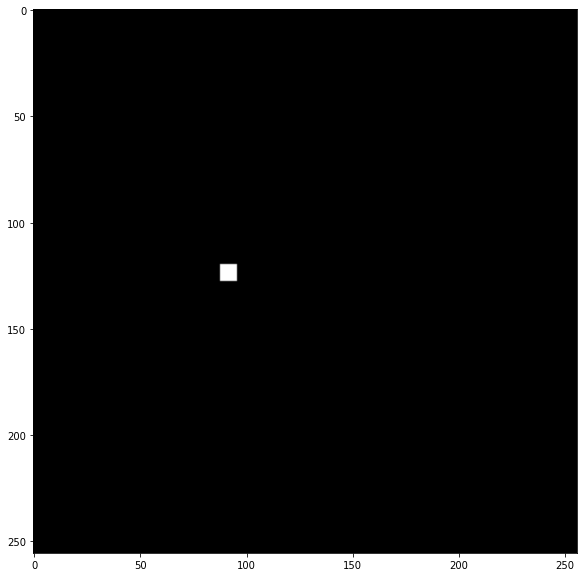

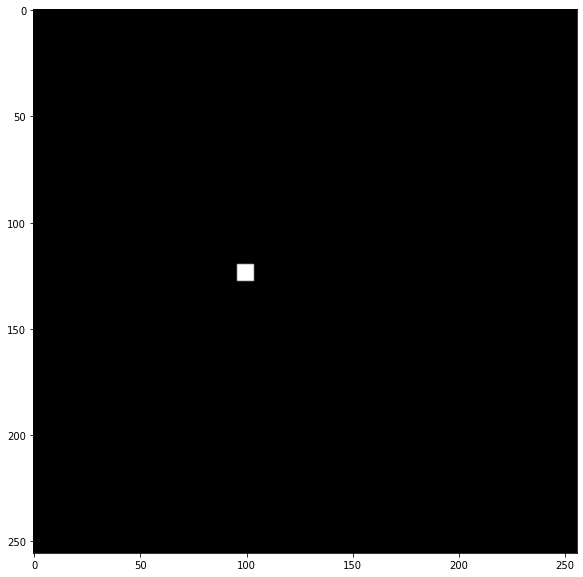

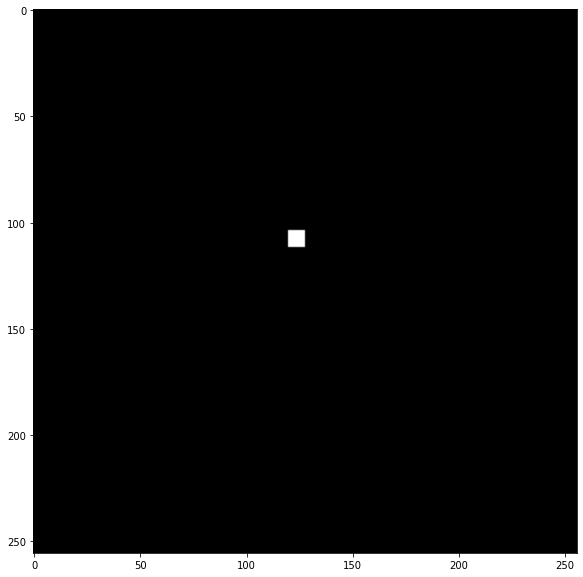

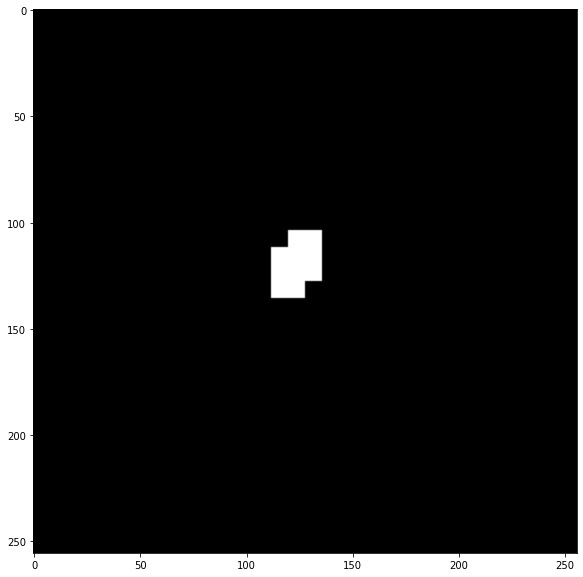

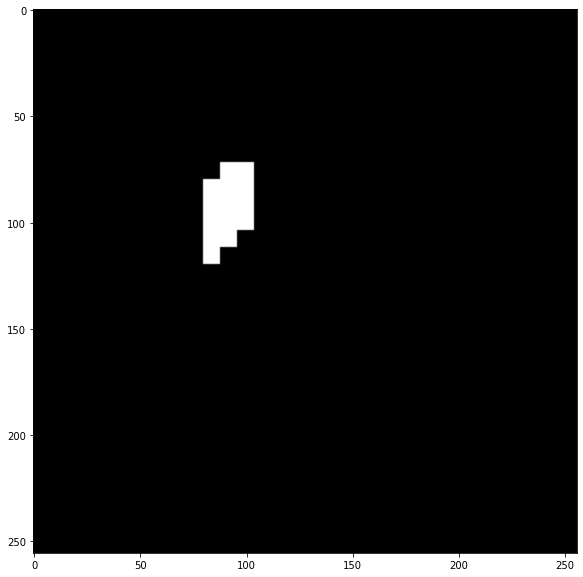

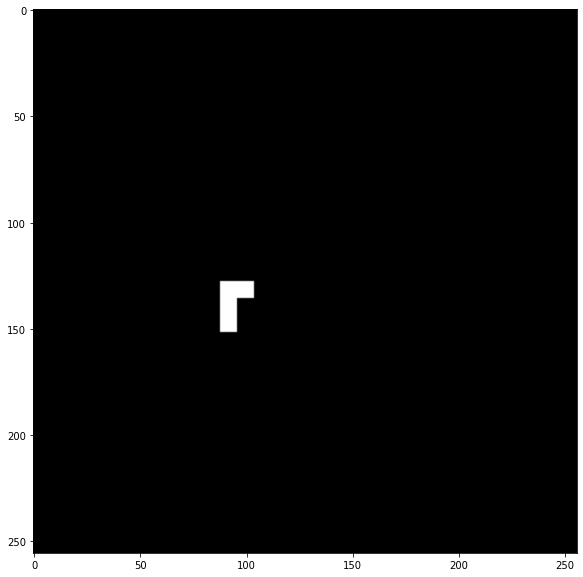

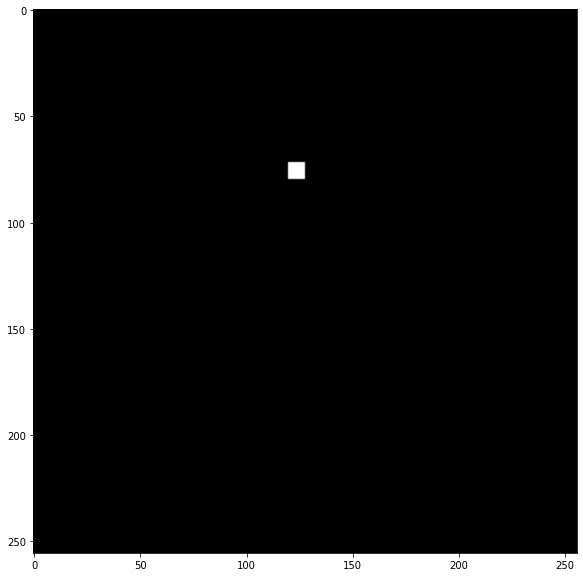

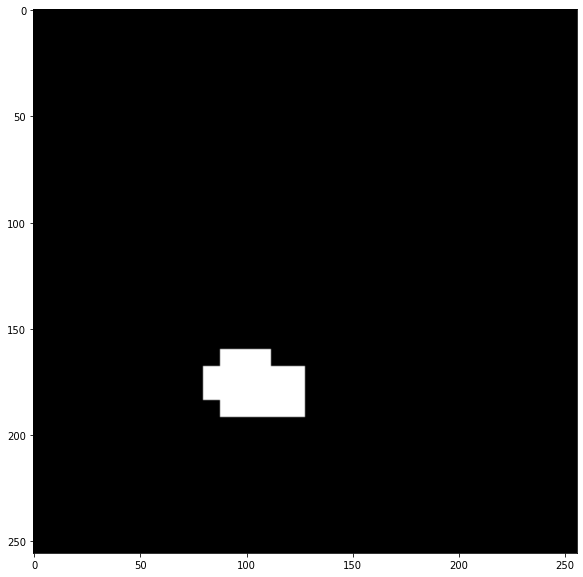

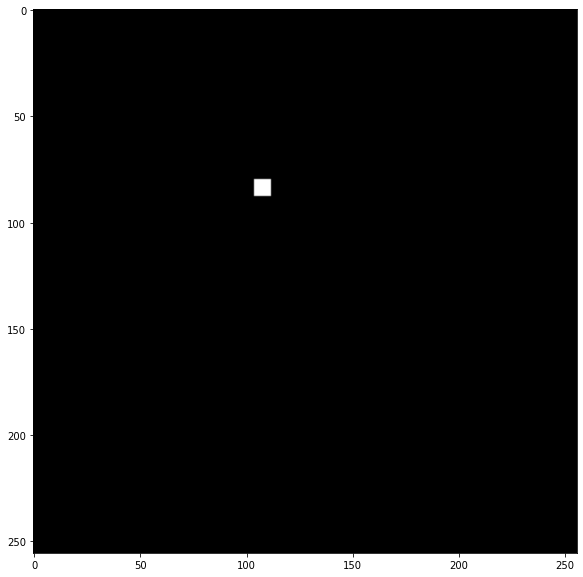

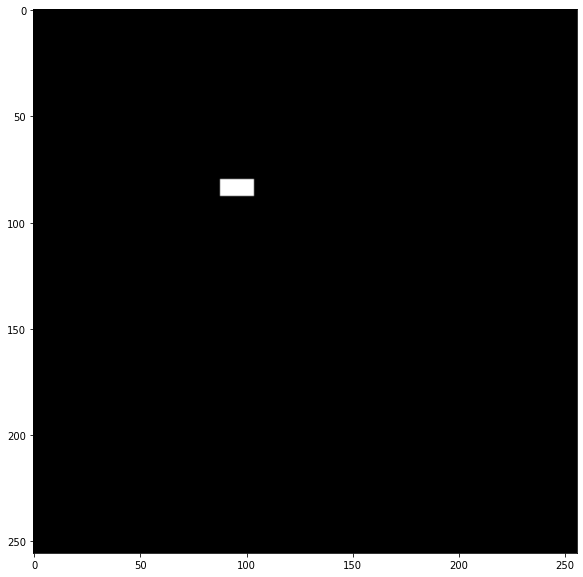

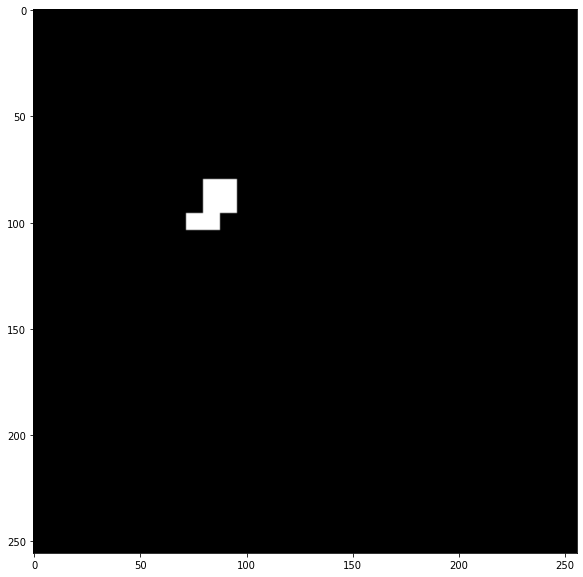

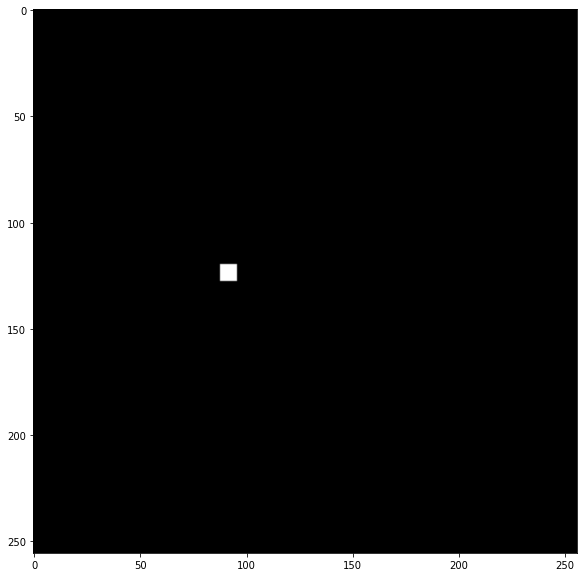

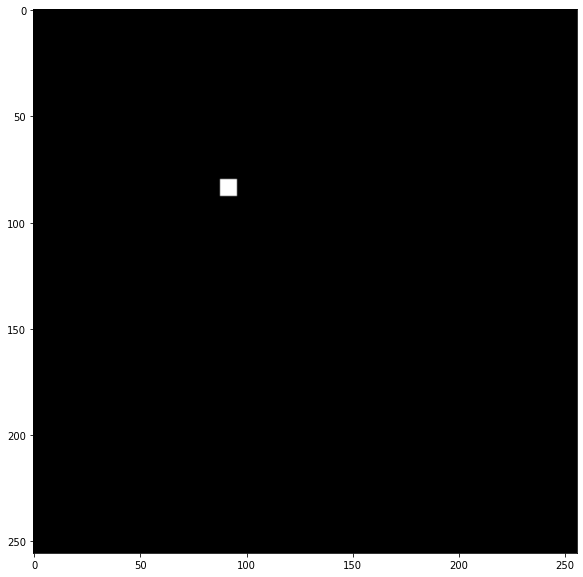

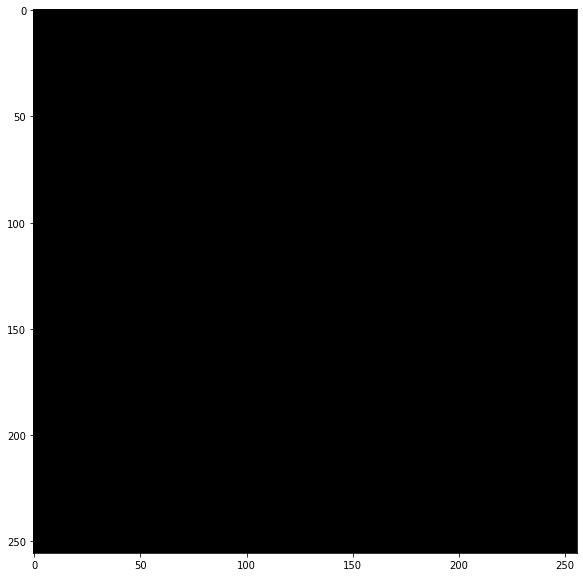

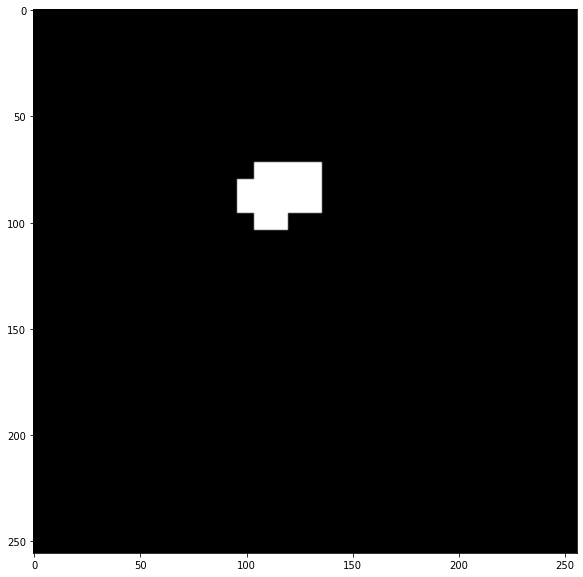

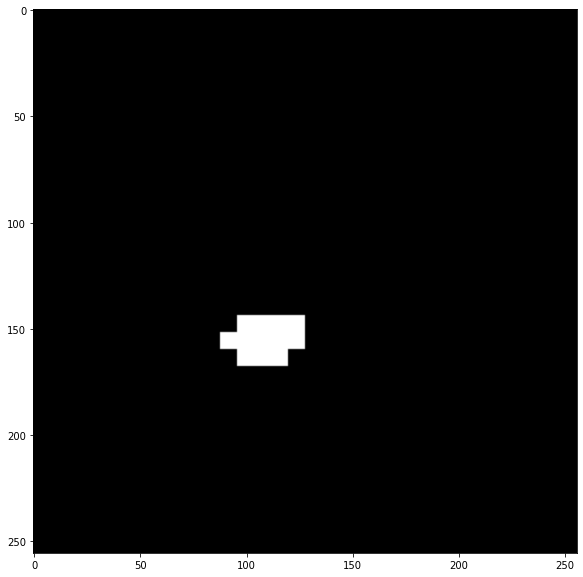

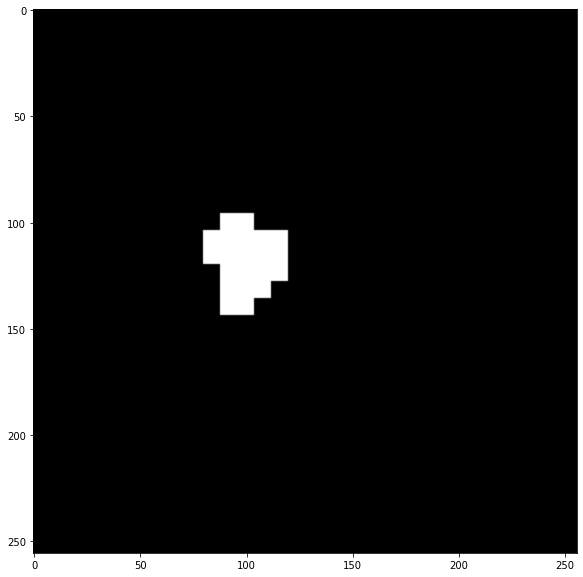

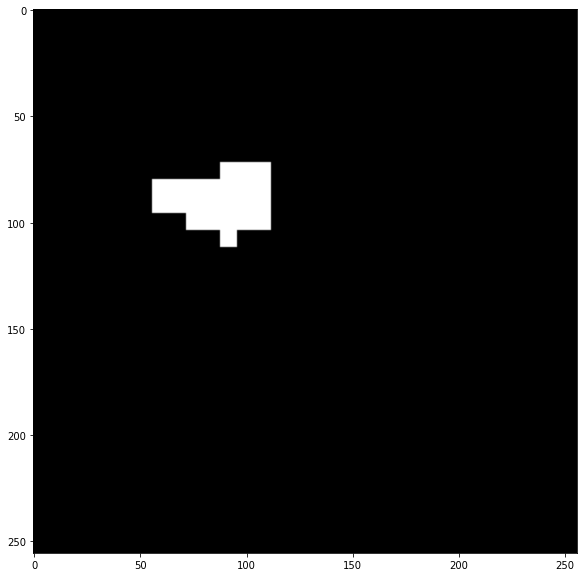

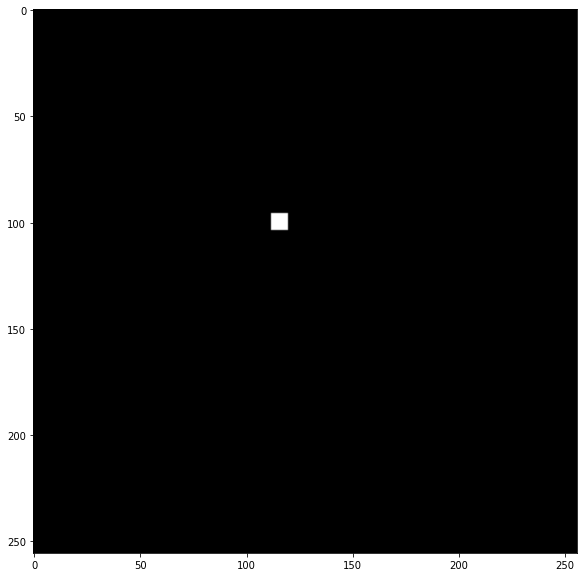

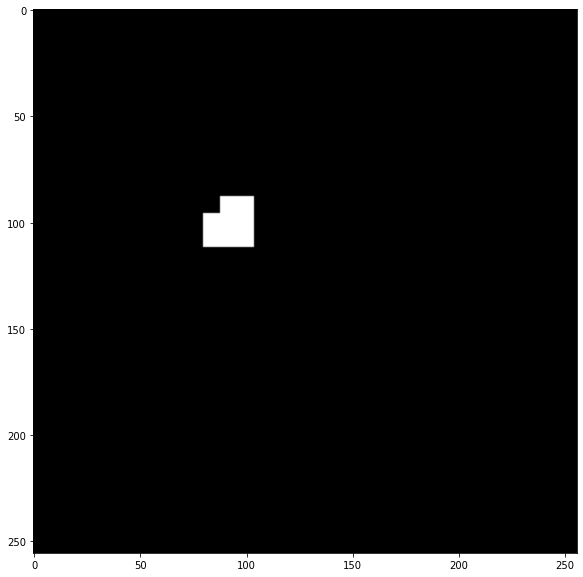

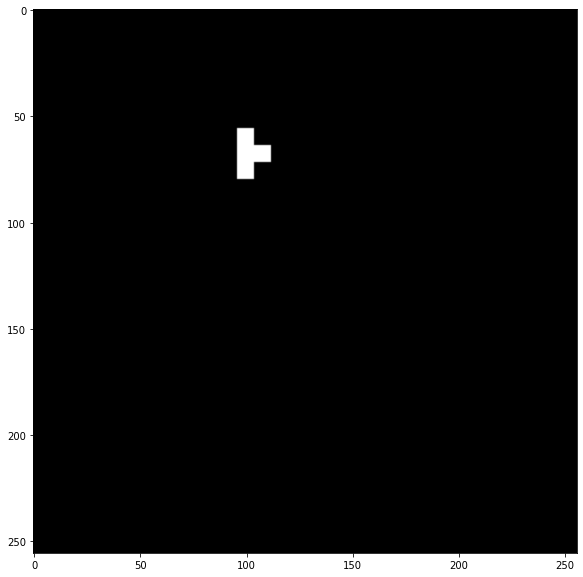

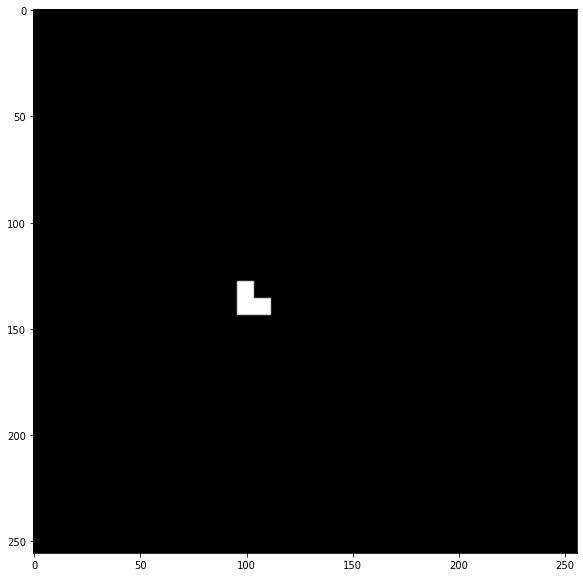

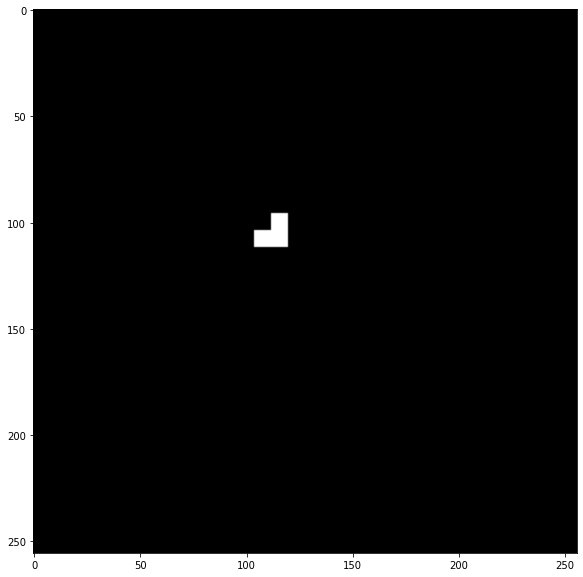

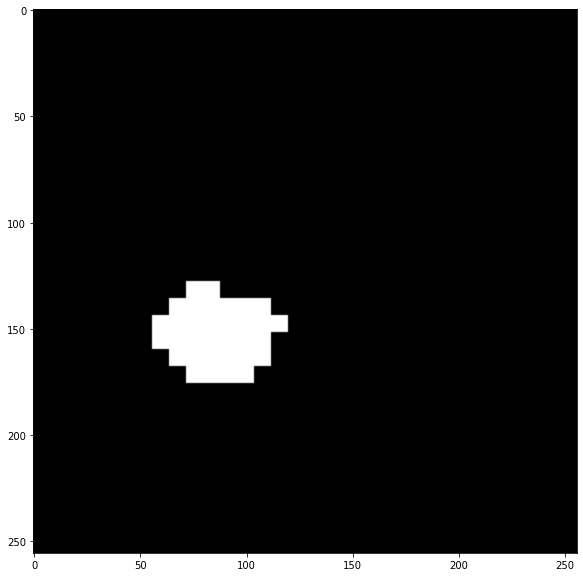

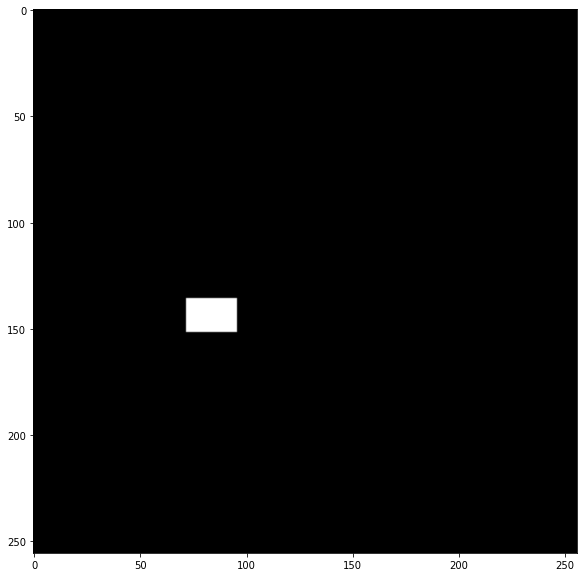

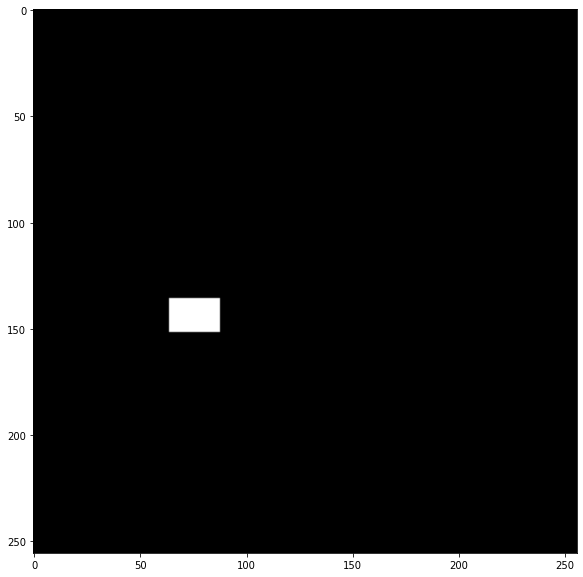

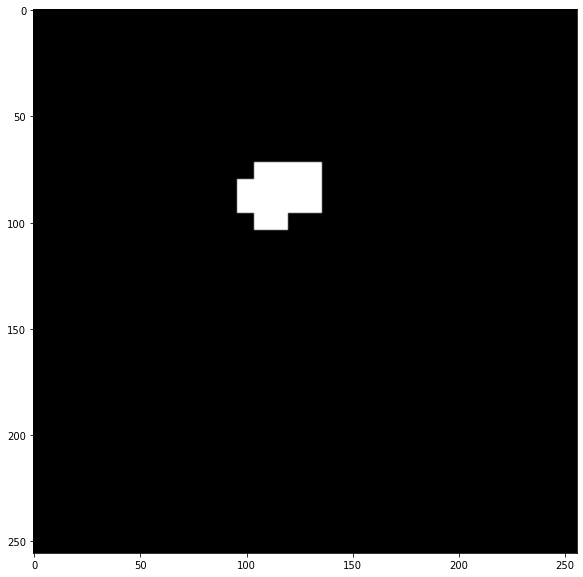

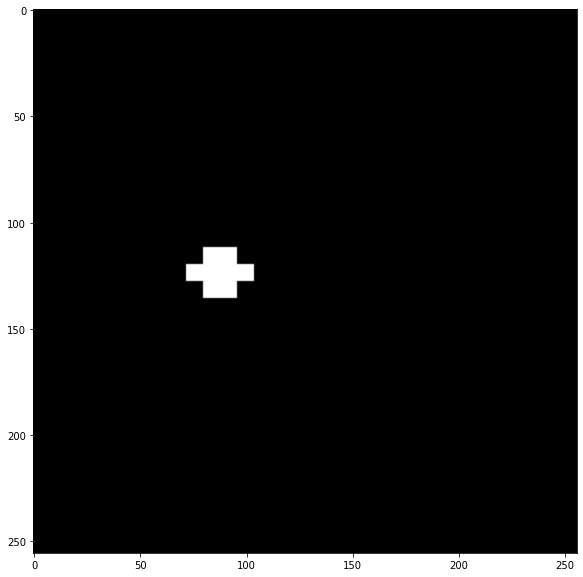

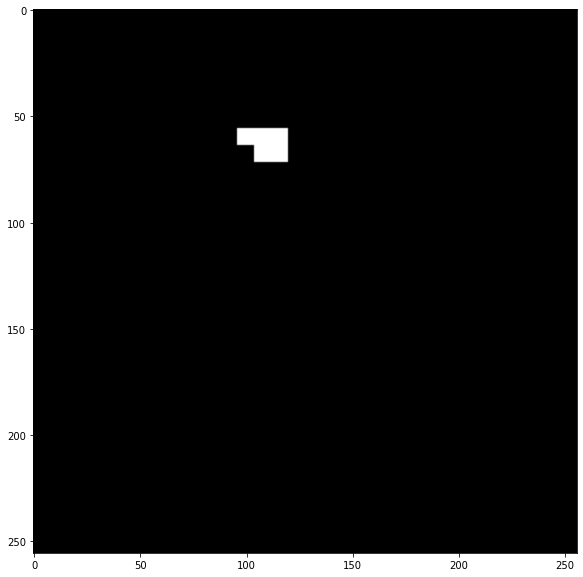

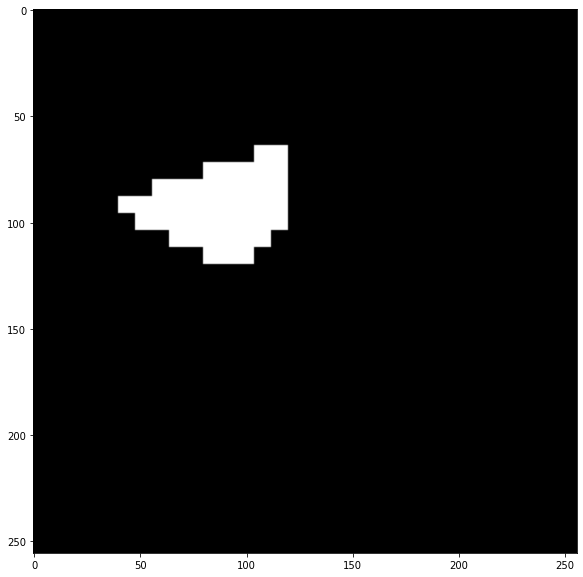

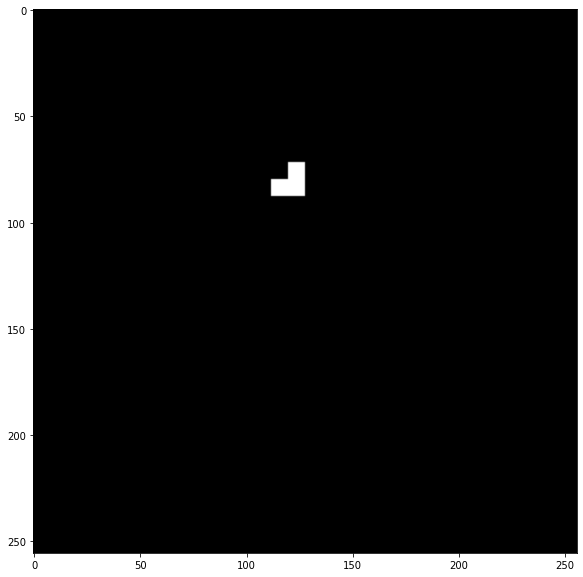

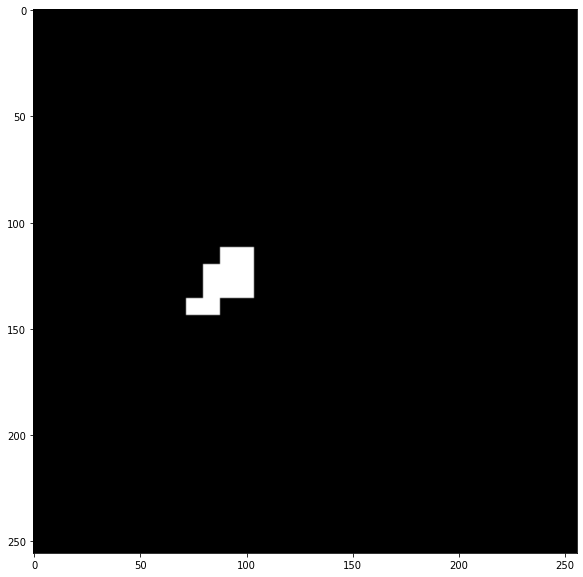

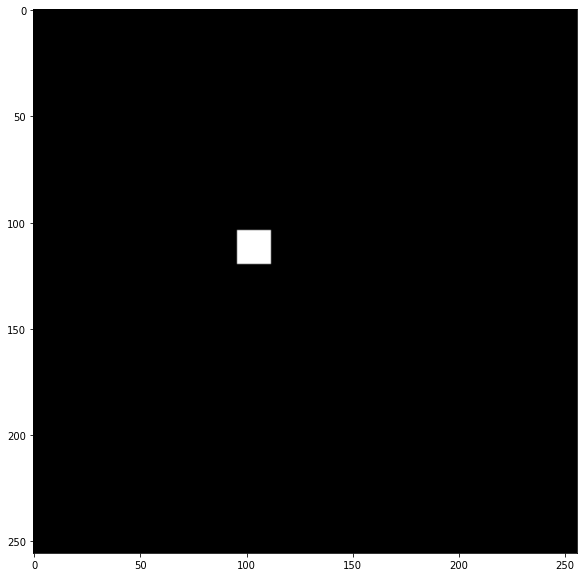

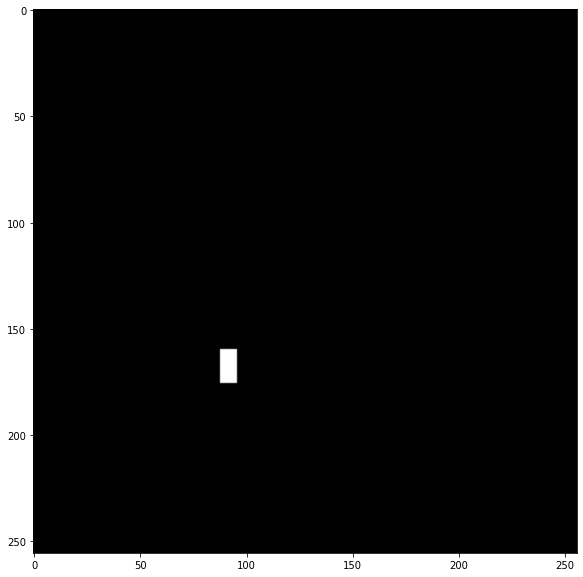

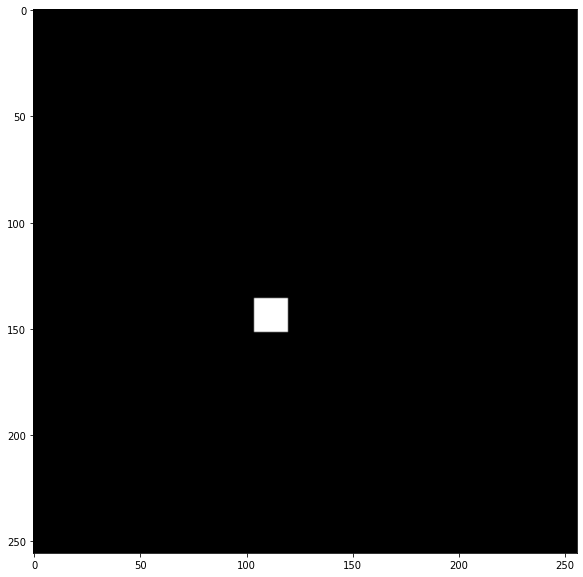

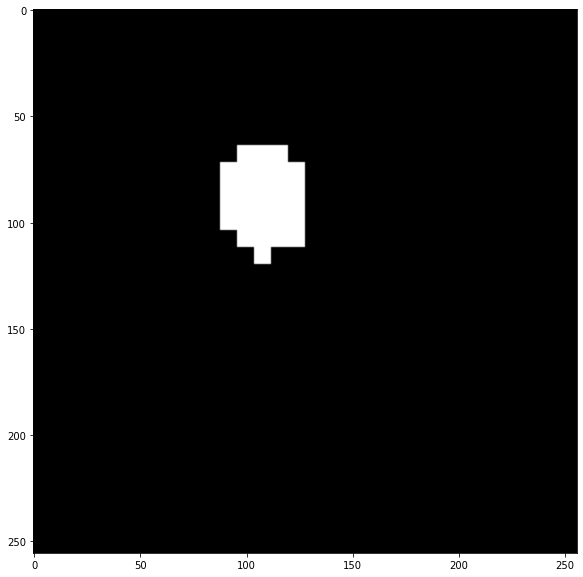

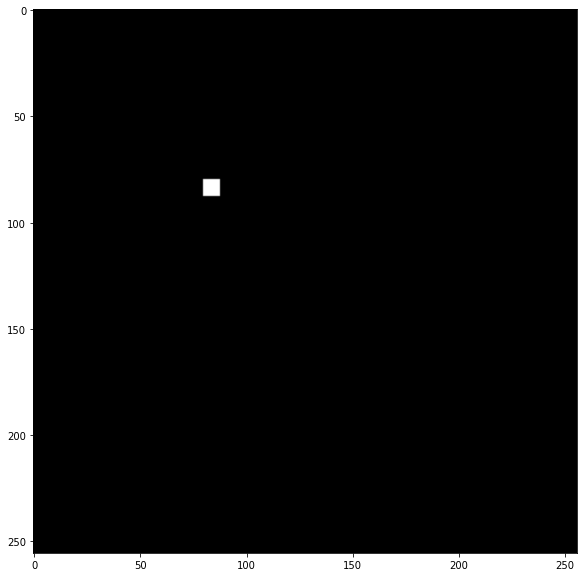

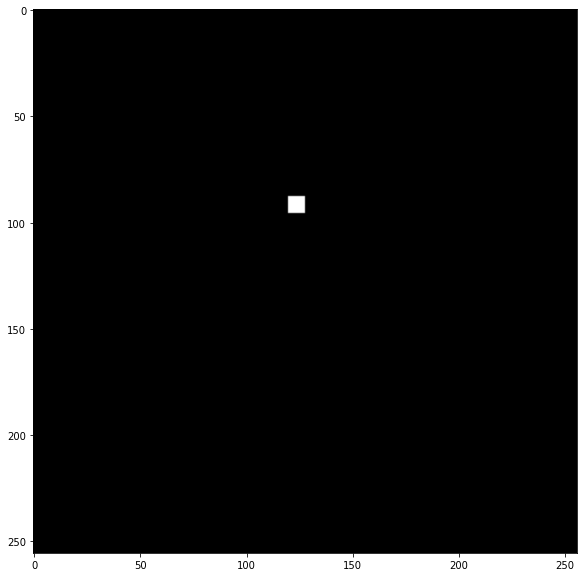

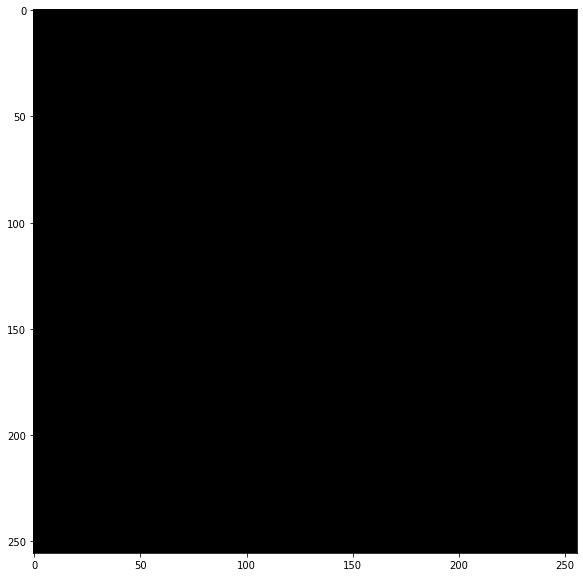

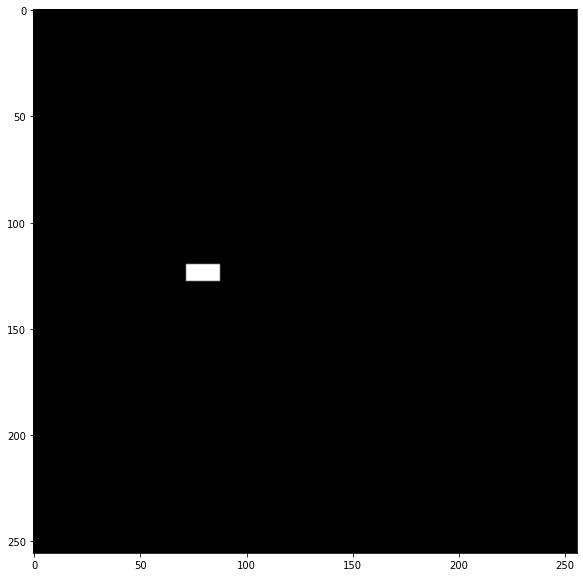

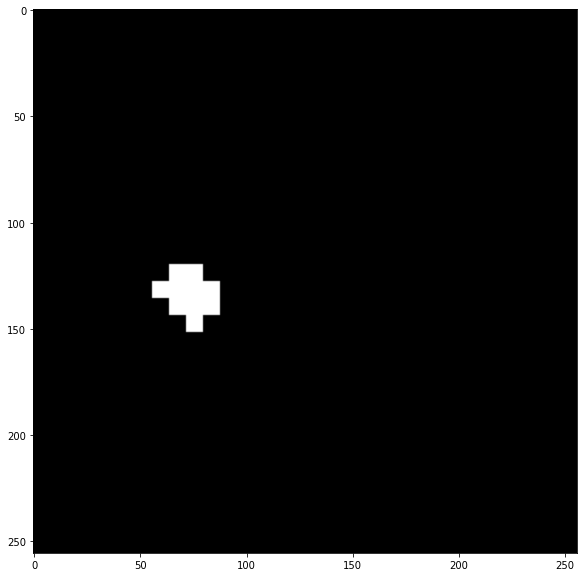

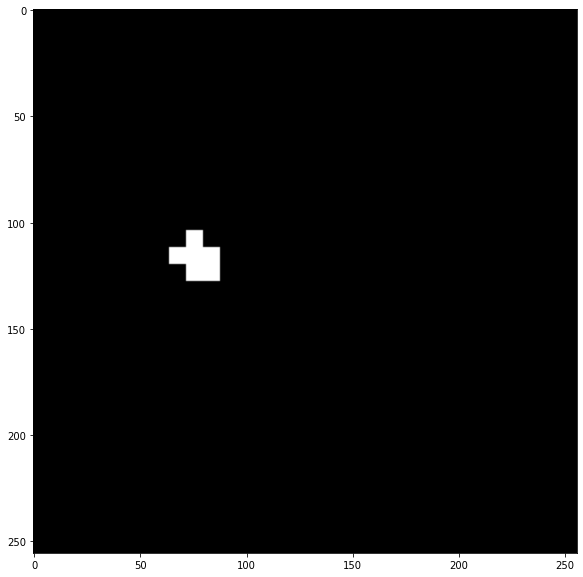

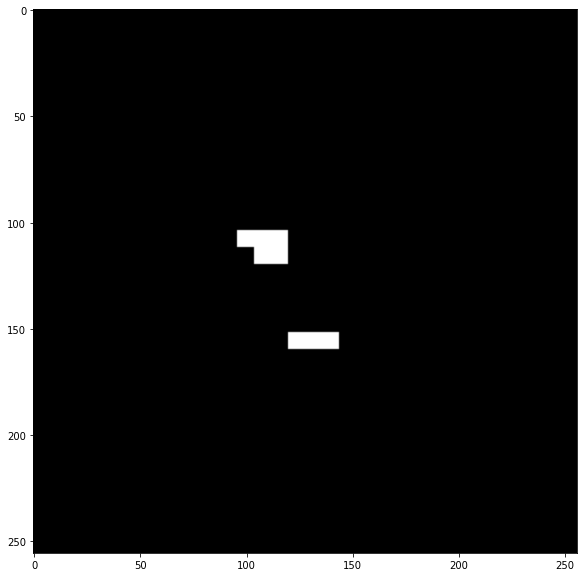

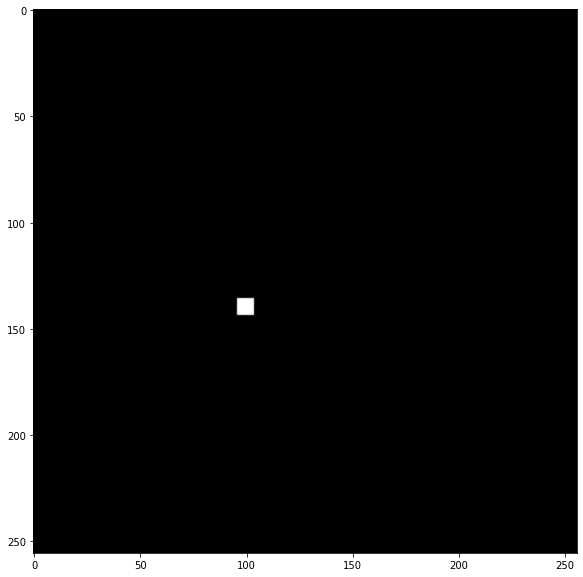

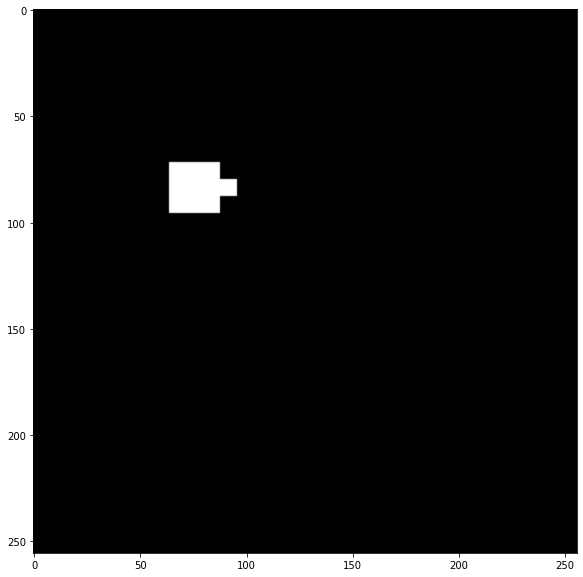

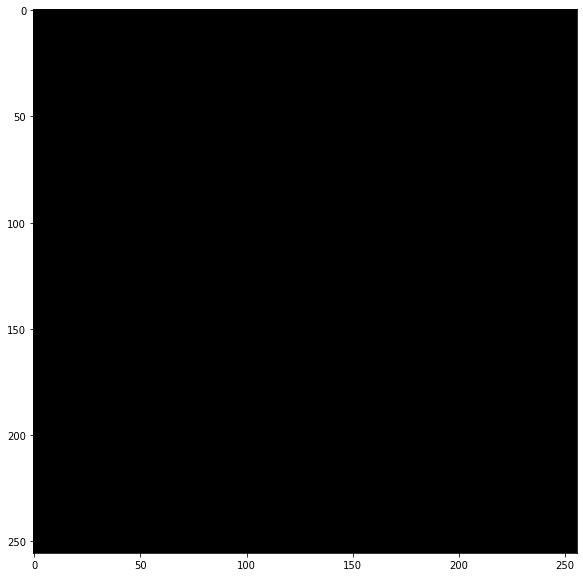

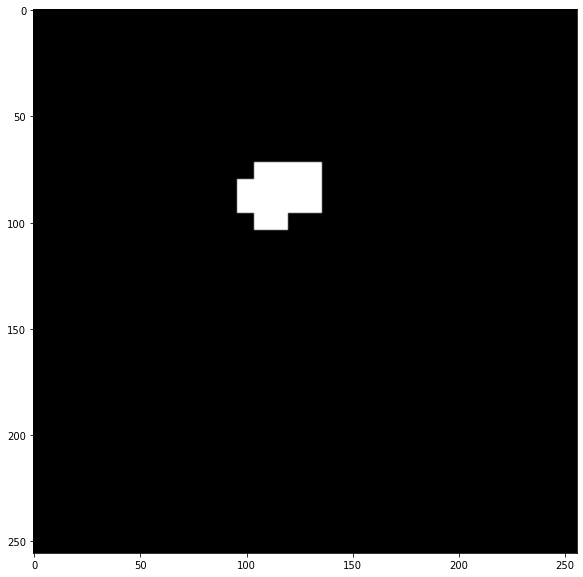

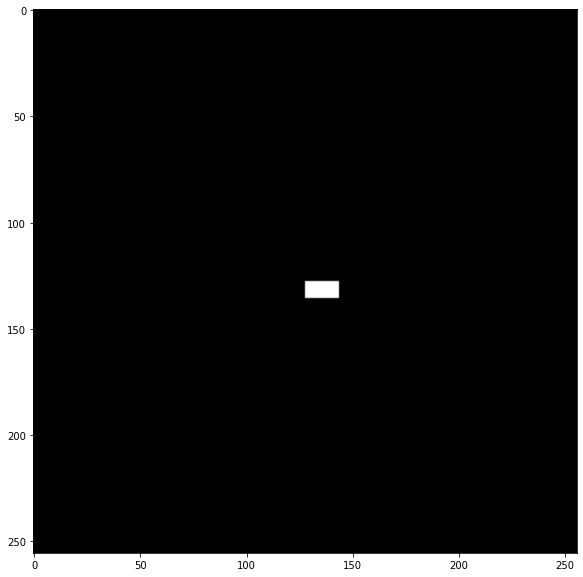

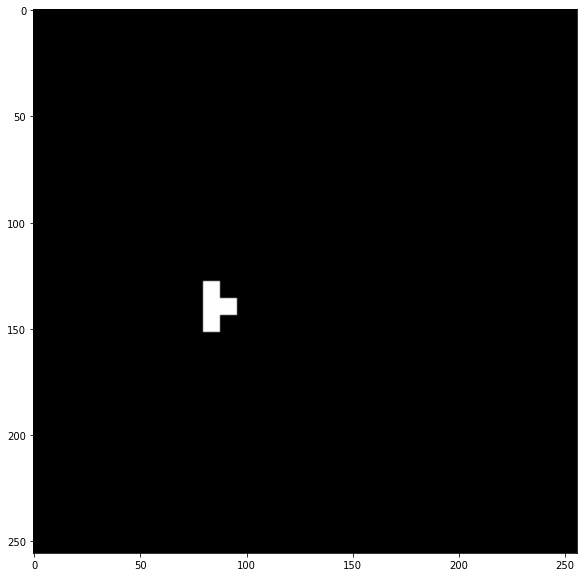

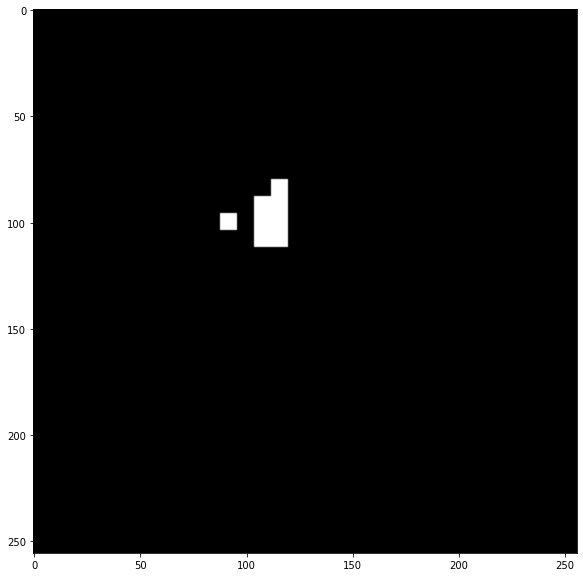

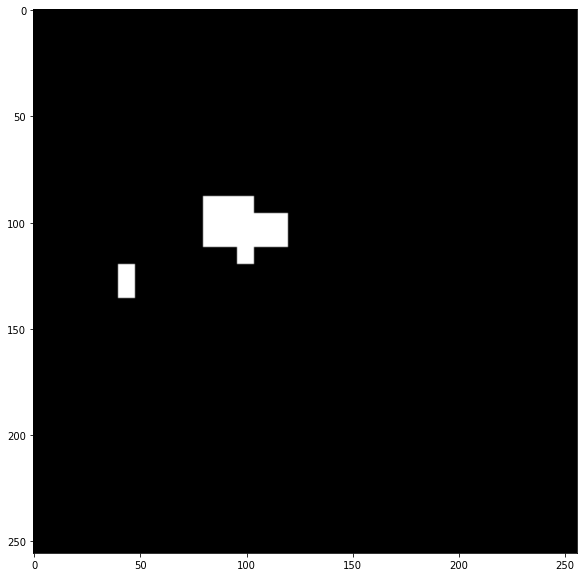

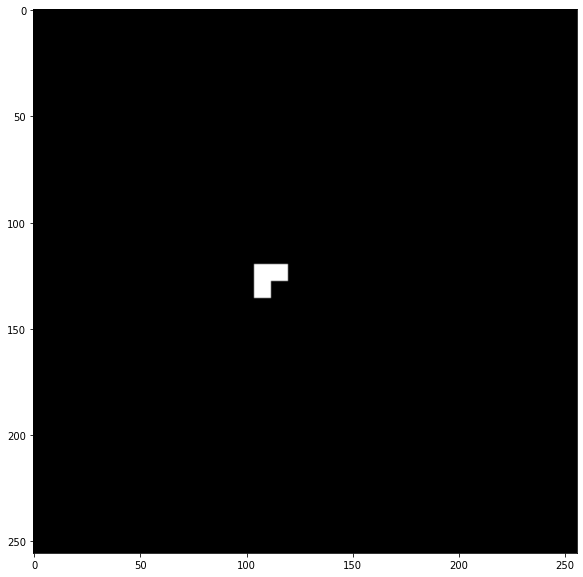

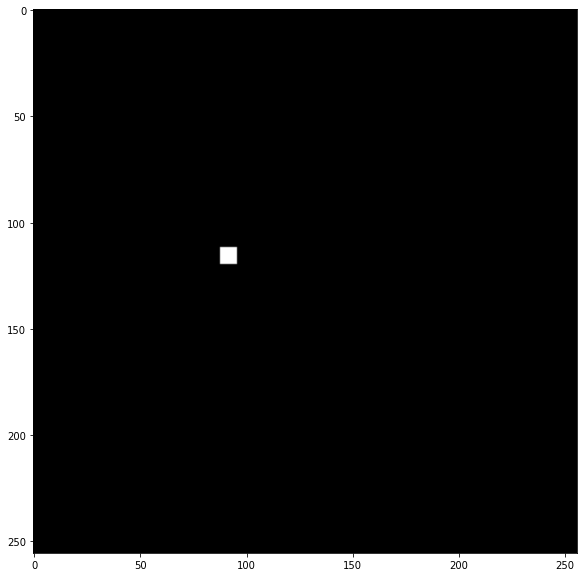

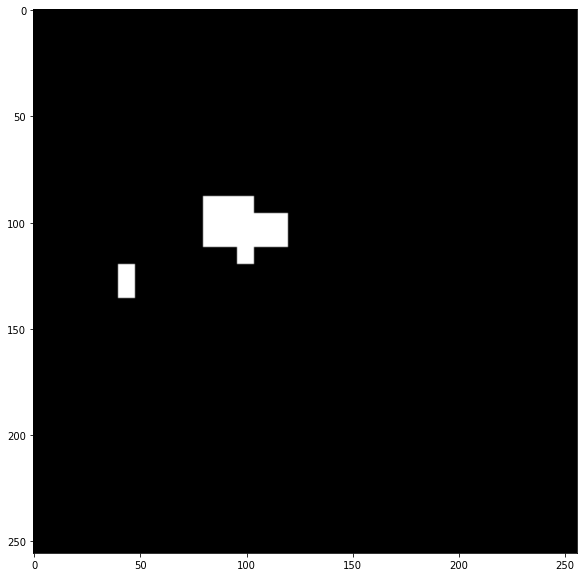

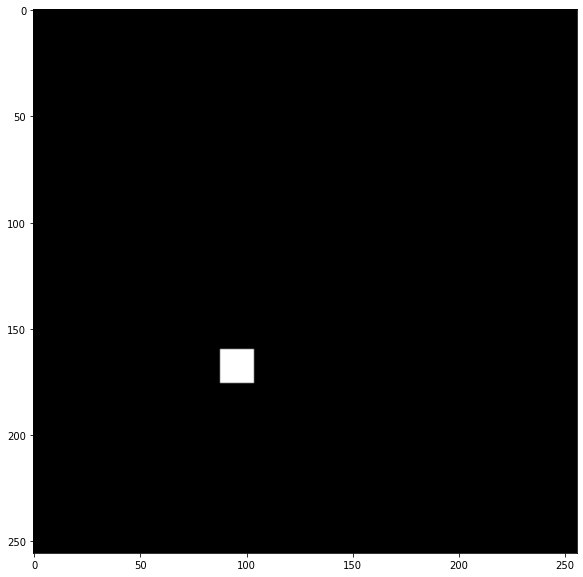

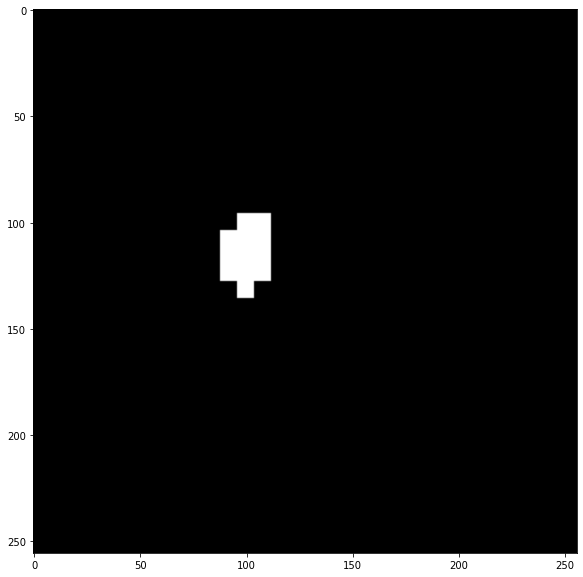

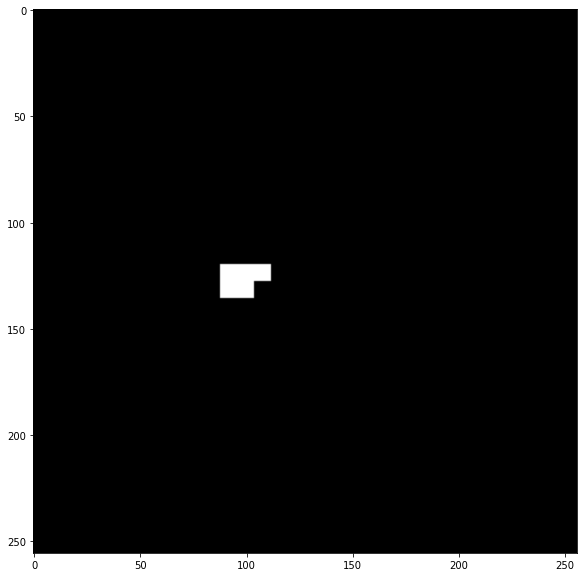

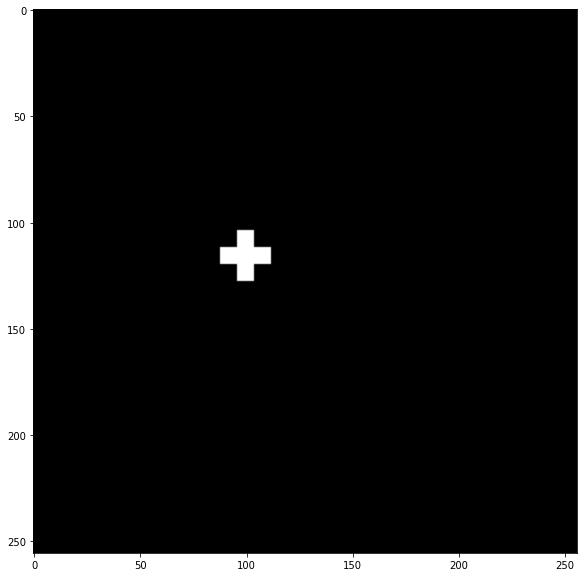

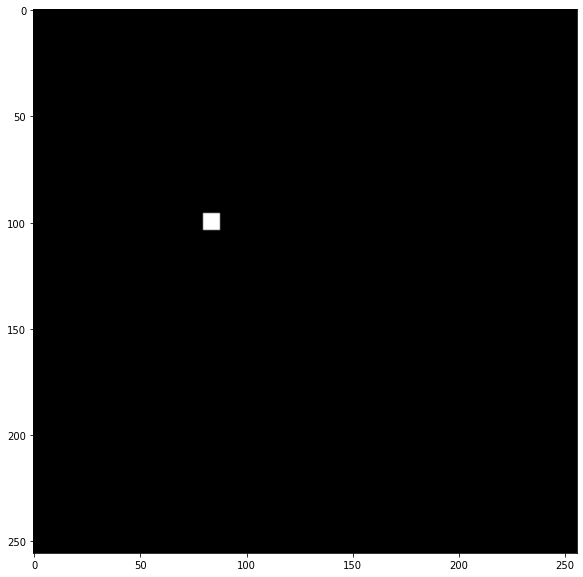

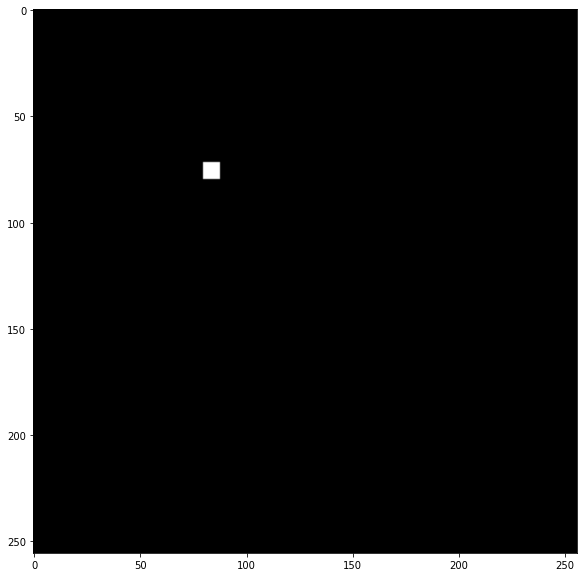

In [ ]:
prediction of Pspnet
%%time
aa = 0
for image in test_dataset:
  pred_mask = model_psp.predict(image)
  # print(pred_mask.shape)
  pred_mask[pred_mask > 0.5] = 1
  pred_mask[pred_mask <= 0.5] = 0
  pred_mask = pred_mask.squeeze()
  pred_mask = pred_mask[..., tf.newaxis]
  for i in range(10):
    plt.figure(figsize=(10, 10))
    plt.imshow(tf.keras.preprocessing.image.array_to_img(tf.image.grayscale_to_rgb(tf.convert_to_tensor(pred_mask[i]))))
    plt.savefig('./Colab Notebooks/data/test/labels_psp3/'+test_image[aa][35:])
    aa += 1